In [1]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
import pandas as pd

In [2]:
#2) Set up exploration class and replay buffer.

class ActionNoise:
    """
        Class: Add noise to our action for exploration
        :param mean: mean of the gaussian noise
        :param std_dev: standard deviation of the gaussian noise
        :param total_episodes: number of steps for training
    """
    def __init__(self, mean, std_deviation,total_episodes):
        self.mean = mean
        self.std_dev = std_deviation
        self.change_ep = std_deviation/(total_episodes)
        
    
    def __call__(self,size):
        """
        Getting noise
        :param size: size of the Tensor with noise values
        :return: Tensor with gaussian noise
        """
        return torch.normal(torch.tensor(self.mean).repeat(size),torch.tensor(self.std_dev).repeat(size))
    
    
    def change_std(self):
        """
        Changing the standard deviation to reduce exploration over time
        """   
        self.std_dev=max(self.std_dev-self.change_ep,0.1)

Transition = namedtuple('Transition',('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    """
        Class: Replay Buffer (RB)
        :param capacity: capacity in memory
    """
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    
    def push(self, *args):
        """
        Save a transition object in RB
        :param args: elements in Transition object
        """
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """
        Get a sample from RB
        :param batch_size: number of objets in sample
        :return: sample of Transition object
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """
        Get number of saved objets
        :return: number of saved objets
        """
        return len(self.memory)



In [3]:
#3) Set up Neural Network functions and classes

def soft_update(target, source, tau):
    """
        Soft update for a neural network (NN) from an other NN
        :param source: NN used for weights copy
        :param tau: ratio parameter for copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    """
        Hard update for a neural network (NN) from an other NN
        :param source: NN used for weights copy ( like soft update with tau=1.0)
    """ 
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class DDPG_actor(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
        :param model: name of the NN
    """   
    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        self.name=model
    
      
    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.layer1(input1))
        output=F.relu(self.layer2(output))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic(nn.Module):
    """
        Class : critic NN
        :param nb_input1: size input state part of the NN (size state)
        :param nb_input2: size input actor part of the NN (size action)
        :param nb_outputs: size output of the NN (size Q_value =1)
        :param model: name of the NN
    """
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        
        super(DDPG_critic, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)
        self.name=model
        
      
    def forward(self, input1, input2):
        """
        Forward NN : compute the NN with respect the current state and action
        :param input1: state
        :param input2: action
        :return: output of the NN, Q_value
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.state_net1(input1))
        output1=F.relu(self.state_net2(output1))
        output2=F.relu(self.action_net1(input2))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.merge_net1(output3))
        output_final=self.merge_net2(output_final)
        return output_final

In [4]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
    
    
    def select_action(self, actor_net, state):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
    """
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action, legal_action = self.select_action(actor_net, prev_state)
                    state, reward, done, _ = self.env.step(legal_action.detach().numpy())
                    batch_obs.append(prev_state)
                    batch_acts.append(legal_action.detach().numpy())
                    batch_rews.append(reward)
                    prev_state = state
                if done:
                    break
        return torch.tensor(batch_obs, dtype=torch.float), torch.tensor(batch_acts, dtype=torch.float), torch.tensor(batch_rews, dtype=torch.float)



In [5]:
#5) Algorithm DDPG:
class Algo_DDPG():
    """ 
        PPO algorithm : training and testing
        :param policy_class_a: policy (actor model)
        :param policy_class_c: policy (critic model)
        :param env: environment
        :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class_a, policy_class_c, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class_a(num_states, num_actions, "online")
        self.critic_net = policy_class_c(num_states, num_actions, 1, "online")
        self.target_actor_net = policy_class_a(num_states, num_actions, "target")
        self.target_critic_net = policy_class_c(num_states, num_actions, 1, "target")
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr,weight_decay=0.01)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.rollout = Env_rollout(env, self.max_steps)
    
    def evaluate(self, nbr_episodes, selection):
        """
        Testing
        :param nbr_episodes: episode number 
        :param selection: target or current policy NN
        :return: state batch, action batch, and reward batch
        """
        if(selection=="target"):
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, nbr_episodes)
        else:
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def optimize_model(self):
        """
        Model Optimization
        :return: batch reward
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        criterion=nn.MSELoss(reduction='mean')

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)
        #Critic optimization
        self.optimizer_critic.zero_grad()
        target_actor_batch = self.target_actor_net.forward(next_state_batch)
        target_critic_batch = self.target_critic_net.forward(next_state_batch,target_actor_batch.detach())
        critic_action_batch = self.critic_net.forward(state_batch,action_batch)
        #print('OHO')
        #print("next_state_batch"+str(next_state_batch.shape))
        #print("target_actor_batch"+str(target_actor_batch.shape))
        #print("state_batch"+str(state_batch.shape))
        #print("action_batch"+str(action_batch.shape))
        #print("done_batch"+str(done_batch.shape))
        #print("target_critic_batch"+str(target_critic_batch.shape))
        #print("critic_action_batch"+str(critic_action_batch.shape)) 
        expected_state_action_values = (torch.mul(target_critic_batch, 1 - done_batch) * self.gamma) + reward_batch
        critic_loss = criterion(expected_state_action_values.detach(),critic_action_batch)
        critic_loss.backward()
        self.optimizer_critic.step()

        #Actor optimization
        #see if i can optimize only some times
        actor_batch = self.actor_net.forward(state_batch)
        critic_actor_batch = self.critic_net.forward(state_batch,actor_batch)
        actor_loss = - critic_actor_batch.mean()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        return reward_batch
    
    def select_action(self, actor_net, state, noise):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :param noise: noise object
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: step number
        """
        self.noise = ActionNoise(self.mean_dev, self.std_dev, nb_loop)
        for i in range(10):
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0))
                if done:
                    break
        n_step=0
        while n_step<nb_loop:
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward])#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0)
                                )
                prev_state = state
                n_step=n_step+1
                self.total_loop= self.total_loop +1
                self.noise.change_std()
                if (n_step%2==0): #policy delay=2
                    batch_rew2=self.optimize_model()
                    soft_update(self.target_critic_net,self.critic_net,self.tau)
                    soft_update(self.target_actor_net,self.actor_net,self.tau)
                    if(batch_rew2 != None):
                        self.ep_reward_list.append(batch_rew2.mean().detach().numpy())
                #if (n_step%100000==0):
                #    hard_update(self.critic_net,self.target_critic_net)
                #    hard_update(self.actor_net,self.target_actor_net)
                if done:
                    break
            if(len(self.ep_reward_list)>0):
                avg_reward = np.mean(self.ep_reward_list[-30:])
                print("Steps * {} * Avg Reward is ==> {}".format(n_step, avg_reward))
        path='load_model/parameters/ddpg-{num_algo:02d}-{name}-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.batch_size = 100
        self.memory = ReplayMemory(1000000)
        self.tau = 0.005
        self.gamma = 0.99
        self.mean_dev = 0.0
        self.std_dev = 0.5
        self.max_steps = 90
        self.total_loop = 0
        self.critic_lr = 3e-3
        self.actor_lr = 3e-4
        self.ep_reward_list=[]
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: step number
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        torch.save(self.target_actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        torch.save(self.target_critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        


In [6]:
#6) Computing part:
# Import environment
problem = "Crossway_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=12

algo=Algo_DDPG(DDPG_actor, DDPG_critic, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,2000000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [7]:
#Training
import time
start = time.time()
algo.train(2000000)
algo.saving()
end = time.time()
print("Running time: "+str(end-start))

Steps * 31 * Avg Reward is ==> -20.427762985229492
Steps * 61 * Avg Reward is ==> -19.62662124633789
Steps * 86 * Avg Reward is ==> -19.31798553466797
Steps * 108 * Avg Reward is ==> -18.98933219909668
Steps * 139 * Avg Reward is ==> -18.25864601135254
Steps * 169 * Avg Reward is ==> -18.134075164794922
Steps * 259 * Avg Reward is ==> -19.614898681640625
Steps * 284 * Avg Reward is ==> -23.14387321472168
Steps * 308 * Avg Reward is ==> -24.347801208496094
Steps * 331 * Avg Reward is ==> -23.358318328857422
Steps * 354 * Avg Reward is ==> -22.142065048217773
Steps * 376 * Avg Reward is ==> -21.43853187561035
Steps * 398 * Avg Reward is ==> -21.220067977905273
Steps * 427 * Avg Reward is ==> -21.38132095336914
Steps * 452 * Avg Reward is ==> -21.049617767333984
Steps * 542 * Avg Reward is ==> -21.770654678344727
Steps * 632 * Avg Reward is ==> -26.327802658081055
Steps * 722 * Avg Reward is ==> -30.66940689086914
Steps * 742 * Avg Reward is ==> -32.496681213378906
Steps * 832 * Avg Rewar

Steps * 6139 * Avg Reward is ==> -27.742839813232422
Steps * 6162 * Avg Reward is ==> -26.68522834777832
Steps * 6185 * Avg Reward is ==> -26.327566146850586
Accident!
Steps * 6222 * Avg Reward is ==> -26.37934112548828
Steps * 6243 * Avg Reward is ==> -26.44382095336914
Steps * 6277 * Avg Reward is ==> -26.91423225402832
Steps * 6316 * Avg Reward is ==> -27.390583038330078
Steps * 6339 * Avg Reward is ==> -28.172788619995117
Accident!
Steps * 6375 * Avg Reward is ==> -28.581043243408203
Steps * 6406 * Avg Reward is ==> -28.196128845214844
Steps * 6438 * Avg Reward is ==> -28.168048858642578
Steps * 6464 * Avg Reward is ==> -27.444042205810547
Accident!
Steps * 6502 * Avg Reward is ==> -27.45966148376465
Steps * 6526 * Avg Reward is ==> -27.158912658691406
Steps * 6560 * Avg Reward is ==> -28.258466720581055
Steps * 6583 * Avg Reward is ==> -29.134050369262695
Steps * 6613 * Avg Reward is ==> -28.60904884338379
Steps * 6646 * Avg Reward is ==> -25.59996795654297
Steps * 6669 * Avg Rewa

Steps * 10732 * Avg Reward is ==> -18.08954429626465
Steps * 10770 * Avg Reward is ==> -18.25034523010254
Steps * 10800 * Avg Reward is ==> -18.61915397644043
Steps * 10835 * Avg Reward is ==> -19.21542739868164
Steps * 10871 * Avg Reward is ==> -18.11685562133789
Steps * 10910 * Avg Reward is ==> -18.421215057373047
Steps * 10938 * Avg Reward is ==> -17.649560928344727
Steps * 10961 * Avg Reward is ==> -18.452302932739258
Steps * 10999 * Avg Reward is ==> -18.543256759643555
Steps * 11039 * Avg Reward is ==> -17.919713973999023
Steps * 11073 * Avg Reward is ==> -17.131669998168945
Steps * 11111 * Avg Reward is ==> -17.305145263671875
Steps * 11149 * Avg Reward is ==> -18.196460723876953
Steps * 11173 * Avg Reward is ==> -18.652143478393555
Accident!
Steps * 11211 * Avg Reward is ==> -18.542802810668945
Accident!
Steps * 11248 * Avg Reward is ==> -18.531982421875
Accident!
Steps * 11283 * Avg Reward is ==> -18.227720260620117
Accident!
Steps * 11320 * Avg Reward is ==> -17.163698196411

Steps * 15395 * Avg Reward is ==> -13.777008056640625
Steps * 15420 * Avg Reward is ==> -13.29508113861084
Steps * 15444 * Avg Reward is ==> -13.763416290283203
Steps * 15469 * Avg Reward is ==> -13.563471794128418
Steps * 15524 * Avg Reward is ==> -13.819398880004883
Steps * 15575 * Avg Reward is ==> -13.791631698608398
Steps * 15600 * Avg Reward is ==> -13.48547649383545
Steps * 15623 * Avg Reward is ==> -12.991601943969727
Steps * 15656 * Avg Reward is ==> -14.039865493774414
Steps * 15693 * Avg Reward is ==> -14.412596702575684
Steps * 15748 * Avg Reward is ==> -14.023451805114746
Steps * 15772 * Avg Reward is ==> -14.471455574035645
Steps * 15814 * Avg Reward is ==> -14.737767219543457
Steps * 15873 * Avg Reward is ==> -13.92510986328125
Steps * 15894 * Avg Reward is ==> -14.792892456054688
Steps * 15918 * Avg Reward is ==> -13.425525665283203
Steps * 15979 * Avg Reward is ==> -13.405797958374023
Steps * 16004 * Avg Reward is ==> -13.42000675201416
Steps * 16061 * Avg Reward is ==

Steps * 21154 * Avg Reward is ==> -11.202437400817871
Steps * 21181 * Avg Reward is ==> -10.54602336883545
Steps * 21238 * Avg Reward is ==> -11.157296180725098
Steps * 21262 * Avg Reward is ==> -11.820448875427246
Steps * 21318 * Avg Reward is ==> -11.048722267150879
Steps * 21341 * Avg Reward is ==> -11.675889015197754
Steps * 21364 * Avg Reward is ==> -12.160205841064453
Steps * 21419 * Avg Reward is ==> -11.126184463500977
Steps * 21473 * Avg Reward is ==> -11.413463592529297
Steps * 21528 * Avg Reward is ==> -10.37956428527832
Steps * 21577 * Avg Reward is ==> -10.653349876403809
Steps * 21636 * Avg Reward is ==> -10.791568756103516
Steps * 21685 * Avg Reward is ==> -11.540958404541016
Steps * 21707 * Avg Reward is ==> -11.191272735595703
Steps * 21731 * Avg Reward is ==> -11.227356910705566
Steps * 21793 * Avg Reward is ==> -11.66202449798584
Steps * 21817 * Avg Reward is ==> -11.054798126220703
Steps * 21840 * Avg Reward is ==> -10.872603416442871
Steps * 21890 * Avg Reward is =

Steps * 27815 * Avg Reward is ==> -8.251111030578613
Steps * 27874 * Avg Reward is ==> -9.324111938476562
Steps * 27933 * Avg Reward is ==> -8.98979663848877
Steps * 27959 * Avg Reward is ==> -8.83434009552002
Steps * 28021 * Avg Reward is ==> -8.501517295837402
Steps * 28075 * Avg Reward is ==> -8.659031867980957
Steps * 28135 * Avg Reward is ==> -8.759923934936523
Steps * 28186 * Avg Reward is ==> -9.012434005737305
Steps * 28248 * Avg Reward is ==> -8.758551597595215
Steps * 28307 * Avg Reward is ==> -8.944783210754395
Steps * 28362 * Avg Reward is ==> -9.1708984375
Steps * 28422 * Avg Reward is ==> -8.66772174835205
Steps * 28482 * Avg Reward is ==> -8.673468589782715
Steps * 28515 * Avg Reward is ==> -9.12467098236084
Steps * 28541 * Avg Reward is ==> -8.895503044128418
Steps * 28591 * Avg Reward is ==> -8.398721694946289
Steps * 28657 * Avg Reward is ==> -9.059793472290039
Steps * 28715 * Avg Reward is ==> -9.29957103729248
Steps * 28739 * Avg Reward is ==> -8.60622787475586
Step

Steps * 33809 * Avg Reward is ==> -8.11229133605957
Steps * 33861 * Avg Reward is ==> -6.754350185394287
Steps * 33886 * Avg Reward is ==> -6.5193023681640625
Steps * 33909 * Avg Reward is ==> -7.274116516113281
Steps * 33931 * Avg Reward is ==> -7.186750888824463
Steps * 33961 * Avg Reward is ==> -7.314544677734375
Steps * 34013 * Avg Reward is ==> -7.050452709197998
Steps * 34067 * Avg Reward is ==> -7.533620357513428
Steps * 34114 * Avg Reward is ==> -8.122626304626465
Steps * 34138 * Avg Reward is ==> -8.339123725891113
Steps * 34161 * Avg Reward is ==> -8.569604873657227
Steps * 34206 * Avg Reward is ==> -7.342817783355713
Steps * 34259 * Avg Reward is ==> -7.289578914642334
Steps * 34284 * Avg Reward is ==> -6.859353065490723
Steps * 34306 * Avg Reward is ==> -8.057198524475098
Steps * 34334 * Avg Reward is ==> -7.593891620635986
Steps * 34386 * Avg Reward is ==> -7.321074485778809
Steps * 34412 * Avg Reward is ==> -7.225386142730713
Steps * 34455 * Avg Reward is ==> -7.029494762

Steps * 39376 * Avg Reward is ==> -6.5683488845825195
Steps * 39424 * Avg Reward is ==> -6.7127299308776855
Steps * 39449 * Avg Reward is ==> -6.673593521118164
Steps * 39490 * Avg Reward is ==> -6.631150722503662
Steps * 39537 * Avg Reward is ==> -7.099523544311523
Steps * 39584 * Avg Reward is ==> -6.81489372253418
Steps * 39607 * Avg Reward is ==> -6.356368064880371
Steps * 39657 * Avg Reward is ==> -6.28238582611084
Steps * 39680 * Avg Reward is ==> -6.1913909912109375
Steps * 39704 * Avg Reward is ==> -6.28156042098999
Steps * 39728 * Avg Reward is ==> -7.109010219573975
Steps * 39749 * Avg Reward is ==> -6.758055686950684
Steps * 39772 * Avg Reward is ==> -6.70787239074707
Steps * 39802 * Avg Reward is ==> -6.228959083557129
Steps * 39850 * Avg Reward is ==> -6.611079692840576
Steps * 39896 * Avg Reward is ==> -6.9260735511779785
Steps * 39944 * Avg Reward is ==> -6.973084449768066
Steps * 39967 * Avg Reward is ==> -7.081492900848389
Steps * 39991 * Avg Reward is ==> -7.603537082

Steps * 44857 * Avg Reward is ==> -5.86733865737915
Steps * 44907 * Avg Reward is ==> -5.733802795410156
Steps * 44928 * Avg Reward is ==> -5.781608581542969
Steps * 44952 * Avg Reward is ==> -6.132027626037598
Steps * 44975 * Avg Reward is ==> -6.2638936042785645
Steps * 44997 * Avg Reward is ==> -6.017289638519287
Steps * 45023 * Avg Reward is ==> -5.945207118988037
Steps * 45085 * Avg Reward is ==> -5.8704328536987305
Steps * 45134 * Avg Reward is ==> -5.958840847015381
Steps * 45160 * Avg Reward is ==> -5.843982219696045
Steps * 45210 * Avg Reward is ==> -6.104269027709961
Steps * 45253 * Avg Reward is ==> -6.365772724151611
Steps * 45292 * Avg Reward is ==> -5.652763843536377
Steps * 45313 * Avg Reward is ==> -5.568716049194336
Steps * 45340 * Avg Reward is ==> -6.148484706878662
Steps * 45382 * Avg Reward is ==> -5.5450520515441895
Steps * 45442 * Avg Reward is ==> -5.855474948883057
Steps * 45465 * Avg Reward is ==> -5.469609260559082
Steps * 45509 * Avg Reward is ==> -5.4498605

Steps * 50416 * Avg Reward is ==> -5.485942363739014
Steps * 50437 * Avg Reward is ==> -5.484991073608398
Steps * 50488 * Avg Reward is ==> -5.271629333496094
Steps * 50534 * Avg Reward is ==> -5.362481594085693
Steps * 50579 * Avg Reward is ==> -5.2464213371276855
Steps * 50600 * Avg Reward is ==> -5.506224632263184
Steps * 50649 * Avg Reward is ==> -5.650487899780273
Steps * 50674 * Avg Reward is ==> -5.607849597930908
Steps * 50717 * Avg Reward is ==> -4.482789039611816
Steps * 50742 * Avg Reward is ==> -4.745871543884277
Steps * 50766 * Avg Reward is ==> -5.126051425933838
Steps * 50788 * Avg Reward is ==> -5.162102222442627
Steps * 50816 * Avg Reward is ==> -5.297712802886963
Steps * 50841 * Avg Reward is ==> -5.857758045196533
Steps * 50863 * Avg Reward is ==> -5.400252819061279
Steps * 50904 * Avg Reward is ==> -5.203376293182373
Steps * 50929 * Avg Reward is ==> -5.469737529754639
Steps * 50985 * Avg Reward is ==> -6.348214149475098
Steps * 51008 * Avg Reward is ==> -6.33209180

Steps * 55823 * Avg Reward is ==> -4.667974472045898
Steps * 55845 * Avg Reward is ==> -4.973313808441162
Steps * 55887 * Avg Reward is ==> -4.96980094909668
Steps * 55908 * Avg Reward is ==> -5.087410926818848
Steps * 55952 * Avg Reward is ==> -5.568391799926758
Steps * 55976 * Avg Reward is ==> -5.1616010665893555
Steps * 55999 * Avg Reward is ==> -4.79209041595459
Steps * 56042 * Avg Reward is ==> -5.243249893188477
Steps * 56093 * Avg Reward is ==> -5.125389575958252
Steps * 56149 * Avg Reward is ==> -4.925570011138916
Steps * 56198 * Avg Reward is ==> -4.530205249786377
Steps * 56224 * Avg Reward is ==> -5.014814853668213
Steps * 56247 * Avg Reward is ==> -5.362948894500732
Steps * 56270 * Avg Reward is ==> -5.420309066772461
Steps * 56319 * Avg Reward is ==> -4.8354268074035645
Steps * 56369 * Avg Reward is ==> -5.251830101013184
Steps * 56414 * Avg Reward is ==> -4.031851768493652
Steps * 56442 * Avg Reward is ==> -4.486046314239502
Steps * 56466 * Avg Reward is ==> -4.854911327

Steps * 61346 * Avg Reward is ==> -4.680186748504639
Steps * 61370 * Avg Reward is ==> -4.987237453460693
Steps * 61397 * Avg Reward is ==> -5.528527736663818
Steps * 61422 * Avg Reward is ==> -5.224125862121582
Steps * 61445 * Avg Reward is ==> -5.550852298736572
Steps * 61468 * Avg Reward is ==> -5.378994464874268
Steps * 61518 * Avg Reward is ==> -4.250020503997803
Steps * 61546 * Avg Reward is ==> -4.283248424530029
Steps * 61595 * Avg Reward is ==> -5.003315448760986
Steps * 61625 * Avg Reward is ==> -4.330650806427002
Steps * 61647 * Avg Reward is ==> -4.103079795837402
Steps * 61668 * Avg Reward is ==> -4.303036689758301
Steps * 61694 * Avg Reward is ==> -4.641719341278076
Steps * 61747 * Avg Reward is ==> -5.431545734405518
Steps * 61772 * Avg Reward is ==> -5.115199565887451
Steps * 61818 * Avg Reward is ==> -4.525392055511475
Steps * 61862 * Avg Reward is ==> -4.487424850463867
Steps * 61885 * Avg Reward is ==> -4.267093181610107
Steps * 61943 * Avg Reward is ==> -4.672389030

Steps * 67061 * Avg Reward is ==> -3.335878610610962
Steps * 67110 * Avg Reward is ==> -4.265809535980225
Steps * 67162 * Avg Reward is ==> -3.852307081222534
Steps * 67204 * Avg Reward is ==> -3.2436368465423584
Steps * 67245 * Avg Reward is ==> -3.7107033729553223
Steps * 67269 * Avg Reward is ==> -4.65540885925293
Steps * 67311 * Avg Reward is ==> -4.638951301574707
Steps * 67354 * Avg Reward is ==> -3.9385323524475098
Steps * 67378 * Avg Reward is ==> -3.458829164505005
Steps * 67403 * Avg Reward is ==> -3.5453035831451416
Steps * 67446 * Avg Reward is ==> -4.4920172691345215
Steps * 67493 * Avg Reward is ==> -4.025404453277588
Steps * 67533 * Avg Reward is ==> -4.210705280303955
Steps * 67582 * Avg Reward is ==> -4.3842902183532715
Steps * 67625 * Avg Reward is ==> -4.2066497802734375
Steps * 67672 * Avg Reward is ==> -3.324922800064087
Steps * 67697 * Avg Reward is ==> -3.6227338314056396
Steps * 67742 * Avg Reward is ==> -4.19170618057251
Steps * 67766 * Avg Reward is ==> -4.338

Steps * 72563 * Avg Reward is ==> -3.440917730331421
Steps * 72587 * Avg Reward is ==> -3.083325147628784
Steps * 72630 * Avg Reward is ==> -3.5351343154907227
Steps * 72670 * Avg Reward is ==> -3.5423879623413086
Steps * 72693 * Avg Reward is ==> -3.6778674125671387
Steps * 72735 * Avg Reward is ==> -4.688041687011719
Steps * 72757 * Avg Reward is ==> -5.370465278625488
Steps * 72780 * Avg Reward is ==> -4.547791957855225
Steps * 72803 * Avg Reward is ==> -3.703760862350464
Steps * 72829 * Avg Reward is ==> -3.2995376586914062
Steps * 72873 * Avg Reward is ==> -3.1157844066619873
Steps * 72921 * Avg Reward is ==> -3.7598063945770264
Steps * 72967 * Avg Reward is ==> -3.9183764457702637
Steps * 73014 * Avg Reward is ==> -3.609553098678589
Steps * 73038 * Avg Reward is ==> -3.747753620147705
Steps * 73085 * Avg Reward is ==> -3.785571336746216
Steps * 73130 * Avg Reward is ==> -3.703341245651245
Steps * 73170 * Avg Reward is ==> -3.378565549850464
Steps * 73215 * Avg Reward is ==> -3.33

Steps * 78240 * Avg Reward is ==> -3.2982497215270996
Steps * 78266 * Avg Reward is ==> -3.878514051437378
Steps * 78289 * Avg Reward is ==> -4.147381782531738
Steps * 78312 * Avg Reward is ==> -4.170770168304443
Steps * 78336 * Avg Reward is ==> -3.8969171047210693
Steps * 78360 * Avg Reward is ==> -3.7506511211395264
Steps * 78399 * Avg Reward is ==> -3.6550345420837402
Steps * 78443 * Avg Reward is ==> -3.393681049346924
Steps * 78491 * Avg Reward is ==> -3.2411744594573975
Steps * 78514 * Avg Reward is ==> -3.6867926120758057
Steps * 78537 * Avg Reward is ==> -4.13246488571167
Steps * 78577 * Avg Reward is ==> -4.094363212585449
Steps * 78635 * Avg Reward is ==> -3.3813793659210205
Steps * 78657 * Avg Reward is ==> -2.939986228942871
Steps * 78680 * Avg Reward is ==> -3.297105312347412
Steps * 78730 * Avg Reward is ==> -3.6963422298431396
Steps * 78753 * Avg Reward is ==> -3.791367530822754
Steps * 78803 * Avg Reward is ==> -3.7447803020477295
Steps * 78842 * Avg Reward is ==> -3.6

Steps * 83786 * Avg Reward is ==> -3.6924891471862793
Steps * 83828 * Avg Reward is ==> -4.075347423553467
Steps * 83879 * Avg Reward is ==> -3.738600730895996
Steps * 83920 * Avg Reward is ==> -3.5921831130981445
Steps * 83963 * Avg Reward is ==> -3.465040683746338
Steps * 84008 * Avg Reward is ==> -3.470909833908081
Steps * 84055 * Avg Reward is ==> -3.476750135421753
Steps * 84098 * Avg Reward is ==> -3.954411268234253
Steps * 84147 * Avg Reward is ==> -4.329954624176025
Steps * 84173 * Avg Reward is ==> -3.9073617458343506
Steps * 84197 * Avg Reward is ==> -3.6556849479675293
Steps * 84220 * Avg Reward is ==> -3.7306582927703857
Steps * 84267 * Avg Reward is ==> -2.922856569290161
Steps * 84308 * Avg Reward is ==> -3.620502233505249
Steps * 84351 * Avg Reward is ==> -3.471896171569824
Steps * 84395 * Avg Reward is ==> -4.220920085906982
Steps * 84442 * Avg Reward is ==> -3.447753667831421
Steps * 84465 * Avg Reward is ==> -3.476980447769165
Steps * 84489 * Avg Reward is ==> -3.5363

Steps * 89308 * Avg Reward is ==> -3.703707456588745
Steps * 89329 * Avg Reward is ==> -3.4175570011138916
Steps * 89371 * Avg Reward is ==> -3.5626652240753174
Steps * 89395 * Avg Reward is ==> -3.486835241317749
Steps * 89435 * Avg Reward is ==> -3.275038957595825
Steps * 89459 * Avg Reward is ==> -3.2308237552642822
Steps * 89501 * Avg Reward is ==> -3.441080331802368
Steps * 89543 * Avg Reward is ==> -3.7595674991607666
Steps * 89565 * Avg Reward is ==> -3.3469269275665283
Steps * 89590 * Avg Reward is ==> -3.8113813400268555
Steps * 89612 * Avg Reward is ==> -4.013858318328857
Steps * 89658 * Avg Reward is ==> -3.165513277053833
Steps * 89683 * Avg Reward is ==> -3.007277727127075
Steps * 89707 * Avg Reward is ==> -3.1685891151428223
Steps * 89754 * Avg Reward is ==> -3.169642925262451
Steps * 89778 * Avg Reward is ==> -3.835240125656128
Steps * 89818 * Avg Reward is ==> -3.409271478652954
Steps * 89845 * Avg Reward is ==> -3.34867787361145
Steps * 89888 * Avg Reward is ==> -3.262

Steps * 94455 * Avg Reward is ==> -3.758040189743042
Steps * 94480 * Avg Reward is ==> -3.1751935482025146
Steps * 94506 * Avg Reward is ==> -2.7440402507781982
Steps * 94552 * Avg Reward is ==> -3.1935579776763916
Steps * 94599 * Avg Reward is ==> -2.913332223892212
Steps * 94625 * Avg Reward is ==> -3.453185558319092
Steps * 94671 * Avg Reward is ==> -3.7404897212982178
Steps * 94695 * Avg Reward is ==> -3.6288654804229736
Steps * 94736 * Avg Reward is ==> -3.1477038860321045
Steps * 94774 * Avg Reward is ==> -3.530599355697632
Steps * 94815 * Avg Reward is ==> -3.249129056930542
Steps * 94841 * Avg Reward is ==> -2.9805099964141846
Steps * 94866 * Avg Reward is ==> -2.928065299987793
Steps * 94912 * Avg Reward is ==> -3.391868829727173
Steps * 94955 * Avg Reward is ==> -3.1537396907806396
Steps * 95002 * Avg Reward is ==> -3.312546491622925
Steps * 95031 * Avg Reward is ==> -3.1945080757141113
Steps * 95055 * Avg Reward is ==> -3.1041555404663086
Steps * 95079 * Avg Reward is ==> -3

Steps * 99692 * Avg Reward is ==> -3.0409092903137207
Steps * 99737 * Avg Reward is ==> -3.2283847332000732
Steps * 99777 * Avg Reward is ==> -2.663658380508423
Steps * 99823 * Avg Reward is ==> -3.148444414138794
Steps * 99846 * Avg Reward is ==> -3.114295721054077
Steps * 99898 * Avg Reward is ==> -2.9413001537323
Steps * 99926 * Avg Reward is ==> -3.250737428665161
Steps * 99953 * Avg Reward is ==> -3.396312952041626
Steps * 99994 * Avg Reward is ==> -3.4291651248931885
Steps * 100040 * Avg Reward is ==> -3.2517988681793213
Steps * 100064 * Avg Reward is ==> -2.9195122718811035
Steps * 100090 * Avg Reward is ==> -3.0647408962249756
Steps * 100115 * Avg Reward is ==> -2.8739535808563232
Steps * 100160 * Avg Reward is ==> -2.4470503330230713
Steps * 100186 * Avg Reward is ==> -2.8257315158843994
Steps * 100211 * Avg Reward is ==> -3.097088575363159
Steps * 100233 * Avg Reward is ==> -3.4038426876068115
Steps * 100255 * Avg Reward is ==> -2.798259973526001
Steps * 100297 * Avg Reward i

Steps * 104961 * Avg Reward is ==> -2.957866907119751
Steps * 104986 * Avg Reward is ==> -3.16117262840271
Steps * 105012 * Avg Reward is ==> -2.653040885925293
Steps * 105036 * Avg Reward is ==> -2.7588658332824707
Steps * 105083 * Avg Reward is ==> -2.494990825653076
Steps * 105129 * Avg Reward is ==> -2.3644278049468994
Steps * 105170 * Avg Reward is ==> -2.8938522338867188
Steps * 105193 * Avg Reward is ==> -2.9800310134887695
Steps * 105217 * Avg Reward is ==> -2.7703194618225098
Steps * 105242 * Avg Reward is ==> -2.7605485916137695
Steps * 105265 * Avg Reward is ==> -2.6515488624572754
Steps * 105307 * Avg Reward is ==> -3.356107234954834
Steps * 105329 * Avg Reward is ==> -3.0698065757751465
Steps * 105372 * Avg Reward is ==> -2.8922104835510254
Steps * 105411 * Avg Reward is ==> -3.153513193130493
Steps * 105457 * Avg Reward is ==> -2.965285539627075
Steps * 105484 * Avg Reward is ==> -3.0129623413085938
Steps * 105529 * Avg Reward is ==> -2.7064099311828613
Steps * 105553 * A

Steps * 109973 * Avg Reward is ==> -2.843860149383545
Steps * 109996 * Avg Reward is ==> -2.7642714977264404
Steps * 110020 * Avg Reward is ==> -2.933739423751831
Steps * 110064 * Avg Reward is ==> -3.490799903869629
Steps * 110086 * Avg Reward is ==> -3.2094035148620605
Steps * 110109 * Avg Reward is ==> -2.795555830001831
Steps * 110152 * Avg Reward is ==> -2.8721587657928467
Steps * 110174 * Avg Reward is ==> -3.210477590560913
Steps * 110202 * Avg Reward is ==> -3.219545602798462
Steps * 110243 * Avg Reward is ==> -2.8129141330718994
Steps * 110289 * Avg Reward is ==> -2.7603940963745117
Steps * 110334 * Avg Reward is ==> -2.884705066680908
Steps * 110374 * Avg Reward is ==> -2.9264321327209473
Steps * 110416 * Avg Reward is ==> -2.575134754180908
Steps * 110440 * Avg Reward is ==> -2.7153992652893066
Steps * 110463 * Avg Reward is ==> -2.8526649475097656
Steps * 110510 * Avg Reward is ==> -2.481981039047241
Steps * 110565 * Avg Reward is ==> -2.773170232772827
Steps * 110609 * Avg

Steps * 115246 * Avg Reward is ==> -3.068451404571533
Steps * 115289 * Avg Reward is ==> -2.882657766342163
Steps * 115311 * Avg Reward is ==> -2.7142996788024902
Steps * 115360 * Avg Reward is ==> -3.0236828327178955
Steps * 115404 * Avg Reward is ==> -2.3269259929656982
Steps * 115450 * Avg Reward is ==> -2.920305013656616
Steps * 115494 * Avg Reward is ==> -2.550945281982422
Steps * 115520 * Avg Reward is ==> -2.5281198024749756
Steps * 115564 * Avg Reward is ==> -2.87548828125
Steps * 115588 * Avg Reward is ==> -2.746018171310425
Steps * 115633 * Avg Reward is ==> -2.549144744873047
Steps * 115655 * Avg Reward is ==> -2.7806663513183594
Steps * 115702 * Avg Reward is ==> -3.2068724632263184
Steps * 115744 * Avg Reward is ==> -3.0220162868499756
Steps * 115793 * Avg Reward is ==> -2.77535343170166
Steps * 115835 * Avg Reward is ==> -2.730177402496338
Steps * 115887 * Avg Reward is ==> -2.2567591667175293
Steps * 115912 * Avg Reward is ==> -2.622879981994629
Steps * 115935 * Avg Rewa

Steps * 120571 * Avg Reward is ==> -2.394742012023926
Steps * 120617 * Avg Reward is ==> -2.3517508506774902
Steps * 120659 * Avg Reward is ==> -2.5238771438598633
Steps * 120703 * Avg Reward is ==> -2.5619311332702637
Steps * 120727 * Avg Reward is ==> -2.7164714336395264
Steps * 120774 * Avg Reward is ==> -2.88354229927063
Steps * 120819 * Avg Reward is ==> -2.1096301078796387
Steps * 120841 * Avg Reward is ==> -2.4272398948669434
Steps * 120887 * Avg Reward is ==> -2.6342597007751465
Steps * 120932 * Avg Reward is ==> -2.3124678134918213
Steps * 120957 * Avg Reward is ==> -1.9774140119552612
Steps * 121004 * Avg Reward is ==> -2.6267013549804688
Steps * 121052 * Avg Reward is ==> -2.759202718734741
Steps * 121076 * Avg Reward is ==> -2.829932689666748
Steps * 121127 * Avg Reward is ==> -2.4549055099487305
Steps * 121175 * Avg Reward is ==> -3.107668876647949
Steps * 121226 * Avg Reward is ==> -3.0913705825805664
Steps * 121250 * Avg Reward is ==> -2.930743932723999
Steps * 121291 * 

Steps * 125698 * Avg Reward is ==> -2.925346851348877
Steps * 125724 * Avg Reward is ==> -2.580174207687378
Steps * 125748 * Avg Reward is ==> -2.5286760330200195
Steps * 125799 * Avg Reward is ==> -2.721946954727173
Steps * 125822 * Avg Reward is ==> -2.318737030029297
Steps * 125869 * Avg Reward is ==> -2.5686795711517334
Steps * 125892 * Avg Reward is ==> -2.8452682495117188
Steps * 125914 * Avg Reward is ==> -2.769467830657959
Steps * 125942 * Avg Reward is ==> -2.5226614475250244
Steps * 125984 * Avg Reward is ==> -2.244314670562744
Steps * 126031 * Avg Reward is ==> -2.559084177017212
Steps * 126061 * Avg Reward is ==> -2.8109676837921143
Steps * 126106 * Avg Reward is ==> -2.504671812057495
Steps * 126129 * Avg Reward is ==> -2.4132697582244873
Steps * 126173 * Avg Reward is ==> -2.5024592876434326
Steps * 126194 * Avg Reward is ==> -2.671635150909424
Steps * 126238 * Avg Reward is ==> -2.6947569847106934
Steps * 126263 * Avg Reward is ==> -2.592780351638794
Steps * 126290 * Avg

Steps * 130865 * Avg Reward is ==> -2.308013439178467
Steps * 130909 * Avg Reward is ==> -2.353640556335449
Steps * 130950 * Avg Reward is ==> -2.607370138168335
Steps * 130995 * Avg Reward is ==> -2.5478127002716064
Steps * 131017 * Avg Reward is ==> -2.253566265106201
Steps * 131067 * Avg Reward is ==> -2.2353508472442627
Steps * 131089 * Avg Reward is ==> -2.1141250133514404
Steps * 131113 * Avg Reward is ==> -2.081278085708618
Steps * 131140 * Avg Reward is ==> -2.1214818954467773
Steps * 131182 * Avg Reward is ==> -2.189924716949463
Steps * 131229 * Avg Reward is ==> -2.5687549114227295
Steps * 131276 * Avg Reward is ==> -2.734346866607666
Steps * 131299 * Avg Reward is ==> -2.7022414207458496
Steps * 131344 * Avg Reward is ==> -2.7262187004089355
Steps * 131367 * Avg Reward is ==> -2.744987726211548
Steps * 131414 * Avg Reward is ==> -2.803156852722168
Steps * 131438 * Avg Reward is ==> -2.773693561553955
Steps * 131460 * Avg Reward is ==> -2.3686201572418213
Steps * 131507 * Avg

Steps * 136115 * Avg Reward is ==> -2.019228458404541
Steps * 136160 * Avg Reward is ==> -2.2891461849212646
Steps * 136180 * Avg Reward is ==> -2.607926845550537
Steps * 136222 * Avg Reward is ==> -2.5641229152679443
Steps * 136265 * Avg Reward is ==> -2.254347801208496
Steps * 136289 * Avg Reward is ==> -2.4578912258148193
Steps * 136332 * Avg Reward is ==> -2.6352460384368896
Steps * 136355 * Avg Reward is ==> -2.950762987136841
Steps * 136399 * Avg Reward is ==> -2.7020163536071777
Steps * 136440 * Avg Reward is ==> -2.4729602336883545
Steps * 136466 * Avg Reward is ==> -2.2528274059295654
Steps * 136490 * Avg Reward is ==> -2.222243547439575
Steps * 136516 * Avg Reward is ==> -2.4412920475006104
Steps * 136542 * Avg Reward is ==> -2.498018503189087
Steps * 136585 * Avg Reward is ==> -2.161193370819092
Steps * 136608 * Avg Reward is ==> -2.446343183517456
Steps * 136631 * Avg Reward is ==> -2.3883233070373535
Steps * 136677 * Avg Reward is ==> -2.493992328643799
Steps * 136720 * Av

Steps * 141507 * Avg Reward is ==> -2.456789970397949
Steps * 141532 * Avg Reward is ==> -2.6325862407684326
Steps * 141583 * Avg Reward is ==> -2.4969446659088135
Steps * 141622 * Avg Reward is ==> -2.50571608543396
Steps * 141665 * Avg Reward is ==> -2.6254642009735107
Steps * 141710 * Avg Reward is ==> -2.3179190158843994
Steps * 141753 * Avg Reward is ==> -2.283912420272827
Steps * 141778 * Avg Reward is ==> -2.146777629852295
Steps * 141824 * Avg Reward is ==> -1.8795983791351318
Steps * 141847 * Avg Reward is ==> -2.338420867919922
Steps * 141875 * Avg Reward is ==> -2.4726693630218506
Steps * 141900 * Avg Reward is ==> -2.4217021465301514
Steps * 141951 * Avg Reward is ==> -2.2641472816467285
Steps * 141974 * Avg Reward is ==> -2.2415859699249268
Steps * 142023 * Avg Reward is ==> -2.089231252670288
Steps * 142070 * Avg Reward is ==> -2.2204785346984863
Steps * 142098 * Avg Reward is ==> -2.484494209289551
Steps * 142148 * Avg Reward is ==> -2.2169442176818848
Steps * 142173 * A

Steps * 146749 * Avg Reward is ==> -2.1250081062316895
Steps * 146796 * Avg Reward is ==> -2.0466606616973877
Steps * 146819 * Avg Reward is ==> -2.113785982131958
Steps * 146863 * Avg Reward is ==> -2.0074515342712402
Steps * 146887 * Avg Reward is ==> -2.22650146484375
Steps * 146936 * Avg Reward is ==> -2.4159882068634033
Steps * 146982 * Avg Reward is ==> -2.3606302738189697
Steps * 147026 * Avg Reward is ==> -2.071260690689087
Steps * 147069 * Avg Reward is ==> -2.1425704956054688
Steps * 147113 * Avg Reward is ==> -2.1421165466308594
Steps * 147140 * Avg Reward is ==> -2.1362998485565186
Steps * 147166 * Avg Reward is ==> -2.0397560596466064
Steps * 147190 * Avg Reward is ==> -2.070185899734497
Steps * 147234 * Avg Reward is ==> -2.1064605712890625
Steps * 147260 * Avg Reward is ==> -2.4995226860046387
Steps * 147301 * Avg Reward is ==> -2.744898796081543
Steps * 147325 * Avg Reward is ==> -2.436943769454956
Steps * 147346 * Avg Reward is ==> -2.281968355178833
Steps * 147369 * A

Steps * 151962 * Avg Reward is ==> -2.1764724254608154
Steps * 152004 * Avg Reward is ==> -2.2357194423675537
Steps * 152031 * Avg Reward is ==> -2.1211180686950684
Steps * 152074 * Avg Reward is ==> -1.6871424913406372
Steps * 152118 * Avg Reward is ==> -2.125356435775757
Steps * 152161 * Avg Reward is ==> -2.224825143814087
Steps * 152187 * Avg Reward is ==> -2.0049264430999756
Steps * 152211 * Avg Reward is ==> -1.9891256093978882
Steps * 152233 * Avg Reward is ==> -2.3470122814178467
Steps * 152278 * Avg Reward is ==> -2.2813022136688232
Steps * 152323 * Avg Reward is ==> -2.074242115020752
Steps * 152367 * Avg Reward is ==> -1.8575841188430786
Steps * 152389 * Avg Reward is ==> -1.7552337646484375
Steps * 152411 * Avg Reward is ==> -1.8587355613708496
Steps * 152438 * Avg Reward is ==> -2.2009382247924805
Steps * 152486 * Avg Reward is ==> -1.8777791261672974
Steps * 152530 * Avg Reward is ==> -2.0457303524017334
Steps * 152571 * Avg Reward is ==> -1.9520257711410522
Steps * 15259

Steps * 157035 * Avg Reward is ==> -2.7672247886657715
Steps * 157059 * Avg Reward is ==> -2.263035297393799
Steps * 157086 * Avg Reward is ==> -2.285074472427368
Steps * 157130 * Avg Reward is ==> -2.8473777770996094
Steps * 157153 * Avg Reward is ==> -2.400749683380127
Steps * 157177 * Avg Reward is ==> -2.276989698410034
Steps * 157201 * Avg Reward is ==> -2.4082276821136475
Steps * 157247 * Avg Reward is ==> -1.8674992322921753
Steps * 157289 * Avg Reward is ==> -2.3200466632843018
Steps * 157313 * Avg Reward is ==> -2.5020065307617188
Steps * 157336 * Avg Reward is ==> -2.7117130756378174
Steps * 157381 * Avg Reward is ==> -2.225421667098999
Steps * 157407 * Avg Reward is ==> -1.9355969429016113
Steps * 157450 * Avg Reward is ==> -1.7639893293380737
Steps * 157489 * Avg Reward is ==> -1.8616067171096802
Steps * 157532 * Avg Reward is ==> -1.995883584022522
Steps * 157556 * Avg Reward is ==> -1.9025909900665283
Steps * 157579 * Avg Reward is ==> -1.8761621713638306
Steps * 157619 *

Steps * 162235 * Avg Reward is ==> -1.8631895780563354
Steps * 162257 * Avg Reward is ==> -2.340670108795166
Steps * 162302 * Avg Reward is ==> -2.276656150817871
Steps * 162348 * Avg Reward is ==> -1.9508768320083618
Steps * 162371 * Avg Reward is ==> -1.669937014579773
Steps * 162395 * Avg Reward is ==> -1.9782780408859253
Steps * 162441 * Avg Reward is ==> -2.1603448390960693
Steps * 162464 * Avg Reward is ==> -2.266146659851074
Steps * 162487 * Avg Reward is ==> -2.3613853454589844
Steps * 162529 * Avg Reward is ==> -2.4971275329589844
Steps * 162558 * Avg Reward is ==> -2.4168596267700195
Steps * 162599 * Avg Reward is ==> -2.4763436317443848
Steps * 162646 * Avg Reward is ==> -2.338927984237671
Steps * 162673 * Avg Reward is ==> -1.8507126569747925
Steps * 162697 * Avg Reward is ==> -1.631392002105713
Steps * 162744 * Avg Reward is ==> -1.8259800672531128
Steps * 162768 * Avg Reward is ==> -1.8140100240707397
Steps * 162789 * Avg Reward is ==> -1.8192609548568726
Steps * 162813 *

Steps * 167333 * Avg Reward is ==> -1.7923716306686401
Steps * 167358 * Avg Reward is ==> -2.08058762550354
Steps * 167384 * Avg Reward is ==> -1.8543055057525635
Steps * 167422 * Avg Reward is ==> -1.9059109687805176
Steps * 167465 * Avg Reward is ==> -2.0941381454467773
Steps * 167487 * Avg Reward is ==> -2.2207882404327393
Steps * 167536 * Avg Reward is ==> -1.690983533859253
Steps * 167584 * Avg Reward is ==> -2.0288219451904297
Steps * 167607 * Avg Reward is ==> -2.1422312259674072
Steps * 167631 * Avg Reward is ==> -2.188448429107666
Steps * 167653 * Avg Reward is ==> -1.7594454288482666
Steps * 167697 * Avg Reward is ==> -2.3508832454681396
Steps * 167726 * Avg Reward is ==> -2.633107900619507
Steps * 167749 * Avg Reward is ==> -2.4287710189819336
Steps * 167793 * Avg Reward is ==> -2.444753408432007
Steps * 167839 * Avg Reward is ==> -2.361158847808838
Steps * 167862 * Avg Reward is ==> -2.263676404953003
Steps * 167907 * Avg Reward is ==> -2.0846781730651855
Steps * 167930 * A

Steps * 172500 * Avg Reward is ==> -2.045605421066284
Steps * 172523 * Avg Reward is ==> -2.2137486934661865
Steps * 172573 * Avg Reward is ==> -1.9827368259429932
Steps * 172614 * Avg Reward is ==> -2.228027820587158
Steps * 172659 * Avg Reward is ==> -2.3316428661346436
Steps * 172683 * Avg Reward is ==> -2.0226352214813232
Steps * 172709 * Avg Reward is ==> -1.8237141370773315
Steps * 172732 * Avg Reward is ==> -1.6438809633255005
Steps * 172775 * Avg Reward is ==> -1.977329969406128
Steps * 172823 * Avg Reward is ==> -2.1620545387268066
Steps * 172865 * Avg Reward is ==> -2.147341012954712
Steps * 172888 * Avg Reward is ==> -1.7960683107376099
Steps * 172939 * Avg Reward is ==> -1.7427650690078735
Steps * 172963 * Avg Reward is ==> -1.8005293607711792
Steps * 173007 * Avg Reward is ==> -1.8344042301177979
Steps * 173056 * Avg Reward is ==> -1.752599835395813
Steps * 173083 * Avg Reward is ==> -1.7006639242172241
Steps * 173106 * Avg Reward is ==> -1.9919310808181763
Steps * 173146 

Steps * 177715 * Avg Reward is ==> -2.193808078765869
Steps * 177760 * Avg Reward is ==> -2.259610891342163
Steps * 177808 * Avg Reward is ==> -1.622106909751892
Steps * 177833 * Avg Reward is ==> -1.5060096979141235
Steps * 177877 * Avg Reward is ==> -2.304913282394409
Steps * 177921 * Avg Reward is ==> -2.584047555923462
Steps * 177947 * Avg Reward is ==> -2.2254531383514404
Steps * 177990 * Avg Reward is ==> -1.8715215921401978
Steps * 178014 * Avg Reward is ==> -1.7416778802871704
Steps * 178057 * Avg Reward is ==> -1.82925283908844
Steps * 178096 * Avg Reward is ==> -2.1268246173858643
Steps * 178125 * Avg Reward is ==> -2.05000638961792
Steps * 178169 * Avg Reward is ==> -1.5092347860336304
Steps * 178213 * Avg Reward is ==> -1.905245304107666
Steps * 178264 * Avg Reward is ==> -2.3186261653900146
Steps * 178286 * Avg Reward is ==> -2.236527919769287
Steps * 178332 * Avg Reward is ==> -1.6000676155090332
Steps * 178380 * Avg Reward is ==> -2.1424460411071777
Steps * 178404 * Avg 

Steps * 183311 * Avg Reward is ==> -1.7612385749816895
Steps * 183334 * Avg Reward is ==> -1.8334767818450928
Steps * 183380 * Avg Reward is ==> -2.13039493560791
Steps * 183424 * Avg Reward is ==> -2.3833565711975098
Steps * 183448 * Avg Reward is ==> -2.309285879135132
Steps * 183489 * Avg Reward is ==> -2.1343865394592285
Steps * 183536 * Avg Reward is ==> -1.8423148393630981
Steps * 183580 * Avg Reward is ==> -2.234710693359375
Steps * 183604 * Avg Reward is ==> -2.1057076454162598
Steps * 183654 * Avg Reward is ==> -1.86483895778656
Steps * 183675 * Avg Reward is ==> -2.099368095397949
Steps * 183719 * Avg Reward is ==> -2.0433225631713867
Steps * 183762 * Avg Reward is ==> -2.0871362686157227
Steps * 183789 * Avg Reward is ==> -1.7473241090774536
Steps * 183834 * Avg Reward is ==> -2.1823689937591553
Steps * 183878 * Avg Reward is ==> -1.9678994417190552
Steps * 183919 * Avg Reward is ==> -1.7371087074279785
Steps * 183962 * Avg Reward is ==> -1.869884729385376
Steps * 184005 * A

Steps * 188603 * Avg Reward is ==> -1.9859055280685425
Steps * 188646 * Avg Reward is ==> -1.7209933996200562
Steps * 188675 * Avg Reward is ==> -2.0175750255584717
Steps * 188698 * Avg Reward is ==> -2.2487592697143555
Steps * 188745 * Avg Reward is ==> -2.103889226913452
Steps * 188766 * Avg Reward is ==> -1.8000438213348389
Steps * 188818 * Avg Reward is ==> -1.807547688484192
Steps * 188860 * Avg Reward is ==> -1.7897834777832031
Steps * 188889 * Avg Reward is ==> -1.8514666557312012
Steps * 188915 * Avg Reward is ==> -2.0718843936920166
Steps * 188943 * Avg Reward is ==> -2.3019630908966064
Steps * 188965 * Avg Reward is ==> -2.0015079975128174
Steps * 189007 * Avg Reward is ==> -1.8511698246002197
Steps * 189056 * Avg Reward is ==> -2.128194570541382
Steps * 189102 * Avg Reward is ==> -2.3118574619293213
Steps * 189146 * Avg Reward is ==> -2.07017183303833
Steps * 189167 * Avg Reward is ==> -1.8290292024612427
Steps * 189195 * Avg Reward is ==> -1.9185388088226318
Steps * 189250 

Steps * 193964 * Avg Reward is ==> -2.100952386856079
Steps * 194009 * Avg Reward is ==> -1.9055535793304443
Steps * 194036 * Avg Reward is ==> -1.812363862991333
Steps * 194082 * Avg Reward is ==> -1.9646791219711304
Steps * 194128 * Avg Reward is ==> -1.7117877006530762
Steps * 194174 * Avg Reward is ==> -1.8075671195983887
Steps * 194199 * Avg Reward is ==> -1.953545093536377
Steps * 194224 * Avg Reward is ==> -2.149836540222168
Steps * 194248 * Avg Reward is ==> -2.1998960971832275
Steps * 194269 * Avg Reward is ==> -1.9157129526138306
Steps * 194293 * Avg Reward is ==> -1.6660404205322266
Steps * 194318 * Avg Reward is ==> -1.5792534351348877
Steps * 194341 * Avg Reward is ==> -1.705248475074768
Steps * 194367 * Avg Reward is ==> -1.7256264686584473
Steps * 194393 * Avg Reward is ==> -1.531105875968933
Steps * 194419 * Avg Reward is ==> -1.6706809997558594
Steps * 194442 * Avg Reward is ==> -1.8904179334640503
Steps * 194467 * Avg Reward is ==> -1.9364359378814697
Steps * 194508 *

Steps * 199080 * Avg Reward is ==> -2.072728157043457
Steps * 199123 * Avg Reward is ==> -2.049485445022583
Steps * 199147 * Avg Reward is ==> -1.7032684087753296
Steps * 199190 * Avg Reward is ==> -1.655577301979065
Steps * 199244 * Avg Reward is ==> -2.0461995601654053
Steps * 199269 * Avg Reward is ==> -1.5515072345733643
Steps * 199297 * Avg Reward is ==> -1.954919457435608
Steps * 199322 * Avg Reward is ==> -1.8773677349090576
Steps * 199352 * Avg Reward is ==> -1.5881839990615845
Steps * 199400 * Avg Reward is ==> -1.7605966329574585
Steps * 199447 * Avg Reward is ==> -1.7960658073425293
Steps * 199489 * Avg Reward is ==> -2.011239528656006
Steps * 199512 * Avg Reward is ==> -2.259843587875366
Steps * 199556 * Avg Reward is ==> -2.081730604171753
Steps * 199580 * Avg Reward is ==> -1.7645825147628784
Steps * 199633 * Avg Reward is ==> -1.7383770942687988
Steps * 199658 * Avg Reward is ==> -1.7285927534103394
Steps * 199703 * Avg Reward is ==> -1.5602816343307495
Steps * 199749 * 

Steps * 204413 * Avg Reward is ==> -1.5780189037322998
Steps * 204436 * Avg Reward is ==> -1.6099435091018677
Steps * 204477 * Avg Reward is ==> -1.5604050159454346
Steps * 204522 * Avg Reward is ==> -1.4959392547607422
Steps * 204567 * Avg Reward is ==> -1.9151161909103394
Steps * 204607 * Avg Reward is ==> -1.6077446937561035
Steps * 204655 * Avg Reward is ==> -2.101972818374634
Steps * 204698 * Avg Reward is ==> -1.731091022491455
Steps * 204720 * Avg Reward is ==> -1.4870657920837402
Steps * 204745 * Avg Reward is ==> -1.7563707828521729
Steps * 204790 * Avg Reward is ==> -2.1985936164855957
Steps * 204811 * Avg Reward is ==> -2.0675313472747803
Steps * 204837 * Avg Reward is ==> -1.9024604558944702
Steps * 204880 * Avg Reward is ==> -1.7384207248687744
Steps * 204902 * Avg Reward is ==> -1.73133385181427
Steps * 204927 * Avg Reward is ==> -1.5348304510116577
Steps * 204951 * Avg Reward is ==> -1.5916842222213745
Steps * 204993 * Avg Reward is ==> -1.8072632551193237
Steps * 205015

Steps * 209653 * Avg Reward is ==> -1.869152307510376
Steps * 209677 * Avg Reward is ==> -1.7971307039260864
Steps * 209700 * Avg Reward is ==> -1.6336933374404907
Steps * 209724 * Avg Reward is ==> -1.6541314125061035
Steps * 209751 * Avg Reward is ==> -1.5548328161239624
Steps * 209792 * Avg Reward is ==> -1.5118772983551025
Steps * 209817 * Avg Reward is ==> -1.5655866861343384
Steps * 209843 * Avg Reward is ==> -1.7150460481643677
Steps * 209865 * Avg Reward is ==> -1.68393874168396
Steps * 209906 * Avg Reward is ==> -1.6276143789291382
Steps * 209953 * Avg Reward is ==> -1.5841208696365356
Steps * 209977 * Avg Reward is ==> -1.7203259468078613
Steps * 210004 * Avg Reward is ==> -1.5661929845809937
Steps * 210028 * Avg Reward is ==> -1.430476427078247
Steps * 210052 * Avg Reward is ==> -1.7680281400680542
Steps * 210074 * Avg Reward is ==> -1.6763919591903687
Steps * 210097 * Avg Reward is ==> -1.670816421508789
Steps * 210139 * Avg Reward is ==> -1.4346829652786255
Steps * 210180 

Steps * 214775 * Avg Reward is ==> -1.927150845527649
Steps * 214815 * Avg Reward is ==> -1.5409510135650635
Steps * 214857 * Avg Reward is ==> -1.3576585054397583
Steps * 214881 * Avg Reward is ==> -1.4138057231903076
Steps * 214905 * Avg Reward is ==> -1.377737045288086
Steps * 214929 * Avg Reward is ==> -1.4190900325775146
Steps * 214976 * Avg Reward is ==> -1.8220829963684082
Steps * 214998 * Avg Reward is ==> -1.742635726928711
Steps * 215054 * Avg Reward is ==> -1.748655080795288
Steps * 215077 * Avg Reward is ==> -1.6789056062698364
Steps * 215135 * Avg Reward is ==> -1.528637170791626
Steps * 215186 * Avg Reward is ==> -1.5495198965072632
Steps * 215209 * Avg Reward is ==> -1.440721869468689
Steps * 215231 * Avg Reward is ==> -1.6871082782745361
Steps * 215281 * Avg Reward is ==> -1.650636076927185
Steps * 215302 * Avg Reward is ==> -1.5275784730911255
Steps * 215351 * Avg Reward is ==> -1.7901957035064697
Steps * 215376 * Avg Reward is ==> -1.6493091583251953
Steps * 215419 * 

Steps * 219682 * Avg Reward is ==> -1.5676206350326538
Steps * 219703 * Avg Reward is ==> -1.5415915250778198
Steps * 219727 * Avg Reward is ==> -1.4830862283706665
Steps * 219775 * Avg Reward is ==> -1.771509051322937
Steps * 219799 * Avg Reward is ==> -1.543336272239685
Steps * 219840 * Avg Reward is ==> -1.9365239143371582
Steps * 219863 * Avg Reward is ==> -1.9865485429763794
Steps * 219906 * Avg Reward is ==> -2.0522818565368652
Steps * 219931 * Avg Reward is ==> -1.8323177099227905
Steps * 219974 * Avg Reward is ==> -1.721833348274231
Steps * 220016 * Avg Reward is ==> -1.5393352508544922
Steps * 220042 * Avg Reward is ==> -1.6262389421463013
Steps * 220065 * Avg Reward is ==> -1.906676173210144
Steps * 220089 * Avg Reward is ==> -1.8785456418991089
Steps * 220121 * Avg Reward is ==> -1.7677406072616577
Steps * 220165 * Avg Reward is ==> -1.7738407850265503
Steps * 220188 * Avg Reward is ==> -1.7677053213119507
Steps * 220211 * Avg Reward is ==> -1.8963291645050049
Steps * 220234

Steps * 224920 * Avg Reward is ==> -1.582153558731079
Steps * 224946 * Avg Reward is ==> -1.6970840692520142
Steps * 224984 * Avg Reward is ==> -1.704491138458252
Steps * 225027 * Avg Reward is ==> -1.8204337358474731
Steps * 225071 * Avg Reward is ==> -1.8537209033966064
Steps * 225095 * Avg Reward is ==> -2.079134464263916
Steps * 225125 * Avg Reward is ==> -1.7607362270355225
Steps * 225172 * Avg Reward is ==> -1.5841991901397705
Steps * 225216 * Avg Reward is ==> -2.0521857738494873
Steps * 225240 * Avg Reward is ==> -1.892530918121338
Steps * 225293 * Avg Reward is ==> -1.6527975797653198
Steps * 225316 * Avg Reward is ==> -1.6491715908050537
Steps * 225339 * Avg Reward is ==> -1.7742897272109985
Steps * 225385 * Avg Reward is ==> -1.9286551475524902
Steps * 225411 * Avg Reward is ==> -1.6526987552642822
Steps * 225435 * Avg Reward is ==> -1.6086300611495972
Steps * 225460 * Avg Reward is ==> -1.6773115396499634
Steps * 225483 * Avg Reward is ==> -1.490841031074524
Steps * 225532 

Steps * 230407 * Avg Reward is ==> -1.6574066877365112
Steps * 230431 * Avg Reward is ==> -1.5985313653945923
Steps * 230453 * Avg Reward is ==> -1.5524787902832031
Steps * 230498 * Avg Reward is ==> -1.8959702253341675
Steps * 230522 * Avg Reward is ==> -2.0339810848236084
Steps * 230567 * Avg Reward is ==> -1.718633770942688
Steps * 230617 * Avg Reward is ==> -1.3855011463165283
Steps * 230640 * Avg Reward is ==> -1.549742341041565
Steps * 230683 * Avg Reward is ==> -1.6827960014343262
Steps * 230706 * Avg Reward is ==> -1.5399616956710815
Steps * 230749 * Avg Reward is ==> -1.5634980201721191
Steps * 230798 * Avg Reward is ==> -1.8299094438552856
Steps * 230849 * Avg Reward is ==> -1.8608287572860718
Steps * 230898 * Avg Reward is ==> -1.3292955160140991
Steps * 230939 * Avg Reward is ==> -1.3246890306472778
Steps * 230962 * Avg Reward is ==> -1.5296920537948608
Steps * 231006 * Avg Reward is ==> -1.7740288972854614
Steps * 231056 * Avg Reward is ==> -1.771044135093689
Steps * 23108

Steps * 235824 * Avg Reward is ==> -1.6592729091644287
Steps * 235866 * Avg Reward is ==> -1.3095911741256714
Steps * 235911 * Avg Reward is ==> -1.5354151725769043
Steps * 235935 * Avg Reward is ==> -1.4158729314804077
Steps * 235959 * Avg Reward is ==> -1.2547823190689087
Steps * 235983 * Avg Reward is ==> -1.4398592710494995
Steps * 236030 * Avg Reward is ==> -1.731286644935608
Steps * 236056 * Avg Reward is ==> -1.713595986366272
Steps * 236079 * Avg Reward is ==> -1.9703131914138794
Steps * 236103 * Avg Reward is ==> -2.1390087604522705
Steps * 236127 * Avg Reward is ==> -2.213202714920044
Steps * 236170 * Avg Reward is ==> -2.0273327827453613
Steps * 236191 * Avg Reward is ==> -1.475152611732483
Steps * 236239 * Avg Reward is ==> -1.5970555543899536
Steps * 236263 * Avg Reward is ==> -1.4123684167861938
Steps * 236285 * Avg Reward is ==> -1.2317262887954712
Steps * 236310 * Avg Reward is ==> -1.537854790687561
Steps * 236358 * Avg Reward is ==> -1.5781223773956299
Steps * 236405 

Steps * 240875 * Avg Reward is ==> -1.6179516315460205
Steps * 240896 * Avg Reward is ==> -1.516694188117981
Steps * 240942 * Avg Reward is ==> -1.4229390621185303
Steps * 240993 * Avg Reward is ==> -1.6310012340545654
Steps * 241036 * Avg Reward is ==> -1.5818634033203125
Steps * 241082 * Avg Reward is ==> -1.6587375402450562
Steps * 241127 * Avg Reward is ==> -1.3382906913757324
Steps * 241169 * Avg Reward is ==> -1.528823971748352
Steps * 241192 * Avg Reward is ==> -1.4145293235778809
Steps * 241238 * Avg Reward is ==> -1.5229716300964355
Steps * 241263 * Avg Reward is ==> -1.6966640949249268
Steps * 241307 * Avg Reward is ==> -1.4493658542633057
Steps * 241330 * Avg Reward is ==> -1.3962188959121704
Steps * 241359 * Avg Reward is ==> -1.4319883584976196
Steps * 241398 * Avg Reward is ==> -1.6228965520858765
Steps * 241422 * Avg Reward is ==> -1.7383673191070557
Steps * 241446 * Avg Reward is ==> -1.7262961864471436
Steps * 241501 * Avg Reward is ==> -1.602271556854248
Steps * 24154

Steps * 246170 * Avg Reward is ==> -1.4098654985427856
Steps * 246218 * Avg Reward is ==> -1.3411227464675903
Steps * 246240 * Avg Reward is ==> -1.3233314752578735
Steps * 246284 * Avg Reward is ==> -1.3820194005966187
Steps * 246330 * Avg Reward is ==> -1.4636483192443848
Steps * 246374 * Avg Reward is ==> -1.7075526714324951
Steps * 246401 * Avg Reward is ==> -1.5414842367172241
Steps * 246424 * Avg Reward is ==> -1.614788293838501
Steps * 246479 * Avg Reward is ==> -1.7969081401824951
Steps * 246527 * Avg Reward is ==> -1.3542245626449585
Steps * 246567 * Avg Reward is ==> -1.371807336807251
Steps * 246614 * Avg Reward is ==> -1.673965573310852
Steps * 246635 * Avg Reward is ==> -1.786789059638977
Steps * 246677 * Avg Reward is ==> -1.8499385118484497
Steps * 246705 * Avg Reward is ==> -1.9914413690567017
Steps * 246729 * Avg Reward is ==> -1.7739713191986084
Steps * 246753 * Avg Reward is ==> -1.6254469156265259
Steps * 246789 * Avg Reward is ==> -1.7849774360656738
Steps * 246834

Steps * 251093 * Avg Reward is ==> -1.6606800556182861
Steps * 251135 * Avg Reward is ==> -1.575953722000122
Steps * 251178 * Avg Reward is ==> -1.5029765367507935
Steps * 251222 * Avg Reward is ==> -1.6240870952606201
Steps * 251247 * Avg Reward is ==> -1.4552619457244873
Steps * 251291 * Avg Reward is ==> -1.6337422132492065
Steps * 251337 * Avg Reward is ==> -1.426301121711731
Steps * 251377 * Avg Reward is ==> -1.3431320190429688
Steps * 251421 * Avg Reward is ==> -1.6265507936477661
Steps * 251464 * Avg Reward is ==> -1.5671253204345703
Steps * 251486 * Avg Reward is ==> -1.6431641578674316
Steps * 251530 * Avg Reward is ==> -1.6926262378692627
Steps * 251573 * Avg Reward is ==> -1.843787431716919
Steps * 251614 * Avg Reward is ==> -1.6202152967453003
Steps * 251659 * Avg Reward is ==> -1.7271796464920044
Steps * 251682 * Avg Reward is ==> -1.741257905960083
Steps * 251727 * Avg Reward is ==> -1.5398602485656738
Steps * 251751 * Avg Reward is ==> -1.50155770778656
Steps * 251792 *

Steps * 256161 * Avg Reward is ==> -1.534562587738037
Steps * 256192 * Avg Reward is ==> -1.7239638566970825
Steps * 256213 * Avg Reward is ==> -1.7230008840560913
Steps * 256261 * Avg Reward is ==> -1.5218638181686401
Steps * 256303 * Avg Reward is ==> -1.5086534023284912
Steps * 256326 * Avg Reward is ==> -1.50093412399292
Steps * 256353 * Avg Reward is ==> -1.37007737159729
Steps * 256396 * Avg Reward is ==> -1.4908784627914429
Steps * 256436 * Avg Reward is ==> -1.3910257816314697
Steps * 256459 * Avg Reward is ==> -1.5363433361053467
Steps * 256501 * Avg Reward is ==> -1.7189089059829712
Steps * 256540 * Avg Reward is ==> -1.3079235553741455
Steps * 256565 * Avg Reward is ==> -1.3501757383346558
Steps * 256587 * Avg Reward is ==> -1.367682933807373
Steps * 256610 * Avg Reward is ==> -1.445380687713623
Steps * 256654 * Avg Reward is ==> -1.4278391599655151
Steps * 256680 * Avg Reward is ==> -1.5148512125015259
Steps * 256719 * Avg Reward is ==> -1.4016708135604858
Steps * 256742 * 

Accident!
Steps * 261406 * Avg Reward is ==> -1.508007287979126
Steps * 261427 * Avg Reward is ==> -1.403768539428711
Steps * 261475 * Avg Reward is ==> -1.3068766593933105
Steps * 261499 * Avg Reward is ==> -1.288015604019165
Steps * 261543 * Avg Reward is ==> -1.3373357057571411
Steps * 261565 * Avg Reward is ==> -1.352193832397461
Steps * 261610 * Avg Reward is ==> -1.6727268695831299
Steps * 261648 * Avg Reward is ==> -1.5855739116668701
Steps * 261675 * Avg Reward is ==> -1.3452931642532349
Steps * 261698 * Avg Reward is ==> -1.1629748344421387
Steps * 261739 * Avg Reward is ==> -1.2018572092056274
Steps * 261780 * Avg Reward is ==> -1.775733232498169
Steps * 261825 * Avg Reward is ==> -1.5565015077590942
Steps * 261848 * Avg Reward is ==> -1.4458194971084595
Steps * 261879 * Avg Reward is ==> -1.216180682182312
Steps * 261902 * Avg Reward is ==> -1.1481744050979614
Steps * 261948 * Avg Reward is ==> -1.6439862251281738
Steps * 261993 * Avg Reward is ==> -1.6454243659973145
Steps 

Steps * 266731 * Avg Reward is ==> -1.431708574295044
Steps * 266754 * Avg Reward is ==> -1.3969453573226929
Steps * 266783 * Avg Reward is ==> -1.3010724782943726
Steps * 266804 * Avg Reward is ==> -1.2956582307815552
Steps * 266850 * Avg Reward is ==> -1.1857582330703735
Steps * 266874 * Avg Reward is ==> -1.2006645202636719
Steps * 266915 * Avg Reward is ==> -1.3401484489440918
Steps * 266945 * Avg Reward is ==> -1.4427324533462524
Steps * 266991 * Avg Reward is ==> -1.3298823833465576
Steps * 267020 * Avg Reward is ==> -1.3709145784378052
Steps * 267046 * Avg Reward is ==> -1.2300655841827393
Steps * 267090 * Avg Reward is ==> -1.4173204898834229
Steps * 267116 * Avg Reward is ==> -1.44443941116333
Steps * 267138 * Avg Reward is ==> -1.6123383045196533
Steps * 267183 * Avg Reward is ==> -1.6386363506317139
Steps * 267225 * Avg Reward is ==> -1.67532217502594
Steps * 267248 * Avg Reward is ==> -1.2595679759979248
Steps * 267291 * Avg Reward is ==> -1.4757158756256104
Steps * 267316 

Steps * 271736 * Avg Reward is ==> -1.3137849569320679
Steps * 271778 * Avg Reward is ==> -1.0363937616348267
Steps * 271820 * Avg Reward is ==> -1.5485817193984985
Steps * 271865 * Avg Reward is ==> -1.8222002983093262
Steps * 271885 * Avg Reward is ==> -1.617154836654663
Steps * 271930 * Avg Reward is ==> -1.34403395652771
Steps * 271978 * Avg Reward is ==> -1.228332757949829
Steps * 272021 * Avg Reward is ==> -1.4824694395065308
Steps * 272048 * Avg Reward is ==> -1.4885947704315186
Steps * 272073 * Avg Reward is ==> -1.391873836517334
Steps * 272119 * Avg Reward is ==> -1.0610218048095703
Steps * 272171 * Avg Reward is ==> -1.1407443284988403
Steps * 272196 * Avg Reward is ==> -1.4917864799499512
Steps * 272221 * Avg Reward is ==> -1.1908081769943237
Steps * 272246 * Avg Reward is ==> -1.1941230297088623
Steps * 272269 * Avg Reward is ==> -1.2685941457748413
Steps * 272315 * Avg Reward is ==> -1.4078295230865479
Steps * 272361 * Avg Reward is ==> -1.4834250211715698
Steps * 272412 

Steps * 276993 * Avg Reward is ==> -1.6702286005020142
Steps * 277018 * Avg Reward is ==> -1.645422101020813
Steps * 277064 * Avg Reward is ==> -1.500500202178955
Steps * 277110 * Avg Reward is ==> -1.1685576438903809
Steps * 277134 * Avg Reward is ==> -1.373512625694275
Steps * 277168 * Avg Reward is ==> -1.448006510734558
Steps * 277214 * Avg Reward is ==> -1.2810407876968384
Steps * 277261 * Avg Reward is ==> -1.3111579418182373
Steps * 277284 * Avg Reward is ==> -1.1441154479980469
Steps * 277329 * Avg Reward is ==> -1.0054234266281128
Steps * 277351 * Avg Reward is ==> -1.1692849397659302
Steps * 277398 * Avg Reward is ==> -1.6047385931015015
Steps * 277421 * Avg Reward is ==> -1.4348509311676025
Steps * 277468 * Avg Reward is ==> -1.357728123664856
Steps * 277509 * Avg Reward is ==> -1.4698365926742554
Steps * 277553 * Avg Reward is ==> -1.5493606328964233
Steps * 277597 * Avg Reward is ==> -1.748674988746643
Steps * 277622 * Avg Reward is ==> -1.4703433513641357
Steps * 277645 *

Steps * 282183 * Avg Reward is ==> -1.2170863151550293
Steps * 282225 * Avg Reward is ==> -1.3245311975479126
Steps * 282269 * Avg Reward is ==> -1.189686894416809
Steps * 282295 * Avg Reward is ==> -1.196097731590271
Steps * 282317 * Avg Reward is ==> -1.273518681526184
Steps * 282342 * Avg Reward is ==> -1.3109809160232544
Steps * 282389 * Avg Reward is ==> -1.5737794637680054
Steps * 282436 * Avg Reward is ==> -1.3739428520202637
Steps * 282463 * Avg Reward is ==> -1.2511643171310425
Steps * 282506 * Avg Reward is ==> -1.3748513460159302
Steps * 282529 * Avg Reward is ==> -1.5067800283432007
Steps * 282554 * Avg Reward is ==> -1.5115504264831543
Steps * 282605 * Avg Reward is ==> -1.3841588497161865
Steps * 282657 * Avg Reward is ==> -1.2788300514221191
Steps * 282700 * Avg Reward is ==> -1.6114546060562134
Steps * 282745 * Avg Reward is ==> -1.2700997591018677
Steps * 282769 * Avg Reward is ==> -1.2098501920700073
Steps * 282792 * Avg Reward is ==> -1.3480722904205322
Steps * 28283

Steps * 287091 * Avg Reward is ==> -1.4624691009521484
Steps * 287137 * Avg Reward is ==> -1.2211666107177734
Steps * 287159 * Avg Reward is ==> -1.3041714429855347
Steps * 287198 * Avg Reward is ==> -1.3061648607254028
Steps * 287251 * Avg Reward is ==> -1.3807491064071655
Steps * 287295 * Avg Reward is ==> -1.4825139045715332
Steps * 287341 * Avg Reward is ==> -1.335935115814209
Steps * 287364 * Avg Reward is ==> -1.4382861852645874
Steps * 287405 * Avg Reward is ==> -1.4112948179244995
Steps * 287427 * Avg Reward is ==> -1.563865303993225
Steps * 287450 * Avg Reward is ==> -1.4390506744384766
Steps * 287494 * Avg Reward is ==> -1.8254845142364502
Steps * 287536 * Avg Reward is ==> -1.780454397201538
Steps * 287592 * Avg Reward is ==> -1.4795794486999512
Steps * 287637 * Avg Reward is ==> -1.3936030864715576
Steps * 287679 * Avg Reward is ==> -0.977963387966156
Steps * 287713 * Avg Reward is ==> -1.0205830335617065
Steps * 287744 * Avg Reward is ==> -1.245221734046936
Steps * 287767 

Steps * 292289 * Avg Reward is ==> -1.2218527793884277
Steps * 292332 * Avg Reward is ==> -1.465427041053772
Steps * 292374 * Avg Reward is ==> -1.3613736629486084
Steps * 292419 * Avg Reward is ==> -1.4254990816116333
Steps * 292459 * Avg Reward is ==> -1.1995360851287842
Steps * 292482 * Avg Reward is ==> -1.023984670639038
Steps * 292512 * Avg Reward is ==> -1.1391379833221436
Steps * 292553 * Avg Reward is ==> -1.5979351997375488
Steps * 292575 * Avg Reward is ==> -1.375098466873169
Steps * 292599 * Avg Reward is ==> -1.35466468334198
Steps * 292643 * Avg Reward is ==> -1.4509516954421997
Steps * 292683 * Avg Reward is ==> -1.3341927528381348
Steps * 292709 * Avg Reward is ==> -1.2876393795013428
Steps * 292753 * Avg Reward is ==> -1.5123076438903809
Steps * 292795 * Avg Reward is ==> -1.416867971420288
Steps * 292845 * Avg Reward is ==> -1.2407170534133911
Steps * 292867 * Avg Reward is ==> -1.5233333110809326
Steps * 292926 * Avg Reward is ==> -1.116046667098999
Steps * 292971 * 

Steps * 297685 * Avg Reward is ==> -1.7122853994369507
Steps * 297733 * Avg Reward is ==> -1.4209189414978027
Steps * 297761 * Avg Reward is ==> -1.5600610971450806
Steps * 297807 * Avg Reward is ==> -1.2568966150283813
Steps * 297830 * Avg Reward is ==> -1.2601786851882935
Steps * 297880 * Avg Reward is ==> -1.3637471199035645
Steps * 297930 * Avg Reward is ==> -1.4702506065368652
Steps * 297953 * Avg Reward is ==> -1.2971121072769165
Steps * 297978 * Avg Reward is ==> -1.4626374244689941
Steps * 298023 * Avg Reward is ==> -1.411771535873413
Steps * 298047 * Avg Reward is ==> -1.163702368736267
Steps * 298093 * Avg Reward is ==> -1.0356398820877075
Steps * 298119 * Avg Reward is ==> -1.0231921672821045
Steps * 298163 * Avg Reward is ==> -1.5095151662826538
Steps * 298206 * Avg Reward is ==> -1.5651004314422607
Steps * 298231 * Avg Reward is ==> -1.495476245880127
Steps * 298276 * Avg Reward is ==> -1.434190034866333
Steps * 298323 * Avg Reward is ==> -1.519022822380066
Steps * 298346 

Steps * 302799 * Avg Reward is ==> -1.2096810340881348
Steps * 302824 * Avg Reward is ==> -1.1918565034866333
Steps * 302852 * Avg Reward is ==> -1.2142571210861206
Steps * 302897 * Avg Reward is ==> -1.1923435926437378
Steps * 302945 * Avg Reward is ==> -1.2125297784805298
Steps * 302971 * Avg Reward is ==> -1.3639295101165771
Steps * 302994 * Avg Reward is ==> -1.3067916631698608
Steps * 303027 * Avg Reward is ==> -1.0936518907546997
Steps * 303071 * Avg Reward is ==> -1.2297694683074951
Steps * 303095 * Avg Reward is ==> -1.3951884508132935
Steps * 303118 * Avg Reward is ==> -1.4395586252212524
Steps * 303172 * Avg Reward is ==> -1.180747628211975
Steps * 303196 * Avg Reward is ==> -1.4084731340408325
Steps * 303220 * Avg Reward is ==> -1.4432893991470337
Steps * 303271 * Avg Reward is ==> -1.24501371383667
Steps * 303314 * Avg Reward is ==> -1.2914574146270752
Steps * 303361 * Avg Reward is ==> -1.3348275423049927
Steps * 303408 * Avg Reward is ==> -1.4061455726623535
Steps * 30343

Steps * 308233 * Avg Reward is ==> -1.054767370223999
Steps * 308257 * Avg Reward is ==> -1.016243815422058
Steps * 308302 * Avg Reward is ==> -1.2586146593093872
Steps * 308344 * Avg Reward is ==> -1.1315845251083374
Steps * 308390 * Avg Reward is ==> -1.173986792564392
Steps * 308413 * Avg Reward is ==> -1.2325278520584106
Steps * 308464 * Avg Reward is ==> -1.2442231178283691
Steps * 308507 * Avg Reward is ==> -1.0495551824569702
Steps * 308532 * Avg Reward is ==> -0.9429123401641846
Steps * 308572 * Avg Reward is ==> -1.5649054050445557
Steps * 308597 * Avg Reward is ==> -1.6384856700897217
Steps * 308621 * Avg Reward is ==> -1.358015537261963
Steps * 308646 * Avg Reward is ==> -1.2507240772247314
Steps * 308669 * Avg Reward is ==> -1.2716691493988037
Steps * 308693 * Avg Reward is ==> -1.3283613920211792
Steps * 308716 * Avg Reward is ==> -1.3412278890609741
Steps * 308745 * Avg Reward is ==> -1.3440418243408203
Steps * 308787 * Avg Reward is ==> -1.3160022497177124
Steps * 308813

Steps * 313352 * Avg Reward is ==> -0.9367859959602356
Steps * 313373 * Avg Reward is ==> -0.8978413939476013
Steps * 313398 * Avg Reward is ==> -0.8695499300956726
Steps * 313443 * Avg Reward is ==> -0.926580011844635
Steps * 313471 * Avg Reward is ==> -1.2225253582000732
Steps * 313513 * Avg Reward is ==> -1.4920423030853271
Steps * 313556 * Avg Reward is ==> -1.1028635501861572
Steps * 313581 * Avg Reward is ==> -1.0398974418640137
Steps * 313628 * Avg Reward is ==> -1.1962746381759644
Steps * 313672 * Avg Reward is ==> -1.1985961198806763
Steps * 313712 * Avg Reward is ==> -1.0670182704925537
Steps * 313755 * Avg Reward is ==> -1.4510862827301025
Steps * 313779 * Avg Reward is ==> -1.466896414756775
Steps * 313807 * Avg Reward is ==> -1.243180513381958
Steps * 313833 * Avg Reward is ==> -1.2573496103286743
Steps * 313878 * Avg Reward is ==> -1.285076379776001
Steps * 313901 * Avg Reward is ==> -1.1512081623077393
Steps * 313946 * Avg Reward is ==> -1.2696385383605957
Steps * 313993

Steps * 318596 * Avg Reward is ==> -1.0937752723693848
Steps * 318642 * Avg Reward is ==> -1.0977704524993896
Steps * 318665 * Avg Reward is ==> -1.0419790744781494
Steps * 318705 * Avg Reward is ==> -1.2085686922073364
Steps * 318754 * Avg Reward is ==> -1.2110704183578491
Steps * 318805 * Avg Reward is ==> -1.36233651638031
Steps * 318828 * Avg Reward is ==> -1.1333110332489014
Steps * 318874 * Avg Reward is ==> -1.193474531173706
Steps * 318896 * Avg Reward is ==> -1.2653756141662598
Steps * 318951 * Avg Reward is ==> -0.9908309578895569
Steps * 318973 * Avg Reward is ==> -1.0633885860443115
Steps * 319013 * Avg Reward is ==> -1.0274293422698975
Steps * 319063 * Avg Reward is ==> -1.062768816947937
Steps * 319086 * Avg Reward is ==> -1.3480781316757202
Steps * 319112 * Avg Reward is ==> -1.3852397203445435
Steps * 319156 * Avg Reward is ==> -1.265209436416626
Steps * 319183 * Avg Reward is ==> -1.0148825645446777
Steps * 319230 * Avg Reward is ==> -0.9784743785858154
Steps * 319275 

Steps * 323724 * Avg Reward is ==> -1.4691541194915771
Steps * 323764 * Avg Reward is ==> -1.093838095664978
Steps * 323809 * Avg Reward is ==> -1.082520842552185
Steps * 323852 * Avg Reward is ==> -1.1377793550491333
Steps * 323875 * Avg Reward is ==> -1.3453577756881714
Steps * 323925 * Avg Reward is ==> -1.3383971452713013
Steps * 323968 * Avg Reward is ==> -1.2934134006500244
Steps * 324011 * Avg Reward is ==> -1.3335235118865967
Steps * 324034 * Avg Reward is ==> -1.3569247722625732
Steps * 324079 * Avg Reward is ==> -1.275489330291748
Steps * 324102 * Avg Reward is ==> -1.3476860523223877
Steps * 324127 * Avg Reward is ==> -1.1496700048446655
Steps * 324153 * Avg Reward is ==> -1.117980718612671
Steps * 324196 * Avg Reward is ==> -1.1217234134674072
Steps * 324237 * Avg Reward is ==> -1.2349663972854614
Steps * 324280 * Avg Reward is ==> -1.257066011428833
Steps * 324323 * Avg Reward is ==> -1.4233410358428955
Steps * 324349 * Avg Reward is ==> -1.4148880243301392
Steps * 324371 

Steps * 328924 * Avg Reward is ==> -1.3254903554916382
Steps * 328947 * Avg Reward is ==> -1.3380588293075562
Steps * 328970 * Avg Reward is ==> -1.3578068017959595
Steps * 328995 * Avg Reward is ==> -1.3305867910385132
Steps * 329020 * Avg Reward is ==> -1.2308553457260132
Steps * 329073 * Avg Reward is ==> -1.1828099489212036
Steps * 329096 * Avg Reward is ==> -1.1770164966583252
Steps * 329120 * Avg Reward is ==> -1.5241507291793823
Steps * 329145 * Avg Reward is ==> -1.697329044342041
Steps * 329167 * Avg Reward is ==> -1.5322754383087158
Steps * 329194 * Avg Reward is ==> -1.3207985162734985
Steps * 329239 * Avg Reward is ==> -1.0655229091644287
Steps * 329293 * Avg Reward is ==> -1.2764395475387573
Steps * 329339 * Avg Reward is ==> -1.0437167882919312
Steps * 329383 * Avg Reward is ==> -1.239261507987976
Steps * 329429 * Avg Reward is ==> -1.274786114692688
Steps * 329453 * Avg Reward is ==> -1.2040019035339355
Steps * 329475 * Avg Reward is ==> -1.170217514038086
Steps * 329518

Steps * 333865 * Avg Reward is ==> -1.0671627521514893
Steps * 333909 * Avg Reward is ==> -0.9796949028968811
Steps * 333953 * Avg Reward is ==> -1.0341689586639404
Steps * 333975 * Avg Reward is ==> -0.9618149995803833
Steps * 333998 * Avg Reward is ==> -1.1937310695648193
Steps * 334025 * Avg Reward is ==> -1.330301284790039
Steps * 334071 * Avg Reward is ==> -1.086203932762146
Steps * 334111 * Avg Reward is ==> -1.2170830965042114
Steps * 334153 * Avg Reward is ==> -1.0267646312713623
Steps * 334197 * Avg Reward is ==> -1.2310103178024292
Steps * 334240 * Avg Reward is ==> -1.562317132949829
Steps * 334284 * Avg Reward is ==> -1.1557742357254028
Steps * 334333 * Avg Reward is ==> -1.0033940076828003
Steps * 334355 * Avg Reward is ==> -1.1920403242111206
Steps * 334397 * Avg Reward is ==> -1.3460675477981567
Steps * 334440 * Avg Reward is ==> -1.1072067022323608
Steps * 334489 * Avg Reward is ==> -1.2409088611602783
Steps * 334513 * Avg Reward is ==> -1.1557883024215698
Steps * 33455

Steps * 339100 * Avg Reward is ==> -1.316017746925354
Steps * 339147 * Avg Reward is ==> -1.1003031730651855
Steps * 339190 * Avg Reward is ==> -0.9372473359107971
Steps * 339236 * Avg Reward is ==> -0.8686296939849854
Steps * 339277 * Avg Reward is ==> -1.2709766626358032
Steps * 339302 * Avg Reward is ==> -1.078456997871399
Steps * 339325 * Avg Reward is ==> -1.2721139192581177
Steps * 339355 * Avg Reward is ==> -1.3796467781066895
Steps * 339384 * Avg Reward is ==> -1.2334837913513184
Steps * 339426 * Avg Reward is ==> -1.1820318698883057
Steps * 339449 * Avg Reward is ==> -1.0526901483535767
Steps * 339473 * Avg Reward is ==> -0.9495648741722107
Steps * 339517 * Avg Reward is ==> -0.881928563117981
Steps * 339540 * Avg Reward is ==> -0.8858058452606201
Steps * 339581 * Avg Reward is ==> -1.1663705110549927
Steps * 339630 * Avg Reward is ==> -1.198286533355713
Steps * 339676 * Avg Reward is ==> -1.375214695930481
Steps * 339724 * Avg Reward is ==> -1.5590723752975464
Steps * 339747 

Steps * 344315 * Avg Reward is ==> -1.224000334739685
Steps * 344342 * Avg Reward is ==> -1.3838977813720703
Steps * 344366 * Avg Reward is ==> -1.2980220317840576
Steps * 344414 * Avg Reward is ==> -1.3593671321868896
Steps * 344456 * Avg Reward is ==> -1.246518611907959
Steps * 344498 * Avg Reward is ==> -1.2578136920928955
Steps * 344541 * Avg Reward is ==> -1.1684222221374512
Steps * 344586 * Avg Reward is ==> -1.2651501893997192
Steps * 344626 * Avg Reward is ==> -1.0677640438079834
Steps * 344653 * Avg Reward is ==> -1.1899268627166748
Steps * 344696 * Avg Reward is ==> -0.8797787427902222
Steps * 344721 * Avg Reward is ==> -0.9818490743637085
Steps * 344744 * Avg Reward is ==> -1.2609630823135376
Steps * 344795 * Avg Reward is ==> -1.360151767730713
Steps * 344818 * Avg Reward is ==> -1.2318435907363892
Steps * 344862 * Avg Reward is ==> -0.9905855059623718
Steps * 344887 * Avg Reward is ==> -0.9457911849021912
Steps * 344934 * Avg Reward is ==> -1.0641992092132568
Steps * 34495

Steps * 349722 * Avg Reward is ==> -1.3714030981063843
Steps * 349766 * Avg Reward is ==> -0.9742390513420105
Steps * 349806 * Avg Reward is ==> -1.116984486579895
Steps * 349848 * Avg Reward is ==> -1.2759292125701904
Steps * 349872 * Avg Reward is ==> -1.393894910812378
Steps * 349893 * Avg Reward is ==> -1.3076506853103638
Steps * 349940 * Avg Reward is ==> -1.202087163925171
Steps * 349985 * Avg Reward is ==> -1.3755717277526855
Steps * 350025 * Avg Reward is ==> -1.066299557685852
Steps * 350050 * Avg Reward is ==> -1.0423375368118286
Steps * 350094 * Avg Reward is ==> -1.3903990983963013
Steps * 350116 * Avg Reward is ==> -1.1993721723556519
Steps * 350161 * Avg Reward is ==> -1.2685716152191162
Steps * 350202 * Avg Reward is ==> -1.233847975730896
Steps * 350226 * Avg Reward is ==> -0.8775178790092468
Steps * 350251 * Avg Reward is ==> -0.6552419662475586
Steps * 350291 * Avg Reward is ==> -0.9760299921035767
Steps * 350342 * Avg Reward is ==> -1.1796656847000122
Steps * 350383 

Steps * 354793 * Avg Reward is ==> -1.1135679483413696
Steps * 354837 * Avg Reward is ==> -0.8380234837532043
Steps * 354861 * Avg Reward is ==> -1.1028361320495605
Steps * 354886 * Avg Reward is ==> -1.2023463249206543
Steps * 354916 * Avg Reward is ==> -1.1762940883636475
Steps * 354940 * Avg Reward is ==> -1.172778844833374
Steps * 354986 * Avg Reward is ==> -0.8830297589302063
Steps * 355033 * Avg Reward is ==> -1.104706883430481
Steps * 355057 * Avg Reward is ==> -1.1692562103271484
Steps * 355113 * Avg Reward is ==> -1.2788677215576172
Steps * 355159 * Avg Reward is ==> -0.96442711353302
Steps * 355191 * Avg Reward is ==> -0.9704309105873108
Steps * 355238 * Avg Reward is ==> -1.199512243270874
Steps * 355281 * Avg Reward is ==> -1.1106380224227905
Steps * 355306 * Avg Reward is ==> -1.1335476636886597
Steps * 355331 * Avg Reward is ==> -1.2816338539123535
Steps * 355353 * Avg Reward is ==> -1.2294889688491821
Steps * 355396 * Avg Reward is ==> -1.2190731763839722
Steps * 355446 

Steps * 360042 * Avg Reward is ==> -1.2096343040466309
Steps * 360068 * Avg Reward is ==> -0.9041478037834167
Steps * 360091 * Avg Reward is ==> -0.814173698425293
Steps * 360131 * Avg Reward is ==> -0.8135491609573364
Steps * 360173 * Avg Reward is ==> -1.037697434425354
Steps * 360201 * Avg Reward is ==> -1.1859732866287231
Steps * 360223 * Avg Reward is ==> -1.289436936378479
Steps * 360270 * Avg Reward is ==> -1.0650312900543213
Steps * 360312 * Avg Reward is ==> -1.0682241916656494
Steps * 360333 * Avg Reward is ==> -1.1480225324630737
Steps * 360377 * Avg Reward is ==> -1.1946604251861572
Steps * 360418 * Avg Reward is ==> -1.1295063495635986
Steps * 360440 * Avg Reward is ==> -1.283972978591919
Steps * 360488 * Avg Reward is ==> -1.013724684715271
Steps * 360512 * Avg Reward is ==> -1.108569622039795
Steps * 360536 * Avg Reward is ==> -1.0371350049972534
Steps * 360560 * Avg Reward is ==> -1.1632213592529297
Steps * 360583 * Avg Reward is ==> -1.022096872329712
Steps * 360628 * 

Steps * 365036 * Avg Reward is ==> -0.8956140875816345
Steps * 365061 * Avg Reward is ==> -0.9507148861885071
Steps * 365083 * Avg Reward is ==> -1.1774952411651611
Steps * 365109 * Avg Reward is ==> -1.0862396955490112
Steps * 365131 * Avg Reward is ==> -1.1686275005340576
Steps * 365174 * Avg Reward is ==> -1.1729323863983154
Steps * 365221 * Avg Reward is ==> -0.9996657967567444
Steps * 365250 * Avg Reward is ==> -1.142617106437683
Steps * 365294 * Avg Reward is ==> -1.388689637184143
Steps * 365319 * Avg Reward is ==> -1.152273416519165
Steps * 365364 * Avg Reward is ==> -1.089435338973999
Steps * 365386 * Avg Reward is ==> -0.9588876962661743
Steps * 365434 * Avg Reward is ==> -1.0564217567443848
Steps * 365457 * Avg Reward is ==> -1.2476171255111694
Steps * 365500 * Avg Reward is ==> -1.3705462217330933
Steps * 365548 * Avg Reward is ==> -1.2256488800048828
Steps * 365574 * Avg Reward is ==> -0.9936545491218567
Steps * 365625 * Avg Reward is ==> -0.778891921043396
Steps * 365650 

Steps * 370183 * Avg Reward is ==> -1.3189908266067505
Steps * 370228 * Avg Reward is ==> -1.4326001405715942
Steps * 370276 * Avg Reward is ==> -1.015838861465454
Steps * 370307 * Avg Reward is ==> -1.1875979900360107
Steps * 370332 * Avg Reward is ==> -1.1483027935028076
Steps * 370372 * Avg Reward is ==> -0.9411814212799072
Steps * 370396 * Avg Reward is ==> -1.0826081037521362
Steps * 370439 * Avg Reward is ==> -1.0963162183761597
Steps * 370465 * Avg Reward is ==> -1.2901126146316528
Steps * 370489 * Avg Reward is ==> -1.1855099201202393
Steps * 370532 * Avg Reward is ==> -0.9134438633918762
Steps * 370556 * Avg Reward is ==> -0.991873562335968
Steps * 370578 * Avg Reward is ==> -1.102859377861023
Steps * 370619 * Avg Reward is ==> -1.0470346212387085
Steps * 370641 * Avg Reward is ==> -1.0436882972717285
Steps * 370685 * Avg Reward is ==> -0.926573634147644
Steps * 370729 * Avg Reward is ==> -1.0803765058517456
Steps * 370751 * Avg Reward is ==> -1.2269800901412964
Steps * 370795

Steps * 375349 * Avg Reward is ==> -0.8353668451309204
Steps * 375394 * Avg Reward is ==> -0.9377941489219666
Steps * 375418 * Avg Reward is ==> -1.0253183841705322
Steps * 375442 * Avg Reward is ==> -0.9958844780921936
Steps * 375483 * Avg Reward is ==> -1.5350340604782104
Steps * 375510 * Avg Reward is ==> -1.1232435703277588
Steps * 375549 * Avg Reward is ==> -0.9303435683250427
Steps * 375572 * Avg Reward is ==> -1.117203950881958
Steps * 375596 * Avg Reward is ==> -1.0269333124160767
Steps * 375620 * Avg Reward is ==> -1.1776905059814453
Steps * 375665 * Avg Reward is ==> -0.834961473941803
Steps * 375690 * Avg Reward is ==> -0.9423134922981262
Steps * 375714 * Avg Reward is ==> -1.0002243518829346
Steps * 375737 * Avg Reward is ==> -0.9063491225242615
Steps * 375780 * Avg Reward is ==> -1.193225622177124
Steps * 375818 * Avg Reward is ==> -1.175076961517334
Steps * 375868 * Avg Reward is ==> -1.0926165580749512
Steps * 375908 * Avg Reward is ==> -1.0463414192199707
Steps * 375956

Steps * 380540 * Avg Reward is ==> -1.3120267391204834
Steps * 380585 * Avg Reward is ==> -0.9661115407943726
Steps * 380608 * Avg Reward is ==> -0.9045905470848083
Steps * 380654 * Avg Reward is ==> -1.437791347503662
Steps * 380679 * Avg Reward is ==> -1.2993906736373901
Steps * 380728 * Avg Reward is ==> -0.9608976244926453
Steps * 380750 * Avg Reward is ==> -0.8282420039176941
Steps * 380773 * Avg Reward is ==> -0.7281884551048279
Steps * 380797 * Avg Reward is ==> -0.8639929890632629
Steps * 380822 * Avg Reward is ==> -0.7963210940361023
Steps * 380868 * Avg Reward is ==> -0.9999864101409912
Steps * 380890 * Avg Reward is ==> -0.9501780271530151
Steps * 380911 * Avg Reward is ==> -0.9853852987289429
Steps * 380952 * Avg Reward is ==> -1.2777715921401978
Steps * 380976 * Avg Reward is ==> -1.2831376791000366
Steps * 380999 * Avg Reward is ==> -1.002325177192688
Steps * 381023 * Avg Reward is ==> -0.8671553134918213
Steps * 381069 * Avg Reward is ==> -1.251260757446289
Steps * 38109

Steps * 385555 * Avg Reward is ==> -1.2693229913711548
Steps * 385578 * Avg Reward is ==> -0.9839136600494385
Steps * 385624 * Avg Reward is ==> -0.9616919159889221
Steps * 385648 * Avg Reward is ==> -0.9257524013519287
Steps * 385691 * Avg Reward is ==> -0.960125207901001
Steps * 385714 * Avg Reward is ==> -1.066388726234436
Steps * 385759 * Avg Reward is ==> -1.3134467601776123
Steps * 385812 * Avg Reward is ==> -1.1362982988357544
Steps * 385836 * Avg Reward is ==> -1.1010520458221436
Steps * 385879 * Avg Reward is ==> -0.9658764004707336
Steps * 385922 * Avg Reward is ==> -1.1073278188705444
Steps * 385946 * Avg Reward is ==> -1.058506727218628
Steps * 385970 * Avg Reward is ==> -1.3659358024597168
Steps * 386014 * Avg Reward is ==> -1.3206621408462524
Steps * 386058 * Avg Reward is ==> -1.1185787916183472
Steps * 386080 * Avg Reward is ==> -1.1602699756622314
Steps * 386122 * Avg Reward is ==> -1.002281904220581
Steps * 386148 * Avg Reward is ==> -0.9877141118049622
Steps * 386173

Steps * 390812 * Avg Reward is ==> -1.0888746976852417
Steps * 390836 * Avg Reward is ==> -1.208059310913086
Steps * 390858 * Avg Reward is ==> -1.3042970895767212
Steps * 390881 * Avg Reward is ==> -1.2179597616195679
Steps * 390904 * Avg Reward is ==> -1.2392767667770386
Steps * 390929 * Avg Reward is ==> -1.1816991567611694
Steps * 390970 * Avg Reward is ==> -1.2565292119979858
Steps * 391014 * Avg Reward is ==> -1.0967713594436646
Steps * 391039 * Avg Reward is ==> -1.04286527633667
Steps * 391082 * Avg Reward is ==> -1.0514472723007202
Steps * 391107 * Avg Reward is ==> -1.1164215803146362
Steps * 391152 * Avg Reward is ==> -1.1430424451828003
Steps * 391178 * Avg Reward is ==> -1.2122082710266113
Steps * 391202 * Avg Reward is ==> -1.3252131938934326
Steps * 391243 * Avg Reward is ==> -1.1024494171142578
Steps * 391275 * Avg Reward is ==> -0.9105974435806274
Steps * 391319 * Avg Reward is ==> -1.0957963466644287
Steps * 391342 * Avg Reward is ==> -1.0814499855041504
Steps * 39139

Steps * 395813 * Avg Reward is ==> -0.8220483660697937
Steps * 395834 * Avg Reward is ==> -0.9203176498413086
Steps * 395878 * Avg Reward is ==> -1.0554553270339966
Steps * 395922 * Avg Reward is ==> -1.2089134454727173
Steps * 395952 * Avg Reward is ==> -1.3935142755508423
Steps * 395976 * Avg Reward is ==> -1.2657839059829712
Steps * 396019 * Avg Reward is ==> -1.1021075248718262
Steps * 396044 * Avg Reward is ==> -1.0186928510665894
Steps * 396068 * Avg Reward is ==> -0.9202533960342407
Steps * 396117 * Avg Reward is ==> -1.0937607288360596
Steps * 396140 * Avg Reward is ==> -1.1298617124557495
Steps * 396164 * Avg Reward is ==> -0.9913997650146484
Steps * 396194 * Avg Reward is ==> -1.0886826515197754
Steps * 396219 * Avg Reward is ==> -1.0017640590667725
Steps * 396241 * Avg Reward is ==> -0.9067597985267639
Steps * 396283 * Avg Reward is ==> -0.9958401918411255
Steps * 396328 * Avg Reward is ==> -0.9522033929824829
Steps * 396351 * Avg Reward is ==> -1.06771719455719
Steps * 3963

Steps * 401235 * Avg Reward is ==> -0.7690732479095459
Steps * 401259 * Avg Reward is ==> -0.7711103558540344
Steps * 401288 * Avg Reward is ==> -0.6386232376098633
Steps * 401330 * Avg Reward is ==> -0.8219162821769714
Steps * 401356 * Avg Reward is ==> -1.0394539833068848
Steps * 401406 * Avg Reward is ==> -1.0200554132461548
Steps * 401429 * Avg Reward is ==> -1.1341947317123413
Steps * 401473 * Avg Reward is ==> -1.0843193531036377
Steps * 401498 * Avg Reward is ==> -1.0935660600662231
Steps * 401539 * Avg Reward is ==> -1.2165032625198364
Steps * 401568 * Avg Reward is ==> -1.3311105966567993
Steps * 401591 * Avg Reward is ==> -1.326655626296997
Steps * 401635 * Avg Reward is ==> -1.1894378662109375
Steps * 401679 * Avg Reward is ==> -1.317935824394226
Steps * 401725 * Avg Reward is ==> -0.9531895518302917
Steps * 401770 * Avg Reward is ==> -1.0198535919189453
Steps * 401796 * Avg Reward is ==> -1.10526442527771
Steps * 401821 * Avg Reward is ==> -1.09779953956604
Steps * 401845 *

Steps * 406377 * Avg Reward is ==> -1.144384741783142
Steps * 406399 * Avg Reward is ==> -1.2990646362304688
Steps * 406424 * Avg Reward is ==> -1.217382788658142
Steps * 406453 * Avg Reward is ==> -1.1847660541534424
Steps * 406475 * Avg Reward is ==> -1.0536472797393799
Steps * 406521 * Avg Reward is ==> -0.9312871694564819
Steps * 406563 * Avg Reward is ==> -1.0335774421691895
Steps * 406596 * Avg Reward is ==> -0.861491322517395
Steps * 406651 * Avg Reward is ==> -1.361823320388794
Steps * 406677 * Avg Reward is ==> -0.9413129091262817
Steps * 406719 * Avg Reward is ==> -0.746210515499115
Steps * 406742 * Avg Reward is ==> -0.7827672958374023
Steps * 406766 * Avg Reward is ==> -0.8683372735977173
Steps * 406809 * Avg Reward is ==> -0.7980471253395081
Steps * 406856 * Avg Reward is ==> -0.8468189835548401
Steps * 406879 * Avg Reward is ==> -0.9272047281265259
Steps * 406920 * Avg Reward is ==> -0.9264072179794312
Steps * 406942 * Avg Reward is ==> -1.0934816598892212
Steps * 406970 

Steps * 411594 * Avg Reward is ==> -0.9788140654563904
Steps * 411620 * Avg Reward is ==> -0.9917054772377014
Steps * 411664 * Avg Reward is ==> -0.7560139298439026
Steps * 411713 * Avg Reward is ==> -0.9509649276733398
Steps * 411756 * Avg Reward is ==> -0.8987569808959961
Steps * 411808 * Avg Reward is ==> -0.7954632639884949
Steps * 411853 * Avg Reward is ==> -0.8301476836204529
Steps * 411878 * Avg Reward is ==> -0.7339427471160889
Steps * 411921 * Avg Reward is ==> -0.9047353863716125
Steps * 411944 * Avg Reward is ==> -1.0413566827774048
Steps * 411967 * Avg Reward is ==> -1.0385663509368896
Steps * 412009 * Avg Reward is ==> -0.8025583624839783
Steps * 412053 * Avg Reward is ==> -0.8984190225601196
Steps * 412095 * Avg Reward is ==> -1.0512272119522095
Steps * 412122 * Avg Reward is ==> -1.2085297107696533
Steps * 412150 * Avg Reward is ==> -1.0550711154937744
Steps * 412174 * Avg Reward is ==> -1.007991075515747
Steps * 412201 * Avg Reward is ==> -1.0711954832077026
Steps * 412

Steps * 416975 * Avg Reward is ==> -1.226291537284851
Steps * 417015 * Avg Reward is ==> -1.1105629205703735
Steps * 417038 * Avg Reward is ==> -0.9807746410369873
Steps * 417061 * Avg Reward is ==> -1.0486353635787964
Steps * 417104 * Avg Reward is ==> -1.253948450088501
Steps * 417127 * Avg Reward is ==> -1.1456974744796753
Steps * 417150 * Avg Reward is ==> -0.9172502756118774
Steps * 417192 * Avg Reward is ==> -0.9721558094024658
Steps * 417221 * Avg Reward is ==> -0.9899908304214478
Steps * 417261 * Avg Reward is ==> -0.9690037369728088
Steps * 417284 * Avg Reward is ==> -0.8819603323936462
Steps * 417308 * Avg Reward is ==> -0.8080062866210938
Steps * 417331 * Avg Reward is ==> -0.6698599457740784
Steps * 417376 * Avg Reward is ==> -0.8130633234977722
Steps * 417398 * Avg Reward is ==> -0.7405771017074585
Steps * 417422 * Avg Reward is ==> -0.9529313445091248
Steps * 417473 * Avg Reward is ==> -1.0346494913101196
Steps * 417519 * Avg Reward is ==> -0.9022889733314514
Steps * 4175

Steps * 422216 * Avg Reward is ==> -1.3151777982711792
Steps * 422241 * Avg Reward is ==> -1.3692119121551514
Steps * 422268 * Avg Reward is ==> -1.0447918176651
Steps * 422304 * Avg Reward is ==> -0.8759313821792603
Steps * 422353 * Avg Reward is ==> -1.17557954788208
Steps * 422378 * Avg Reward is ==> -1.18401038646698
Steps * 422403 * Avg Reward is ==> -0.9893930554389954
Steps * 422444 * Avg Reward is ==> -0.876134991645813
Steps * 422488 * Avg Reward is ==> -0.7854564189910889
Steps * 422511 * Avg Reward is ==> -0.7933965921401978
Steps * 422557 * Avg Reward is ==> -0.8406918048858643
Steps * 422582 * Avg Reward is ==> -0.8291628360748291
Steps * 422623 * Avg Reward is ==> -0.9261136651039124
Steps * 422671 * Avg Reward is ==> -1.051858901977539
Steps * 422712 * Avg Reward is ==> -0.9810304045677185
Steps * 422759 * Avg Reward is ==> -0.9795894622802734
Steps * 422786 * Avg Reward is ==> -0.8753283619880676
Steps * 422811 * Avg Reward is ==> -0.8127813935279846
Steps * 422834 * Av

Steps * 427544 * Avg Reward is ==> -0.7059791088104248
Steps * 427569 * Avg Reward is ==> -1.0001081228256226
Steps * 427614 * Avg Reward is ==> -0.7843286395072937
Steps * 427656 * Avg Reward is ==> -0.9319739937782288
Steps * 427682 * Avg Reward is ==> -1.3477262258529663
Steps * 427731 * Avg Reward is ==> -0.7970526814460754
Steps * 427753 * Avg Reward is ==> -0.6569932103157043
Steps * 427775 * Avg Reward is ==> -0.7805439233779907
Steps * 427797 * Avg Reward is ==> -0.934894323348999
Steps * 427820 * Avg Reward is ==> -1.0601226091384888
Steps * 427862 * Avg Reward is ==> -0.9713055491447449
Steps * 427911 * Avg Reward is ==> -1.0123956203460693
Steps * 427956 * Avg Reward is ==> -0.9488834738731384
Steps * 428004 * Avg Reward is ==> -0.7484566569328308
Steps * 428027 * Avg Reward is ==> -0.8829130530357361
Steps * 428067 * Avg Reward is ==> -1.0843236446380615
Steps * 428113 * Avg Reward is ==> -1.000410556793213
Steps * 428138 * Avg Reward is ==> -1.2201370000839233
Steps * 4281

Steps * 432776 * Avg Reward is ==> -0.8005596399307251
Steps * 432824 * Avg Reward is ==> -0.7386333346366882
Steps * 432848 * Avg Reward is ==> -0.7932242751121521
Steps * 432894 * Avg Reward is ==> -0.8055511713027954
Steps * 432939 * Avg Reward is ==> -0.9954481720924377
Steps * 432985 * Avg Reward is ==> -1.3804855346679688
Steps * 433036 * Avg Reward is ==> -1.0180836915969849
Steps * 433086 * Avg Reward is ==> -1.0342926979064941
Steps * 433110 * Avg Reward is ==> -0.9809210300445557
Steps * 433134 * Avg Reward is ==> -1.120842456817627
Steps * 433180 * Avg Reward is ==> -0.9630683064460754
Steps * 433204 * Avg Reward is ==> -0.9504446387290955
Steps * 433234 * Avg Reward is ==> -0.9721307158470154
Steps * 433258 * Avg Reward is ==> -0.9820306897163391
Steps * 433303 * Avg Reward is ==> -0.830007016658783
Steps * 433327 * Avg Reward is ==> -0.7394157648086548
Steps * 433371 * Avg Reward is ==> -0.9038638472557068
Steps * 433418 * Avg Reward is ==> -0.8425769805908203
Steps * 4334

Steps * 437894 * Avg Reward is ==> -1.3521357774734497
Steps * 437917 * Avg Reward is ==> -0.9788515567779541
Steps * 437963 * Avg Reward is ==> -0.8037489652633667
Steps * 437986 * Avg Reward is ==> -0.7839691638946533
Steps * 438010 * Avg Reward is ==> -0.7775530219078064
Steps * 438034 * Avg Reward is ==> -0.946548581123352
Steps * 438079 * Avg Reward is ==> -0.88673335313797
Steps * 438103 * Avg Reward is ==> -0.9461811780929565
Steps * 438125 * Avg Reward is ==> -0.829652726650238
Steps * 438150 * Avg Reward is ==> -0.8588398694992065
Steps * 438196 * Avg Reward is ==> -0.853118360042572
Steps * 438244 * Avg Reward is ==> -0.8340994119644165
Steps * 438289 * Avg Reward is ==> -0.8671260476112366
Steps * 438336 * Avg Reward is ==> -1.2503360509872437
Steps * 438382 * Avg Reward is ==> -1.0625357627868652
Steps * 438410 * Avg Reward is ==> -0.9188079237937927
Steps * 438454 * Avg Reward is ==> -0.9863930940628052
Steps * 438478 * Avg Reward is ==> -0.8243892192840576
Steps * 438522 

Steps * 443030 * Avg Reward is ==> -0.9401336908340454
Steps * 443078 * Avg Reward is ==> -0.6626186966896057
Steps * 443122 * Avg Reward is ==> -0.7488738298416138
Steps * 443164 * Avg Reward is ==> -0.8188387751579285
Steps * 443188 * Avg Reward is ==> -0.7097223401069641
Steps * 443230 * Avg Reward is ==> -0.8211167454719543
Steps * 443255 * Avg Reward is ==> -0.9563292264938354
Steps * 443302 * Avg Reward is ==> -1.125440001487732
Steps * 443325 * Avg Reward is ==> -0.8897664546966553
Steps * 443349 * Avg Reward is ==> -1.0037115812301636
Steps * 443391 * Avg Reward is ==> -1.1212308406829834
Steps * 443416 * Avg Reward is ==> -1.1558719873428345
Steps * 443440 * Avg Reward is ==> -1.214906930923462
Steps * 443465 * Avg Reward is ==> -1.1118651628494263
Steps * 443487 * Avg Reward is ==> -0.7836228013038635
Steps * 443533 * Avg Reward is ==> -0.8843547701835632
Steps * 443577 * Avg Reward is ==> -0.8945044279098511
Steps * 443603 * Avg Reward is ==> -0.9756790995597839
Steps * 4436

Steps * 448313 * Avg Reward is ==> -0.9663295149803162
Steps * 448360 * Avg Reward is ==> -0.7895148992538452
Steps * 448383 * Avg Reward is ==> -0.8901268839836121
Steps * 448405 * Avg Reward is ==> -1.0812499523162842
Steps * 448450 * Avg Reward is ==> -1.0944281816482544
Steps * 448494 * Avg Reward is ==> -0.9186660647392273
Steps * 448537 * Avg Reward is ==> -1.0497255325317383
Steps * 448560 * Avg Reward is ==> -0.9316739439964294
Steps * 448582 * Avg Reward is ==> -1.1144992113113403
Steps * 448612 * Avg Reward is ==> -1.122011661529541
Steps * 448656 * Avg Reward is ==> -1.1404792070388794
Steps * 448678 * Avg Reward is ==> -0.9722215533256531
Steps * 448701 * Avg Reward is ==> -1.1744304895401
Steps * 448746 * Avg Reward is ==> -0.9980171918869019
Steps * 448770 * Avg Reward is ==> -0.747610330581665
Steps * 448812 * Avg Reward is ==> -1.1551634073257446
Steps * 448855 * Avg Reward is ==> -1.2041536569595337
Steps * 448878 * Avg Reward is ==> -1.0422804355621338
Steps * 448923 

Steps * 453188 * Avg Reward is ==> -0.7421237826347351
Steps * 453236 * Avg Reward is ==> -1.0151928663253784
Steps * 453281 * Avg Reward is ==> -0.9280628561973572
Steps * 453308 * Avg Reward is ==> -1.0941942930221558
Steps * 453355 * Avg Reward is ==> -0.851593554019928
Steps * 453412 * Avg Reward is ==> -0.7907106280326843
Steps * 453457 * Avg Reward is ==> -0.866188645362854
Steps * 453484 * Avg Reward is ==> -0.8291168808937073
Steps * 453508 * Avg Reward is ==> -0.7276867032051086
Steps * 453551 * Avg Reward is ==> -0.9874338507652283
Steps * 453596 * Avg Reward is ==> -0.8563223481178284
Steps * 453640 * Avg Reward is ==> -0.9982515573501587
Steps * 453689 * Avg Reward is ==> -1.0592267513275146
Steps * 453730 * Avg Reward is ==> -0.9643866419792175
Steps * 453752 * Avg Reward is ==> -0.9728659987449646
Steps * 453778 * Avg Reward is ==> -0.9401431679725647
Steps * 453803 * Avg Reward is ==> -1.1351689100265503
Steps * 453845 * Avg Reward is ==> -1.1346184015274048
Steps * 4538

Steps * 458721 * Avg Reward is ==> -0.930008053779602
Steps * 458763 * Avg Reward is ==> -0.966960072517395
Steps * 458787 * Avg Reward is ==> -0.8998335003852844
Steps * 458827 * Avg Reward is ==> -0.6812517642974854
Steps * 458869 * Avg Reward is ==> -0.7797632813453674
Steps * 458894 * Avg Reward is ==> -0.8940862417221069
Steps * 458939 * Avg Reward is ==> -0.7940084338188171
Steps * 458988 * Avg Reward is ==> -0.8685125708580017
Steps * 459031 * Avg Reward is ==> -0.7295339107513428
Steps * 459073 * Avg Reward is ==> -0.7380484342575073
Steps * 459114 * Avg Reward is ==> -0.9454247951507568
Steps * 459140 * Avg Reward is ==> -1.1347317695617676
Steps * 459167 * Avg Reward is ==> -1.0612887144088745
Steps * 459213 * Avg Reward is ==> -1.1288025379180908
Steps * 459258 * Avg Reward is ==> -0.8568946719169617
Steps * 459304 * Avg Reward is ==> -1.0005508661270142
Steps * 459345 * Avg Reward is ==> -1.0288366079330444
Steps * 459389 * Avg Reward is ==> -0.554182767868042
Steps * 45941

Steps * 464156 * Avg Reward is ==> -0.9498774409294128
Steps * 464178 * Avg Reward is ==> -0.8889400362968445
Steps * 464203 * Avg Reward is ==> -0.864405632019043
Steps * 464226 * Avg Reward is ==> -1.0656611919403076
Steps * 464251 * Avg Reward is ==> -0.9462123513221741
Steps * 464300 * Avg Reward is ==> -0.9667384028434753
Steps * 464333 * Avg Reward is ==> -1.1508208513259888
Steps * 464361 * Avg Reward is ==> -1.0984784364700317
Steps * 464391 * Avg Reward is ==> -0.8489655256271362
Steps * 464420 * Avg Reward is ==> -0.7032042145729065
Steps * 464445 * Avg Reward is ==> -0.8193966150283813
Steps * 464468 * Avg Reward is ==> -0.751487135887146
Steps * 464489 * Avg Reward is ==> -0.6836135387420654
Steps * 464514 * Avg Reward is ==> -0.6146535873413086
Steps * 464558 * Avg Reward is ==> -0.9507649540901184
Steps * 464582 * Avg Reward is ==> -1.044761061668396
Steps * 464603 * Avg Reward is ==> -1.1183266639709473
Steps * 464632 * Avg Reward is ==> -0.9305839538574219
Steps * 46467

Steps * 469117 * Avg Reward is ==> -0.948506236076355
Steps * 469163 * Avg Reward is ==> -1.1171032190322876
Steps * 469185 * Avg Reward is ==> -0.7952255010604858
Steps * 469210 * Avg Reward is ==> -0.5936229825019836
Steps * 469236 * Avg Reward is ==> -0.6856281161308289
Steps * 469261 * Avg Reward is ==> -0.8561161756515503
Steps * 469304 * Avg Reward is ==> -0.9228769540786743
Steps * 469344 * Avg Reward is ==> -0.9146305918693542
Steps * 469387 * Avg Reward is ==> -0.7146093845367432
Steps * 469432 * Avg Reward is ==> -0.5294162034988403
Steps * 469476 * Avg Reward is ==> -0.6986896991729736
Steps * 469526 * Avg Reward is ==> -0.8505012392997742
Steps * 469548 * Avg Reward is ==> -0.6597551107406616
Steps * 469593 * Avg Reward is ==> -0.9027435779571533
Steps * 469640 * Avg Reward is ==> -0.7659834027290344
Steps * 469683 * Avg Reward is ==> -0.6784511208534241
Steps * 469708 * Avg Reward is ==> -0.6778250932693481
Steps * 469733 * Avg Reward is ==> -0.5817499160766602
Steps * 469

Steps * 474373 * Avg Reward is ==> -0.844670832157135
Steps * 474417 * Avg Reward is ==> -1.1464413404464722
Steps * 474463 * Avg Reward is ==> -0.918142557144165
Steps * 474487 * Avg Reward is ==> -0.8068219423294067
Steps * 474508 * Avg Reward is ==> -0.6781535744667053
Steps * 474532 * Avg Reward is ==> -0.9651159048080444
Steps * 474583 * Avg Reward is ==> -0.8377971649169922
Steps * 474608 * Avg Reward is ==> -0.6558617353439331
Steps * 474651 * Avg Reward is ==> -0.969154953956604
Steps * 474674 * Avg Reward is ==> -1.083974003791809
Steps * 474696 * Avg Reward is ==> -0.9431225657463074
Steps * 474738 * Avg Reward is ==> -0.8567327260971069
Steps * 474787 * Avg Reward is ==> -0.9543836116790771
Steps * 474812 * Avg Reward is ==> -0.790566086769104
Steps * 474833 * Avg Reward is ==> -0.5511888861656189
Steps * 474857 * Avg Reward is ==> -0.7426351308822632
Steps * 474905 * Avg Reward is ==> -1.0138148069381714
Steps * 474950 * Avg Reward is ==> -1.1080464124679565
Steps * 474988 

Steps * 479459 * Avg Reward is ==> -0.794350266456604
Steps * 479504 * Avg Reward is ==> -0.9150646328926086
Steps * 479548 * Avg Reward is ==> -0.7158805727958679
Steps * 479576 * Avg Reward is ==> -0.6133635640144348
Steps * 479599 * Avg Reward is ==> -0.6706364154815674
Steps * 479643 * Avg Reward is ==> -0.9094074368476868
Steps * 479686 * Avg Reward is ==> -0.9296815395355225
Steps * 479710 * Avg Reward is ==> -0.9163814783096313
Steps * 479734 * Avg Reward is ==> -0.8535069823265076
Steps * 479757 * Avg Reward is ==> -0.7215741872787476
Steps * 479781 * Avg Reward is ==> -0.8509918451309204
Steps * 479825 * Avg Reward is ==> -0.8427373170852661
Steps * 479866 * Avg Reward is ==> -0.7258461713790894
Steps * 479911 * Avg Reward is ==> -1.026870608329773
Steps * 479937 * Avg Reward is ==> -1.0472352504730225
Steps * 479960 * Avg Reward is ==> -0.9133340120315552
Steps * 479984 * Avg Reward is ==> -0.968139111995697
Steps * 480035 * Avg Reward is ==> -1.2674908638000488
Steps * 48005

Steps * 484648 * Avg Reward is ==> -0.81300288438797
Steps * 484704 * Avg Reward is ==> -0.5593680739402771
Steps * 484728 * Avg Reward is ==> -0.6642730832099915
Steps * 484752 * Avg Reward is ==> -0.7688899636268616
Steps * 484777 * Avg Reward is ==> -0.901668131351471
Steps * 484801 * Avg Reward is ==> -0.8520280718803406
Steps * 484843 * Avg Reward is ==> -0.6875907182693481
Steps * 484865 * Avg Reward is ==> -0.7877244353294373
Steps * 484889 * Avg Reward is ==> -0.8111482262611389
Steps * 484940 * Avg Reward is ==> -0.7798606157302856
Steps * 484988 * Avg Reward is ==> -0.7315404415130615
Steps * 485012 * Avg Reward is ==> -0.6703412532806396
Steps * 485063 * Avg Reward is ==> -0.7764647603034973
Steps * 485087 * Avg Reward is ==> -0.8020332455635071
Steps * 485110 * Avg Reward is ==> -0.8248651623725891
Steps * 485136 * Avg Reward is ==> -0.8549945950508118
Steps * 485181 * Avg Reward is ==> -0.8043929934501648
Steps * 485204 * Avg Reward is ==> -0.898805558681488
Steps * 485228

Steps * 489802 * Avg Reward is ==> -0.6915090084075928
Steps * 489845 * Avg Reward is ==> -0.7965332865715027
Steps * 489870 * Avg Reward is ==> -0.7920820116996765
Steps * 489911 * Avg Reward is ==> -1.0594853162765503
Steps * 489935 * Avg Reward is ==> -0.934589684009552
Steps * 489985 * Avg Reward is ==> -0.7659175395965576
Steps * 490009 * Avg Reward is ==> -0.811409056186676
Steps * 490053 * Avg Reward is ==> -0.8179141283035278
Steps * 490075 * Avg Reward is ==> -0.8224747180938721
Steps * 490117 * Avg Reward is ==> -0.8163051009178162
Steps * 490166 * Avg Reward is ==> -0.6663084030151367
Steps * 490209 * Avg Reward is ==> -0.6290456056594849
Steps * 490233 * Avg Reward is ==> -0.7960394620895386
Steps * 490284 * Avg Reward is ==> -0.7955297231674194
Steps * 490312 * Avg Reward is ==> -0.6516028642654419
Steps * 490352 * Avg Reward is ==> -0.6976963877677917
Steps * 490399 * Avg Reward is ==> -1.0157595872879028
Steps * 490422 * Avg Reward is ==> -1.1027125120162964
Steps * 4904

Steps * 495018 * Avg Reward is ==> -1.0209013223648071
Steps * 495064 * Avg Reward is ==> -0.9455507397651672
Steps * 495087 * Avg Reward is ==> -0.8427436351776123
Steps * 495125 * Avg Reward is ==> -0.9605152010917664
Steps * 495151 * Avg Reward is ==> -0.9620359539985657
Steps * 495176 * Avg Reward is ==> -0.8009015321731567
Steps * 495219 * Avg Reward is ==> -0.8829591870307922
Steps * 495266 * Avg Reward is ==> -0.7815749049186707
Steps * 495314 * Avg Reward is ==> -0.732871949672699
Steps * 495360 * Avg Reward is ==> -0.6998030543327332
Steps * 495403 * Avg Reward is ==> -0.7489497065544128
Steps * 495428 * Avg Reward is ==> -0.7142785787582397
Steps * 495470 * Avg Reward is ==> -0.5819078683853149
Steps * 495515 * Avg Reward is ==> -0.734864354133606
Steps * 495539 * Avg Reward is ==> -0.9973239898681641
Steps * 495582 * Avg Reward is ==> -0.8108159303665161
Steps * 495629 * Avg Reward is ==> -1.0004879236221313
Steps * 495671 * Avg Reward is ==> -0.6401544809341431
Steps * 4957

Steps * 500379 * Avg Reward is ==> -0.8228911757469177
Steps * 500420 * Avg Reward is ==> -0.7273309230804443
Steps * 500444 * Avg Reward is ==> -0.6946075558662415
Steps * 500487 * Avg Reward is ==> -0.6862858533859253
Steps * 500509 * Avg Reward is ==> -0.720838189125061
Steps * 500531 * Avg Reward is ==> -0.8382853269577026
Steps * 500555 * Avg Reward is ==> -0.9279204607009888
Steps * 500600 * Avg Reward is ==> -0.8118323087692261
Steps * 500624 * Avg Reward is ==> -0.8510039448738098
Steps * 500651 * Avg Reward is ==> -0.8643059134483337
Steps * 500676 * Avg Reward is ==> -0.950546145439148
Steps * 500719 * Avg Reward is ==> -0.7900983095169067
Steps * 500761 * Avg Reward is ==> -0.7851654887199402
Steps * 500806 * Avg Reward is ==> -0.8137776255607605
Steps * 500831 * Avg Reward is ==> -0.786621630191803
Steps * 500883 * Avg Reward is ==> -0.7273603677749634
Steps * 500906 * Avg Reward is ==> -0.8906848430633545
Steps * 500953 * Avg Reward is ==> -0.9620580077171326
Steps * 50098

Steps * 505391 * Avg Reward is ==> -0.9267565608024597
Steps * 505439 * Avg Reward is ==> -0.7562268376350403
Steps * 505481 * Avg Reward is ==> -0.7187660336494446
Steps * 505506 * Avg Reward is ==> -0.8017834424972534
Steps * 505528 * Avg Reward is ==> -0.7892021536827087
Steps * 505552 * Avg Reward is ==> -0.6532309651374817
Steps * 505601 * Avg Reward is ==> -0.8476871252059937
Steps * 505645 * Avg Reward is ==> -0.9486529231071472
Steps * 505689 * Avg Reward is ==> -0.8996630311012268
Steps * 505713 * Avg Reward is ==> -0.9840954542160034
Steps * 505738 * Avg Reward is ==> -0.7695608735084534
Steps * 505762 * Avg Reward is ==> -0.5461233854293823
Steps * 505784 * Avg Reward is ==> -0.6120101809501648
Steps * 505813 * Avg Reward is ==> -0.8139564394950867
Steps * 505841 * Avg Reward is ==> -0.7500786185264587
Steps * 505888 * Avg Reward is ==> -0.6899790167808533
Steps * 505914 * Avg Reward is ==> -0.7806312441825867
Steps * 505962 * Avg Reward is ==> -0.4235043525695801
Steps * 50

Steps * 510603 * Avg Reward is ==> -0.8401243090629578
Steps * 510650 * Avg Reward is ==> -1.0539659261703491
Steps * 510672 * Avg Reward is ==> -1.021399974822998
Steps * 510716 * Avg Reward is ==> -0.7376314997673035
Steps * 510739 * Avg Reward is ==> -0.8980547785758972
Steps * 510787 * Avg Reward is ==> -0.9931986331939697
Steps * 510809 * Avg Reward is ==> -0.9467898011207581
Steps * 510834 * Avg Reward is ==> -0.6954488754272461
Steps * 510858 * Avg Reward is ==> -0.6017388701438904
Steps * 510899 * Avg Reward is ==> -0.6394514441490173
Steps * 510923 * Avg Reward is ==> -0.8913820385932922
Steps * 510963 * Avg Reward is ==> -0.8257458806037903
Steps * 510986 * Avg Reward is ==> -0.8093313574790955
Steps * 511030 * Avg Reward is ==> -0.8678911328315735
Steps * 511075 * Avg Reward is ==> -0.7556182742118835
Steps * 511097 * Avg Reward is ==> -0.678650975227356
Steps * 511122 * Avg Reward is ==> -0.7392250299453735
Steps * 511167 * Avg Reward is ==> -0.8644518256187439
Steps * 5111

Steps * 515667 * Avg Reward is ==> -1.0222548246383667
Steps * 515721 * Avg Reward is ==> -0.6889182925224304
Steps * 515746 * Avg Reward is ==> -0.7377565503120422
Steps * 515773 * Avg Reward is ==> -0.605972945690155
Steps * 515824 * Avg Reward is ==> -0.9622129201889038
Steps * 515871 * Avg Reward is ==> -0.8857558369636536
Steps * 515897 * Avg Reward is ==> -0.8431234955787659
Steps * 515940 * Avg Reward is ==> -0.7648704648017883
Steps * 515985 * Avg Reward is ==> -0.7097887396812439
Steps * 516027 * Avg Reward is ==> -0.9040499925613403
Steps * 516073 * Avg Reward is ==> -0.8672129511833191
Steps * 516122 * Avg Reward is ==> -0.7304461598396301
Steps * 516145 * Avg Reward is ==> -0.7619535326957703
Steps * 516186 * Avg Reward is ==> -0.7066726088523865
Steps * 516232 * Avg Reward is ==> -0.9119118452072144
Steps * 516258 * Avg Reward is ==> -1.2627677917480469
Steps * 516282 * Avg Reward is ==> -1.208241581916809
Steps * 516309 * Avg Reward is ==> -0.8303672671318054
Steps * 5163

Steps * 521006 * Avg Reward is ==> -0.6659654974937439
Steps * 521054 * Avg Reward is ==> -0.8127110600471497
Steps * 521090 * Avg Reward is ==> -0.8962287902832031
Steps * 521142 * Avg Reward is ==> -0.8280385136604309
Steps * 521187 * Avg Reward is ==> -0.7960474491119385
Steps * 521213 * Avg Reward is ==> -0.6104449033737183
Steps * 521258 * Avg Reward is ==> -0.7508909106254578
Steps * 521284 * Avg Reward is ==> -0.7457854747772217
Steps * 521312 * Avg Reward is ==> -0.6881965398788452
Steps * 521337 * Avg Reward is ==> -0.7915965914726257
Steps * 521383 * Avg Reward is ==> -0.8323444724082947
Steps * 521405 * Avg Reward is ==> -0.6390143036842346
Steps * 521429 * Avg Reward is ==> -0.6525735855102539
Steps * 521468 * Avg Reward is ==> -0.8681719899177551
Steps * 521492 * Avg Reward is ==> -0.8333419561386108
Steps * 521514 * Avg Reward is ==> -0.8997320532798767
Steps * 521538 * Avg Reward is ==> -0.7692279815673828
Steps * 521561 * Avg Reward is ==> -0.7679641842842102
Steps * 52

Steps * 526169 * Avg Reward is ==> -0.7771140933036804
Steps * 526207 * Avg Reward is ==> -1.0699992179870605
Steps * 526253 * Avg Reward is ==> -0.973724365234375
Steps * 526278 * Avg Reward is ==> -0.9860029816627502
Steps * 526321 * Avg Reward is ==> -0.9651085734367371
Steps * 526345 * Avg Reward is ==> -0.7791123986244202
Steps * 526369 * Avg Reward is ==> -0.8025283813476562
Steps * 526392 * Avg Reward is ==> -0.5960859060287476
Steps * 526417 * Avg Reward is ==> -0.6653476357460022
Steps * 526461 * Avg Reward is ==> -0.7871832251548767
Steps * 526501 * Avg Reward is ==> -0.7672626376152039
Steps * 526547 * Avg Reward is ==> -0.8575584888458252
Steps * 526572 * Avg Reward is ==> -0.7470645904541016
Steps * 526621 * Avg Reward is ==> -0.76008540391922
Steps * 526647 * Avg Reward is ==> -0.745187520980835
Steps * 526687 * Avg Reward is ==> -0.7832224369049072
Steps * 526710 * Avg Reward is ==> -0.9630029201507568
Steps * 526748 * Avg Reward is ==> -0.8526857495307922
Steps * 526772

Steps * 531558 * Avg Reward is ==> -0.7891680598258972
Steps * 531581 * Avg Reward is ==> -0.6768062710762024
Steps * 531605 * Avg Reward is ==> -0.5658621191978455
Steps * 531644 * Avg Reward is ==> -0.6425853371620178
Steps * 531688 * Avg Reward is ==> -0.8045237064361572
Steps * 531717 * Avg Reward is ==> -0.7814106345176697
Steps * 531762 * Avg Reward is ==> -0.7763401865959167
Steps * 531785 * Avg Reward is ==> -0.8572142124176025
Steps * 531807 * Avg Reward is ==> -0.9363449215888977
Steps * 531857 * Avg Reward is ==> -0.7350319027900696
Steps * 531881 * Avg Reward is ==> -0.652604341506958
Steps * 531910 * Avg Reward is ==> -0.8896099925041199
Steps * 531935 * Avg Reward is ==> -0.8664696216583252
Steps * 531956 * Avg Reward is ==> -0.9691336750984192
Steps * 531983 * Avg Reward is ==> -0.7545081973075867
Steps * 532025 * Avg Reward is ==> -0.922400176525116
Steps * 532063 * Avg Reward is ==> -0.7031792402267456
Steps * 532089 * Avg Reward is ==> -0.6700487732887268
Steps * 5321

Steps * 536654 * Avg Reward is ==> -0.5727111101150513
Steps * 536698 * Avg Reward is ==> -0.6850744485855103
Steps * 536740 * Avg Reward is ==> -0.5763264894485474
Steps * 536782 * Avg Reward is ==> -0.9384715557098389
Steps * 536808 * Avg Reward is ==> -0.753715455532074
Steps * 536835 * Avg Reward is ==> -0.742680013179779
Steps * 536858 * Avg Reward is ==> -0.6250717043876648
Steps * 536901 * Avg Reward is ==> -0.8052356839179993
Steps * 536926 * Avg Reward is ==> -0.9480124711990356
Steps * 536976 * Avg Reward is ==> -0.7120556235313416
Steps * 537001 * Avg Reward is ==> -0.7167856097221375
Steps * 537026 * Avg Reward is ==> -0.6718004941940308
Steps * 537077 * Avg Reward is ==> -0.6485530734062195
Steps * 537122 * Avg Reward is ==> -0.4975541830062866
Steps * 537165 * Avg Reward is ==> -0.6669977307319641
Steps * 537211 * Avg Reward is ==> -0.7819228768348694
Steps * 537234 * Avg Reward is ==> -0.80717533826828
Steps * 537257 * Avg Reward is ==> -0.758965790271759
Steps * 537280 

Steps * 541804 * Avg Reward is ==> -0.9071223735809326
Steps * 541850 * Avg Reward is ==> -1.0620040893554688
Steps * 541896 * Avg Reward is ==> -1.0941145420074463
Steps * 541938 * Avg Reward is ==> -0.5787315368652344
Steps * 541965 * Avg Reward is ==> -0.6320192217826843
Steps * 541989 * Avg Reward is ==> -0.6113298535346985
Steps * 542033 * Avg Reward is ==> -0.8685377836227417
Steps * 542061 * Avg Reward is ==> -0.8684554696083069
Steps * 542104 * Avg Reward is ==> -0.6969401836395264
Steps * 542158 * Avg Reward is ==> -0.9608107805252075
Steps * 542184 * Avg Reward is ==> -0.9042434692382812
Steps * 542208 * Avg Reward is ==> -0.8576663732528687
Steps * 542230 * Avg Reward is ==> -0.9054968953132629
Steps * 542252 * Avg Reward is ==> -0.837271511554718
Steps * 542295 * Avg Reward is ==> -0.6909123659133911
Steps * 542338 * Avg Reward is ==> -0.8103175759315491
Steps * 542386 * Avg Reward is ==> -1.080252766609192
Steps * 542429 * Avg Reward is ==> -0.9091339111328125
Steps * 5424

Steps * 546902 * Avg Reward is ==> -0.8768132925033569
Steps * 546924 * Avg Reward is ==> -1.0253596305847168
Steps * 546963 * Avg Reward is ==> -0.8544893860816956
Steps * 546990 * Avg Reward is ==> -0.7894628047943115
Steps * 547032 * Avg Reward is ==> -0.7379363179206848
Steps * 547083 * Avg Reward is ==> -0.8997335433959961
Steps * 547127 * Avg Reward is ==> -0.8345044255256653
Steps * 547168 * Avg Reward is ==> -0.7586720585823059
Steps * 547210 * Avg Reward is ==> -0.7364202737808228
Steps * 547243 * Avg Reward is ==> -0.5506573915481567
Steps * 547287 * Avg Reward is ==> -0.6352658867835999
Steps * 547337 * Avg Reward is ==> -0.8105016350746155
Steps * 547363 * Avg Reward is ==> -0.9420999884605408
Steps * 547409 * Avg Reward is ==> -0.8434972763061523
Steps * 547431 * Avg Reward is ==> -0.7626345157623291
Steps * 547479 * Avg Reward is ==> -0.7095209956169128
Steps * 547522 * Avg Reward is ==> -0.6988977193832397
Steps * 547544 * Avg Reward is ==> -0.5860655903816223
Steps * 54

Steps * 552041 * Avg Reward is ==> -0.743705689907074
Steps * 552089 * Avg Reward is ==> -0.7451906204223633
Steps * 552132 * Avg Reward is ==> -0.6432988047599792
Steps * 552155 * Avg Reward is ==> -0.5368124842643738
Steps * 552179 * Avg Reward is ==> -0.7098954916000366
Steps * 552226 * Avg Reward is ==> -1.2935240268707275
Steps * 552275 * Avg Reward is ==> -0.8822583556175232
Steps * 552303 * Avg Reward is ==> -0.6764367818832397
Steps * 552327 * Avg Reward is ==> -0.6908498406410217
Steps * 552365 * Avg Reward is ==> -0.7454747557640076
Steps * 552413 * Avg Reward is ==> -0.745049774646759
Steps * 552437 * Avg Reward is ==> -0.6370405554771423
Steps * 552482 * Avg Reward is ==> -0.6071909070014954
Steps * 552503 * Avg Reward is ==> -0.8436573147773743
Steps * 552551 * Avg Reward is ==> -0.680896520614624
Steps * 552598 * Avg Reward is ==> -0.46800005435943604
Steps * 552623 * Avg Reward is ==> -0.6126135587692261
Steps * 552645 * Avg Reward is ==> -0.6969230771064758
Steps * 5526

Steps * 557324 * Avg Reward is ==> -0.7872308492660522
Steps * 557349 * Avg Reward is ==> -0.5928001999855042
Steps * 557389 * Avg Reward is ==> -0.7724060416221619
Steps * 557416 * Avg Reward is ==> -0.9179955720901489
Steps * 557441 * Avg Reward is ==> -0.9126776456832886
Steps * 557463 * Avg Reward is ==> -0.7910469770431519
Steps * 557506 * Avg Reward is ==> -0.6701457500457764
Steps * 557530 * Avg Reward is ==> -0.6246635317802429
Steps * 557559 * Avg Reward is ==> -0.6991456151008606
Steps * 557606 * Avg Reward is ==> -0.938721776008606
Steps * 557629 * Avg Reward is ==> -0.8487440943717957
Steps * 557671 * Avg Reward is ==> -0.5961953997612
Steps * 557711 * Avg Reward is ==> -0.5838631987571716
Steps * 557757 * Avg Reward is ==> -0.954885721206665
Steps * 557780 * Avg Reward is ==> -0.9227332472801208
Steps * 557801 * Avg Reward is ==> -0.5482357740402222
Steps * 557845 * Avg Reward is ==> -0.8089211583137512
Steps * 557872 * Avg Reward is ==> -0.7924127578735352
Steps * 557916 

Steps * 562621 * Avg Reward is ==> -0.6894517540931702
Steps * 562665 * Avg Reward is ==> -0.8546763062477112
Steps * 562690 * Avg Reward is ==> -0.7092574834823608
Steps * 562712 * Avg Reward is ==> -0.7945682406425476
Steps * 562750 * Avg Reward is ==> -0.7343217730522156
Steps * 562773 * Avg Reward is ==> -0.49693459272384644
Steps * 562799 * Avg Reward is ==> -0.5608614683151245
Steps * 562842 * Avg Reward is ==> -0.683756947517395
Steps * 562881 * Avg Reward is ==> -0.5279244184494019
Steps * 562928 * Avg Reward is ==> -0.6165874004364014
Steps * 562971 * Avg Reward is ==> -0.47256073355674744
Steps * 563027 * Avg Reward is ==> -0.6005489230155945
Steps * 563069 * Avg Reward is ==> -0.6970698833465576
Steps * 563092 * Avg Reward is ==> -0.5015426278114319
Steps * 563134 * Avg Reward is ==> -0.5337591171264648
Steps * 563178 * Avg Reward is ==> -0.6863179802894592
Steps * 563202 * Avg Reward is ==> -0.6483999490737915
Steps * 563245 * Avg Reward is ==> -0.9243173599243164
Steps * 5

Steps * 567732 * Avg Reward is ==> -0.7903130650520325
Steps * 567762 * Avg Reward is ==> -0.6837323904037476
Steps * 567809 * Avg Reward is ==> -0.692895233631134
Steps * 567832 * Avg Reward is ==> -0.48764023184776306
Steps * 567862 * Avg Reward is ==> -0.6582652926445007
Steps * 567909 * Avg Reward is ==> -0.7880465388298035
Steps * 567955 * Avg Reward is ==> -1.0116665363311768
Steps * 568000 * Avg Reward is ==> -0.5502868890762329
Steps * 568048 * Avg Reward is ==> -0.9874060750007629
Steps * 568092 * Avg Reward is ==> -1.08938729763031
Steps * 568137 * Avg Reward is ==> -0.7936632037162781
Steps * 568160 * Avg Reward is ==> -0.528593122959137
Steps * 568201 * Avg Reward is ==> -0.6127773523330688
Steps * 568252 * Avg Reward is ==> -0.5328508615493774
Steps * 568299 * Avg Reward is ==> -0.6008025407791138
Steps * 568342 * Avg Reward is ==> -0.6360402703285217
Steps * 568366 * Avg Reward is ==> -0.6101785898208618
Steps * 568410 * Avg Reward is ==> -0.5840429067611694
Steps * 56843

Steps * 572847 * Avg Reward is ==> -0.902622640132904
Steps * 572870 * Avg Reward is ==> -1.0573848485946655
Steps * 572916 * Avg Reward is ==> -0.8161033391952515
Steps * 572944 * Avg Reward is ==> -0.8179731965065002
Steps * 572989 * Avg Reward is ==> -0.8158444166183472
Steps * 573011 * Avg Reward is ==> -0.794852614402771
Steps * 573035 * Avg Reward is ==> -0.6974263787269592
Steps * 573078 * Avg Reward is ==> -0.7874396443367004
Steps * 573103 * Avg Reward is ==> -0.8208770155906677
Steps * 573130 * Avg Reward is ==> -0.5902643203735352
Steps * 573155 * Avg Reward is ==> -0.47238752245903015
Steps * 573200 * Avg Reward is ==> -0.7504621148109436
Steps * 573250 * Avg Reward is ==> -0.7551093697547913
Steps * 573273 * Avg Reward is ==> -0.8221439719200134
Steps * 573302 * Avg Reward is ==> -0.5900374054908752
Steps * 573344 * Avg Reward is ==> -0.890142560005188
Steps * 573369 * Avg Reward is ==> -0.75434410572052
Steps * 573414 * Avg Reward is ==> -0.8612041473388672
Steps * 573458

Steps * 577984 * Avg Reward is ==> -0.8344076871871948
Steps * 578008 * Avg Reward is ==> -0.6755959987640381
Steps * 578055 * Avg Reward is ==> -0.7762584090232849
Steps * 578078 * Avg Reward is ==> -0.7864999771118164
Steps * 578101 * Avg Reward is ==> -0.7494701743125916
Steps * 578142 * Avg Reward is ==> -0.7571872472763062
Steps * 578165 * Avg Reward is ==> -0.7457343935966492
Steps * 578189 * Avg Reward is ==> -0.7855490446090698
Steps * 578229 * Avg Reward is ==> -0.5960216522216797
Steps * 578254 * Avg Reward is ==> -0.5807973742485046
Steps * 578298 * Avg Reward is ==> -0.5681926608085632
Steps * 578325 * Avg Reward is ==> -0.7447569370269775
Steps * 578373 * Avg Reward is ==> -0.6511375904083252
Steps * 578419 * Avg Reward is ==> -0.6769646406173706
Steps * 578464 * Avg Reward is ==> -0.5154600739479065
Steps * 578486 * Avg Reward is ==> -0.4834100902080536
Steps * 578510 * Avg Reward is ==> -0.6416122317314148
Steps * 578532 * Avg Reward is ==> -0.565796434879303
Steps * 578

Steps * 583222 * Avg Reward is ==> -0.3828393220901489
Steps * 583269 * Avg Reward is ==> -0.554208517074585
Steps * 583291 * Avg Reward is ==> -0.6569594144821167
Steps * 583313 * Avg Reward is ==> -0.7529088258743286
Steps * 583338 * Avg Reward is ==> -0.7378267049789429
Steps * 583379 * Avg Reward is ==> -0.5999085307121277
Steps * 583404 * Avg Reward is ==> -0.6472316980361938
Steps * 583451 * Avg Reward is ==> -0.7722788453102112
Steps * 583474 * Avg Reward is ==> -0.6719561815261841
Steps * 583497 * Avg Reward is ==> -0.7813951969146729
Steps * 583528 * Avg Reward is ==> -0.7065961956977844
Steps * 583570 * Avg Reward is ==> -0.7179145216941833
Steps * 583594 * Avg Reward is ==> -0.575707733631134
Steps * 583642 * Avg Reward is ==> -0.7876346111297607
Steps * 583690 * Avg Reward is ==> -0.7107928991317749
Steps * 583715 * Avg Reward is ==> -0.712793231010437
Steps * 583761 * Avg Reward is ==> -0.8288767337799072
Steps * 583804 * Avg Reward is ==> -0.6001790761947632
Steps * 58382

Steps * 588189 * Avg Reward is ==> -0.8063569664955139
Steps * 588243 * Avg Reward is ==> -0.6268284916877747
Steps * 588293 * Avg Reward is ==> -0.6047182083129883
Steps * 588318 * Avg Reward is ==> -0.46629565954208374
Steps * 588364 * Avg Reward is ==> -0.6228460669517517
Steps * 588404 * Avg Reward is ==> -0.7812195420265198
Steps * 588428 * Avg Reward is ==> -0.7250858545303345
Steps * 588470 * Avg Reward is ==> -0.8439983129501343
Steps * 588494 * Avg Reward is ==> -0.8637797236442566
Steps * 588540 * Avg Reward is ==> -0.7390021681785583
Steps * 588592 * Avg Reward is ==> -0.6584771871566772
Steps * 588614 * Avg Reward is ==> -0.8001725077629089
Steps * 588640 * Avg Reward is ==> -0.8375815749168396
Steps * 588686 * Avg Reward is ==> -0.5824857950210571
Steps * 588712 * Avg Reward is ==> -0.8006934523582458
Steps * 588736 * Avg Reward is ==> -0.7288785576820374
Steps * 588778 * Avg Reward is ==> -0.5199834108352661
Steps * 588800 * Avg Reward is ==> -0.41786015033721924
Steps * 

Steps * 593546 * Avg Reward is ==> -0.6130535006523132
Steps * 593589 * Avg Reward is ==> -0.5658245086669922
Steps * 593634 * Avg Reward is ==> -0.6576058864593506
Steps * 593694 * Avg Reward is ==> -0.670745849609375
Steps * 593721 * Avg Reward is ==> -0.6109125018119812
Steps * 593766 * Avg Reward is ==> -0.5922006368637085
Steps * 593814 * Avg Reward is ==> -0.5472133159637451
Steps * 593855 * Avg Reward is ==> -0.5211734175682068
Steps * 593878 * Avg Reward is ==> -0.5842354893684387
Steps * 593920 * Avg Reward is ==> -0.495390921831131
Steps * 593960 * Avg Reward is ==> -0.49071961641311646
Steps * 593982 * Avg Reward is ==> -0.6145538091659546
Steps * 594007 * Avg Reward is ==> -0.5931474566459656
Steps * 594029 * Avg Reward is ==> -0.6737827658653259
Steps * 594052 * Avg Reward is ==> -0.8058844804763794
Steps * 594097 * Avg Reward is ==> -0.6591694355010986
Steps * 594144 * Avg Reward is ==> -0.41750144958496094
Steps * 594170 * Avg Reward is ==> -0.4811953008174896
Steps * 59

Steps * 598929 * Avg Reward is ==> -0.840822160243988
Steps * 598971 * Avg Reward is ==> -0.7495847940444946
Steps * 598993 * Avg Reward is ==> -0.7077266573905945
Steps * 599016 * Avg Reward is ==> -0.8080573678016663
Steps * 599039 * Avg Reward is ==> -0.7390710711479187
Steps * 599086 * Avg Reward is ==> -0.45403996109962463
Steps * 599113 * Avg Reward is ==> -0.6818209290504456
Steps * 599161 * Avg Reward is ==> -0.7262677550315857
Steps * 599186 * Avg Reward is ==> -0.7123777270317078
Steps * 599210 * Avg Reward is ==> -0.5858468413352966
Steps * 599253 * Avg Reward is ==> -0.6419302821159363
Steps * 599276 * Avg Reward is ==> -0.7687133550643921
Steps * 599330 * Avg Reward is ==> -0.5522422790527344
Steps * 599354 * Avg Reward is ==> -0.564666748046875
Steps * 599377 * Avg Reward is ==> -0.7384485602378845
Steps * 599401 * Avg Reward is ==> -0.7645643353462219
Steps * 599425 * Avg Reward is ==> -0.7819287776947021
Steps * 599465 * Avg Reward is ==> -0.48702090978622437
Steps * 59

Steps * 604040 * Avg Reward is ==> -0.4446149170398712
Steps * 604068 * Avg Reward is ==> -0.5754355788230896
Steps * 604093 * Avg Reward is ==> -0.5339683294296265
Steps * 604139 * Avg Reward is ==> -0.5512217283248901
Steps * 604187 * Avg Reward is ==> -0.5008992552757263
Steps * 604214 * Avg Reward is ==> -0.4393843710422516
Steps * 604259 * Avg Reward is ==> -0.5038505792617798
Steps * 604305 * Avg Reward is ==> -0.4648255407810211
Steps * 604329 * Avg Reward is ==> -0.4269319772720337
Steps * 604354 * Avg Reward is ==> -0.7029607892036438
Steps * 604407 * Avg Reward is ==> -0.8211268186569214
Steps * 604431 * Avg Reward is ==> -0.6507959961891174
Steps * 604455 * Avg Reward is ==> -0.5989019870758057
Steps * 604499 * Avg Reward is ==> -0.2794863283634186
Steps * 604543 * Avg Reward is ==> -0.42593440413475037
Steps * 604585 * Avg Reward is ==> -0.6228715777397156
Steps * 604630 * Avg Reward is ==> -0.800934374332428
Steps * 604659 * Avg Reward is ==> -0.8015512824058533
Steps * 60

Steps * 609292 * Avg Reward is ==> -0.6158046722412109
Steps * 609317 * Avg Reward is ==> -0.6612741947174072
Steps * 609341 * Avg Reward is ==> -0.6858667731285095
Steps * 609388 * Avg Reward is ==> -0.7474772930145264
Steps * 609411 * Avg Reward is ==> -0.8588854670524597
Steps * 609434 * Avg Reward is ==> -0.7303691506385803
Steps * 609456 * Avg Reward is ==> -0.6789577007293701
Steps * 609504 * Avg Reward is ==> -0.6652584671974182
Steps * 609551 * Avg Reward is ==> -0.6612244844436646
Steps * 609595 * Avg Reward is ==> -0.61710125207901
Steps * 609643 * Avg Reward is ==> -0.7266599535942078
Steps * 609689 * Avg Reward is ==> -0.5484200716018677
Steps * 609733 * Avg Reward is ==> -0.5514935851097107
Steps * 609757 * Avg Reward is ==> -0.5011516809463501
Steps * 609783 * Avg Reward is ==> -0.5654259920120239
Steps * 609823 * Avg Reward is ==> -0.41107574105262756
Steps * 609873 * Avg Reward is ==> -0.7318441867828369
Steps * 609914 * Avg Reward is ==> -0.4707311987876892
Steps * 609

Steps * 614595 * Avg Reward is ==> -0.6014698147773743
Steps * 614618 * Avg Reward is ==> -0.718075692653656
Steps * 614663 * Avg Reward is ==> -0.9366044402122498
Steps * 614690 * Avg Reward is ==> -0.6638885140419006
Steps * 614738 * Avg Reward is ==> -0.6498775482177734
Steps * 614780 * Avg Reward is ==> -0.6481920480728149
Steps * 614825 * Avg Reward is ==> -0.5060956478118896
Steps * 614848 * Avg Reward is ==> -0.5232850909233093
Steps * 614870 * Avg Reward is ==> -0.6311261057853699
Steps * 614918 * Avg Reward is ==> -0.755937397480011
Steps * 614963 * Avg Reward is ==> -0.7083851099014282
Steps * 614985 * Avg Reward is ==> -0.5045155882835388
Steps * 615033 * Avg Reward is ==> -0.48464876413345337
Steps * 615057 * Avg Reward is ==> -0.6274853348731995
Steps * 615081 * Avg Reward is ==> -0.7996101975440979
Steps * 615122 * Avg Reward is ==> -0.8488330841064453
Steps * 615175 * Avg Reward is ==> -0.5358785390853882
Steps * 615199 * Avg Reward is ==> -0.5203481316566467
Steps * 615

Steps * 619945 * Avg Reward is ==> -0.6244851350784302
Steps * 619971 * Avg Reward is ==> -0.6759402751922607
Steps * 620012 * Avg Reward is ==> -0.9844578504562378
Steps * 620036 * Avg Reward is ==> -0.8678163290023804
Steps * 620059 * Avg Reward is ==> -0.6880038380622864
Steps * 620081 * Avg Reward is ==> -0.6475107073783875
Steps * 620130 * Avg Reward is ==> -0.8003203272819519
Steps * 620151 * Avg Reward is ==> -0.6872653961181641
Steps * 620206 * Avg Reward is ==> -0.5835918188095093
Steps * 620254 * Avg Reward is ==> -0.4746151566505432
Steps * 620277 * Avg Reward is ==> -0.6410073637962341
Steps * 620322 * Avg Reward is ==> -0.7389522194862366
Steps * 620376 * Avg Reward is ==> -0.7469140887260437
Steps * 620399 * Avg Reward is ==> -0.6846994757652283
Steps * 620444 * Avg Reward is ==> -0.5392342209815979
Steps * 620469 * Avg Reward is ==> -0.5431517362594604
Steps * 620512 * Avg Reward is ==> -0.576935887336731
Steps * 620559 * Avg Reward is ==> -0.6230654120445251
Steps * 620

Steps * 625081 * Avg Reward is ==> -0.7893778681755066
Steps * 625124 * Avg Reward is ==> -1.0346341133117676
Steps * 625147 * Avg Reward is ==> -1.0217159986495972
Steps * 625190 * Avg Reward is ==> -0.702601432800293
Steps * 625212 * Avg Reward is ==> -0.7803690433502197
Steps * 625253 * Avg Reward is ==> -0.6690216660499573
Steps * 625276 * Avg Reward is ==> -0.4856213629245758
Steps * 625300 * Avg Reward is ==> -0.3797275125980377
Steps * 625324 * Avg Reward is ==> -0.4030618965625763
Steps * 625348 * Avg Reward is ==> -0.5382333993911743
Steps * 625390 * Avg Reward is ==> -0.57439786195755
Steps * 625429 * Avg Reward is ==> -0.5050461888313293
Steps * 625452 * Avg Reward is ==> -0.36416104435920715
Steps * 625475 * Avg Reward is ==> -0.37687402963638306
Steps * 625517 * Avg Reward is ==> -0.47866901755332947
Steps * 625541 * Avg Reward is ==> -0.6003817915916443
Steps * 625564 * Avg Reward is ==> -0.611020028591156
Steps * 625588 * Avg Reward is ==> -0.7552350759506226
Steps * 625

Steps * 630152 * Avg Reward is ==> -0.4799140393733978
Steps * 630196 * Avg Reward is ==> -0.6284368634223938
Steps * 630242 * Avg Reward is ==> -0.7309658527374268
Steps * 630284 * Avg Reward is ==> -0.6370226740837097
Steps * 630330 * Avg Reward is ==> -0.6453161835670471
Steps * 630356 * Avg Reward is ==> -0.646515965461731
Steps * 630400 * Avg Reward is ==> -0.5096808075904846
Steps * 630422 * Avg Reward is ==> -0.502769410610199
Steps * 630447 * Avg Reward is ==> -0.4097173511981964
Steps * 630495 * Avg Reward is ==> -0.6533825993537903
Steps * 630545 * Avg Reward is ==> -0.5736386775970459
Steps * 630569 * Avg Reward is ==> -0.4945925772190094
Steps * 630592 * Avg Reward is ==> -0.626252293586731
Steps * 630614 * Avg Reward is ==> -0.5698403716087341
Steps * 630661 * Avg Reward is ==> -0.5104663372039795
Steps * 630708 * Avg Reward is ==> -0.5857730507850647
Steps * 630758 * Avg Reward is ==> -0.8142400979995728
Steps * 630799 * Avg Reward is ==> -0.8743677139282227
Steps * 63084

Steps * 635449 * Avg Reward is ==> -0.5439035892486572
Steps * 635472 * Avg Reward is ==> -0.5043184757232666
Steps * 635497 * Avg Reward is ==> -0.6899449229240417
Steps * 635538 * Avg Reward is ==> -0.7067334055900574
Steps * 635565 * Avg Reward is ==> -0.8156624436378479
Steps * 635608 * Avg Reward is ==> -0.8062199354171753
Steps * 635649 * Avg Reward is ==> -0.47166797518730164
Steps * 635693 * Avg Reward is ==> -0.6076070070266724
Steps * 635737 * Avg Reward is ==> -0.43683144450187683
Steps * 635784 * Avg Reward is ==> -0.528826117515564
Steps * 635830 * Avg Reward is ==> -0.5699094533920288
Steps * 635853 * Avg Reward is ==> -0.5498846769332886
Steps * 635898 * Avg Reward is ==> -0.6178981065750122
Steps * 635922 * Avg Reward is ==> -0.6762209534645081
Steps * 635963 * Avg Reward is ==> -0.7260052561759949
Steps * 636006 * Avg Reward is ==> -0.670008659362793
Steps * 636028 * Avg Reward is ==> -0.5505110025405884
Steps * 636071 * Avg Reward is ==> -0.37674635648727417
Steps * 6

Steps * 640508 * Avg Reward is ==> -0.735920250415802
Steps * 640537 * Avg Reward is ==> -0.5303264260292053
Steps * 640562 * Avg Reward is ==> -0.3589809834957123
Steps * 640585 * Avg Reward is ==> -0.39412373304367065
Steps * 640610 * Avg Reward is ==> -0.5172410607337952
Steps * 640636 * Avg Reward is ==> -0.494564950466156
Steps * 640679 * Avg Reward is ==> -0.5586038827896118
Steps * 640721 * Avg Reward is ==> -0.6266050934791565
Steps * 640745 * Avg Reward is ==> -0.6882944703102112
Steps * 640769 * Avg Reward is ==> -0.5911328196525574
Steps * 640794 * Avg Reward is ==> -0.517107367515564
Steps * 640837 * Avg Reward is ==> -0.40936148166656494
Steps * 640880 * Avg Reward is ==> -0.561567485332489
Steps * 640903 * Avg Reward is ==> -0.5091466307640076
Steps * 640946 * Avg Reward is ==> -0.6518422961235046
Steps * 640993 * Avg Reward is ==> -0.5223125219345093
Steps * 641034 * Avg Reward is ==> -0.7437713146209717
Steps * 641077 * Avg Reward is ==> -0.6476207971572876
Steps * 6411

Steps * 645582 * Avg Reward is ==> -0.6858635544776917
Steps * 645604 * Avg Reward is ==> -0.7554262280464172
Steps * 645646 * Avg Reward is ==> -0.745989203453064
Steps * 645692 * Avg Reward is ==> -0.6450194120407104
Steps * 645720 * Avg Reward is ==> -0.5508612394332886
Steps * 645743 * Avg Reward is ==> -0.8365432620048523
Steps * 645791 * Avg Reward is ==> -0.7814892530441284
Steps * 645814 * Avg Reward is ==> -0.7078230977058411
Steps * 645837 * Avg Reward is ==> -0.7100686430931091
Steps * 645862 * Avg Reward is ==> -0.5970010757446289
Steps * 645887 * Avg Reward is ==> -0.5613412261009216
Steps * 645924 * Avg Reward is ==> -0.4776189625263214
Steps * 645972 * Avg Reward is ==> -0.7249231934547424
Steps * 645996 * Avg Reward is ==> -0.7158574461936951
Steps * 646042 * Avg Reward is ==> -0.5898855924606323
Steps * 646088 * Avg Reward is ==> -0.6758849620819092
Steps * 646113 * Avg Reward is ==> -0.6767066717147827
Steps * 646138 * Avg Reward is ==> -0.7618343234062195
Steps * 646

Steps * 650656 * Avg Reward is ==> -0.46073541045188904
Steps * 650699 * Avg Reward is ==> -0.5888807773590088
Steps * 650749 * Avg Reward is ==> -0.7054746747016907
Steps * 650796 * Avg Reward is ==> -0.6808153986930847
Steps * 650845 * Avg Reward is ==> -0.5163541436195374
Steps * 650866 * Avg Reward is ==> -0.46695011854171753
Steps * 650906 * Avg Reward is ==> -0.5828369855880737
Steps * 650930 * Avg Reward is ==> -0.6817953586578369
Steps * 650955 * Avg Reward is ==> -0.6663587093353271
Steps * 650999 * Avg Reward is ==> -0.5183280110359192
Steps * 651047 * Avg Reward is ==> -0.6122103929519653
Steps * 651089 * Avg Reward is ==> -0.6026912331581116
Steps * 651118 * Avg Reward is ==> -0.6346140503883362
Steps * 651142 * Avg Reward is ==> -0.7055017948150635
Steps * 651168 * Avg Reward is ==> -0.5937739610671997
Steps * 651192 * Avg Reward is ==> -0.6940599679946899
Steps * 651215 * Avg Reward is ==> -0.6961234211921692
Steps * 651261 * Avg Reward is ==> -0.6606757640838623
Steps * 

Steps * 655870 * Avg Reward is ==> -0.5077341198921204
Steps * 655891 * Avg Reward is ==> -0.547788679599762
Steps * 655933 * Avg Reward is ==> -0.7848981022834778
Steps * 655956 * Avg Reward is ==> -0.7021453380584717
Steps * 655978 * Avg Reward is ==> -0.5523675084114075
Steps * 656002 * Avg Reward is ==> -0.500499427318573
Steps * 656043 * Avg Reward is ==> -0.4879704713821411
Steps * 656065 * Avg Reward is ==> -0.2863806188106537
Steps * 656106 * Avg Reward is ==> -0.5011158585548401
Steps * 656131 * Avg Reward is ==> -0.5677754282951355
Steps * 656176 * Avg Reward is ==> -0.5999603867530823
Steps * 656200 * Avg Reward is ==> -0.7356187105178833
Steps * 656222 * Avg Reward is ==> -0.8754733800888062
Steps * 656264 * Avg Reward is ==> -0.7880824208259583
Steps * 656304 * Avg Reward is ==> -0.625890851020813
Steps * 656343 * Avg Reward is ==> -0.5728915333747864
Steps * 656387 * Avg Reward is ==> -0.5008056163787842
Steps * 656430 * Avg Reward is ==> -0.558508038520813
Steps * 656472

Steps * 661142 * Avg Reward is ==> -0.5186341404914856
Steps * 661184 * Avg Reward is ==> -0.6147652268409729
Steps * 661208 * Avg Reward is ==> -0.6365535259246826
Steps * 661257 * Avg Reward is ==> -0.556789219379425
Steps * 661281 * Avg Reward is ==> -0.5075384378433228
Steps * 661325 * Avg Reward is ==> -0.5741434693336487
Steps * 661348 * Avg Reward is ==> -0.663747251033783
Steps * 661391 * Avg Reward is ==> -0.5033220648765564
Steps * 661415 * Avg Reward is ==> -0.3520994484424591
Steps * 661437 * Avg Reward is ==> -0.440311074256897
Steps * 661459 * Avg Reward is ==> -0.5087137818336487
Steps * 661502 * Avg Reward is ==> -0.466212660074234
Steps * 661525 * Avg Reward is ==> -0.5517628788948059
Steps * 661550 * Avg Reward is ==> -0.5099568963050842
Steps * 661572 * Avg Reward is ==> -0.4755309820175171
Steps * 661624 * Avg Reward is ==> -0.7271420359611511
Steps * 661646 * Avg Reward is ==> -0.590861439704895
Steps * 661693 * Avg Reward is ==> -0.43252965807914734
Steps * 661716

Steps * 666331 * Avg Reward is ==> -0.4688349962234497
Steps * 666355 * Avg Reward is ==> -0.5781044363975525
Steps * 666378 * Avg Reward is ==> -0.7639552354812622
Steps * 666422 * Avg Reward is ==> -0.5054412484169006
Steps * 666462 * Avg Reward is ==> -0.8338565826416016
Steps * 666511 * Avg Reward is ==> -0.48450547456741333
Steps * 666554 * Avg Reward is ==> -0.4555775821208954
Steps * 666579 * Avg Reward is ==> -0.6574181318283081
Steps * 666621 * Avg Reward is ==> -0.6312544345855713
Steps * 666652 * Avg Reward is ==> -0.550475001335144
Steps * 666702 * Avg Reward is ==> -0.6256052851676941
Steps * 666725 * Avg Reward is ==> -0.6194485425949097
Steps * 666752 * Avg Reward is ==> -0.6919037699699402
Steps * 666778 * Avg Reward is ==> -0.6116258502006531
Steps * 666834 * Avg Reward is ==> -0.4322313964366913
Steps * 666859 * Avg Reward is ==> -0.535865068435669
Steps * 666901 * Avg Reward is ==> -0.6258951425552368
Steps * 666924 * Avg Reward is ==> -0.5811323523521423
Steps * 666

Steps * 671559 * Avg Reward is ==> -0.47954219579696655
Steps * 671602 * Avg Reward is ==> -0.5339406132698059
Steps * 671650 * Avg Reward is ==> -0.45813825726509094
Steps * 671672 * Avg Reward is ==> -0.47814083099365234
Steps * 671718 * Avg Reward is ==> -0.7650056481361389
Steps * 671743 * Avg Reward is ==> -0.740060567855835
Steps * 671768 * Avg Reward is ==> -0.6543220281600952
Steps * 671810 * Avg Reward is ==> -0.5638569593429565
Steps * 671851 * Avg Reward is ==> -0.5926933884620667
Steps * 671873 * Avg Reward is ==> -0.5572811365127563
Steps * 671899 * Avg Reward is ==> -0.4199592173099518
Steps * 671923 * Avg Reward is ==> -0.6961060762405396
Steps * 671967 * Avg Reward is ==> -0.6986581087112427
Steps * 671988 * Avg Reward is ==> -0.5639686584472656
Steps * 672028 * Avg Reward is ==> -0.6472463607788086
Steps * 672051 * Avg Reward is ==> -0.6441876888275146
Steps * 672096 * Avg Reward is ==> -0.7905098795890808
Steps * 672126 * Avg Reward is ==> -0.6265538930892944
Steps * 

Steps * 676625 * Avg Reward is ==> -0.7655649781227112
Steps * 676666 * Avg Reward is ==> -0.5572898983955383
Steps * 676689 * Avg Reward is ==> -0.5156059265136719
Steps * 676739 * Avg Reward is ==> -0.5745522379875183
Steps * 676765 * Avg Reward is ==> -0.8294145464897156
Steps * 676791 * Avg Reward is ==> -0.7599531412124634
Steps * 676835 * Avg Reward is ==> -0.6029985547065735
Steps * 676859 * Avg Reward is ==> -0.5441120266914368
Steps * 676902 * Avg Reward is ==> -0.4911167025566101
Steps * 676949 * Avg Reward is ==> -0.46353405714035034
Steps * 676975 * Avg Reward is ==> -0.4734901487827301
Steps * 677021 * Avg Reward is ==> -0.5584402084350586
Steps * 677052 * Avg Reward is ==> -0.7273691296577454
Steps * 677101 * Avg Reward is ==> -0.7617550492286682
Steps * 677124 * Avg Reward is ==> -0.6276544332504272
Steps * 677167 * Avg Reward is ==> -0.4612901508808136
Steps * 677196 * Avg Reward is ==> -0.5775643587112427
Steps * 677218 * Avg Reward is ==> -0.5195223093032837
Steps * 6

Steps * 681653 * Avg Reward is ==> -0.5855305194854736
Steps * 681677 * Avg Reward is ==> -0.4088074266910553
Steps * 681708 * Avg Reward is ==> -0.4490703344345093
Steps * 681730 * Avg Reward is ==> -0.47987493872642517
Steps * 681759 * Avg Reward is ==> -0.6618000864982605
Steps * 681802 * Avg Reward is ==> -0.7245544195175171
Steps * 681823 * Avg Reward is ==> -0.621346116065979
Steps * 681845 * Avg Reward is ==> -0.7380709052085876
Steps * 681889 * Avg Reward is ==> -0.7524152398109436
Steps * 681931 * Avg Reward is ==> -0.5848041772842407
Steps * 681973 * Avg Reward is ==> -0.5627889633178711
Steps * 681998 * Avg Reward is ==> -0.6005765199661255
Steps * 682022 * Avg Reward is ==> -0.41270989179611206
Steps * 682043 * Avg Reward is ==> -0.46164390444755554
Steps * 682092 * Avg Reward is ==> -0.45577090978622437
Steps * 682114 * Avg Reward is ==> -0.3809109926223755
Steps * 682153 * Avg Reward is ==> -0.4522325098514557
Steps * 682195 * Avg Reward is ==> -0.6670665740966797
Steps *

Steps * 686874 * Avg Reward is ==> -0.6891272664070129
Steps * 686899 * Avg Reward is ==> -0.5367391705513
Steps * 686924 * Avg Reward is ==> -0.5169675350189209
Steps * 686968 * Avg Reward is ==> -0.5925375819206238
Steps * 686993 * Avg Reward is ==> -0.6934736371040344
Steps * 687015 * Avg Reward is ==> -0.5506466627120972
Steps * 687062 * Avg Reward is ==> -0.5435885787010193
Steps * 687086 * Avg Reward is ==> -0.5489855408668518
Steps * 687134 * Avg Reward is ==> -0.4460943341255188
Steps * 687158 * Avg Reward is ==> -0.3857569396495819
Steps * 687182 * Avg Reward is ==> -0.3184143900871277
Steps * 687206 * Avg Reward is ==> -0.40093332529067993
Steps * 687230 * Avg Reward is ==> -0.41821160912513733
Steps * 687271 * Avg Reward is ==> -0.46863672137260437
Steps * 687313 * Avg Reward is ==> -0.6793371438980103
Steps * 687356 * Avg Reward is ==> -0.6888180375099182
Steps * 687402 * Avg Reward is ==> -0.6552941203117371
Steps * 687450 * Avg Reward is ==> -0.5917747616767883
Steps * 68

Steps * 691842 * Avg Reward is ==> -0.6138127446174622
Steps * 691886 * Avg Reward is ==> -0.8388198614120483
Steps * 691910 * Avg Reward is ==> -0.8618974685668945
Steps * 691934 * Avg Reward is ==> -0.655644953250885
Steps * 691961 * Avg Reward is ==> -0.5455048084259033
Steps * 691986 * Avg Reward is ==> -0.481121689081192
Steps * 692011 * Avg Reward is ==> -0.4179636836051941
Steps * 692054 * Avg Reward is ==> -0.4324594736099243
Steps * 692078 * Avg Reward is ==> -0.6416475772857666
Steps * 692099 * Avg Reward is ==> -0.6723458766937256
Steps * 692137 * Avg Reward is ==> -0.6220004558563232
Steps * 692163 * Avg Reward is ==> -0.5310131907463074
Steps * 692187 * Avg Reward is ==> -0.5082291960716248
Steps * 692211 * Avg Reward is ==> -0.5967738032341003
Steps * 692258 * Avg Reward is ==> -0.7948636412620544
Steps * 692302 * Avg Reward is ==> -0.6584033966064453
Steps * 692345 * Avg Reward is ==> -0.6177247166633606
Steps * 692382 * Avg Reward is ==> -0.7471558451652527
Steps * 6924

Steps * 696984 * Avg Reward is ==> -0.4525761306285858
Steps * 697007 * Avg Reward is ==> -0.47383835911750793
Steps * 697054 * Avg Reward is ==> -0.5969269275665283
Steps * 697103 * Avg Reward is ==> -0.743521511554718
Steps * 697145 * Avg Reward is ==> -0.4423167407512665
Steps * 697186 * Avg Reward is ==> -0.37340694665908813
Steps * 697229 * Avg Reward is ==> -0.5172234177589417
Steps * 697275 * Avg Reward is ==> -0.6079562306404114
Steps * 697317 * Avg Reward is ==> -0.7780380845069885
Steps * 697345 * Avg Reward is ==> -0.6107902526855469
Steps * 697369 * Avg Reward is ==> -0.6960880756378174
Steps * 697409 * Avg Reward is ==> -0.7068649530410767
Steps * 697452 * Avg Reward is ==> -0.7400432229042053
Steps * 697479 * Avg Reward is ==> -0.5460602045059204
Steps * 697519 * Avg Reward is ==> -0.5904313921928406
Steps * 697543 * Avg Reward is ==> -0.8069345355033875
Steps * 697584 * Avg Reward is ==> -0.43457186222076416
Steps * 697609 * Avg Reward is ==> -0.3943435549736023
Steps * 

Steps * 702153 * Avg Reward is ==> -0.5458218455314636
Steps * 702200 * Avg Reward is ==> -0.5896993279457092
Steps * 702223 * Avg Reward is ==> -0.5295953154563904
Steps * 702269 * Avg Reward is ==> -0.47245827317237854
Steps * 702290 * Avg Reward is ==> -0.3984006345272064
Steps * 702313 * Avg Reward is ==> -0.5096494555473328
Steps * 702339 * Avg Reward is ==> -0.580007016658783
Steps * 702368 * Avg Reward is ==> -0.6048227548599243
Steps * 702393 * Avg Reward is ==> -0.6375547647476196
Steps * 702416 * Avg Reward is ==> -0.5161850452423096
Steps * 702457 * Avg Reward is ==> -0.35315924882888794
Steps * 702498 * Avg Reward is ==> -0.5015773773193359
Steps * 702521 * Avg Reward is ==> -0.6030292510986328
Steps * 702566 * Avg Reward is ==> -0.8050681352615356
Steps * 702590 * Avg Reward is ==> -0.6972182989120483
Steps * 702639 * Avg Reward is ==> -0.5040166974067688
Steps * 702661 * Avg Reward is ==> -0.5212834477424622
Steps * 702684 * Avg Reward is ==> -0.5922774076461792
Steps * 7

Steps * 707189 * Avg Reward is ==> -0.49729061126708984
Steps * 707219 * Avg Reward is ==> -0.5822500586509705
Steps * 707242 * Avg Reward is ==> -0.6195595264434814
Steps * 707265 * Avg Reward is ==> -0.6020179390907288
Steps * 707292 * Avg Reward is ==> -0.6415629982948303
Steps * 707332 * Avg Reward is ==> -0.6008808612823486
Steps * 707379 * Avg Reward is ==> -0.30403587222099304
Steps * 707403 * Avg Reward is ==> -0.28071436285972595
Steps * 707428 * Avg Reward is ==> -0.4155287444591522
Steps * 707451 * Avg Reward is ==> -0.46571028232574463
Steps * 707476 * Avg Reward is ==> -0.4699997901916504
Steps * 707501 * Avg Reward is ==> -0.6117782592773438
Steps * 707526 * Avg Reward is ==> -0.5469352602958679
Steps * 707551 * Avg Reward is ==> -0.5461350083351135
Steps * 707595 * Avg Reward is ==> -0.6665464043617249
Steps * 707621 * Avg Reward is ==> -0.6609300374984741
Steps * 707646 * Avg Reward is ==> -0.5225693583488464
Steps * 707672 * Avg Reward is ==> -0.5878526568412781
Steps 

Steps * 712066 * Avg Reward is ==> -0.4265112578868866
Steps * 712091 * Avg Reward is ==> -0.2598339021205902
Steps * 712115 * Avg Reward is ==> -0.37988561391830444
Steps * 712158 * Avg Reward is ==> -0.6827248930931091
Steps * 712200 * Avg Reward is ==> -0.6574373245239258
Steps * 712252 * Avg Reward is ==> -0.5462291240692139
Steps * 712291 * Avg Reward is ==> -0.5541101694107056
Steps * 712340 * Avg Reward is ==> -0.6098450422286987
Steps * 712369 * Avg Reward is ==> -0.6630813479423523
Steps * 712396 * Avg Reward is ==> -0.6817824244499207
Steps * 712419 * Avg Reward is ==> -0.567021369934082
Steps * 712468 * Avg Reward is ==> -0.6836101412773132
Steps * 712494 * Avg Reward is ==> -0.5561941862106323
Steps * 712539 * Avg Reward is ==> -0.6485534906387329
Steps * 712563 * Avg Reward is ==> -0.568447470664978
Steps * 712591 * Avg Reward is ==> -0.5784555673599243
Steps * 712616 * Avg Reward is ==> -0.6408909559249878
Steps * 712639 * Avg Reward is ==> -0.6698816418647766
Steps * 712

Steps * 717495 * Avg Reward is ==> -0.437126100063324
Steps * 717520 * Avg Reward is ==> -0.4960162043571472
Steps * 717566 * Avg Reward is ==> -0.43790245056152344
Steps * 717591 * Avg Reward is ==> -0.34602969884872437
Steps * 717614 * Avg Reward is ==> -0.4941518008708954
Steps * 717656 * Avg Reward is ==> -0.626069188117981
Steps * 717701 * Avg Reward is ==> -0.7418161630630493
Steps * 717749 * Avg Reward is ==> -0.7720734477043152
Steps * 717774 * Avg Reward is ==> -0.6970793604850769
Steps * 717818 * Avg Reward is ==> -0.6048091053962708
Steps * 717844 * Avg Reward is ==> -0.4635044038295746
Steps * 717867 * Avg Reward is ==> -0.3543773591518402
Steps * 717909 * Avg Reward is ==> -0.39094415307044983
Steps * 717932 * Avg Reward is ==> -0.5050251483917236
Steps * 717957 * Avg Reward is ==> -0.5273450613021851
Steps * 718002 * Avg Reward is ==> -0.6223982572555542
Steps * 718026 * Avg Reward is ==> -0.6691313982009888
Steps * 718071 * Avg Reward is ==> -0.4002910256385803
Steps * 7

Steps * 722520 * Avg Reward is ==> -0.37145915627479553
Steps * 722562 * Avg Reward is ==> -0.32813388109207153
Steps * 722585 * Avg Reward is ==> -0.5210564732551575
Steps * 722616 * Avg Reward is ==> -0.5918277502059937
Steps * 722639 * Avg Reward is ==> -0.3898027539253235
Steps * 722683 * Avg Reward is ==> -0.35888051986694336
Steps * 722731 * Avg Reward is ==> -0.4697096049785614
Steps * 722770 * Avg Reward is ==> -0.5965055823326111
Steps * 722793 * Avg Reward is ==> -0.43301036953926086
Steps * 722815 * Avg Reward is ==> -0.3781089782714844
Steps * 722838 * Avg Reward is ==> -0.4010552763938904
Steps * 722862 * Avg Reward is ==> -0.4477020502090454
Steps * 722902 * Avg Reward is ==> -0.4428635835647583
Steps * 722952 * Avg Reward is ==> -0.5779300332069397
Steps * 723000 * Avg Reward is ==> -0.4754815697669983
Steps * 723042 * Avg Reward is ==> -0.4923437535762787
Steps * 723065 * Avg Reward is ==> -0.6345025300979614
Steps * 723106 * Avg Reward is ==> -0.6022053360939026
Steps 

Steps * 727565 * Avg Reward is ==> -0.6695894598960876
Steps * 727589 * Avg Reward is ==> -0.7930643558502197
Steps * 727612 * Avg Reward is ==> -0.7467893958091736
Steps * 727635 * Avg Reward is ==> -0.5833019018173218
Steps * 727659 * Avg Reward is ==> -0.6282961368560791
Steps * 727699 * Avg Reward is ==> -0.7163275480270386
Steps * 727745 * Avg Reward is ==> -0.3816370368003845
Steps * 727789 * Avg Reward is ==> -0.4747414290904999
Steps * 727814 * Avg Reward is ==> -0.48551616072654724
Steps * 727855 * Avg Reward is ==> -0.4783061742782593
Steps * 727903 * Avg Reward is ==> -0.5734251141548157
Steps * 727949 * Avg Reward is ==> -0.645483672618866
Steps * 727998 * Avg Reward is ==> -0.5793283581733704
Steps * 728041 * Avg Reward is ==> -0.5409656167030334
Steps * 728062 * Avg Reward is ==> -0.572921872138977
Steps * 728110 * Avg Reward is ==> -0.5306231379508972
Steps * 728157 * Avg Reward is ==> -0.5572953820228577
Steps * 728202 * Avg Reward is ==> -0.6607650518417358
Steps * 728

Steps * 732903 * Avg Reward is ==> -0.45194011926651
Steps * 732949 * Avg Reward is ==> -0.5754737257957458
Steps * 732972 * Avg Reward is ==> -0.6186752319335938
Steps * 732997 * Avg Reward is ==> -0.8011312484741211
Steps * 733044 * Avg Reward is ==> -0.6136022806167603
Steps * 733085 * Avg Reward is ==> -0.4130435585975647
Steps * 733140 * Avg Reward is ==> -0.5633627772331238
Steps * 733187 * Avg Reward is ==> -0.516365647315979
Steps * 733238 * Avg Reward is ==> -0.5372502207756042
Steps * 733292 * Avg Reward is ==> -0.4371546804904938
Steps * 733332 * Avg Reward is ==> -0.5159576535224915
Steps * 733374 * Avg Reward is ==> -0.4543825089931488
Steps * 733416 * Avg Reward is ==> -0.7097145915031433
Steps * 733469 * Avg Reward is ==> -0.6390684843063354
Steps * 733510 * Avg Reward is ==> -0.46949803829193115
Steps * 733556 * Avg Reward is ==> -0.534991979598999
Steps * 733578 * Avg Reward is ==> -0.41499343514442444
Steps * 733601 * Avg Reward is ==> -0.6985329389572144
Steps * 7336

Steps * 738207 * Avg Reward is ==> -0.7124059200286865
Steps * 738230 * Avg Reward is ==> -0.8991215229034424
Steps * 738270 * Avg Reward is ==> -0.45711907744407654
Steps * 738314 * Avg Reward is ==> -0.39277318120002747
Steps * 738357 * Avg Reward is ==> -0.6011574864387512
Steps * 738405 * Avg Reward is ==> -0.6241655945777893
Steps * 738454 * Avg Reward is ==> -0.4660401940345764
Steps * 738476 * Avg Reward is ==> -0.34601709246635437
Steps * 738525 * Avg Reward is ==> -0.5897634625434875
Steps * 738548 * Avg Reward is ==> -0.5713024735450745
Steps * 738572 * Avg Reward is ==> -0.4487646222114563
Steps * 738598 * Avg Reward is ==> -0.5193495154380798
Steps * 738623 * Avg Reward is ==> -0.5233511924743652
Steps * 738668 * Avg Reward is ==> -0.6775176525115967
Steps * 738713 * Avg Reward is ==> -0.46624884009361267
Steps * 738757 * Avg Reward is ==> -0.24074330925941467
Steps * 738800 * Avg Reward is ==> -0.3684517443180084
Steps * 738825 * Avg Reward is ==> -0.393168181180954
Steps 

Steps * 743517 * Avg Reward is ==> -0.6954503655433655
Steps * 743540 * Avg Reward is ==> -0.6655606031417847
Steps * 743563 * Avg Reward is ==> -0.36210668087005615
Steps * 743609 * Avg Reward is ==> -0.5824180245399475
Steps * 743634 * Avg Reward is ==> -0.6597467064857483
Steps * 743678 * Avg Reward is ==> -0.7273733019828796
Steps * 743702 * Avg Reward is ==> -0.5967198610305786
Steps * 743725 * Avg Reward is ==> -0.5336983799934387
Steps * 743749 * Avg Reward is ==> -0.3993406891822815
Steps * 743774 * Avg Reward is ==> -0.45976722240448
Steps * 743796 * Avg Reward is ==> -0.5512210130691528
Steps * 743842 * Avg Reward is ==> -0.4033961892127991
Steps * 743884 * Avg Reward is ==> -0.3965438902378082
Steps * 743907 * Avg Reward is ==> -0.6507487893104553
Steps * 743931 * Avg Reward is ==> -0.5143907070159912
Steps * 743977 * Avg Reward is ==> -0.380243182182312
Steps * 743998 * Avg Reward is ==> -0.3882136642932892
Steps * 744023 * Avg Reward is ==> -0.3250432014465332
Steps * 7440

Steps * 748551 * Avg Reward is ==> -0.48643288016319275
Steps * 748595 * Avg Reward is ==> -0.4779462218284607
Steps * 748620 * Avg Reward is ==> -0.5960620641708374
Steps * 748664 * Avg Reward is ==> -0.43108177185058594
Steps * 748708 * Avg Reward is ==> -0.43910735845565796
Steps * 748735 * Avg Reward is ==> -0.382883220911026
Steps * 748757 * Avg Reward is ==> -0.3114995062351227
Steps * 748801 * Avg Reward is ==> -0.35062655806541443
Steps * 748842 * Avg Reward is ==> -0.47559529542922974
Steps * 748864 * Avg Reward is ==> -0.44206324219703674
Steps * 748888 * Avg Reward is ==> -0.33050501346588135
Steps * 748930 * Avg Reward is ==> -0.2967390716075897
Steps * 748954 * Avg Reward is ==> -0.2053404301404953
Steps * 748979 * Avg Reward is ==> -0.3677026331424713
Steps * 749023 * Avg Reward is ==> -0.3735397458076477
Steps * 749066 * Avg Reward is ==> -0.43728309869766235
Steps * 749113 * Avg Reward is ==> -0.44868287444114685
Steps * 749153 * Avg Reward is ==> -0.37038785219192505
S

Steps * 753574 * Avg Reward is ==> -0.5551486611366272
Steps * 753619 * Avg Reward is ==> -0.4098359942436218
Steps * 753663 * Avg Reward is ==> -0.6039708256721497
Steps * 753712 * Avg Reward is ==> -0.6855506896972656
Steps * 753736 * Avg Reward is ==> -0.5553134083747864
Steps * 753782 * Avg Reward is ==> -0.4203493893146515
Steps * 753810 * Avg Reward is ==> -0.46876510977745056
Steps * 753854 * Avg Reward is ==> -0.6809088587760925
Steps * 753898 * Avg Reward is ==> -0.4739398956298828
Steps * 753922 * Avg Reward is ==> -0.2880534529685974
Steps * 753945 * Avg Reward is ==> -0.34421002864837646
Steps * 753967 * Avg Reward is ==> -0.5744225978851318
Steps * 753991 * Avg Reward is ==> -0.5917261838912964
Steps * 754037 * Avg Reward is ==> -0.4377371072769165
Steps * 754084 * Avg Reward is ==> -0.30367231369018555
Steps * 754110 * Avg Reward is ==> -0.5826268792152405
Steps * 754134 * Avg Reward is ==> -0.544076681137085
Steps * 754178 * Avg Reward is ==> -0.406681627035141
Steps * 7

Steps * 759005 * Avg Reward is ==> -0.5293428301811218
Steps * 759035 * Avg Reward is ==> -0.5287218689918518
Steps * 759078 * Avg Reward is ==> -0.38648107647895813
Steps * 759120 * Avg Reward is ==> -0.5474647879600525
Steps * 759161 * Avg Reward is ==> -0.43933239579200745
Steps * 759206 * Avg Reward is ==> -0.43509823083877563
Steps * 759247 * Avg Reward is ==> -0.33009374141693115
Steps * 759275 * Avg Reward is ==> -0.526830792427063
Steps * 759300 * Avg Reward is ==> -0.570500910282135
Steps * 759343 * Avg Reward is ==> -0.598414957523346
Steps * 759367 * Avg Reward is ==> -0.6303936243057251
Steps * 759410 * Avg Reward is ==> -0.659371554851532
Steps * 759434 * Avg Reward is ==> -0.5001236200332642
Steps * 759477 * Avg Reward is ==> -0.531480610370636
Steps * 759500 * Avg Reward is ==> -0.48106569051742554
Steps * 759545 * Avg Reward is ==> -0.36988627910614014
Steps * 759591 * Avg Reward is ==> -0.4391773045063019
Steps * 759644 * Avg Reward is ==> -0.45545896887779236
Steps * 

Steps * 764352 * Avg Reward is ==> -0.7491410970687866
Steps * 764374 * Avg Reward is ==> -0.565669059753418
Steps * 764414 * Avg Reward is ==> -0.4273906350135803
Steps * 764462 * Avg Reward is ==> -0.4294043481349945
Steps * 764500 * Avg Reward is ==> -0.510187029838562
Steps * 764542 * Avg Reward is ==> -0.7319732308387756
Steps * 764567 * Avg Reward is ==> -0.7515089511871338
Steps * 764607 * Avg Reward is ==> -0.3572562634944916
Steps * 764649 * Avg Reward is ==> -0.6176838278770447
Steps * 764673 * Avg Reward is ==> -0.5833847522735596
Steps * 764718 * Avg Reward is ==> -0.33027899265289307
Steps * 764742 * Avg Reward is ==> -0.2911766469478607
Steps * 764769 * Avg Reward is ==> -0.48262423276901245
Steps * 764795 * Avg Reward is ==> -0.6592988967895508
Steps * 764821 * Avg Reward is ==> -0.6536267399787903
Steps * 764861 * Avg Reward is ==> -0.44191887974739075
Steps * 764903 * Avg Reward is ==> -0.5792972445487976
Steps * 764930 * Avg Reward is ==> -0.6506410837173462
Steps * 7

Steps * 769460 * Avg Reward is ==> -0.3689313232898712
Steps * 769503 * Avg Reward is ==> -0.4312671720981598
Steps * 769527 * Avg Reward is ==> -0.41995084285736084
Steps * 769568 * Avg Reward is ==> -0.6195544004440308
Steps * 769593 * Avg Reward is ==> -0.5130631327629089
Steps * 769619 * Avg Reward is ==> -0.3474087715148926
Steps * 769664 * Avg Reward is ==> -0.45175009965896606
Steps * 769689 * Avg Reward is ==> -0.5784438848495483
Steps * 769731 * Avg Reward is ==> -0.3934025168418884
Steps * 769779 * Avg Reward is ==> -0.1799681931734085
Steps * 769803 * Avg Reward is ==> -0.23425358533859253
Steps * 769826 * Avg Reward is ==> -0.3716483414173126
Steps * 769849 * Avg Reward is ==> -0.37855178117752075
Steps * 769875 * Avg Reward is ==> -0.3558281362056732
Steps * 769897 * Avg Reward is ==> -0.44122645258903503
Steps * 769940 * Avg Reward is ==> -0.3577878177165985
Steps * 769966 * Avg Reward is ==> -0.5236067175865173
Steps * 770005 * Avg Reward is ==> -0.6783613562583923
Steps

Steps * 774536 * Avg Reward is ==> -0.379523366689682
Steps * 774580 * Avg Reward is ==> -0.3135274052619934
Steps * 774605 * Avg Reward is ==> -0.273754745721817
Steps * 774648 * Avg Reward is ==> -0.6957259774208069
Steps * 774690 * Avg Reward is ==> -0.4248085916042328
Steps * 774714 * Avg Reward is ==> -0.272099107503891
Steps * 774737 * Avg Reward is ==> -0.3579173684120178
Steps * 774759 * Avg Reward is ==> -0.35157933831214905
Steps * 774803 * Avg Reward is ==> -0.383581280708313
Steps * 774825 * Avg Reward is ==> -0.5032276511192322
Steps * 774870 * Avg Reward is ==> -0.49851754307746887
Steps * 774894 * Avg Reward is ==> -0.3676460385322571
Steps * 774917 * Avg Reward is ==> -0.390903115272522
Steps * 774940 * Avg Reward is ==> -0.4040597975254059
Steps * 774983 * Avg Reward is ==> -0.5082061886787415
Steps * 775005 * Avg Reward is ==> -0.4984194338321686
Steps * 775058 * Avg Reward is ==> -0.5913007855415344
Steps * 775102 * Avg Reward is ==> -0.3545444905757904
Steps * 77514

Steps * 779869 * Avg Reward is ==> -0.4209758937358856
Steps * 779895 * Avg Reward is ==> -0.5164519548416138
Steps * 779923 * Avg Reward is ==> -0.5130032896995544
Steps * 779969 * Avg Reward is ==> -0.526814877986908
Steps * 779994 * Avg Reward is ==> -0.44339364767074585
Steps * 780017 * Avg Reward is ==> -0.37431710958480835
Steps * 780066 * Avg Reward is ==> -0.5014442205429077
Steps * 780095 * Avg Reward is ==> -0.6076934337615967
Steps * 780117 * Avg Reward is ==> -0.5958623290061951
Steps * 780159 * Avg Reward is ==> -0.3914487063884735
Steps * 780182 * Avg Reward is ==> -0.34347793459892273
Steps * 780204 * Avg Reward is ==> -0.3155991733074188
Steps * 780247 * Avg Reward is ==> -0.4737958312034607
Steps * 780271 * Avg Reward is ==> -0.6386241316795349
Steps * 780293 * Avg Reward is ==> -0.6796668171882629
Steps * 780333 * Avg Reward is ==> -0.6872348785400391
Steps * 780385 * Avg Reward is ==> -0.5250175595283508
Steps * 780411 * Avg Reward is ==> -0.38914161920547485
Steps *

Steps * 785011 * Avg Reward is ==> -0.5932120084762573
Steps * 785034 * Avg Reward is ==> -0.44840139150619507
Steps * 785056 * Avg Reward is ==> -0.40130847692489624
Steps * 785078 * Avg Reward is ==> -0.5953481197357178
Steps * 785129 * Avg Reward is ==> -0.4079956114292145
Steps * 785175 * Avg Reward is ==> -0.6060976386070251
Steps * 785218 * Avg Reward is ==> -0.5752037167549133
Steps * 785241 * Avg Reward is ==> -0.4383251965045929
Steps * 785263 * Avg Reward is ==> -0.480837345123291
Steps * 785315 * Avg Reward is ==> -0.4571174383163452
Steps * 785360 * Avg Reward is ==> -0.660294771194458
Steps * 785407 * Avg Reward is ==> -0.5607654452323914
Steps * 785457 * Avg Reward is ==> -0.523690938949585
Steps * 785479 * Avg Reward is ==> -0.38352733850479126
Steps * 785503 * Avg Reward is ==> -0.5010820031166077
Steps * 785527 * Avg Reward is ==> -0.43105512857437134
Steps * 785553 * Avg Reward is ==> -0.4012312889099121
Steps * 785575 * Avg Reward is ==> -0.37545812129974365
Steps * 

Steps * 790204 * Avg Reward is ==> -0.4749247133731842
Steps * 790255 * Avg Reward is ==> -0.44749850034713745
Steps * 790304 * Avg Reward is ==> -0.6313894391059875
Steps * 790327 * Avg Reward is ==> -0.49463698267936707
Steps * 790369 * Avg Reward is ==> -0.4469456374645233
Steps * 790391 * Avg Reward is ==> -0.4816083014011383
Steps * 790415 * Avg Reward is ==> -0.4764266908168793
Steps * 790459 * Avg Reward is ==> -0.3366954028606415
Steps * 790482 * Avg Reward is ==> -0.2377280443906784
Steps * 790506 * Avg Reward is ==> -0.2697215676307678
Steps * 790529 * Avg Reward is ==> -0.37654560804367065
Steps * 790574 * Avg Reward is ==> -0.4445171654224396
Steps * 790596 * Avg Reward is ==> -0.6294068098068237
Steps * 790620 * Avg Reward is ==> -0.61089688539505
Steps * 790663 * Avg Reward is ==> -0.4800015389919281
Steps * 790707 * Avg Reward is ==> -0.28008773922920227
Steps * 790733 * Avg Reward is ==> -0.26229193806648254
Steps * 790755 * Avg Reward is ==> -0.2766915559768677
Steps *

Steps * 795394 * Avg Reward is ==> -0.4444201588630676
Steps * 795436 * Avg Reward is ==> -0.5290905237197876
Steps * 795458 * Avg Reward is ==> -0.5250729918479919
Steps * 795501 * Avg Reward is ==> -0.7377962470054626
Steps * 795522 * Avg Reward is ==> -0.5919517874717712
Steps * 795547 * Avg Reward is ==> -0.5347315073013306
Steps * 795573 * Avg Reward is ==> -0.537479817867279
Steps * 795613 * Avg Reward is ==> -0.4080895483493805
Steps * 795636 * Avg Reward is ==> -0.39109674096107483
Steps * 795661 * Avg Reward is ==> -0.4406256377696991
Steps * 795681 * Avg Reward is ==> -0.409777969121933
Steps * 795704 * Avg Reward is ==> -0.49618101119995117
Steps * 795748 * Avg Reward is ==> -0.5088022351264954
Steps * 795793 * Avg Reward is ==> -0.4779515862464905
Steps * 795816 * Avg Reward is ==> -0.4624009132385254
Steps * 795840 * Avg Reward is ==> -0.5414280295372009
Steps * 795888 * Avg Reward is ==> -0.21814559400081635
Steps * 795914 * Avg Reward is ==> -0.27278056740760803
Steps * 

Steps * 800519 * Avg Reward is ==> -0.22525593638420105
Steps * 800562 * Avg Reward is ==> -0.545017659664154
Steps * 800586 * Avg Reward is ==> -0.6151288747787476
Steps * 800628 * Avg Reward is ==> -0.5660175681114197
Steps * 800650 * Avg Reward is ==> -0.7102431058883667
Steps * 800674 * Avg Reward is ==> -0.4746086895465851
Steps * 800718 * Avg Reward is ==> -0.2907721698284149
Steps * 800740 * Avg Reward is ==> -0.31410619616508484
Steps * 800765 * Avg Reward is ==> -0.3960924446582794
Steps * 800788 * Avg Reward is ==> -0.34520167112350464
Steps * 800841 * Avg Reward is ==> -0.27273184061050415
Steps * 800884 * Avg Reward is ==> -0.20947381854057312
Steps * 800931 * Avg Reward is ==> -0.3505376875400543
Steps * 800954 * Avg Reward is ==> -0.3689795136451721
Steps * 800982 * Avg Reward is ==> -0.32335326075553894
Steps * 801005 * Avg Reward is ==> -0.358672559261322
Steps * 801049 * Avg Reward is ==> -0.42176303267478943
Steps * 801073 * Avg Reward is ==> -0.3994768559932709
Steps

Steps * 805543 * Avg Reward is ==> -0.4266277849674225
Steps * 805598 * Avg Reward is ==> -0.5174389481544495
Steps * 805622 * Avg Reward is ==> -0.32197484374046326
Steps * 805644 * Avg Reward is ==> -0.4009358286857605
Steps * 805685 * Avg Reward is ==> -0.44739440083503723
Steps * 805710 * Avg Reward is ==> -0.4129806458950043
Steps * 805751 * Avg Reward is ==> -0.3601072430610657
Steps * 805797 * Avg Reward is ==> -0.3498736321926117
Steps * 805840 * Avg Reward is ==> -0.392386257648468
Steps * 805865 * Avg Reward is ==> -0.4630739092826843
Steps * 805906 * Avg Reward is ==> -0.482746958732605
Steps * 805944 * Avg Reward is ==> -0.4692719876766205
Steps * 805991 * Avg Reward is ==> -0.5122934579849243
Steps * 806032 * Avg Reward is ==> -0.22354276478290558
Steps * 806076 * Avg Reward is ==> -0.3474601209163666
Steps * 806118 * Avg Reward is ==> -0.36670368909835815
Steps * 806157 * Avg Reward is ==> -0.37743574380874634
Steps * 806181 * Avg Reward is ==> -0.45888587832450867
Steps 

Steps * 810715 * Avg Reward is ==> -0.4139605164527893
Steps * 810761 * Avg Reward is ==> -0.4352240264415741
Steps * 810783 * Avg Reward is ==> -0.4152289628982544
Steps * 810823 * Avg Reward is ==> -0.3510713279247284
Steps * 810870 * Avg Reward is ==> -0.5509746670722961
Steps * 810911 * Avg Reward is ==> -0.4885716736316681
Steps * 810936 * Avg Reward is ==> -0.607683002948761
Steps * 810980 * Avg Reward is ==> -0.48178544640541077
Steps * 811021 * Avg Reward is ==> -0.380559504032135
Steps * 811065 * Avg Reward is ==> -0.744645357131958
Steps * 811110 * Avg Reward is ==> -0.48776379227638245
Steps * 811152 * Avg Reward is ==> -0.3158787488937378
Steps * 811195 * Avg Reward is ==> -0.31464624404907227
Steps * 811239 * Avg Reward is ==> -0.4497188925743103
Steps * 811283 * Avg Reward is ==> -0.35327067971229553
Steps * 811336 * Avg Reward is ==> -0.48015111684799194
Steps * 811378 * Avg Reward is ==> -0.4786602854728699
Steps * 811421 * Avg Reward is ==> -0.36527884006500244
Steps *

Steps * 816052 * Avg Reward is ==> -0.5894460678100586
Steps * 816099 * Avg Reward is ==> -0.41382551193237305
Steps * 816122 * Avg Reward is ==> -0.34840261936187744
Steps * 816162 * Avg Reward is ==> -0.296572744846344
Steps * 816189 * Avg Reward is ==> -0.23878031969070435
Steps * 816233 * Avg Reward is ==> -0.38545867800712585
Steps * 816256 * Avg Reward is ==> -0.38801372051239014
Steps * 816297 * Avg Reward is ==> -0.3134487271308899
Steps * 816320 * Avg Reward is ==> -0.39905819296836853
Steps * 816346 * Avg Reward is ==> -0.3595774471759796
Steps * 816384 * Avg Reward is ==> -0.3471645712852478
Steps * 816407 * Avg Reward is ==> -0.5134618878364563
Steps * 816432 * Avg Reward is ==> -0.44211345911026
Steps * 816476 * Avg Reward is ==> -0.5005217790603638
Steps * 816500 * Avg Reward is ==> -0.45611703395843506
Steps * 816546 * Avg Reward is ==> -0.43366292119026184
Steps * 816584 * Avg Reward is ==> -0.6092557311058044
Steps * 816608 * Avg Reward is ==> -0.580905020236969
Steps 

Steps * 821048 * Avg Reward is ==> -0.5284402370452881
Steps * 821070 * Avg Reward is ==> -0.47110000252723694
Steps * 821098 * Avg Reward is ==> -0.5003349781036377
Steps * 821142 * Avg Reward is ==> -0.5251772999763489
Steps * 821165 * Avg Reward is ==> -0.7478386163711548
Steps * 821191 * Avg Reward is ==> -0.46020275354385376
Steps * 821234 * Avg Reward is ==> -0.42887648940086365
Steps * 821273 * Avg Reward is ==> -0.5056067109107971
Steps * 821297 * Avg Reward is ==> -0.33917441964149475
Steps * 821322 * Avg Reward is ==> -0.36889153718948364
Steps * 821365 * Avg Reward is ==> -0.6181124448776245
Steps * 821390 * Avg Reward is ==> -0.5763969421386719
Steps * 821414 * Avg Reward is ==> -0.45974200963974
Steps * 821454 * Avg Reward is ==> -0.6098800301551819
Steps * 821479 * Avg Reward is ==> -0.5880501866340637
Steps * 821502 * Avg Reward is ==> -0.7376417517662048
Steps * 821548 * Avg Reward is ==> -0.468488872051239
Steps * 821592 * Avg Reward is ==> -0.32271963357925415
Steps *

Steps * 826104 * Avg Reward is ==> -0.5814477205276489
Steps * 826145 * Avg Reward is ==> -0.4516490697860718
Steps * 826172 * Avg Reward is ==> -0.38711223006248474
Steps * 826193 * Avg Reward is ==> -0.411988228559494
Steps * 826216 * Avg Reward is ==> -0.6662338972091675
Steps * 826240 * Avg Reward is ==> -0.7322603464126587
Steps * 826263 * Avg Reward is ==> -0.5260066390037537
Steps * 826293 * Avg Reward is ==> -0.4010580778121948
Steps * 826316 * Avg Reward is ==> -0.53888338804245
Steps * 826341 * Avg Reward is ==> -0.46800434589385986
Steps * 826365 * Avg Reward is ==> -0.3976861238479614
Steps * 826389 * Avg Reward is ==> -0.27907073497772217
Steps * 826431 * Avg Reward is ==> -0.32821208238601685
Steps * 826455 * Avg Reward is ==> -0.31599852442741394
Steps * 826504 * Avg Reward is ==> -0.32733508944511414
Steps * 826547 * Avg Reward is ==> -0.42694947123527527
Steps * 826571 * Avg Reward is ==> -0.4605723023414612
Steps * 826594 * Avg Reward is ==> -0.4804590940475464
Steps 

Steps * 831072 * Avg Reward is ==> -0.3647356331348419
Steps * 831114 * Avg Reward is ==> -0.2525574862957001
Steps * 831155 * Avg Reward is ==> -0.44809815287590027
Steps * 831196 * Avg Reward is ==> -0.3833138346672058
Steps * 831218 * Avg Reward is ==> -0.4665147662162781
Steps * 831249 * Avg Reward is ==> -0.36232855916023254
Steps * 831273 * Avg Reward is ==> -0.3673132359981537
Steps * 831299 * Avg Reward is ==> -0.40838149189949036
Steps * 831342 * Avg Reward is ==> -0.4928836226463318
Steps * 831388 * Avg Reward is ==> -0.5981961488723755
Steps * 831413 * Avg Reward is ==> -0.5269555449485779
Steps * 831438 * Avg Reward is ==> -0.4804072082042694
Steps * 831461 * Avg Reward is ==> -0.4515736699104309
Steps * 831482 * Avg Reward is ==> -0.44902703166007996
Steps * 831526 * Avg Reward is ==> -0.6802288293838501
Steps * 831549 * Avg Reward is ==> -0.7209446430206299
Steps * 831597 * Avg Reward is ==> -0.4245530962944031
Steps * 831619 * Avg Reward is ==> -0.562325656414032
Steps *

Steps * 836010 * Avg Reward is ==> -0.3386753499507904
Steps * 836053 * Avg Reward is ==> -0.42102909088134766
Steps * 836096 * Avg Reward is ==> -0.5335681438446045
Steps * 836118 * Avg Reward is ==> -0.6169650554656982
Steps * 836140 * Avg Reward is ==> -0.5323534607887268
Steps * 836184 * Avg Reward is ==> -0.4275560677051544
Steps * 836210 * Avg Reward is ==> -0.4531761407852173
Steps * 836253 * Avg Reward is ==> -0.4993666410446167
Steps * 836294 * Avg Reward is ==> -0.3703680634498596
Steps * 836334 * Avg Reward is ==> -0.4358195960521698
Steps * 836384 * Avg Reward is ==> -0.3469066917896271
Steps * 836412 * Avg Reward is ==> -0.4100019335746765
Steps * 836435 * Avg Reward is ==> -0.44435685873031616
Steps * 836459 * Avg Reward is ==> -0.4789324998855591
Steps * 836505 * Avg Reward is ==> -0.29414913058280945
Steps * 836561 * Avg Reward is ==> -0.49165236949920654
Steps * 836609 * Avg Reward is ==> -0.5173235535621643
Steps * 836651 * Avg Reward is ==> -0.6237521767616272
Steps 

Steps * 841036 * Avg Reward is ==> -0.4382047653198242
Steps * 841058 * Avg Reward is ==> -0.36452770233154297
Steps * 841102 * Avg Reward is ==> -0.4123952090740204
Steps * 841125 * Avg Reward is ==> -0.4549158811569214
Steps * 841163 * Avg Reward is ==> -0.47743991017341614
Steps * 841186 * Avg Reward is ==> -0.502875566482544
Steps * 841226 * Avg Reward is ==> -0.3279664218425751
Steps * 841273 * Avg Reward is ==> -0.31502294540405273
Steps * 841314 * Avg Reward is ==> -0.3631700575351715
Steps * 841341 * Avg Reward is ==> -0.5152092576026917
Steps * 841385 * Avg Reward is ==> -0.2954917550086975
Steps * 841434 * Avg Reward is ==> -0.3051646947860718
Steps * 841457 * Avg Reward is ==> -0.4271811246871948
Steps * 841503 * Avg Reward is ==> -0.3350313901901245
Steps * 841544 * Avg Reward is ==> -0.47760847210884094
Steps * 841568 * Avg Reward is ==> -0.5000844597816467
Steps * 841593 * Avg Reward is ==> -0.3368012309074402
Steps * 841637 * Avg Reward is ==> -0.48230674862861633
Steps 

Steps * 846071 * Avg Reward is ==> -0.410762757062912
Steps * 846113 * Avg Reward is ==> -0.3757180869579315
Steps * 846154 * Avg Reward is ==> -0.570466935634613
Steps * 846196 * Avg Reward is ==> -0.33142024278640747
Steps * 846248 * Avg Reward is ==> -0.4348127543926239
Steps * 846271 * Avg Reward is ==> -0.2833746373653412
Steps * 846293 * Avg Reward is ==> -0.34454038739204407
Steps * 846321 * Avg Reward is ==> -0.3149351477622986
Steps * 846346 * Avg Reward is ==> -0.3740987777709961
Steps * 846387 * Avg Reward is ==> -0.4807838499546051
Steps * 846429 * Avg Reward is ==> -0.3709592819213867
Steps * 846454 * Avg Reward is ==> -0.23960834741592407
Steps * 846477 * Avg Reward is ==> -0.37109532952308655
Steps * 846526 * Avg Reward is ==> -0.4569758474826813
Steps * 846574 * Avg Reward is ==> -0.4759543538093567
Steps * 846615 * Avg Reward is ==> -0.4726327657699585
Steps * 846641 * Avg Reward is ==> -0.481820285320282
Steps * 846664 * Avg Reward is ==> -0.46095237135887146
Steps * 

Steps * 851416 * Avg Reward is ==> -0.444499135017395
Steps * 851458 * Avg Reward is ==> -0.538323700428009
Steps * 851484 * Avg Reward is ==> -0.3535294234752655
Steps * 851508 * Avg Reward is ==> -0.42112064361572266
Steps * 851531 * Avg Reward is ==> -0.49796512722969055
Steps * 851580 * Avg Reward is ==> -0.4474582076072693
Steps * 851606 * Avg Reward is ==> -0.5316109657287598
Steps * 851632 * Avg Reward is ==> -0.4999636113643646
Steps * 851657 * Avg Reward is ==> -0.413129061460495
Steps * 851679 * Avg Reward is ==> -0.3806729018688202
Steps * 851702 * Avg Reward is ==> -0.3745994567871094
Steps * 851746 * Avg Reward is ==> -0.37229621410369873
Steps * 851790 * Avg Reward is ==> -0.538385808467865
Steps * 851834 * Avg Reward is ==> -0.5683103203773499
Steps * 851858 * Avg Reward is ==> -0.508634626865387
Steps * 851901 * Avg Reward is ==> -0.48340675234794617
Steps * 851925 * Avg Reward is ==> -0.4553472101688385
Steps * 851967 * Avg Reward is ==> -0.3842701017856598
Steps * 852

Steps * 856404 * Avg Reward is ==> -0.5719397664070129
Steps * 856447 * Avg Reward is ==> -0.34185531735420227
Steps * 856472 * Avg Reward is ==> -0.38115108013153076
Steps * 856494 * Avg Reward is ==> -0.2818002700805664
Steps * 856536 * Avg Reward is ==> -0.3434635400772095
Steps * 856561 * Avg Reward is ==> -0.567318320274353
Steps * 856585 * Avg Reward is ==> -0.5602626204490662
Steps * 856624 * Avg Reward is ==> -0.3607117831707001
Steps * 856646 * Avg Reward is ==> -0.45114994049072266
Steps * 856672 * Avg Reward is ==> -0.4376443028450012
Steps * 856695 * Avg Reward is ==> -0.405846506357193
Steps * 856719 * Avg Reward is ==> -0.357953816652298
Steps * 856742 * Avg Reward is ==> -0.4122197926044464
Steps * 856786 * Avg Reward is ==> -0.5982848405838013
Steps * 856809 * Avg Reward is ==> -0.4923969507217407
Steps * 856834 * Avg Reward is ==> -0.6800940036773682
Steps * 856880 * Avg Reward is ==> -0.5769072771072388
Steps * 856924 * Avg Reward is ==> -0.48994457721710205
Steps * 8

Steps * 861334 * Avg Reward is ==> -0.429633766412735
Steps * 861358 * Avg Reward is ==> -0.36945468187332153
Steps * 861399 * Avg Reward is ==> -0.44365841150283813
Steps * 861442 * Avg Reward is ==> -0.48406270146369934
Steps * 861468 * Avg Reward is ==> -0.2505858540534973
Steps * 861511 * Avg Reward is ==> -0.4105239510536194
Steps * 861553 * Avg Reward is ==> -0.45202866196632385
Steps * 861576 * Avg Reward is ==> -0.33265814185142517
Steps * 861598 * Avg Reward is ==> -0.3818126618862152
Steps * 861621 * Avg Reward is ==> -0.341411292552948
Steps * 861661 * Avg Reward is ==> -0.25770553946495056
Steps * 861700 * Avg Reward is ==> -0.27647510170936584
Steps * 861745 * Avg Reward is ==> -0.39858901500701904
Steps * 861785 * Avg Reward is ==> -0.24344536662101746
Steps * 861829 * Avg Reward is ==> -0.3807351887226105
Steps * 861873 * Avg Reward is ==> -0.40164586901664734
Steps * 861895 * Avg Reward is ==> -0.4284202456474304
Steps * 861918 * Avg Reward is ==> -0.4961487650871277
St

Steps * 866251 * Avg Reward is ==> -0.42454928159713745
Steps * 866292 * Avg Reward is ==> -0.4121202826499939
Steps * 866314 * Avg Reward is ==> -0.362628310918808
Steps * 866354 * Avg Reward is ==> -0.29793184995651245
Steps * 866401 * Avg Reward is ==> -0.4170619547367096
Steps * 866446 * Avg Reward is ==> -0.38386622071266174
Steps * 866472 * Avg Reward is ==> -0.5552722811698914
Steps * 866515 * Avg Reward is ==> -0.5275500416755676
Steps * 866558 * Avg Reward is ==> -0.4145650863647461
Steps * 866599 * Avg Reward is ==> -0.34579089283943176
Steps * 866623 * Avg Reward is ==> -0.3623574674129486
Steps * 866649 * Avg Reward is ==> -0.4577559232711792
Steps * 866672 * Avg Reward is ==> -0.4346103370189667
Steps * 866722 * Avg Reward is ==> -0.4224861264228821
Steps * 866744 * Avg Reward is ==> -0.3235333263874054
Steps * 866786 * Avg Reward is ==> -0.28842875361442566
Steps * 866813 * Avg Reward is ==> -0.37356409430503845
Steps * 866838 * Avg Reward is ==> -0.3556063771247864
Steps

Steps * 871435 * Avg Reward is ==> -0.40522608160972595
Steps * 871480 * Avg Reward is ==> -0.45659202337265015
Steps * 871525 * Avg Reward is ==> -0.46159714460372925
Steps * 871555 * Avg Reward is ==> -0.49177801609039307
Steps * 871577 * Avg Reward is ==> -0.5804240107536316
Steps * 871599 * Avg Reward is ==> -0.38767191767692566
Steps * 871625 * Avg Reward is ==> -0.4185999631881714
Steps * 871667 * Avg Reward is ==> -0.303388386964798
Steps * 871691 * Avg Reward is ==> -0.3008165657520294
Steps * 871738 * Avg Reward is ==> -0.5295673608779907
Steps * 871767 * Avg Reward is ==> -0.6219683289527893
Steps * 871790 * Avg Reward is ==> -0.38544532656669617
Steps * 871819 * Avg Reward is ==> -0.33977481722831726
Steps * 871847 * Avg Reward is ==> -0.42645588517189026
Steps * 871891 * Avg Reward is ==> -0.5034470558166504
Steps * 871932 * Avg Reward is ==> -0.34632450342178345
Steps * 871961 * Avg Reward is ==> -0.463203489780426
Steps * 871986 * Avg Reward is ==> -0.6183816194534302
Ste

Steps * 876184 * Avg Reward is ==> -0.24463960528373718
Steps * 876227 * Avg Reward is ==> -0.16439130902290344
Steps * 876250 * Avg Reward is ==> -0.2980080842971802
Steps * 876291 * Avg Reward is ==> -0.41088953614234924
Steps * 876314 * Avg Reward is ==> -0.5065885782241821
Steps * 876356 * Avg Reward is ==> -0.504370391368866
Steps * 876400 * Avg Reward is ==> -0.3107241988182068
Steps * 876424 * Avg Reward is ==> -0.4575928747653961
Steps * 876469 * Avg Reward is ==> -0.37156933546066284
Steps * 876515 * Avg Reward is ==> -0.39949876070022583
Steps * 876556 * Avg Reward is ==> -0.6673235297203064
Steps * 876601 * Avg Reward is ==> -0.3748380243778229
Steps * 876627 * Avg Reward is ==> -0.4235362112522125
Steps * 876653 * Avg Reward is ==> -0.38966578245162964
Steps * 876694 * Avg Reward is ==> -0.4592459499835968
Steps * 876735 * Avg Reward is ==> -0.38674646615982056
Steps * 876763 * Avg Reward is ==> -0.36069267988204956
Steps * 876807 * Avg Reward is ==> -0.3140815794467926
Ste

Steps * 881370 * Avg Reward is ==> -0.40831172466278076
Steps * 881392 * Avg Reward is ==> -0.554600715637207
Steps * 881414 * Avg Reward is ==> -0.6728265881538391
Steps * 881455 * Avg Reward is ==> -0.6071971654891968
Steps * 881479 * Avg Reward is ==> -0.3655942678451538
Steps * 881501 * Avg Reward is ==> -0.2503305673599243
Steps * 881544 * Avg Reward is ==> -0.43014276027679443
Steps * 881571 * Avg Reward is ==> -0.6330193877220154
Steps * 881596 * Avg Reward is ==> -0.5259144306182861
Steps * 881642 * Avg Reward is ==> -0.2785082161426544
Steps * 881665 * Avg Reward is ==> -0.2634558379650116
Steps * 881689 * Avg Reward is ==> -0.4749731719493866
Steps * 881737 * Avg Reward is ==> -0.2800329923629761
Steps * 881779 * Avg Reward is ==> -0.26310715079307556
Steps * 881820 * Avg Reward is ==> -0.2209203541278839
Steps * 881848 * Avg Reward is ==> -0.2829599678516388
Steps * 881895 * Avg Reward is ==> -0.23217207193374634
Steps * 881918 * Avg Reward is ==> -0.24486702680587769
Steps 

Steps * 886461 * Avg Reward is ==> -0.3191460967063904
Steps * 886506 * Avg Reward is ==> -0.38439613580703735
Steps * 886547 * Avg Reward is ==> -0.6053599119186401
Steps * 886593 * Avg Reward is ==> -0.6168131232261658
Steps * 886617 * Avg Reward is ==> -0.5406585335731506
Steps * 886641 * Avg Reward is ==> -0.4597148597240448
Steps * 886687 * Avg Reward is ==> -0.3881289064884186
Steps * 886711 * Avg Reward is ==> -0.3712495267391205
Steps * 886734 * Avg Reward is ==> -0.4946454167366028
Steps * 886758 * Avg Reward is ==> -0.5421646237373352
Steps * 886780 * Avg Reward is ==> -0.49346959590911865
Steps * 886806 * Avg Reward is ==> -0.3804507255554199
Steps * 886848 * Avg Reward is ==> -0.3816184401512146
Steps * 886871 * Avg Reward is ==> -0.49013665318489075
Steps * 886898 * Avg Reward is ==> -0.5931063890457153
Steps * 886920 * Avg Reward is ==> -0.659862220287323
Steps * 886942 * Avg Reward is ==> -0.570330023765564
Steps * 886986 * Avg Reward is ==> -0.422393798828125
Steps * 88

Steps * 891764 * Avg Reward is ==> -0.4781121611595154
Steps * 891789 * Avg Reward is ==> -0.58241868019104
Steps * 891811 * Avg Reward is ==> -0.5070951581001282
Steps * 891854 * Avg Reward is ==> -0.6140475869178772
Steps * 891876 * Avg Reward is ==> -0.5221496224403381
Steps * 891916 * Avg Reward is ==> -0.4164528548717499
Steps * 891961 * Avg Reward is ==> -0.3337019979953766
Steps * 891985 * Avg Reward is ==> -0.5329596996307373
Steps * 892009 * Avg Reward is ==> -0.611965000629425
Steps * 892051 * Avg Reward is ==> -0.3973451256752014
Steps * 892095 * Avg Reward is ==> -0.3182116150856018
Steps * 892118 * Avg Reward is ==> -0.2939918339252472
Steps * 892141 * Avg Reward is ==> -0.4087052047252655
Steps * 892181 * Avg Reward is ==> -0.3278559744358063
Steps * 892225 * Avg Reward is ==> -0.2786916196346283
Steps * 892250 * Avg Reward is ==> -0.3101597726345062
Steps * 892295 * Avg Reward is ==> -0.24206814169883728
Steps * 892339 * Avg Reward is ==> -0.5239762663841248
Steps * 8923

Steps * 897082 * Avg Reward is ==> -0.40505096316337585
Steps * 897129 * Avg Reward is ==> -0.35625743865966797
Steps * 897171 * Avg Reward is ==> -0.2024518996477127
Steps * 897198 * Avg Reward is ==> -0.3737463057041168
Steps * 897225 * Avg Reward is ==> -0.5513710379600525
Steps * 897251 * Avg Reward is ==> -0.4784885346889496
Steps * 897273 * Avg Reward is ==> -0.3554292917251587
Steps * 897297 * Avg Reward is ==> -0.3433021903038025
Steps * 897340 * Avg Reward is ==> -0.6802496314048767
Steps * 897383 * Avg Reward is ==> -0.4191649556159973
Steps * 897424 * Avg Reward is ==> -0.4627348482608795
Steps * 897447 * Avg Reward is ==> -0.4680916368961334
Steps * 897490 * Avg Reward is ==> -0.4777996242046356
Steps * 897518 * Avg Reward is ==> -0.3711729645729065
Steps * 897539 * Avg Reward is ==> -0.39452803134918213
Steps * 897564 * Avg Reward is ==> -0.34075117111206055
Steps * 897608 * Avg Reward is ==> -0.32643312215805054
Steps * 897649 * Avg Reward is ==> -0.3451003432273865
Steps

Steps * 902135 * Avg Reward is ==> -0.5468823313713074
Steps * 902157 * Avg Reward is ==> -0.366172194480896
Steps * 902180 * Avg Reward is ==> -0.41198432445526123
Steps * 902203 * Avg Reward is ==> -0.5150185823440552
Steps * 902227 * Avg Reward is ==> -0.6219990253448486
Steps * 902251 * Avg Reward is ==> -0.5341578722000122
Steps * 902274 * Avg Reward is ==> -0.38379961252212524
Steps * 902303 * Avg Reward is ==> -0.26881712675094604
Steps * 902351 * Avg Reward is ==> -0.2685790956020355
Steps * 902395 * Avg Reward is ==> -0.3792884647846222
Steps * 902443 * Avg Reward is ==> -0.6488936543464661
Steps * 902467 * Avg Reward is ==> -0.7803447246551514
Steps * 902492 * Avg Reward is ==> -0.6047453284263611
Steps * 902515 * Avg Reward is ==> -0.5679649710655212
Steps * 902539 * Avg Reward is ==> -0.49341052770614624
Steps * 902562 * Avg Reward is ==> -0.5057874321937561
Steps * 902586 * Avg Reward is ==> -0.3387927711009979
Steps * 902633 * Avg Reward is ==> -0.1726965308189392
Steps *

Steps * 907112 * Avg Reward is ==> -0.6017674803733826
Steps * 907155 * Avg Reward is ==> -0.45813462138175964
Steps * 907180 * Avg Reward is ==> -0.3945063650608063
Steps * 907229 * Avg Reward is ==> -0.2740691602230072
Steps * 907253 * Avg Reward is ==> -0.35904642939567566
Steps * 907278 * Avg Reward is ==> -0.3467356562614441
Steps * 907319 * Avg Reward is ==> -0.6414676308631897
Steps * 907345 * Avg Reward is ==> -0.6433477997779846
Steps * 907368 * Avg Reward is ==> -0.32627975940704346
Steps * 907392 * Avg Reward is ==> -0.3430093824863434
Steps * 907419 * Avg Reward is ==> -0.30853787064552307
Steps * 907461 * Avg Reward is ==> -0.16368183493614197
Steps * 907490 * Avg Reward is ==> -0.2126486748456955
Steps * 907520 * Avg Reward is ==> -0.4325283169746399
Steps * 907543 * Avg Reward is ==> -0.412974089384079
Steps * 907565 * Avg Reward is ==> -0.3562721312046051
Steps * 907614 * Avg Reward is ==> -0.47317492961883545
Steps * 907655 * Avg Reward is ==> -0.20047391951084137
Step

Steps * 912425 * Avg Reward is ==> -0.2956804037094116
Steps * 912448 * Avg Reward is ==> -0.24753600358963013
Steps * 912491 * Avg Reward is ==> -0.4807911813259125
Steps * 912537 * Avg Reward is ==> -0.3514624238014221
Steps * 912562 * Avg Reward is ==> -0.3199721574783325
Steps * 912585 * Avg Reward is ==> -0.2913818359375
Steps * 912628 * Avg Reward is ==> -0.46184098720550537
Steps * 912651 * Avg Reward is ==> -0.4124529957771301
Steps * 912694 * Avg Reward is ==> -0.2777857780456543
Steps * 912718 * Avg Reward is ==> -0.2934202253818512
Steps * 912766 * Avg Reward is ==> -0.18370656669139862
Steps * 912789 * Avg Reward is ==> -0.2614554464817047
Steps * 912837 * Avg Reward is ==> -0.41515809297561646
Steps * 912880 * Avg Reward is ==> -0.44319480657577515
Steps * 912927 * Avg Reward is ==> -0.27187031507492065
Steps * 912968 * Avg Reward is ==> -0.2808428406715393
Steps * 913009 * Avg Reward is ==> -0.22218695282936096
Steps * 913031 * Avg Reward is ==> -0.2928863763809204
Steps 

Steps * 917333 * Avg Reward is ==> -0.37650066614151
Steps * 917372 * Avg Reward is ==> -0.2452583909034729
Steps * 917397 * Avg Reward is ==> -0.2365976721048355
Steps * 917442 * Avg Reward is ==> -0.30887359380722046
Steps * 917467 * Avg Reward is ==> -0.39269521832466125
Steps * 917510 * Avg Reward is ==> -0.32564404606819153
Steps * 917532 * Avg Reward is ==> -0.2283564656972885
Steps * 917556 * Avg Reward is ==> -0.31613653898239136
Steps * 917580 * Avg Reward is ==> -0.33947306871414185
Steps * 917621 * Avg Reward is ==> -0.2768552601337433
Steps * 917646 * Avg Reward is ==> -0.5534746646881104
Steps * 917668 * Avg Reward is ==> -0.6533442139625549
Steps * 917714 * Avg Reward is ==> -0.4253440499305725
Steps * 917739 * Avg Reward is ==> -0.3840908110141754
Steps * 917779 * Avg Reward is ==> -0.34129631519317627
Steps * 917818 * Avg Reward is ==> -0.35314464569091797
Steps * 917838 * Avg Reward is ==> -0.3168306052684784
Steps * 917881 * Avg Reward is ==> -0.5635064244270325
Steps

Steps * 922320 * Avg Reward is ==> -0.43197306990623474
Steps * 922343 * Avg Reward is ==> -0.35049378871917725
Steps * 922389 * Avg Reward is ==> -0.3117327392101288
Steps * 922434 * Avg Reward is ==> -0.2837158441543579
Steps * 922459 * Avg Reward is ==> -0.3983777165412903
Steps * 922504 * Avg Reward is ==> -0.44684037566185
Steps * 922550 * Avg Reward is ==> -0.4244450628757477
Steps * 922573 * Avg Reward is ==> -0.3509924113750458
Steps * 922597 * Avg Reward is ==> -0.23823776841163635
Steps * 922618 * Avg Reward is ==> -0.30474382638931274
Steps * 922641 * Avg Reward is ==> -0.3415798246860504
Steps * 922683 * Avg Reward is ==> -0.22548452019691467
Steps * 922733 * Avg Reward is ==> -0.18006128072738647
Steps * 922758 * Avg Reward is ==> -0.19546356797218323
Steps * 922801 * Avg Reward is ==> -0.20253582298755646
Steps * 922851 * Avg Reward is ==> -0.36894720792770386
Steps * 922875 * Avg Reward is ==> -0.36687618494033813
Steps * 922899 * Avg Reward is ==> -0.3348250091075897
St

Steps * 927386 * Avg Reward is ==> -0.29529860615730286
Steps * 927429 * Avg Reward is ==> -0.29938361048698425
Steps * 927456 * Avg Reward is ==> -0.2683957517147064
Steps * 927496 * Avg Reward is ==> -0.2512166202068329
Steps * 927542 * Avg Reward is ==> -0.28644466400146484
Steps * 927565 * Avg Reward is ==> -0.2671739459037781
Steps * 927589 * Avg Reward is ==> -0.33639633655548096
Steps * 927634 * Avg Reward is ==> -0.4563176929950714
Steps * 927674 * Avg Reward is ==> -0.19660285115242004
Steps * 927717 * Avg Reward is ==> -0.30542218685150146
Steps * 927740 * Avg Reward is ==> -0.48215869069099426
Steps * 927781 * Avg Reward is ==> -0.3078838288784027
Steps * 927805 * Avg Reward is ==> -0.2694399952888489
Steps * 927830 * Avg Reward is ==> -0.2639331519603729
Steps * 927852 * Avg Reward is ==> -0.3148196339607239
Steps * 927876 * Avg Reward is ==> -0.41282355785369873
Steps * 927918 * Avg Reward is ==> -0.46550068259239197
Steps * 927961 * Avg Reward is ==> -0.24444881081581116


Steps * 932486 * Avg Reward is ==> -0.1258085072040558
Steps * 932528 * Avg Reward is ==> -0.4250854253768921
Steps * 932553 * Avg Reward is ==> -0.47726091742515564
Steps * 932598 * Avg Reward is ==> -0.2629649341106415
Steps * 932621 * Avg Reward is ==> -0.21644176542758942
Steps * 932669 * Avg Reward is ==> -0.2770477533340454
Steps * 932694 * Avg Reward is ==> -0.3226199746131897
Steps * 932717 * Avg Reward is ==> -0.28937917947769165
Steps * 932764 * Avg Reward is ==> -0.29032766819000244
Steps * 932786 * Avg Reward is ==> -0.4436008334159851
Steps * 932826 * Avg Reward is ==> -0.5046737790107727
Steps * 932871 * Avg Reward is ==> -0.3516087532043457
Steps * 932894 * Avg Reward is ==> -0.23356150090694427
Steps * 932919 * Avg Reward is ==> -0.26552459597587585
Steps * 932959 * Avg Reward is ==> -0.2646249234676361
Steps * 933008 * Avg Reward is ==> -0.2920423150062561
Steps * 933052 * Avg Reward is ==> -0.2255050539970398
Steps * 933074 * Avg Reward is ==> -0.37359681725502014
Ste

Steps * 937676 * Avg Reward is ==> -0.42280787229537964
Steps * 937721 * Avg Reward is ==> -0.47035354375839233
Steps * 937744 * Avg Reward is ==> -0.43029001355171204
Steps * 937788 * Avg Reward is ==> -0.35616689920425415
Steps * 937811 * Avg Reward is ==> -0.4717816412448883
Steps * 937858 * Avg Reward is ==> -0.2508040964603424
Steps * 937882 * Avg Reward is ==> -0.2830946743488312
Steps * 937924 * Avg Reward is ==> -0.5567783117294312
Steps * 937952 * Avg Reward is ==> -0.6080043911933899
Steps * 937976 * Avg Reward is ==> -0.29112598299980164
Steps * 938019 * Avg Reward is ==> -0.2763145864009857
Steps * 938068 * Avg Reward is ==> -0.4416804611682892
Steps * 938090 * Avg Reward is ==> -0.4019947350025177
Steps * 938135 * Avg Reward is ==> -0.17636607587337494
Steps * 938184 * Avg Reward is ==> -0.23105388879776
Steps * 938230 * Avg Reward is ==> -0.3384245038032532
Steps * 938255 * Avg Reward is ==> -0.5379651784896851
Steps * 938298 * Avg Reward is ==> -0.34733784198760986
Steps

Steps * 942836 * Avg Reward is ==> -0.3737029433250427
Steps * 942877 * Avg Reward is ==> -0.4119580090045929
Steps * 942901 * Avg Reward is ==> -0.3698628544807434
Steps * 942948 * Avg Reward is ==> -0.38887742161750793
Steps * 942970 * Avg Reward is ==> -0.47199341654777527
Steps * 943021 * Avg Reward is ==> -0.2562057077884674
Steps * 943044 * Avg Reward is ==> -0.3647168278694153
Steps * 943085 * Avg Reward is ==> -0.4614093601703644
Steps * 943110 * Avg Reward is ==> -0.3204389810562134
Steps * 943158 * Avg Reward is ==> -0.34089040756225586
Steps * 943202 * Avg Reward is ==> -0.2849627435207367
Steps * 943244 * Avg Reward is ==> -0.31968754529953003
Steps * 943266 * Avg Reward is ==> -0.39076557755470276
Steps * 943315 * Avg Reward is ==> -0.44657930731773376
Steps * 943356 * Avg Reward is ==> -0.4095018804073334
Steps * 943388 * Avg Reward is ==> -0.48164549469947815
Steps * 943436 * Avg Reward is ==> -0.5058005452156067
Steps * 943478 * Avg Reward is ==> -0.4847690463066101
Ste

Steps * 947908 * Avg Reward is ==> -0.2871464490890503
Steps * 947953 * Avg Reward is ==> -0.5291532278060913
Steps * 947976 * Avg Reward is ==> -0.5155885815620422
Steps * 948016 * Avg Reward is ==> -0.5043006539344788
Steps * 948040 * Avg Reward is ==> -0.48815569281578064
Steps * 948083 * Avg Reward is ==> -0.4668065011501312
Steps * 948107 * Avg Reward is ==> -0.3405773341655731
Steps * 948131 * Avg Reward is ==> -0.3473995327949524
Steps * 948173 * Avg Reward is ==> -0.4532845616340637
Steps * 948198 * Avg Reward is ==> -0.564892590045929
Steps * 948239 * Avg Reward is ==> -0.6461207270622253
Steps * 948279 * Avg Reward is ==> -0.5770988464355469
Steps * 948303 * Avg Reward is ==> -0.3877505660057068
Steps * 948328 * Avg Reward is ==> -0.27587780356407166
Steps * 948351 * Avg Reward is ==> -0.5488362908363342
Steps * 948395 * Avg Reward is ==> -0.6648286581039429
Steps * 948436 * Avg Reward is ==> -0.241165429353714
Steps * 948461 * Avg Reward is ==> -0.2960532307624817
Steps * 94

Steps * 953438 * Avg Reward is ==> -0.5185092091560364
Steps * 953477 * Avg Reward is ==> -0.46656954288482666
Steps * 953503 * Avg Reward is ==> -0.402791827917099
Steps * 953544 * Avg Reward is ==> -0.6115946173667908
Steps * 953585 * Avg Reward is ==> -0.5836682915687561
Steps * 953609 * Avg Reward is ==> -0.44662269949913025
Steps * 953652 * Avg Reward is ==> -0.36965668201446533
Steps * 953705 * Avg Reward is ==> -0.47019851207733154
Steps * 953751 * Avg Reward is ==> -0.3715917468070984
Steps * 953797 * Avg Reward is ==> -0.2336859405040741
Steps * 953840 * Avg Reward is ==> -0.486367791891098
Steps * 953881 * Avg Reward is ==> -0.3736627399921417
Steps * 953931 * Avg Reward is ==> -0.47014302015304565
Steps * 953972 * Avg Reward is ==> -0.35391363501548767
Steps * 954013 * Avg Reward is ==> -0.2047203928232193
Steps * 954039 * Avg Reward is ==> -0.156194269657135
Steps * 954081 * Avg Reward is ==> -0.3444308936595917
Steps * 954129 * Avg Reward is ==> -0.3995671570301056
Steps *

Steps * 958780 * Avg Reward is ==> -0.18424269556999207
Steps * 958805 * Avg Reward is ==> -0.2451401650905609
Steps * 958827 * Avg Reward is ==> -0.3205432593822479
Steps * 958871 * Avg Reward is ==> -0.3096318542957306
Steps * 958896 * Avg Reward is ==> -0.35114896297454834
Steps * 958942 * Avg Reward is ==> -0.43138954043388367
Steps * 958966 * Avg Reward is ==> -0.48242661356925964
Steps * 959009 * Avg Reward is ==> -0.2658189535140991
Steps * 959052 * Avg Reward is ==> -0.35062581300735474
Steps * 959095 * Avg Reward is ==> -0.32719600200653076
Steps * 959120 * Avg Reward is ==> -0.15538206696510315
Steps * 959144 * Avg Reward is ==> -0.1478821188211441
Steps * 959186 * Avg Reward is ==> -0.35583439469337463
Steps * 959230 * Avg Reward is ==> -0.43808162212371826
Steps * 959275 * Avg Reward is ==> -0.4348110258579254
Steps * 959315 * Avg Reward is ==> -0.49596989154815674
Steps * 959338 * Avg Reward is ==> -0.7253212332725525
Steps * 959385 * Avg Reward is ==> -0.3800038993358612


Steps * 964096 * Avg Reward is ==> -0.42875850200653076
Steps * 964136 * Avg Reward is ==> -0.38635674118995667
Steps * 964182 * Avg Reward is ==> -0.20453552901744843
Steps * 964223 * Avg Reward is ==> -0.24018913507461548
Steps * 964247 * Avg Reward is ==> -0.1941021829843521
Steps * 964273 * Avg Reward is ==> -0.36215081810951233
Steps * 964317 * Avg Reward is ==> -0.228337362408638
Steps * 964343 * Avg Reward is ==> -0.21917814016342163
Steps * 964369 * Avg Reward is ==> -0.22865360975265503
Steps * 964410 * Avg Reward is ==> -0.3981437087059021
Steps * 964435 * Avg Reward is ==> -0.3052191138267517
Steps * 964458 * Avg Reward is ==> -0.286395400762558
Steps * 964501 * Avg Reward is ==> -0.30096372961997986
Steps * 964542 * Avg Reward is ==> -0.40201500058174133
Steps * 964569 * Avg Reward is ==> -0.46995848417282104
Steps * 964611 * Avg Reward is ==> -0.4827112555503845
Steps * 964634 * Avg Reward is ==> -0.4152970612049103
Steps * 964660 * Avg Reward is ==> -0.3680114150047302
St

Steps * 969258 * Avg Reward is ==> -0.12193626910448074
Steps * 969303 * Avg Reward is ==> -0.15766273438930511
Steps * 969326 * Avg Reward is ==> -0.269013375043869
Steps * 969368 * Avg Reward is ==> -0.3858962059020996
Steps * 969411 * Avg Reward is ==> -0.37384936213493347
Steps * 969454 * Avg Reward is ==> -0.462578147649765
Steps * 969478 * Avg Reward is ==> -0.45312896370887756
Steps * 969502 * Avg Reward is ==> -0.2968613803386688
Steps * 969526 * Avg Reward is ==> -0.23328770697116852
Steps * 969573 * Avg Reward is ==> -0.2737807333469391
Steps * 969598 * Avg Reward is ==> -0.2801724672317505
Steps * 969642 * Avg Reward is ==> -0.18561507761478424
Steps * 969666 * Avg Reward is ==> -0.2601165771484375
Steps * 969711 * Avg Reward is ==> -0.42379751801490784
Steps * 969735 * Avg Reward is ==> -0.33354222774505615
Steps * 969760 * Avg Reward is ==> -0.2647380232810974
Steps * 969806 * Avg Reward is ==> -0.14470137655735016
Steps * 969832 * Avg Reward is ==> -0.2181195467710495
Ste

Steps * 974653 * Avg Reward is ==> -0.35823312401771545
Steps * 974677 * Avg Reward is ==> -0.41088616847991943
Steps * 974720 * Avg Reward is ==> -0.42774680256843567
Steps * 974742 * Avg Reward is ==> -0.41044721007347107
Steps * 974765 * Avg Reward is ==> -0.39060431718826294
Steps * 974789 * Avg Reward is ==> -0.2329530119895935
Steps * 974832 * Avg Reward is ==> -0.25635844469070435
Steps * 974876 * Avg Reward is ==> -0.4628397524356842
Steps * 974915 * Avg Reward is ==> -0.2129342406988144
Steps * 974958 * Avg Reward is ==> -0.25842395424842834
Steps * 974981 * Avg Reward is ==> -0.3655562996864319
Steps * 975002 * Avg Reward is ==> -0.3254033625125885
Steps * 975049 * Avg Reward is ==> -0.40742531418800354
Steps * 975092 * Avg Reward is ==> -0.41842734813690186
Steps * 975138 * Avg Reward is ==> -0.5122063755989075
Steps * 975188 * Avg Reward is ==> -0.41382429003715515
Steps * 975235 * Avg Reward is ==> -0.2433592975139618
Steps * 975278 * Avg Reward is ==> -0.28258031606674194

Steps * 979861 * Avg Reward is ==> -0.1985793560743332
Steps * 979903 * Avg Reward is ==> -0.17592114210128784
Steps * 979946 * Avg Reward is ==> -0.22970743477344513
Steps * 979990 * Avg Reward is ==> -0.32487258315086365
Steps * 980034 * Avg Reward is ==> -0.3719499409198761
Steps * 980060 * Avg Reward is ==> -0.4325736463069916
Steps * 980088 * Avg Reward is ==> -0.30437836050987244
Steps * 980137 * Avg Reward is ==> -0.2234891951084137
Steps * 980162 * Avg Reward is ==> -0.30585795640945435
Steps * 980206 * Avg Reward is ==> -0.2197873443365097
Steps * 980252 * Avg Reward is ==> -0.3718087375164032
Steps * 980275 * Avg Reward is ==> -0.4486192464828491
Steps * 980321 * Avg Reward is ==> -0.4023747146129608
Steps * 980368 * Avg Reward is ==> -0.3179016411304474
Steps * 980410 * Avg Reward is ==> -0.4744987487792969
Steps * 980453 * Avg Reward is ==> -0.4501751661300659
Steps * 980476 * Avg Reward is ==> -0.256473183631897
Steps * 980501 * Avg Reward is ==> -0.22040289640426636
Steps

Steps * 985069 * Avg Reward is ==> -0.47311410307884216
Steps * 985092 * Avg Reward is ==> -0.4215611219406128
Steps * 985117 * Avg Reward is ==> -0.26901906728744507
Steps * 985141 * Avg Reward is ==> -0.13595829904079437
Steps * 985184 * Avg Reward is ==> -0.10226164013147354
Steps * 985233 * Avg Reward is ==> -0.0934409573674202
Steps * 985278 * Avg Reward is ==> -0.3030853271484375
Steps * 985328 * Avg Reward is ==> -0.32957032322883606
Steps * 985372 * Avg Reward is ==> -0.3028031289577484
Steps * 985415 * Avg Reward is ==> -0.26048919558525085
Steps * 985460 * Avg Reward is ==> -0.3547193109989166
Steps * 985484 * Avg Reward is ==> -0.30434295535087585
Steps * 985506 * Avg Reward is ==> -0.3345332443714142
Steps * 985555 * Avg Reward is ==> -0.37880340218544006
Steps * 985584 * Avg Reward is ==> -0.36732569336891174
Steps * 985609 * Avg Reward is ==> -0.3295838236808777
Steps * 985632 * Avg Reward is ==> -0.29408445954322815
Steps * 985657 * Avg Reward is ==> -0.27292749285697937

Steps * 990218 * Avg Reward is ==> -0.42526182532310486
Steps * 990264 * Avg Reward is ==> -0.3765603303909302
Steps * 990307 * Avg Reward is ==> -0.368609756231308
Steps * 990357 * Avg Reward is ==> -0.4627092182636261
Steps * 990404 * Avg Reward is ==> -0.3437948226928711
Steps * 990426 * Avg Reward is ==> -0.4353140592575073
Steps * 990449 * Avg Reward is ==> -0.5380012392997742
Steps * 990474 * Avg Reward is ==> -0.4804791212081909
Steps * 990522 * Avg Reward is ==> -0.36882391571998596
Steps * 990545 * Avg Reward is ==> -0.2919650971889496
Steps * 990587 * Avg Reward is ==> -0.3616584241390228
Steps * 990634 * Avg Reward is ==> -0.2840636074542999
Steps * 990677 * Avg Reward is ==> -0.364727646112442
Steps * 990699 * Avg Reward is ==> -0.41913434863090515
Steps * 990745 * Avg Reward is ==> -0.25382158160209656
Steps * 990790 * Avg Reward is ==> -0.20689985156059265
Steps * 990812 * Avg Reward is ==> -0.2210717499256134
Steps * 990835 * Avg Reward is ==> -0.2007284164428711
Steps *

Steps * 995435 * Avg Reward is ==> -0.2684236168861389
Steps * 995478 * Avg Reward is ==> -0.2838752567768097
Steps * 995500 * Avg Reward is ==> -0.29641589522361755
Steps * 995524 * Avg Reward is ==> -0.32685407996177673
Steps * 995569 * Avg Reward is ==> -0.4097137749195099
Steps * 995595 * Avg Reward is ==> -0.1738390177488327
Steps * 995639 * Avg Reward is ==> -0.3015981912612915
Steps * 995660 * Avg Reward is ==> -0.3505362272262573
Steps * 995705 * Avg Reward is ==> -0.24030384421348572
Steps * 995730 * Avg Reward is ==> -0.17167538404464722
Steps * 995754 * Avg Reward is ==> -0.31549155712127686
Steps * 995780 * Avg Reward is ==> -0.3236925005912781
Steps * 995827 * Avg Reward is ==> -0.3242167532444
Steps * 995874 * Avg Reward is ==> -0.27188950777053833
Steps * 995896 * Avg Reward is ==> -0.20722715556621552
Steps * 995924 * Avg Reward is ==> -0.2347421795129776
Steps * 995970 * Avg Reward is ==> -0.33291515707969666
Steps * 996010 * Avg Reward is ==> -0.19656410813331604
Step

Steps * 1000523 * Avg Reward is ==> -0.22667744755744934
Steps * 1000546 * Avg Reward is ==> -0.25491949915885925
Steps * 1000571 * Avg Reward is ==> -0.2907356917858124
Steps * 1000616 * Avg Reward is ==> -0.22879943251609802
Steps * 1000659 * Avg Reward is ==> -0.24903546273708344
Steps * 1000681 * Avg Reward is ==> -0.2916303873062134
Steps * 1000727 * Avg Reward is ==> -0.37562114000320435
Steps * 1000750 * Avg Reward is ==> -0.2973807156085968
Steps * 1000791 * Avg Reward is ==> -0.10883872956037521
Steps * 1000834 * Avg Reward is ==> -0.26538047194480896
Steps * 1000858 * Avg Reward is ==> -0.27561482787132263
Steps * 1000898 * Avg Reward is ==> -0.26041916012763977
Steps * 1000922 * Avg Reward is ==> -0.29829141497612
Steps * 1000967 * Avg Reward is ==> -0.25828686356544495
Steps * 1001010 * Avg Reward is ==> -0.23578280210494995
Steps * 1001052 * Avg Reward is ==> -0.2828938663005829
Steps * 1001076 * Avg Reward is ==> -0.2557956874370575
Steps * 1001121 * Avg Reward is ==> -0.

Steps * 1005362 * Avg Reward is ==> -0.11963628977537155
Steps * 1005386 * Avg Reward is ==> -0.09711606800556183
Steps * 1005430 * Avg Reward is ==> -0.11743490397930145
Steps * 1005474 * Avg Reward is ==> -0.07008849829435349
Steps * 1005497 * Avg Reward is ==> -0.08358287811279297
Steps * 1005520 * Avg Reward is ==> -0.09850474447011948
Steps * 1005566 * Avg Reward is ==> -0.19852256774902344
Steps * 1005609 * Avg Reward is ==> -0.11373607814311981
Steps * 1005634 * Avg Reward is ==> -0.07948381453752518
Steps * 1005656 * Avg Reward is ==> -0.101034976541996
Steps * 1005683 * Avg Reward is ==> -0.1647646278142929
Steps * 1005723 * Avg Reward is ==> -0.11808735877275467
Steps * 1005747 * Avg Reward is ==> -0.12333688139915466
Steps * 1005793 * Avg Reward is ==> -0.09813189506530762
Steps * 1005817 * Avg Reward is ==> -0.16131697595119476
Steps * 1005840 * Avg Reward is ==> -0.1770569235086441
Steps * 1005886 * Avg Reward is ==> -0.17329861223697662
Steps * 1005907 * Avg Reward is ==>

Steps * 1010333 * Avg Reward is ==> -0.10242200642824173
Steps * 1010357 * Avg Reward is ==> -0.08489842712879181
Steps * 1010398 * Avg Reward is ==> -0.07955582439899445
Steps * 1010420 * Avg Reward is ==> -0.07404179126024246
Steps * 1010462 * Avg Reward is ==> -0.027244500815868378
Steps * 1010484 * Avg Reward is ==> -0.0916910395026207
Steps * 1010527 * Avg Reward is ==> -0.14714716374874115
Steps * 1010549 * Avg Reward is ==> -0.04905032366514206
Steps * 1010589 * Avg Reward is ==> -0.07934293895959854
Steps * 1010634 * Avg Reward is ==> -0.16756615042686462
Steps * 1010678 * Avg Reward is ==> -0.10433786362409592
Steps * 1010702 * Avg Reward is ==> -0.1095457524061203
Steps * 1010743 * Avg Reward is ==> -0.019733048975467682
Steps * 1010767 * Avg Reward is ==> 0.02068955823779106
Steps * 1010792 * Avg Reward is ==> -0.018999826163053513
Steps * 1010840 * Avg Reward is ==> -0.07629866153001785
Steps * 1010888 * Avg Reward is ==> -0.10149355232715607
Steps * 1010912 * Avg Reward is

Steps * 1015187 * Avg Reward is ==> -0.09959704428911209
Steps * 1015232 * Avg Reward is ==> -0.13163433969020844
Steps * 1015256 * Avg Reward is ==> -0.05983365327119827
Steps * 1015297 * Avg Reward is ==> -0.03289134427905083
Steps * 1015336 * Avg Reward is ==> 0.017008023336529732
Steps * 1015380 * Avg Reward is ==> -0.05897212028503418
Steps * 1015425 * Avg Reward is ==> -0.07726867496967316
Steps * 1015466 * Avg Reward is ==> -0.04035300388932228
Steps * 1015491 * Avg Reward is ==> 0.00861203670501709
Steps * 1015536 * Avg Reward is ==> -0.017079653218388557
Steps * 1015581 * Avg Reward is ==> -0.09979347884654999
Steps * 1015612 * Avg Reward is ==> -0.02801515907049179
Steps * 1015634 * Avg Reward is ==> -0.009238885715603828
Steps * 1015681 * Avg Reward is ==> -0.07919654995203018
Steps * 1015730 * Avg Reward is ==> -0.12207004427909851
Steps * 1015775 * Avg Reward is ==> -0.0599806047976017
Steps * 1015799 * Avg Reward is ==> -0.09698784351348877
Steps * 1015823 * Avg Reward is

Steps * 1020199 * Avg Reward is ==> -0.12325862795114517
Steps * 1020240 * Avg Reward is ==> -0.08893229067325592
Steps * 1020261 * Avg Reward is ==> -0.07221446931362152
Steps * 1020310 * Avg Reward is ==> -0.06559772044420242
Steps * 1020333 * Avg Reward is ==> -0.04343058168888092
Steps * 1020359 * Avg Reward is ==> -0.14373479783535004
Steps * 1020402 * Avg Reward is ==> -0.14216668903827667
Steps * 1020447 * Avg Reward is ==> -0.08510368317365646
Steps * 1020471 * Avg Reward is ==> -0.0673069879412651
Steps * 1020496 * Avg Reward is ==> -0.08312339335680008
Steps * 1020521 * Avg Reward is ==> -0.034140050411224365
Steps * 1020566 * Avg Reward is ==> -0.10303676128387451
Steps * 1020596 * Avg Reward is ==> -0.07338286191225052
Steps * 1020649 * Avg Reward is ==> -0.09800965338945389
Steps * 1020674 * Avg Reward is ==> -0.06335515528917313
Steps * 1020698 * Avg Reward is ==> -0.07591097801923752
Steps * 1020720 * Avg Reward is ==> -0.04184865951538086
Steps * 1020745 * Avg Reward is

Steps * 1024943 * Avg Reward is ==> 0.0032599130645394325
Steps * 1024966 * Avg Reward is ==> -0.06215827539563179
Steps * 1024991 * Avg Reward is ==> -0.09286990016698837
Steps * 1025014 * Avg Reward is ==> -0.012181471101939678
Steps * 1025037 * Avg Reward is ==> 0.039081983268260956
Steps * 1025061 * Avg Reward is ==> 0.016135714948177338
Steps * 1025105 * Avg Reward is ==> -0.15013179183006287
Steps * 1025129 * Avg Reward is ==> -0.0841929093003273
Steps * 1025153 * Avg Reward is ==> 0.05390927568078041
Steps * 1025195 * Avg Reward is ==> -0.0812816247344017
Steps * 1025237 * Avg Reward is ==> -0.05130670592188835
Steps * 1025260 * Avg Reward is ==> -0.09636016935110092
Steps * 1025301 * Avg Reward is ==> -0.08649726212024689
Steps * 1025325 * Avg Reward is ==> -0.006396712735295296
Steps * 1025368 * Avg Reward is ==> -0.04556708410382271
Steps * 1025411 * Avg Reward is ==> 0.012168102897703648
Steps * 1025460 * Avg Reward is ==> -0.04218195378780365
Steps * 1025482 * Avg Reward is

Steps * 1029827 * Avg Reward is ==> -0.0426485538482666
Steps * 1029872 * Avg Reward is ==> 0.02236548811197281
Steps * 1029897 * Avg Reward is ==> -0.04428986459970474
Steps * 1029947 * Avg Reward is ==> -0.048311952501535416
Steps * 1029987 * Avg Reward is ==> -0.12485117465257645
Steps * 1030011 * Avg Reward is ==> -0.09318911284208298
Steps * 1030056 * Avg Reward is ==> -0.13488130271434784
Steps * 1030078 * Avg Reward is ==> -0.10957586020231247
Steps * 1030101 * Avg Reward is ==> -0.094627246260643
Steps * 1030143 * Avg Reward is ==> -0.06362200528383255
Steps * 1030190 * Avg Reward is ==> -0.0693952813744545
Steps * 1030236 * Avg Reward is ==> 0.0025425096973776817
Steps * 1030258 * Avg Reward is ==> -0.04191066324710846
Steps * 1030282 * Avg Reward is ==> -0.010367097333073616
Steps * 1030332 * Avg Reward is ==> -0.032515998929739
Steps * 1030378 * Avg Reward is ==> -0.0929826945066452
Steps * 1030401 * Avg Reward is ==> -0.047331079840660095
Steps * 1030424 * Avg Reward is ==>

Steps * 1034724 * Avg Reward is ==> -0.015955425798892975
Steps * 1034746 * Avg Reward is ==> -0.07087405771017075
Steps * 1034769 * Avg Reward is ==> -0.07271011173725128
Steps * 1034792 * Avg Reward is ==> -0.06901153177022934
Steps * 1034817 * Avg Reward is ==> -0.02677919901907444
Steps * 1034859 * Avg Reward is ==> -0.05123074725270271
Steps * 1034881 * Avg Reward is ==> -0.022996611893177032
Steps * 1034923 * Avg Reward is ==> 0.012264935299754143
Steps * 1034964 * Avg Reward is ==> 0.004740430042147636
Steps * 1035004 * Avg Reward is ==> 0.0006075787241570652
Steps * 1035028 * Avg Reward is ==> 0.02750011347234249
Steps * 1035071 * Avg Reward is ==> 0.022868044674396515
Steps * 1035093 * Avg Reward is ==> 0.010587707161903381
Steps * 1035140 * Avg Reward is ==> 0.08870308101177216
Steps * 1035164 * Avg Reward is ==> 0.06561653316020966
Steps * 1035191 * Avg Reward is ==> -0.0012431326322257519
Steps * 1035215 * Avg Reward is ==> -0.01425414253026247
Steps * 1035257 * Avg Reward 

Steps * 1039531 * Avg Reward is ==> -0.045216526836156845
Steps * 1039573 * Avg Reward is ==> -0.04733368381857872
Steps * 1039597 * Avg Reward is ==> -0.02174067310988903
Steps * 1039622 * Avg Reward is ==> 0.025675008073449135
Steps * 1039673 * Avg Reward is ==> -0.04221262037754059
Steps * 1039716 * Avg Reward is ==> -0.09534524381160736
Steps * 1039739 * Avg Reward is ==> 0.00808137096464634
Steps * 1039763 * Avg Reward is ==> 0.10286057740449905
Steps * 1039808 * Avg Reward is ==> -0.0007324596517719328
Steps * 1039852 * Avg Reward is ==> 0.04987340047955513
Steps * 1039876 * Avg Reward is ==> -0.015954462811350822
Steps * 1039899 * Avg Reward is ==> -0.007225625682622194
Steps * 1039943 * Avg Reward is ==> 0.02187313698232174
Steps * 1039983 * Avg Reward is ==> -0.0689927339553833
Steps * 1040031 * Avg Reward is ==> -0.07145629078149796
Steps * 1040074 * Avg Reward is ==> 0.01760389842092991
Steps * 1040124 * Avg Reward is ==> -0.05881275236606598
Steps * 1040171 * Avg Reward is 

Steps * 1044484 * Avg Reward is ==> -0.007279303856194019
Steps * 1044526 * Avg Reward is ==> -0.07568585127592087
Steps * 1044550 * Avg Reward is ==> -0.04554467275738716
Steps * 1044573 * Avg Reward is ==> -0.02132304571568966
Steps * 1044597 * Avg Reward is ==> 0.008827516809105873
Steps * 1044643 * Avg Reward is ==> -0.05861343815922737
Steps * 1044668 * Avg Reward is ==> -0.039995018392801285
Steps * 1044713 * Avg Reward is ==> -0.028686294332146645
Steps * 1044757 * Avg Reward is ==> -0.04045858606696129
Steps * 1044781 * Avg Reward is ==> -0.06841480731964111
Steps * 1044803 * Avg Reward is ==> -0.080344557762146
Steps * 1044845 * Avg Reward is ==> -0.005200307350605726
Steps * 1044867 * Avg Reward is ==> -0.01668037287890911
Steps * 1044892 * Avg Reward is ==> 0.03095811977982521
Steps * 1044916 * Avg Reward is ==> 0.011529305018484592
Steps * 1044939 * Avg Reward is ==> 0.043574102222919464
Steps * 1044981 * Avg Reward is ==> 0.004151630215346813
Steps * 1045036 * Avg Reward i

Steps * 1049556 * Avg Reward is ==> 0.005506182089447975
Steps * 1049587 * Avg Reward is ==> -0.08363711088895798
Steps * 1049634 * Avg Reward is ==> -0.005326237063854933
Steps * 1049658 * Avg Reward is ==> -0.012504933401942253
Steps * 1049680 * Avg Reward is ==> -0.017146222293376923
Steps * 1049711 * Avg Reward is ==> -0.01283623930066824
Steps * 1049735 * Avg Reward is ==> -0.027312489226460457
Steps * 1049781 * Avg Reward is ==> -0.05961241573095322
Steps * 1049801 * Avg Reward is ==> -0.060663070529699326
Steps * 1049826 * Avg Reward is ==> -0.07309690117835999
Steps * 1049873 * Avg Reward is ==> 0.0291378665715456
Steps * 1049919 * Avg Reward is ==> -0.03929603099822998
Steps * 1049964 * Avg Reward is ==> -0.1336681991815567
Steps * 1049987 * Avg Reward is ==> -0.05816837400197983
Steps * 1050013 * Avg Reward is ==> 0.013876557350158691
Steps * 1050039 * Avg Reward is ==> 0.015416393056511879
Steps * 1050082 * Avg Reward is ==> -0.025941276922822
Steps * 1050108 * Avg Reward is

Steps * 1054215 * Avg Reward is ==> -0.018892653286457062
Steps * 1054260 * Avg Reward is ==> 0.04460274428129196
Steps * 1054299 * Avg Reward is ==> -0.012636669911444187
Steps * 1054344 * Avg Reward is ==> -0.07346074283123016
Steps * 1054390 * Avg Reward is ==> 0.024962428957223892
Steps * 1054431 * Avg Reward is ==> 0.014674671925604343
Steps * 1054453 * Avg Reward is ==> -0.014641226269304752
Steps * 1054496 * Avg Reward is ==> 0.04203867167234421
Steps * 1054547 * Avg Reward is ==> 0.061245884746313095
Steps * 1054571 * Avg Reward is ==> -0.0004706144391093403
Steps * 1054592 * Avg Reward is ==> 0.024702193215489388
Steps * 1054616 * Avg Reward is ==> -0.013442798517644405
Steps * 1054645 * Avg Reward is ==> 0.012673472985625267
Steps * 1054676 * Avg Reward is ==> -0.009376619011163712
Steps * 1054713 * Avg Reward is ==> -0.04644208773970604
Steps * 1054741 * Avg Reward is ==> -0.08632003515958786
Steps * 1054782 * Avg Reward is ==> -0.05138034000992775
Steps * 1054806 * Avg Rewa

Steps * 1059164 * Avg Reward is ==> -0.08242528140544891
Steps * 1059187 * Avg Reward is ==> -0.11222774535417557
Steps * 1059232 * Avg Reward is ==> -0.05155785754323006
Steps * 1059275 * Avg Reward is ==> -0.022399432957172394
Steps * 1059317 * Avg Reward is ==> -0.03338997811079025
Steps * 1059364 * Avg Reward is ==> 0.021488837897777557
Steps * 1059405 * Avg Reward is ==> -0.07144618034362793
Steps * 1059431 * Avg Reward is ==> -0.021116208285093307
Steps * 1059471 * Avg Reward is ==> -0.09174119681119919
Steps * 1059498 * Avg Reward is ==> 0.0006191864376887679
Steps * 1059540 * Avg Reward is ==> 0.04430554062128067
Steps * 1059564 * Avg Reward is ==> 0.02529524452984333
Steps * 1059607 * Avg Reward is ==> 0.0863012820482254
Steps * 1059647 * Avg Reward is ==> -0.026405882090330124
Steps * 1059692 * Avg Reward is ==> -0.051692429929971695
Steps * 1059715 * Avg Reward is ==> -0.05788416415452957
Steps * 1059757 * Avg Reward is ==> -0.038378119468688965
Steps * 1059780 * Avg Reward 

Steps * 1064215 * Avg Reward is ==> 0.038373880088329315
Steps * 1064238 * Avg Reward is ==> -0.026091566309332848
Steps * 1064264 * Avg Reward is ==> -0.02233762852847576
Steps * 1064290 * Avg Reward is ==> -0.03046245686709881
Steps * 1064337 * Avg Reward is ==> 0.04604446887969971
Steps * 1064379 * Avg Reward is ==> 0.033510129898786545
Steps * 1064402 * Avg Reward is ==> 0.028676796704530716
Steps * 1064445 * Avg Reward is ==> 0.009980674833059311
Steps * 1064492 * Avg Reward is ==> -0.04202556237578392
Steps * 1064518 * Avg Reward is ==> -0.0370379202067852
Steps * 1064561 * Avg Reward is ==> -0.030175236985087395
Steps * 1064607 * Avg Reward is ==> -0.06463639438152313
Steps * 1064648 * Avg Reward is ==> -0.07185085862874985
Steps * 1064674 * Avg Reward is ==> -0.036869149655103683
Steps * 1064716 * Avg Reward is ==> -0.0229865200817585
Steps * 1064760 * Avg Reward is ==> -0.06876988708972931
Steps * 1064781 * Avg Reward is ==> 0.0034636668860912323
Steps * 1064825 * Avg Reward i

Steps * 1069292 * Avg Reward is ==> -0.020393764600157738
Steps * 1069317 * Avg Reward is ==> -0.08598640561103821
Steps * 1069359 * Avg Reward is ==> -0.1568700522184372
Steps * 1069401 * Avg Reward is ==> -0.007471355609595776
Steps * 1069444 * Avg Reward is ==> 0.015659725293517113
Steps * 1069488 * Avg Reward is ==> -0.019076025113463402
Steps * 1069514 * Avg Reward is ==> -0.05389179289340973
Steps * 1069537 * Avg Reward is ==> 0.028968187049031258
Steps * 1069559 * Avg Reward is ==> 0.05501248687505722
Steps * 1069600 * Avg Reward is ==> -0.017210040241479874
Steps * 1069624 * Avg Reward is ==> -0.011500905267894268
Steps * 1069670 * Avg Reward is ==> 0.010351995937526226
Steps * 1069692 * Avg Reward is ==> 0.07962364703416824
Steps * 1069721 * Avg Reward is ==> 0.00675846915692091
Steps * 1069745 * Avg Reward is ==> -0.061042655259370804
Steps * 1069769 * Avg Reward is ==> -0.06630676984786987
Steps * 1069814 * Avg Reward is ==> 0.01787920854985714
Steps * 1069838 * Avg Reward i

Steps * 1074332 * Avg Reward is ==> 0.022950399667024612
Steps * 1074361 * Avg Reward is ==> 0.03411799669265747
Steps * 1074404 * Avg Reward is ==> 0.07604626566171646
Steps * 1074447 * Avg Reward is ==> -0.03763667866587639
Steps * 1074471 * Avg Reward is ==> -0.03406887128949165
Steps * 1074495 * Avg Reward is ==> 0.03997475653886795
Steps * 1074521 * Avg Reward is ==> 0.06398563086986542
Steps * 1074551 * Avg Reward is ==> -0.008890325203537941
Steps * 1074595 * Avg Reward is ==> 0.005864279810339212
Steps * 1074640 * Avg Reward is ==> -0.017517291009426117
Steps * 1074662 * Avg Reward is ==> 0.03884361311793327
Steps * 1074684 * Avg Reward is ==> 0.03392600268125534
Steps * 1074724 * Avg Reward is ==> 0.0515323281288147
Steps * 1074768 * Avg Reward is ==> -0.025753315538167953
Steps * 1074810 * Avg Reward is ==> -0.09186207503080368
Steps * 1074851 * Avg Reward is ==> 0.013306703418493271
Steps * 1074877 * Avg Reward is ==> 0.07122068107128143
Steps * 1074900 * Avg Reward is ==> -

Steps * 1079339 * Avg Reward is ==> 0.05355232208967209
Steps * 1079364 * Avg Reward is ==> -0.007871254347264767
Steps * 1079407 * Avg Reward is ==> 0.04192942753434181
Steps * 1079432 * Avg Reward is ==> 0.008239388465881348
Steps * 1079454 * Avg Reward is ==> -0.003680333960801363
Steps * 1079478 * Avg Reward is ==> -0.006801295094192028
Steps * 1079501 * Avg Reward is ==> 0.07415900379419327
Steps * 1079545 * Avg Reward is ==> 0.07694985717535019
Steps * 1079588 * Avg Reward is ==> -0.04287326708436012
Steps * 1079634 * Avg Reward is ==> 0.041193846613168716
Steps * 1079677 * Avg Reward is ==> 0.13390149176120758
Steps * 1079702 * Avg Reward is ==> 0.09128661453723907
Steps * 1079748 * Avg Reward is ==> 0.043119776993989944
Steps * 1079792 * Avg Reward is ==> 0.08250346034765244
Steps * 1079835 * Avg Reward is ==> 0.036307353526353836
Steps * 1079877 * Avg Reward is ==> 0.14857524633407593
Steps * 1079921 * Avg Reward is ==> 0.05677938461303711
Steps * 1079961 * Avg Reward is ==> 0

Steps * 1084447 * Avg Reward is ==> -0.06543991714715958
Steps * 1084496 * Avg Reward is ==> 0.09670541435480118
Steps * 1084538 * Avg Reward is ==> 0.14795830845832825
Steps * 1084584 * Avg Reward is ==> 0.06727954745292664
Steps * 1084609 * Avg Reward is ==> 0.12420237064361572
Steps * 1084634 * Avg Reward is ==> 0.04809562489390373
Steps * 1084657 * Avg Reward is ==> -0.004885970614850521
Steps * 1084701 * Avg Reward is ==> 0.013530764728784561
Steps * 1084724 * Avg Reward is ==> 0.012728680856525898
Steps * 1084748 * Avg Reward is ==> 0.04975228011608124
Steps * 1084795 * Avg Reward is ==> 0.04849379137158394
Steps * 1084835 * Avg Reward is ==> 0.026927562430500984
Steps * 1084858 * Avg Reward is ==> 0.004334753844887018
Steps * 1084903 * Avg Reward is ==> -0.05491452291607857
Steps * 1084928 * Avg Reward is ==> -0.056102607399225235
Steps * 1084974 * Avg Reward is ==> -0.006218621041625738
Steps * 1085018 * Avg Reward is ==> -0.03411785140633583
Steps * 1085061 * Avg Reward is ==>

Steps * 1089320 * Avg Reward is ==> 0.042843062430620193
Steps * 1089362 * Avg Reward is ==> 0.052448973059654236
Steps * 1089405 * Avg Reward is ==> 0.08017165213823318
Steps * 1089428 * Avg Reward is ==> 0.057599134743213654
Steps * 1089473 * Avg Reward is ==> 0.11205744743347168
Steps * 1089516 * Avg Reward is ==> 0.05836930125951767
Steps * 1089558 * Avg Reward is ==> 0.006562443450093269
Steps * 1089598 * Avg Reward is ==> 0.028829755261540413
Steps * 1089621 * Avg Reward is ==> 0.049572013318538666
Steps * 1089664 * Avg Reward is ==> 0.028455393388867378
Steps * 1089687 * Avg Reward is ==> 0.027994530275464058
Steps * 1089731 * Avg Reward is ==> 0.07836403697729111
Steps * 1089777 * Avg Reward is ==> 0.09879505634307861
Steps * 1089799 * Avg Reward is ==> 0.09643305838108063
Steps * 1089822 * Avg Reward is ==> 0.06121965870261192
Steps * 1089867 * Avg Reward is ==> 0.12041819840669632
Steps * 1089911 * Avg Reward is ==> 0.12882517278194427
Steps * 1089933 * Avg Reward is ==> 0.10

Steps * 1094370 * Avg Reward is ==> 0.06699082255363464
Steps * 1094393 * Avg Reward is ==> 0.09141024202108383
Steps * 1094442 * Avg Reward is ==> 0.08140157908201218
Steps * 1094491 * Avg Reward is ==> 0.0018393824575468898
Steps * 1094535 * Avg Reward is ==> -0.02518099918961525
Steps * 1094581 * Avg Reward is ==> -0.019850485026836395
Steps * 1094624 * Avg Reward is ==> 0.035946074873209
Steps * 1094650 * Avg Reward is ==> 0.004960932768881321
Steps * 1094673 * Avg Reward is ==> -0.05796099826693535
Steps * 1094696 * Avg Reward is ==> -0.0573723241686821
Steps * 1094719 * Avg Reward is ==> -0.007870132103562355
Steps * 1094747 * Avg Reward is ==> -0.004390666726976633
Steps * 1094789 * Avg Reward is ==> 0.004800311289727688
Steps * 1094814 * Avg Reward is ==> -0.05302010849118233
Steps * 1094854 * Avg Reward is ==> -0.026016710326075554
Steps * 1094900 * Avg Reward is ==> -0.02243923395872116
Steps * 1094927 * Avg Reward is ==> 0.0039251623675227165
Steps * 1094951 * Avg Reward is 

Steps * 1099442 * Avg Reward is ==> 0.11141350120306015
Steps * 1099466 * Avg Reward is ==> 0.06781686842441559
Steps * 1099510 * Avg Reward is ==> 0.1669938713312149
Steps * 1099549 * Avg Reward is ==> -0.0127041544765234
Steps * 1099590 * Avg Reward is ==> -0.022203994914889336
Steps * 1099647 * Avg Reward is ==> 0.09711060672998428
Steps * 1099672 * Avg Reward is ==> 0.08453558385372162
Steps * 1099717 * Avg Reward is ==> -0.05627787113189697
Steps * 1099742 * Avg Reward is ==> -0.06735941767692566
Steps * 1099792 * Avg Reward is ==> 0.06399080157279968
Steps * 1099816 * Avg Reward is ==> 0.07415328919887543
Steps * 1099862 * Avg Reward is ==> 0.014801365323364735
Steps * 1099904 * Avg Reward is ==> -0.010260816663503647
Steps * 1099946 * Avg Reward is ==> 0.10059622675180435
Steps * 1099971 * Avg Reward is ==> -0.01831432804465294
Steps * 1100016 * Avg Reward is ==> -0.04419729486107826
Steps * 1100038 * Avg Reward is ==> 0.03718849644064903
Steps * 1100062 * Avg Reward is ==> 0.12

Steps * 1104714 * Avg Reward is ==> -0.025090903043746948
Steps * 1104755 * Avg Reward is ==> 0.1103844940662384
Steps * 1104796 * Avg Reward is ==> 0.06337591260671616
Steps * 1104821 * Avg Reward is ==> 0.08019021153450012
Steps * 1104846 * Avg Reward is ==> 0.06663019210100174
Steps * 1104887 * Avg Reward is ==> -0.020164549350738525
Steps * 1104929 * Avg Reward is ==> 0.0233721062541008
Steps * 1104958 * Avg Reward is ==> 0.0505836084485054
Steps * 1104983 * Avg Reward is ==> 0.03067002072930336
Steps * 1105006 * Avg Reward is ==> 0.0833524838089943
Steps * 1105031 * Avg Reward is ==> -0.05522299185395241
Steps * 1105075 * Avg Reward is ==> -0.011016684584319592
Steps * 1105099 * Avg Reward is ==> -0.027187371626496315
Steps * 1105140 * Avg Reward is ==> 0.02616097405552864
Steps * 1105182 * Avg Reward is ==> 0.0614711195230484
Steps * 1105205 * Avg Reward is ==> 0.028272828087210655
Steps * 1105252 * Avg Reward is ==> 0.0679490715265274
Steps * 1105294 * Avg Reward is ==> 0.084939

Steps * 1109944 * Avg Reward is ==> 0.06395043432712555
Steps * 1109967 * Avg Reward is ==> 0.06296930462121964
Steps * 1109993 * Avg Reward is ==> 0.072206512093544
Steps * 1110035 * Avg Reward is ==> 0.05703772231936455
Steps * 1110077 * Avg Reward is ==> 0.06992316991090775
Steps * 1110100 * Avg Reward is ==> 0.0855051726102829
Steps * 1110123 * Avg Reward is ==> -0.0020887439604848623
Steps * 1110150 * Avg Reward is ==> -0.017397088930010796
Steps * 1110196 * Avg Reward is ==> -0.01120777428150177
Steps * 1110235 * Avg Reward is ==> 0.020884616300463676
Steps * 1110277 * Avg Reward is ==> 0.09882697463035583
Steps * 1110321 * Avg Reward is ==> 0.026572344824671745
Steps * 1110369 * Avg Reward is ==> 0.13747096061706543
Steps * 1110411 * Avg Reward is ==> 0.04028671234846115
Steps * 1110436 * Avg Reward is ==> 0.0016617131186649203
Steps * 1110480 * Avg Reward is ==> 0.023613136261701584
Steps * 1110506 * Avg Reward is ==> 0.10101332515478134
Steps * 1110550 * Avg Reward is ==> 0.02

Steps * 1115075 * Avg Reward is ==> 0.03650232404470444
Steps * 1115099 * Avg Reward is ==> 0.00316992006264627
Steps * 1115141 * Avg Reward is ==> 0.04350508376955986
Steps * 1115185 * Avg Reward is ==> 0.07100613415241241
Steps * 1115228 * Avg Reward is ==> 0.0835745558142662
Steps * 1115252 * Avg Reward is ==> 0.12513253092765808
Steps * 1115275 * Avg Reward is ==> 0.16506995260715485
Steps * 1115298 * Avg Reward is ==> 0.12324900180101395
Steps * 1115323 * Avg Reward is ==> 0.07038407027721405
Steps * 1115367 * Avg Reward is ==> 0.0641871988773346
Steps * 1115393 * Avg Reward is ==> 0.09318456798791885
Steps * 1115424 * Avg Reward is ==> 0.041301898658275604
Steps * 1115473 * Avg Reward is ==> 0.10266368836164474
Steps * 1115518 * Avg Reward is ==> -0.03692356497049332
Steps * 1115542 * Avg Reward is ==> -0.043219078332185745
Steps * 1115589 * Avg Reward is ==> 0.008121221326291561
Steps * 1115612 * Avg Reward is ==> 0.050987906754016876
Steps * 1115658 * Avg Reward is ==> -0.06620

Steps * 1119982 * Avg Reward is ==> 0.07115452736616135
Steps * 1120027 * Avg Reward is ==> 0.10458562523126602
Steps * 1120051 * Avg Reward is ==> 0.10018309950828552
Steps * 1120074 * Avg Reward is ==> 0.00571745540946722
Steps * 1120116 * Avg Reward is ==> 0.07610028237104416
Steps * 1120139 * Avg Reward is ==> 0.046887777745723724
Steps * 1120181 * Avg Reward is ==> 0.07438283413648605
Steps * 1120224 * Avg Reward is ==> 0.12291157990694046
Steps * 1120268 * Avg Reward is ==> 0.12890101969242096
Steps * 1120293 * Avg Reward is ==> 0.0723126232624054
Steps * 1120337 * Avg Reward is ==> -0.006150325294584036
Steps * 1120380 * Avg Reward is ==> -0.017874637618660927
Steps * 1120404 * Avg Reward is ==> 0.02748912386596203
Steps * 1120428 * Avg Reward is ==> -0.003983805421739817
Steps * 1120469 * Avg Reward is ==> 0.017648184671998024
Steps * 1120494 * Avg Reward is ==> 0.07519687712192535
Steps * 1120540 * Avg Reward is ==> 0.08054221421480179
Steps * 1120582 * Avg Reward is ==> 0.074

Steps * 1124916 * Avg Reward is ==> 0.11892087757587433
Steps * 1124940 * Avg Reward is ==> 0.10458660125732422
Steps * 1124968 * Avg Reward is ==> 0.09167584776878357
Steps * 1125015 * Avg Reward is ==> 0.07821349799633026
Steps * 1125038 * Avg Reward is ==> 0.04416929557919502
Steps * 1125084 * Avg Reward is ==> 0.17297641932964325
Steps * 1125108 * Avg Reward is ==> 0.16291531920433044
Steps * 1125133 * Avg Reward is ==> 0.09581972658634186
Steps * 1125184 * Avg Reward is ==> 0.06305449455976486
Steps * 1125226 * Avg Reward is ==> -0.005042406730353832
Steps * 1125253 * Avg Reward is ==> 0.019502149894833565
Steps * 1125294 * Avg Reward is ==> 0.07488749176263809
Steps * 1125318 * Avg Reward is ==> 0.07431567460298538
Steps * 1125340 * Avg Reward is ==> 0.07971940189599991
Steps * 1125363 * Avg Reward is ==> 0.16732601821422577
Steps * 1125406 * Avg Reward is ==> 0.12424000352621078
Steps * 1125450 * Avg Reward is ==> 0.2035994678735733
Steps * 1125492 * Avg Reward is ==> 0.07537334

Steps * 1129768 * Avg Reward is ==> 0.11384210735559464
Steps * 1129808 * Avg Reward is ==> 0.09075126051902771
Steps * 1129853 * Avg Reward is ==> 0.06241574510931969
Steps * 1129895 * Avg Reward is ==> 0.015734199434518814
Steps * 1129917 * Avg Reward is ==> 0.018127677962183952
Steps * 1129958 * Avg Reward is ==> 0.05378534272313118
Steps * 1129981 * Avg Reward is ==> 0.10864948481321335
Steps * 1130004 * Avg Reward is ==> 0.10197139531373978
Steps * 1130029 * Avg Reward is ==> 0.12118843197822571
Steps * 1130075 * Avg Reward is ==> 0.05323278158903122
Steps * 1130119 * Avg Reward is ==> 0.039222970604896545
Steps * 1130161 * Avg Reward is ==> 0.09455612301826477
Steps * 1130203 * Avg Reward is ==> 0.060795798897743225
Steps * 1130228 * Avg Reward is ==> 0.07196902483701706
Steps * 1130251 * Avg Reward is ==> 0.05127544701099396
Steps * 1130293 * Avg Reward is ==> 0.04456104338169098
Steps * 1130334 * Avg Reward is ==> 0.014231350272893906
Steps * 1130357 * Avg Reward is ==> 0.01810

Steps * 1134667 * Avg Reward is ==> 0.03270774334669113
Steps * 1134713 * Avg Reward is ==> 0.11447899043560028
Steps * 1134739 * Avg Reward is ==> 0.15365436673164368
Steps * 1134783 * Avg Reward is ==> 0.11457732319831848
Steps * 1134826 * Avg Reward is ==> 0.06021761894226074
Steps * 1134872 * Avg Reward is ==> 0.009023729711771011
Steps * 1134895 * Avg Reward is ==> -0.013477043248713017
Steps * 1134943 * Avg Reward is ==> 0.03522959724068642
Steps * 1134967 * Avg Reward is ==> 0.06458207219839096
Steps * 1134995 * Avg Reward is ==> 0.0806179866194725
Steps * 1135039 * Avg Reward is ==> 0.13715563714504242
Steps * 1135084 * Avg Reward is ==> 0.08023424446582794
Steps * 1135126 * Avg Reward is ==> 0.09696470201015472
Steps * 1135177 * Avg Reward is ==> 0.03394056111574173
Steps * 1135228 * Avg Reward is ==> 0.03933865949511528
Steps * 1135253 * Avg Reward is ==> 0.002227783203125
Steps * 1135278 * Avg Reward is ==> -0.03638909012079239
Steps * 1135320 * Avg Reward is ==> 0.003311291

Steps * 1139897 * Avg Reward is ==> 0.05958126485347748
Steps * 1139921 * Avg Reward is ==> -0.049341969192028046
Steps * 1139962 * Avg Reward is ==> 0.043505147099494934
Steps * 1139985 * Avg Reward is ==> 0.148702934384346
Steps * 1140014 * Avg Reward is ==> 0.06428733468055725
Steps * 1140064 * Avg Reward is ==> 0.03223462402820587
Steps * 1140085 * Avg Reward is ==> 0.05583718791604042
Steps * 1140126 * Avg Reward is ==> 0.08735931664705276
Steps * 1140172 * Avg Reward is ==> 0.07899568229913712
Steps * 1140212 * Avg Reward is ==> 0.034312356263399124
Steps * 1140254 * Avg Reward is ==> 0.09504476934671402
Steps * 1140278 * Avg Reward is ==> 0.06551729142665863
Steps * 1140327 * Avg Reward is ==> 0.007956764660775661
Steps * 1140350 * Avg Reward is ==> 0.1328449845314026
Steps * 1140390 * Avg Reward is ==> 0.15098163485527039
Steps * 1140431 * Avg Reward is ==> 0.057286474853754044
Steps * 1140455 * Avg Reward is ==> 0.05601368471980095
Steps * 1140477 * Avg Reward is ==> 0.0713689

Steps * 1145045 * Avg Reward is ==> -0.008370214141905308
Steps * 1145085 * Avg Reward is ==> 0.14204123616218567
Steps * 1145109 * Avg Reward is ==> 0.21645568311214447
Steps * 1145134 * Avg Reward is ==> 0.1735086441040039
Steps * 1145158 * Avg Reward is ==> 0.13240592181682587
Steps * 1145200 * Avg Reward is ==> 0.14693443477153778
Steps * 1145241 * Avg Reward is ==> 0.08666901290416718
Steps * 1145265 * Avg Reward is ==> 0.10804248601198196
Steps * 1145307 * Avg Reward is ==> 0.1922725886106491
Steps * 1145348 * Avg Reward is ==> 0.10867417603731155
Steps * 1145370 * Avg Reward is ==> 0.060041643679142
Steps * 1145413 * Avg Reward is ==> 0.05115639418363571
Steps * 1145459 * Avg Reward is ==> 0.09804820269346237
Steps * 1145482 * Avg Reward is ==> 0.09544610977172852
Steps * 1145505 * Avg Reward is ==> 0.048009056597948074
Steps * 1145553 * Avg Reward is ==> 0.036166369915008545
Steps * 1145597 * Avg Reward is ==> 0.09974829107522964
Steps * 1145640 * Avg Reward is ==> 0.0584745146

Steps * 1150282 * Avg Reward is ==> 0.003676422405987978
Steps * 1150305 * Avg Reward is ==> -0.005893124267458916
Steps * 1150348 * Avg Reward is ==> 0.07414552569389343
Steps * 1150377 * Avg Reward is ==> 0.11655040830373764
Steps * 1150403 * Avg Reward is ==> 0.0447256937623024
Steps * 1150445 * Avg Reward is ==> 0.0747808888554573
Steps * 1150472 * Avg Reward is ==> 0.07271500676870346
Steps * 1150519 * Avg Reward is ==> 0.061914458870887756
Steps * 1150559 * Avg Reward is ==> 0.041590508073568344
Steps * 1150581 * Avg Reward is ==> 0.0222117081284523
Steps * 1150630 * Avg Reward is ==> 0.1391918659210205
Steps * 1150675 * Avg Reward is ==> 0.13548380136489868
Steps * 1150701 * Avg Reward is ==> 0.05544723570346832
Steps * 1150724 * Avg Reward is ==> 0.012465925887227058
Steps * 1150768 * Avg Reward is ==> 0.07142667472362518
Steps * 1150811 * Avg Reward is ==> 0.004697526805102825
Steps * 1150854 * Avg Reward is ==> 0.05216618999838829
Steps * 1150879 * Avg Reward is ==> 0.0817042

Steps * 1155274 * Avg Reward is ==> 0.05721767619252205
Steps * 1155299 * Avg Reward is ==> 0.07875040918588638
Steps * 1155322 * Avg Reward is ==> 0.09932292252779007
Steps * 1155365 * Avg Reward is ==> 0.03856643661856651
Steps * 1155387 * Avg Reward is ==> 0.0918467715382576
Steps * 1155428 * Avg Reward is ==> 0.17732562124729156
Steps * 1155451 * Avg Reward is ==> 0.1503656506538391
Steps * 1155475 * Avg Reward is ==> 0.1673029512166977
Steps * 1155497 * Avg Reward is ==> 0.1421041041612625
Steps * 1155540 * Avg Reward is ==> 0.06804899871349335
Steps * 1155564 * Avg Reward is ==> 0.03524871915578842
Steps * 1155586 * Avg Reward is ==> -0.005347936414182186
Steps * 1155627 * Avg Reward is ==> 0.04138012230396271
Steps * 1155653 * Avg Reward is ==> 0.03315368667244911
Steps * 1155696 * Avg Reward is ==> 0.05621189996600151
Steps * 1155723 * Avg Reward is ==> 0.05272255837917328
Steps * 1155769 * Avg Reward is ==> 0.09716358780860901
Steps * 1155814 * Avg Reward is ==> 0.134853303432

Steps * 1160509 * Avg Reward is ==> 0.07651396840810776
Steps * 1160555 * Avg Reward is ==> 0.11593510210514069
Steps * 1160596 * Avg Reward is ==> 0.1083662360906601
Steps * 1160620 * Avg Reward is ==> 0.13716289401054382
Steps * 1160665 * Avg Reward is ==> 0.1501011848449707
Steps * 1160688 * Avg Reward is ==> 0.1345183402299881
Steps * 1160728 * Avg Reward is ==> 0.12937694787979126
Steps * 1160750 * Avg Reward is ==> 0.14165960252285004
Steps * 1160797 * Avg Reward is ==> 0.1305871456861496
Steps * 1160821 * Avg Reward is ==> 0.11279250681400299
Steps * 1160871 * Avg Reward is ==> 0.061017122119665146
Steps * 1160912 * Avg Reward is ==> 0.0880335345864296
Steps * 1160957 * Avg Reward is ==> 0.04116375371813774
Steps * 1160983 * Avg Reward is ==> 0.1317664086818695
Steps * 1161005 * Avg Reward is ==> 0.10622076690196991
Steps * 1161028 * Avg Reward is ==> 0.05958649143576622
Steps * 1161074 * Avg Reward is ==> -0.039909664541482925
Steps * 1161096 * Avg Reward is ==> 0.0541228801012

Steps * 1165578 * Avg Reward is ==> 0.09774544090032578
Steps * 1165602 * Avg Reward is ==> 0.0862080529332161
Steps * 1165646 * Avg Reward is ==> 0.04370001330971718
Steps * 1165690 * Avg Reward is ==> 0.13831943273544312
Steps * 1165714 * Avg Reward is ==> 0.09557762742042542
Steps * 1165760 * Avg Reward is ==> 0.11530766636133194
Steps * 1165782 * Avg Reward is ==> 0.13454875349998474
Steps * 1165826 * Avg Reward is ==> 0.08655349910259247
Steps * 1165852 * Avg Reward is ==> 0.15653091669082642
Steps * 1165899 * Avg Reward is ==> 0.02839413657784462
Steps * 1165944 * Avg Reward is ==> 0.021855942904949188
Steps * 1165988 * Avg Reward is ==> 0.10240356624126434
Steps * 1166032 * Avg Reward is ==> 0.052308090031147
Steps * 1166055 * Avg Reward is ==> 0.022974904626607895
Steps * 1166099 * Avg Reward is ==> 0.11065375059843063
Steps * 1166124 * Avg Reward is ==> 0.1325228214263916
Steps * 1166169 * Avg Reward is ==> 0.07536482065916061
Steps * 1166209 * Avg Reward is ==> 0.062348853796

Steps * 1170802 * Avg Reward is ==> 0.1422804445028305
Steps * 1170830 * Avg Reward is ==> 0.13890312612056732
Steps * 1170876 * Avg Reward is ==> 0.17475703358650208
Steps * 1170920 * Avg Reward is ==> 0.1379740983247757
Steps * 1170945 * Avg Reward is ==> 0.06794968247413635
Steps * 1170993 * Avg Reward is ==> 0.14120809733867645
Steps * 1171017 * Avg Reward is ==> 0.15568383038043976
Steps * 1171043 * Avg Reward is ==> 0.1856439709663391
Steps * 1171068 * Avg Reward is ==> 0.19160275161266327
Steps * 1171090 * Avg Reward is ==> 0.10195747762918472
Steps * 1171114 * Avg Reward is ==> 0.09070094674825668
Steps * 1171158 * Avg Reward is ==> 0.1176154762506485
Steps * 1171200 * Avg Reward is ==> 0.10594850033521652
Steps * 1171221 * Avg Reward is ==> 0.10039809346199036
Steps * 1171243 * Avg Reward is ==> 0.057855427265167236
Steps * 1171288 * Avg Reward is ==> 0.20262770354747772
Steps * 1171311 * Avg Reward is ==> 0.17920885980129242
Steps * 1171358 * Avg Reward is ==> 0.1728465259075

Steps * 1175743 * Avg Reward is ==> 0.1063435971736908
Steps * 1175765 * Avg Reward is ==> 0.13243436813354492
Steps * 1175787 * Avg Reward is ==> 0.1049439013004303
Steps * 1175831 * Avg Reward is ==> 0.1356520652770996
Steps * 1175874 * Avg Reward is ==> 0.1746034175157547
Steps * 1175916 * Avg Reward is ==> 0.11519582569599152
Steps * 1175965 * Avg Reward is ==> 0.11055504530668259
Steps * 1175988 * Avg Reward is ==> 0.15239115059375763
Steps * 1176034 * Avg Reward is ==> 0.10028310865163803
Steps * 1176078 * Avg Reward is ==> 0.21779830753803253
Steps * 1176121 * Avg Reward is ==> 0.21390362083911896
Steps * 1176150 * Avg Reward is ==> 0.02604692615568638
Steps * 1176197 * Avg Reward is ==> 0.09474946558475494
Steps * 1176240 * Avg Reward is ==> 0.15080468356609344
Steps * 1176285 * Avg Reward is ==> 0.12357056885957718
Steps * 1176307 * Avg Reward is ==> 0.14616285264492035
Steps * 1176351 * Avg Reward is ==> 0.18456527590751648
Steps * 1176373 * Avg Reward is ==> 0.16040892899036

Steps * 1180812 * Avg Reward is ==> 0.07275514304637909
Steps * 1180855 * Avg Reward is ==> 0.06647085398435593
Steps * 1180900 * Avg Reward is ==> 0.17975805699825287
Steps * 1180942 * Avg Reward is ==> 0.13769105076789856
Steps * 1180985 * Avg Reward is ==> 0.08813022077083588
Steps * 1181026 * Avg Reward is ==> 0.12424597144126892
Steps * 1181050 * Avg Reward is ==> 0.08602084219455719
Steps * 1181091 * Avg Reward is ==> 0.09240271151065826
Steps * 1181115 * Avg Reward is ==> 0.19049058854579926
Steps * 1181164 * Avg Reward is ==> 0.11464589089155197
Steps * 1181186 * Avg Reward is ==> 0.16575536131858826
Steps * 1181210 * Avg Reward is ==> 0.14666323363780975
Steps * 1181257 * Avg Reward is ==> 0.10105385631322861
Steps * 1181281 * Avg Reward is ==> 0.07119502127170563
Steps * 1181325 * Avg Reward is ==> 0.11893156915903091
Steps * 1181371 * Avg Reward is ==> 0.08222613483667374
Steps * 1181395 * Avg Reward is ==> 0.0014250506646931171
Steps * 1181434 * Avg Reward is ==> 0.01174121

Steps * 1186037 * Avg Reward is ==> 0.12990747392177582
Steps * 1186081 * Avg Reward is ==> 0.12830837070941925
Steps * 1186107 * Avg Reward is ==> 0.11025389283895493
Steps * 1186158 * Avg Reward is ==> 0.09680352360010147
Steps * 1186201 * Avg Reward is ==> 0.036936040967702866
Steps * 1186227 * Avg Reward is ==> 0.03492111340165138
Steps * 1186252 * Avg Reward is ==> 0.08925893157720566
Steps * 1186276 * Avg Reward is ==> 0.07562407106161118
Steps * 1186317 * Avg Reward is ==> 0.12489613145589828
Steps * 1186341 * Avg Reward is ==> 0.10036835074424744
Steps * 1186366 * Avg Reward is ==> 0.09507942944765091
Steps * 1186408 * Avg Reward is ==> 0.1856602132320404
Steps * 1186432 * Avg Reward is ==> 0.2178635597229004
Steps * 1186479 * Avg Reward is ==> 0.1260846108198166
Steps * 1186504 * Avg Reward is ==> 0.10586921125650406
Steps * 1186545 * Avg Reward is ==> 0.1425037980079651
Steps * 1186572 * Avg Reward is ==> 0.12731415033340454
Steps * 1186595 * Avg Reward is ==> 0.1199228391051

Steps * 1191043 * Avg Reward is ==> 0.12779457867145538
Steps * 1191086 * Avg Reward is ==> 0.1142621859908104
Steps * 1191129 * Avg Reward is ==> 0.16330069303512573
Steps * 1191169 * Avg Reward is ==> 0.1640176922082901
Steps * 1191191 * Avg Reward is ==> 0.12841306626796722
Steps * 1191214 * Avg Reward is ==> 0.1368720382452011
Steps * 1191256 * Avg Reward is ==> 0.21118482947349548
Steps * 1191300 * Avg Reward is ==> 0.22317199409008026
Steps * 1191323 * Avg Reward is ==> 0.204512357711792
Steps * 1191364 * Avg Reward is ==> 0.20241692662239075
Steps * 1191411 * Avg Reward is ==> 0.13992635905742645
Steps * 1191434 * Avg Reward is ==> 0.19229890406131744
Steps * 1191475 * Avg Reward is ==> 0.23727616667747498
Steps * 1191499 * Avg Reward is ==> 0.19882860779762268
Steps * 1191526 * Avg Reward is ==> 0.20083698630332947
Steps * 1191571 * Avg Reward is ==> 0.14744606614112854
Steps * 1191599 * Avg Reward is ==> 0.1614818274974823
Steps * 1191622 * Avg Reward is ==> 0.1678795814514160

Steps * 1196001 * Avg Reward is ==> 0.06963493674993515
Steps * 1196026 * Avg Reward is ==> 0.14225727319717407
Steps * 1196066 * Avg Reward is ==> 0.13958995044231415
Steps * 1196108 * Avg Reward is ==> 0.18354293704032898
Steps * 1196149 * Avg Reward is ==> 0.09261257201433182
Steps * 1196194 * Avg Reward is ==> 0.09389183670282364
Steps * 1196239 * Avg Reward is ==> 0.11062458157539368
Steps * 1196263 * Avg Reward is ==> 0.11277659982442856
Steps * 1196306 * Avg Reward is ==> 0.08366190642118454
Steps * 1196329 * Avg Reward is ==> 0.1777285784482956
Steps * 1196372 * Avg Reward is ==> 0.17888221144676208
Steps * 1196398 * Avg Reward is ==> 0.09801121056079865
Steps * 1196439 * Avg Reward is ==> 0.08391627669334412
Steps * 1196462 * Avg Reward is ==> 0.0659528523683548
Steps * 1196507 * Avg Reward is ==> 0.08452768623828888
Steps * 1196531 * Avg Reward is ==> 0.09574200958013535
Steps * 1196560 * Avg Reward is ==> 0.15322017669677734
Steps * 1196600 * Avg Reward is ==> 0.126822531223

Steps * 1200978 * Avg Reward is ==> 0.051968835294246674
Steps * 1201020 * Avg Reward is ==> 0.08051318675279617
Steps * 1201063 * Avg Reward is ==> 0.11053625494241714
Steps * 1201086 * Avg Reward is ==> 0.14681333303451538
Steps * 1201129 * Avg Reward is ==> 0.17336085438728333
Steps * 1201173 * Avg Reward is ==> 0.13233982026576996
Steps * 1201217 * Avg Reward is ==> 0.17023387551307678
Steps * 1201239 * Avg Reward is ==> 0.21817587316036224
Steps * 1201263 * Avg Reward is ==> 0.13631439208984375
Steps * 1201303 * Avg Reward is ==> 0.07135122269392014
Steps * 1201332 * Avg Reward is ==> 0.13342656195163727
Steps * 1201375 * Avg Reward is ==> 0.09708445519208908
Steps * 1201397 * Avg Reward is ==> 0.09740570932626724
Steps * 1201440 * Avg Reward is ==> 0.1500129997730255
Steps * 1201491 * Avg Reward is ==> 0.12608130276203156
Steps * 1201531 * Avg Reward is ==> 0.18055011332035065
Steps * 1201573 * Avg Reward is ==> 0.14252260327339172
Steps * 1201598 * Avg Reward is ==> 0.0736844167

Steps * 1205916 * Avg Reward is ==> 0.08524152636528015
Steps * 1205958 * Avg Reward is ==> 0.09518228471279144
Steps * 1206003 * Avg Reward is ==> 0.16282710433006287
Steps * 1206044 * Avg Reward is ==> 0.22828610241413116
Steps * 1206069 * Avg Reward is ==> 0.21201220154762268
Steps * 1206115 * Avg Reward is ==> 0.15296365320682526
Steps * 1206159 * Avg Reward is ==> 0.20019002258777618
Steps * 1206184 * Avg Reward is ==> 0.16963739693164825
Steps * 1206216 * Avg Reward is ==> 0.21179720759391785
Steps * 1206239 * Avg Reward is ==> 0.2840957045555115
Steps * 1206282 * Avg Reward is ==> 0.1786426156759262
Steps * 1206328 * Avg Reward is ==> 0.08539848029613495
Steps * 1206356 * Avg Reward is ==> 0.09285702556371689
Steps * 1206403 * Avg Reward is ==> 0.135556161403656
Steps * 1206443 * Avg Reward is ==> 0.09334897994995117
Steps * 1206467 * Avg Reward is ==> 0.07444548606872559
Steps * 1206511 * Avg Reward is ==> 0.13842037320137024
Steps * 1206535 * Avg Reward is ==> 0.18064898252487

Steps * 1210821 * Avg Reward is ==> 0.13459636270999908
Steps * 1210845 * Avg Reward is ==> 0.21361398696899414
Steps * 1210892 * Avg Reward is ==> 0.21244534850120544
Steps * 1210931 * Avg Reward is ==> 0.14395934343338013
Steps * 1210955 * Avg Reward is ==> 0.1503797471523285
Steps * 1210996 * Avg Reward is ==> 0.1539527028799057
Steps * 1211041 * Avg Reward is ==> 0.09641162306070328
Steps * 1211079 * Avg Reward is ==> 0.09091782569885254
Steps * 1211106 * Avg Reward is ==> 0.15512879192829132
Steps * 1211156 * Avg Reward is ==> 0.14663037657737732
Steps * 1211181 * Avg Reward is ==> 0.09944655746221542
Steps * 1211227 * Avg Reward is ==> 0.1512625366449356
Steps * 1211271 * Avg Reward is ==> 0.1548984944820404
Steps * 1211311 * Avg Reward is ==> 0.19913673400878906
Steps * 1211340 * Avg Reward is ==> 0.17496594786643982
Steps * 1211378 * Avg Reward is ==> 0.20638301968574524
Steps * 1211400 * Avg Reward is ==> 0.14569909870624542
Steps * 1211444 * Avg Reward is ==> 0.09855825453996

Steps * 1215906 * Avg Reward is ==> 0.1772272139787674
Steps * 1215950 * Avg Reward is ==> 0.14880520105361938
Steps * 1215974 * Avg Reward is ==> 0.08730761706829071
Steps * 1215996 * Avg Reward is ==> 0.11535324156284332
Steps * 1216039 * Avg Reward is ==> 0.04067908227443695
Steps * 1216064 * Avg Reward is ==> 0.05935043469071388
Steps * 1216102 * Avg Reward is ==> 0.12406712025403976
Steps * 1216142 * Avg Reward is ==> 0.11020945012569427
Steps * 1216168 * Avg Reward is ==> 0.19030413031578064
Steps * 1216214 * Avg Reward is ==> 0.06676216423511505
Steps * 1216237 * Avg Reward is ==> 0.09751460701227188
Steps * 1216282 * Avg Reward is ==> 0.14283126592636108
Steps * 1216304 * Avg Reward is ==> 0.17514802515506744
Steps * 1216327 * Avg Reward is ==> 0.1254158914089203
Steps * 1216351 * Avg Reward is ==> 0.10197921097278595
Steps * 1216375 * Avg Reward is ==> 0.05966930836439133
Steps * 1216422 * Avg Reward is ==> 0.10946284979581833
Steps * 1216465 * Avg Reward is ==> 0.116508215665

Steps * 1220817 * Avg Reward is ==> 0.1700844168663025
Steps * 1220870 * Avg Reward is ==> 0.07714974135160446
Steps * 1220892 * Avg Reward is ==> 0.21872815489768982
Steps * 1220916 * Avg Reward is ==> 0.18457970023155212
Steps * 1220960 * Avg Reward is ==> 0.21229051053524017
Steps * 1220983 * Avg Reward is ==> 0.25275179743766785
Steps * 1221009 * Avg Reward is ==> 0.20328660309314728
Steps * 1221032 * Avg Reward is ==> 0.15205790102481842
Steps * 1221081 * Avg Reward is ==> 0.15220274031162262
Steps * 1221103 * Avg Reward is ==> 0.1386670470237732
Steps * 1221125 * Avg Reward is ==> 0.165212020277977
Steps * 1221172 * Avg Reward is ==> 0.1048080250620842
Steps * 1221212 * Avg Reward is ==> 0.11971662193536758
Steps * 1221237 * Avg Reward is ==> 0.13664768636226654
Steps * 1221261 * Avg Reward is ==> 0.19097834825515747
Steps * 1221307 * Avg Reward is ==> 0.1660807728767395
Steps * 1221329 * Avg Reward is ==> 0.14425377547740936
Steps * 1221371 * Avg Reward is ==> 0.2294064015150070

Steps * 1225797 * Avg Reward is ==> 0.06661131978034973
Steps * 1225820 * Avg Reward is ==> 0.12183474749326706
Steps * 1225863 * Avg Reward is ==> 0.17029467225074768
Steps * 1225885 * Avg Reward is ==> 0.20487362146377563
Steps * 1225927 * Avg Reward is ==> 0.11389868706464767
Steps * 1225972 * Avg Reward is ==> 0.14948289096355438
Steps * 1226016 * Avg Reward is ==> 0.17308534681797028
Steps * 1226058 * Avg Reward is ==> 0.09824620187282562
Steps * 1226104 * Avg Reward is ==> 0.0914178341627121
Steps * 1226146 * Avg Reward is ==> 0.16240237653255463
Steps * 1226187 * Avg Reward is ==> 0.279721736907959
Steps * 1226229 * Avg Reward is ==> 0.1906435787677765
Steps * 1226252 * Avg Reward is ==> 0.1409202218055725
Steps * 1226274 * Avg Reward is ==> 0.1462920606136322
Steps * 1226297 * Avg Reward is ==> 0.14599460363388062
Steps * 1226319 * Avg Reward is ==> 0.15742149949073792
Steps * 1226363 * Avg Reward is ==> 0.2202201783657074
Steps * 1226389 * Avg Reward is ==> 0.23073559999465942

Steps * 1230787 * Avg Reward is ==> 0.1700156033039093
Steps * 1230829 * Avg Reward is ==> 0.14190758764743805
Steps * 1230852 * Avg Reward is ==> 0.0955369770526886
Steps * 1230875 * Avg Reward is ==> 0.12559519708156586
Steps * 1230900 * Avg Reward is ==> 0.10761311650276184
Steps * 1230946 * Avg Reward is ==> 0.05792416259646416
Steps * 1230989 * Avg Reward is ==> 0.12555678188800812
Steps * 1231011 * Avg Reward is ==> 0.21262359619140625
Steps * 1231034 * Avg Reward is ==> 0.21762880682945251
Steps * 1231058 * Avg Reward is ==> 0.2032739371061325
Steps * 1231100 * Avg Reward is ==> 0.12484941631555557
Steps * 1231142 * Avg Reward is ==> 0.1288888156414032
Steps * 1231166 * Avg Reward is ==> 0.20676356554031372
Steps * 1231210 * Avg Reward is ==> 0.1513785719871521
Steps * 1231254 * Avg Reward is ==> 0.0617818646132946
Steps * 1231277 * Avg Reward is ==> 0.09937155991792679
Steps * 1231317 * Avg Reward is ==> 0.23624791204929352
Steps * 1231364 * Avg Reward is ==> 0.2094162851572036

Steps * 1235927 * Avg Reward is ==> 0.14409714937210083
Steps * 1235950 * Avg Reward is ==> 0.14988237619400024
Steps * 1235977 * Avg Reward is ==> 0.17213153839111328
Steps * 1236001 * Avg Reward is ==> 0.17526201903820038
Steps * 1236023 * Avg Reward is ==> 0.15011422336101532
Steps * 1236072 * Avg Reward is ==> 0.1214141771197319
Steps * 1236115 * Avg Reward is ==> 0.1603986620903015
Steps * 1236138 * Avg Reward is ==> 0.07632402330636978
Steps * 1236161 * Avg Reward is ==> 0.026313357055187225
Steps * 1236185 * Avg Reward is ==> 0.052385590970516205
Steps * 1236231 * Avg Reward is ==> 0.07540585845708847
Steps * 1236274 * Avg Reward is ==> 0.05317151919007301
Steps * 1236322 * Avg Reward is ==> 0.11783381551504135
Steps * 1236365 * Avg Reward is ==> 0.12892785668373108
Steps * 1236388 * Avg Reward is ==> 0.1355588436126709
Steps * 1236438 * Avg Reward is ==> 0.16479158401489258
Steps * 1236484 * Avg Reward is ==> 0.12356574088335037
Steps * 1236506 * Avg Reward is ==> 0.15322852134

Steps * 1241054 * Avg Reward is ==> 0.1514320969581604
Steps * 1241078 * Avg Reward is ==> 0.20503200590610504
Steps * 1241103 * Avg Reward is ==> 0.13602544367313385
Steps * 1241130 * Avg Reward is ==> 0.0810365229845047
Steps * 1241152 * Avg Reward is ==> 0.05421873554587364
Steps * 1241177 * Avg Reward is ==> 0.11691538244485855
Steps * 1241200 * Avg Reward is ==> 0.11709732562303543
Steps * 1241242 * Avg Reward is ==> 0.20840923488140106
Steps * 1241266 * Avg Reward is ==> 0.19266170263290405
Steps * 1241308 * Avg Reward is ==> 0.19261638820171356
Steps * 1241350 * Avg Reward is ==> 0.1408339887857437
Steps * 1241390 * Avg Reward is ==> 0.14711818099021912
Steps * 1241436 * Avg Reward is ==> 0.16578219830989838
Steps * 1241479 * Avg Reward is ==> 0.15403227508068085
Steps * 1241526 * Avg Reward is ==> 0.10052690654993057
Steps * 1241548 * Avg Reward is ==> 0.11764834821224213
Steps * 1241572 * Avg Reward is ==> 0.144083172082901
Steps * 1241617 * Avg Reward is ==> 0.144084542989730

Steps * 1245961 * Avg Reward is ==> 0.1686655580997467
Steps * 1246005 * Avg Reward is ==> 0.23486237227916718
Steps * 1246046 * Avg Reward is ==> 0.31492021679878235
Steps * 1246071 * Avg Reward is ==> 0.32524818181991577
Steps * 1246093 * Avg Reward is ==> 0.2426116019487381
Steps * 1246119 * Avg Reward is ==> 0.20069319009780884
Steps * 1246142 * Avg Reward is ==> 0.20073509216308594
Steps * 1246166 * Avg Reward is ==> 0.1380377858877182
Steps * 1246212 * Avg Reward is ==> 0.2199273556470871
Steps * 1246256 * Avg Reward is ==> 0.24115796387195587
Steps * 1246282 * Avg Reward is ==> 0.2683412432670593
Steps * 1246324 * Avg Reward is ==> 0.17886631190776825
Steps * 1246376 * Avg Reward is ==> 0.19045262038707733
Steps * 1246397 * Avg Reward is ==> 0.18972259759902954
Steps * 1246422 * Avg Reward is ==> 0.19576573371887207
Steps * 1246463 * Avg Reward is ==> 0.1772231012582779
Steps * 1246514 * Avg Reward is ==> 0.17499923706054688
Steps * 1246536 * Avg Reward is ==> 0.1511797755956649

Steps * 1251078 * Avg Reward is ==> 0.15086348354816437
Steps * 1251120 * Avg Reward is ==> 0.21254442632198334
Steps * 1251143 * Avg Reward is ==> 0.19167809188365936
Steps * 1251186 * Avg Reward is ==> 0.15106505155563354
Steps * 1251208 * Avg Reward is ==> 0.23468787968158722
Steps * 1251231 * Avg Reward is ==> 0.27027514576911926
Steps * 1251254 * Avg Reward is ==> 0.1789424568414688
Steps * 1251296 * Avg Reward is ==> 0.15902385115623474
Steps * 1251338 * Avg Reward is ==> 0.23358820378780365
Steps * 1251359 * Avg Reward is ==> 0.2223065346479416
Steps * 1251401 * Avg Reward is ==> 0.273160457611084
Steps * 1251445 * Avg Reward is ==> 0.2563458979129791
Steps * 1251486 * Avg Reward is ==> 0.2356998771429062
Steps * 1251516 * Avg Reward is ==> 0.21241651475429535
Steps * 1251560 * Avg Reward is ==> 0.20151375234127045
Steps * 1251583 * Avg Reward is ==> 0.23047992587089539
Steps * 1251605 * Avg Reward is ==> 0.19366779923439026
Steps * 1251630 * Avg Reward is ==> 0.2428647577762603

Steps * 1256041 * Avg Reward is ==> 0.2276368886232376
Steps * 1256086 * Avg Reward is ==> 0.19027452170848846
Steps * 1256110 * Avg Reward is ==> 0.11814357340335846
Steps * 1256150 * Avg Reward is ==> 0.20278529822826385
Steps * 1256172 * Avg Reward is ==> 0.2622060477733612
Steps * 1256197 * Avg Reward is ==> 0.2555883526802063
Steps * 1256219 * Avg Reward is ==> 0.22029969096183777
Steps * 1256240 * Avg Reward is ==> 0.17733751237392426
Steps * 1256281 * Avg Reward is ==> 0.16496320068836212
Steps * 1256324 * Avg Reward is ==> 0.19995445013046265
Steps * 1256364 * Avg Reward is ==> 0.11065845191478729
Steps * 1256405 * Avg Reward is ==> 0.21969321370124817
Steps * 1256449 * Avg Reward is ==> 0.17651017010211945
Steps * 1256496 * Avg Reward is ==> 0.16292515397071838
Steps * 1256538 * Avg Reward is ==> 0.28167369961738586
Steps * 1256580 * Avg Reward is ==> 0.2572631239891052
Steps * 1256625 * Avg Reward is ==> 0.2414153665304184
Steps * 1256666 * Avg Reward is ==> 0.179389178752899

Steps * 1261099 * Avg Reward is ==> 0.1934640258550644
Steps * 1261123 * Avg Reward is ==> 0.19613875448703766
Steps * 1261166 * Avg Reward is ==> 0.16303128004074097
Steps * 1261208 * Avg Reward is ==> 0.2218162566423416
Steps * 1261253 * Avg Reward is ==> 0.18806853890419006
Steps * 1261280 * Avg Reward is ==> 0.22705982625484467
Steps * 1261322 * Avg Reward is ==> 0.0659235492348671
Steps * 1261349 * Avg Reward is ==> 0.10977981984615326
Steps * 1261392 * Avg Reward is ==> 0.12003230303525925
Steps * 1261418 * Avg Reward is ==> 0.1872483789920807
Steps * 1261460 * Avg Reward is ==> 0.2196607142686844
Steps * 1261506 * Avg Reward is ==> 0.1991342455148697
Steps * 1261551 * Avg Reward is ==> 0.218718022108078
Steps * 1261574 * Avg Reward is ==> 0.26739126443862915
Steps * 1261596 * Avg Reward is ==> 0.20101363956928253
Steps * 1261619 * Avg Reward is ==> 0.14061447978019714
Steps * 1261663 * Avg Reward is ==> 0.2200356125831604
Steps * 1261688 * Avg Reward is ==> 0.19523830711841583
S

Steps * 1266304 * Avg Reward is ==> 0.11929409950971603
Steps * 1266333 * Avg Reward is ==> 0.20582851767539978
Steps * 1266359 * Avg Reward is ==> 0.17793886363506317
Steps * 1266405 * Avg Reward is ==> 0.17755280435085297
Steps * 1266426 * Avg Reward is ==> 0.23322798311710358
Steps * 1266448 * Avg Reward is ==> 0.2040308266878128
Steps * 1266472 * Avg Reward is ==> 0.22282899916172028
Steps * 1266493 * Avg Reward is ==> 0.24240222573280334
Steps * 1266518 * Avg Reward is ==> 0.17346449196338654
Steps * 1266563 * Avg Reward is ==> 0.13862794637680054
Steps * 1266585 * Avg Reward is ==> 0.22622472047805786
Steps * 1266630 * Avg Reward is ==> 0.15513712167739868
Steps * 1266654 * Avg Reward is ==> 0.19995874166488647
Steps * 1266700 * Avg Reward is ==> 0.20186445116996765
Steps * 1266746 * Avg Reward is ==> 0.27247196435928345
Steps * 1266793 * Avg Reward is ==> 0.20090651512145996
Steps * 1266816 * Avg Reward is ==> 0.16600804030895233
Steps * 1266859 * Avg Reward is ==> 0.19652561843

Steps * 1271161 * Avg Reward is ==> 0.16825538873672485
Steps * 1271184 * Avg Reward is ==> 0.1318463236093521
Steps * 1271207 * Avg Reward is ==> 0.1499498337507248
Steps * 1271249 * Avg Reward is ==> 0.1771758496761322
Steps * 1271289 * Avg Reward is ==> 0.28767523169517517
Steps * 1271332 * Avg Reward is ==> 0.22833886742591858
Steps * 1271359 * Avg Reward is ==> 0.21500715613365173
Steps * 1271383 * Avg Reward is ==> 0.18622420728206635
Steps * 1271425 * Avg Reward is ==> 0.12736168503761292
Steps * 1271473 * Avg Reward is ==> 0.1972564160823822
Steps * 1271497 * Avg Reward is ==> 0.16820813715457916
Steps * 1271538 * Avg Reward is ==> 0.20335213840007782
Steps * 1271578 * Avg Reward is ==> 0.2507566511631012
Steps * 1271622 * Avg Reward is ==> 0.23128868639469147
Steps * 1271647 * Avg Reward is ==> 0.23990967869758606
Steps * 1271690 * Avg Reward is ==> 0.1810300201177597
Steps * 1271716 * Avg Reward is ==> 0.1667766124010086
Steps * 1271759 * Avg Reward is ==> 0.10359442234039307

Steps * 1276015 * Avg Reward is ==> 0.21158386766910553
Steps * 1276056 * Avg Reward is ==> 0.15392684936523438
Steps * 1276099 * Avg Reward is ==> 0.11609887331724167
Steps * 1276142 * Avg Reward is ==> 0.2242102473974228
Steps * 1276184 * Avg Reward is ==> 0.16740550100803375
Steps * 1276208 * Avg Reward is ==> 0.1968715488910675
Steps * 1276248 * Avg Reward is ==> 0.27718207240104675
Steps * 1276290 * Avg Reward is ==> 0.2649011015892029
Steps * 1276314 * Avg Reward is ==> 0.2458285242319107
Steps * 1276336 * Avg Reward is ==> 0.23918728530406952
Steps * 1276380 * Avg Reward is ==> 0.18588434159755707
Steps * 1276423 * Avg Reward is ==> 0.2047109305858612
Steps * 1276444 * Avg Reward is ==> 0.2170475870370865
Steps * 1276469 * Avg Reward is ==> 0.2275916486978531
Steps * 1276514 * Avg Reward is ==> 0.2561749517917633
Steps * 1276538 * Avg Reward is ==> 0.17491132020950317
Steps * 1276583 * Avg Reward is ==> 0.07489224523305893
Steps * 1276629 * Avg Reward is ==> 0.09580474346876144


Steps * 1281008 * Avg Reward is ==> 0.2732318639755249
Steps * 1281030 * Avg Reward is ==> 0.2392851859331131
Steps * 1281074 * Avg Reward is ==> 0.16248798370361328
Steps * 1281120 * Avg Reward is ==> 0.20474955439567566
Steps * 1281163 * Avg Reward is ==> 0.13904155790805817
Steps * 1281187 * Avg Reward is ==> 0.1997692883014679
Steps * 1281212 * Avg Reward is ==> 0.17071865499019623
Steps * 1281255 * Avg Reward is ==> 0.1492263525724411
Steps * 1281278 * Avg Reward is ==> 0.20808778703212738
Steps * 1281321 * Avg Reward is ==> 0.2110399603843689
Steps * 1281365 * Avg Reward is ==> 0.19994626939296722
Steps * 1281386 * Avg Reward is ==> 0.2044176459312439
Steps * 1281429 * Avg Reward is ==> 0.20183435082435608
Steps * 1281470 * Avg Reward is ==> 0.28344619274139404
Steps * 1281493 * Avg Reward is ==> 0.2538149952888489
Steps * 1281538 * Avg Reward is ==> 0.21761322021484375
Steps * 1281581 * Avg Reward is ==> 0.2463480681180954
Steps * 1281603 * Avg Reward is ==> 0.2275761216878891
S

Steps * 1286047 * Avg Reward is ==> 0.23443351686000824
Steps * 1286074 * Avg Reward is ==> 0.2744459807872772
Steps * 1286116 * Avg Reward is ==> 0.15662294626235962
Steps * 1286165 * Avg Reward is ==> 0.20364710688591003
Steps * 1286187 * Avg Reward is ==> 0.2774945795536041
Steps * 1286231 * Avg Reward is ==> 0.2220303863286972
Steps * 1286255 * Avg Reward is ==> 0.23030181229114532
Steps * 1286298 * Avg Reward is ==> 0.1771809607744217
Steps * 1286341 * Avg Reward is ==> 0.19629989564418793
Steps * 1286365 * Avg Reward is ==> 0.16090522706508636
Steps * 1286409 * Avg Reward is ==> 0.20035044848918915
Steps * 1286455 * Avg Reward is ==> 0.20221373438835144
Steps * 1286499 * Avg Reward is ==> 0.2145117223262787
Steps * 1286522 * Avg Reward is ==> 0.22756509482860565
Steps * 1286569 * Avg Reward is ==> 0.25216615200042725
Steps * 1286612 * Avg Reward is ==> 0.2509101331233978
Steps * 1286654 * Avg Reward is ==> 0.16057677567005157
Steps * 1286676 * Avg Reward is ==> 0.1522632539272308

Steps * 1290968 * Avg Reward is ==> 0.1945207118988037
Steps * 1290992 * Avg Reward is ==> 0.1541641354560852
Steps * 1291015 * Avg Reward is ==> 0.14237932860851288
Steps * 1291058 * Avg Reward is ==> 0.2675585448741913
Steps * 1291097 * Avg Reward is ==> 0.27324193716049194
Steps * 1291139 * Avg Reward is ==> 0.23639841377735138
Steps * 1291182 * Avg Reward is ==> 0.25828585028648376
Steps * 1291206 * Avg Reward is ==> 0.18123309314250946
Steps * 1291250 * Avg Reward is ==> 0.17790265381336212
Steps * 1291292 * Avg Reward is ==> 0.2334425300359726
Steps * 1291317 * Avg Reward is ==> 0.20317617058753967
Steps * 1291337 * Avg Reward is ==> 0.2590228021144867
Steps * 1291375 * Avg Reward is ==> 0.3165115416049957
Steps * 1291400 * Avg Reward is ==> 0.2688414752483368
Steps * 1291420 * Avg Reward is ==> 0.2508031129837036
Steps * 1291463 * Avg Reward is ==> 0.21263433992862701
Steps * 1291505 * Avg Reward is ==> 0.1963062286376953
Steps * 1291528 * Avg Reward is ==> 0.14929714798927307
S

Steps * 1295983 * Avg Reward is ==> 0.26352718472480774
Steps * 1296026 * Avg Reward is ==> 0.218386709690094
Steps * 1296049 * Avg Reward is ==> 0.17953284084796906
Steps * 1296071 * Avg Reward is ==> 0.16500476002693176
Steps * 1296113 * Avg Reward is ==> 0.10298974812030792
Steps * 1296135 * Avg Reward is ==> 0.178434357047081
Steps * 1296176 * Avg Reward is ==> 0.2321939915418625
Steps * 1296198 * Avg Reward is ==> 0.2901066839694977
Steps * 1296222 * Avg Reward is ==> 0.2607656419277191
Steps * 1296245 * Avg Reward is ==> 0.258463054895401
Steps * 1296271 * Avg Reward is ==> 0.2077624350786209
Steps * 1296295 * Avg Reward is ==> 0.2635442316532135
Steps * 1296337 * Avg Reward is ==> 0.24747076630592346
Steps * 1296358 * Avg Reward is ==> 0.14729100465774536
Steps * 1296382 * Avg Reward is ==> 0.09156058728694916
Steps * 1296403 * Avg Reward is ==> 0.12040351331233978
Steps * 1296449 * Avg Reward is ==> 0.2343398481607437
Steps * 1296473 * Avg Reward is ==> 0.2401321828365326
Steps

Steps * 1300784 * Avg Reward is ==> 0.17237398028373718
Steps * 1300806 * Avg Reward is ==> 0.187962144613266
Steps * 1300829 * Avg Reward is ==> 0.22090157866477966
Steps * 1300872 * Avg Reward is ==> 0.1598982959985733
Steps * 1300896 * Avg Reward is ==> 0.20822563767433167
Steps * 1300918 * Avg Reward is ==> 0.21512775123119354
Steps * 1300942 * Avg Reward is ==> 0.21267056465148926
Steps * 1300969 * Avg Reward is ==> 0.2104177325963974
Steps * 1300993 * Avg Reward is ==> 0.2114320546388626
Steps * 1301014 * Avg Reward is ==> 0.23579998314380646
Steps * 1301041 * Avg Reward is ==> 0.19259262084960938
Steps * 1301064 * Avg Reward is ==> 0.22566142678260803
Steps * 1301092 * Avg Reward is ==> 0.2500304579734802
Steps * 1301116 * Avg Reward is ==> 0.19544005393981934
Steps * 1301139 * Avg Reward is ==> 0.19866877794265747
Steps * 1301185 * Avg Reward is ==> 0.17073838412761688
Steps * 1301228 * Avg Reward is ==> 0.2376791387796402
Steps * 1301252 * Avg Reward is ==> 0.23160560429096222

Steps * 1305513 * Avg Reward is ==> 0.1772291660308838
Steps * 1305557 * Avg Reward is ==> 0.22636660933494568
Steps * 1305599 * Avg Reward is ==> 0.16902928054332733
Steps * 1305644 * Avg Reward is ==> 0.25284630060195923
Steps * 1305668 * Avg Reward is ==> 0.2154458612203598
Steps * 1305691 * Avg Reward is ==> 0.3034664988517761
Steps * 1305715 * Avg Reward is ==> 0.2546926736831665
Steps * 1305760 * Avg Reward is ==> 0.3117618262767792
Steps * 1305806 * Avg Reward is ==> 0.24344198405742645
Steps * 1305830 * Avg Reward is ==> 0.2233465015888214
Steps * 1305855 * Avg Reward is ==> 0.2409237176179886
Steps * 1305898 * Avg Reward is ==> 0.20652753114700317
Steps * 1305943 * Avg Reward is ==> 0.14355774223804474
Steps * 1305988 * Avg Reward is ==> 0.19151201844215393
Steps * 1306034 * Avg Reward is ==> 0.18545301258563995
Steps * 1306081 * Avg Reward is ==> 0.08972176164388657
Steps * 1306103 * Avg Reward is ==> 0.15009066462516785
Steps * 1306126 * Avg Reward is ==> 0.17067040503025055

Steps * 1310347 * Avg Reward is ==> 0.21794427931308746
Steps * 1310387 * Avg Reward is ==> 0.15633319318294525
Steps * 1310427 * Avg Reward is ==> 0.20036782324314117
Steps * 1310471 * Avg Reward is ==> 0.2884949743747711
Steps * 1310496 * Avg Reward is ==> 0.2813207507133484
Steps * 1310521 * Avg Reward is ==> 0.26819273829460144
Steps * 1310559 * Avg Reward is ==> 0.27927064895629883
Steps * 1310582 * Avg Reward is ==> 0.2937764525413513
Steps * 1310605 * Avg Reward is ==> 0.29296037554740906
Steps * 1310647 * Avg Reward is ==> 0.1899276077747345
Steps * 1310689 * Avg Reward is ==> 0.21082338690757751
Steps * 1310735 * Avg Reward is ==> 0.18145537376403809
Steps * 1310759 * Avg Reward is ==> 0.18999351561069489
Steps * 1310782 * Avg Reward is ==> 0.17963093519210815
Steps * 1310803 * Avg Reward is ==> 0.20148847997188568
Steps * 1310833 * Avg Reward is ==> 0.25896698236465454
Steps * 1310860 * Avg Reward is ==> 0.30597755312919617
Steps * 1310901 * Avg Reward is ==> 0.29087415337562

Steps * 1315301 * Avg Reward is ==> 0.14575442671775818
Steps * 1315325 * Avg Reward is ==> 0.2522810101509094
Steps * 1315369 * Avg Reward is ==> 0.24035367369651794
Steps * 1315416 * Avg Reward is ==> 0.1853378266096115
Steps * 1315459 * Avg Reward is ==> 0.17276813089847565
Steps * 1315500 * Avg Reward is ==> 0.24577298760414124
Steps * 1315524 * Avg Reward is ==> 0.29003170132637024
Steps * 1315566 * Avg Reward is ==> 0.25784337520599365
Steps * 1315606 * Avg Reward is ==> 0.2589384913444519
Steps * 1315627 * Avg Reward is ==> 0.23158380389213562
Steps * 1315650 * Avg Reward is ==> 0.2192351073026657
Steps * 1315691 * Avg Reward is ==> 0.2903839349746704
Steps * 1315733 * Avg Reward is ==> 0.266389399766922
Steps * 1315780 * Avg Reward is ==> 0.2755017876625061
Steps * 1315804 * Avg Reward is ==> 0.20715035498142242
Steps * 1315846 * Avg Reward is ==> 0.2426992952823639
Steps * 1315869 * Avg Reward is ==> 0.25156646966934204
Steps * 1315893 * Avg Reward is ==> 0.17140689492225647
S

Steps * 1320416 * Avg Reward is ==> 0.13823150098323822
Steps * 1320460 * Avg Reward is ==> 0.1525575816631317
Steps * 1320482 * Avg Reward is ==> 0.188190296292305
Steps * 1320506 * Avg Reward is ==> 0.23467746376991272
Steps * 1320550 * Avg Reward is ==> 0.3554815351963043
Steps * 1320578 * Avg Reward is ==> 0.3171544373035431
Steps * 1320601 * Avg Reward is ==> 0.23529693484306335
Steps * 1320627 * Avg Reward is ==> 0.260926216840744
Steps * 1320650 * Avg Reward is ==> 0.24184708297252655
Steps * 1320694 * Avg Reward is ==> 0.2114005833864212
Steps * 1320721 * Avg Reward is ==> 0.16148214042186737
Steps * 1320743 * Avg Reward is ==> 0.17078405618667603
Steps * 1320786 * Avg Reward is ==> 0.2542961835861206
Steps * 1320809 * Avg Reward is ==> 0.2741183340549469
Steps * 1320852 * Avg Reward is ==> 0.2593913972377777
Steps * 1320893 * Avg Reward is ==> 0.2628674805164337
Steps * 1320916 * Avg Reward is ==> 0.22884729504585266
Steps * 1320942 * Avg Reward is ==> 0.22230593860149384
Step

Steps * 1325347 * Avg Reward is ==> 0.2739194929599762
Steps * 1325388 * Avg Reward is ==> 0.23299287259578705
Steps * 1325410 * Avg Reward is ==> 0.21317771077156067
Steps * 1325449 * Avg Reward is ==> 0.2545035183429718
Steps * 1325493 * Avg Reward is ==> 0.20227225124835968
Steps * 1325541 * Avg Reward is ==> 0.1862826645374298
Steps * 1325566 * Avg Reward is ==> 0.22754022479057312
Steps * 1325606 * Avg Reward is ==> 0.2727847993373871
Steps * 1325645 * Avg Reward is ==> 0.213566854596138
Steps * 1325667 * Avg Reward is ==> 0.17125865817070007
Steps * 1325714 * Avg Reward is ==> 0.1003246083855629
Steps * 1325737 * Avg Reward is ==> 0.15054133534431458
Steps * 1325784 * Avg Reward is ==> 0.18778271973133087
Steps * 1325830 * Avg Reward is ==> 0.30539220571517944
Steps * 1325854 * Avg Reward is ==> 0.31677839159965515
Steps * 1325906 * Avg Reward is ==> 0.31588461995124817
Steps * 1325954 * Avg Reward is ==> 0.2763481140136719
Steps * 1326009 * Avg Reward is ==> 0.22997845709323883


Steps * 1330333 * Avg Reward is ==> 0.29187309741973877
Steps * 1330361 * Avg Reward is ==> 0.21493025124073029
Steps * 1330386 * Avg Reward is ==> 0.23183856904506683
Steps * 1330428 * Avg Reward is ==> 0.2260553538799286
Steps * 1330472 * Avg Reward is ==> 0.19341737031936646
Steps * 1330495 * Avg Reward is ==> 0.20982153713703156
Steps * 1330535 * Avg Reward is ==> 0.20583286881446838
Steps * 1330574 * Avg Reward is ==> 0.1414451152086258
Steps * 1330616 * Avg Reward is ==> 0.14727024734020233
Steps * 1330661 * Avg Reward is ==> 0.1967323124408722
Steps * 1330704 * Avg Reward is ==> 0.2105991691350937
Steps * 1330726 * Avg Reward is ==> 0.2539141774177551
Steps * 1330768 * Avg Reward is ==> 0.2814248204231262
Steps * 1330812 * Avg Reward is ==> 0.25158873200416565
Steps * 1330852 * Avg Reward is ==> 0.28623339533805847
Steps * 1330901 * Avg Reward is ==> 0.2526955008506775
Steps * 1330943 * Avg Reward is ==> 0.2526189982891083
Steps * 1330989 * Avg Reward is ==> 0.2308674454689026
S

Steps * 1335428 * Avg Reward is ==> 0.2515107989311218
Steps * 1335455 * Avg Reward is ==> 0.27302083373069763
Steps * 1335496 * Avg Reward is ==> 0.2998935580253601
Steps * 1335541 * Avg Reward is ==> 0.2536221742630005
Steps * 1335563 * Avg Reward is ==> 0.25560054183006287
Steps * 1335607 * Avg Reward is ==> 0.2555127441883087
Steps * 1335632 * Avg Reward is ==> 0.26139524579048157
Steps * 1335656 * Avg Reward is ==> 0.19340898096561432
Steps * 1335681 * Avg Reward is ==> 0.15959951281547546
Steps * 1335721 * Avg Reward is ==> 0.18934661149978638
Steps * 1335747 * Avg Reward is ==> 0.20319978892803192
Steps * 1335794 * Avg Reward is ==> 0.1828438937664032
Steps * 1335816 * Avg Reward is ==> 0.21988852322101593
Steps * 1335865 * Avg Reward is ==> 0.3034924268722534
Steps * 1335907 * Avg Reward is ==> 0.3137653172016144
Steps * 1335932 * Avg Reward is ==> 0.2566765248775482
Steps * 1335979 * Avg Reward is ==> 0.22652582824230194
Steps * 1336003 * Avg Reward is ==> 0.20326420664787292


Steps * 1340494 * Avg Reward is ==> 0.29024842381477356
Steps * 1340517 * Avg Reward is ==> 0.2694515585899353
Steps * 1340540 * Avg Reward is ==> 0.23413889110088348
Steps * 1340581 * Avg Reward is ==> 0.20292022824287415
Steps * 1340627 * Avg Reward is ==> 0.16865888237953186
Steps * 1340652 * Avg Reward is ==> 0.1977119743824005
Steps * 1340677 * Avg Reward is ==> 0.1533040851354599
Steps * 1340700 * Avg Reward is ==> 0.24252814054489136
Steps * 1340722 * Avg Reward is ==> 0.2455141693353653
Steps * 1340745 * Avg Reward is ==> 0.2557080090045929
Steps * 1340788 * Avg Reward is ==> 0.18862295150756836
Steps * 1340831 * Avg Reward is ==> 0.13697512447834015
Steps * 1340856 * Avg Reward is ==> 0.11151206493377686
Steps * 1340896 * Avg Reward is ==> 0.13000372052192688
Steps * 1340926 * Avg Reward is ==> 0.254447340965271
Steps * 1340949 * Avg Reward is ==> 0.29865562915802
Steps * 1340991 * Avg Reward is ==> 0.21200917661190033
Steps * 1341018 * Avg Reward is ==> 0.17313934862613678
St

Steps * 1345587 * Avg Reward is ==> 0.22500579059123993
Steps * 1345632 * Avg Reward is ==> 0.24673299491405487
Steps * 1345676 * Avg Reward is ==> 0.3102363348007202
Steps * 1345721 * Avg Reward is ==> 0.2555059790611267
Steps * 1345745 * Avg Reward is ==> 0.25604313611984253
Steps * 1345771 * Avg Reward is ==> 0.2756973206996918
Steps * 1345794 * Avg Reward is ==> 0.2567635476589203
Steps * 1345815 * Avg Reward is ==> 0.27887198328971863
Steps * 1345844 * Avg Reward is ==> 0.2365618646144867
Steps * 1345886 * Avg Reward is ==> 0.22917719185352325
Steps * 1345932 * Avg Reward is ==> 0.2751016318798065
Steps * 1345978 * Avg Reward is ==> 0.26570573449134827
Steps * 1346020 * Avg Reward is ==> 0.2179945856332779
Steps * 1346044 * Avg Reward is ==> 0.23177285492420197
Steps * 1346095 * Avg Reward is ==> 0.2274916023015976
Steps * 1346136 * Avg Reward is ==> 0.2668780982494354
Steps * 1346164 * Avg Reward is ==> 0.3021118938922882
Steps * 1346194 * Avg Reward is ==> 0.2010197937488556
Ste

Steps * 1350435 * Avg Reward is ==> 0.34844109416007996
Steps * 1350476 * Avg Reward is ==> 0.324338436126709
Steps * 1350519 * Avg Reward is ==> 0.22371159493923187
Steps * 1350544 * Avg Reward is ==> 0.21651478111743927
Steps * 1350566 * Avg Reward is ==> 0.2545076608657837
Steps * 1350590 * Avg Reward is ==> 0.24891997873783112
Steps * 1350633 * Avg Reward is ==> 0.3052826225757599
Steps * 1350658 * Avg Reward is ==> 0.3133011758327484
Steps * 1350703 * Avg Reward is ==> 0.2544580399990082
Steps * 1350727 * Avg Reward is ==> 0.18673664331436157
Steps * 1350749 * Avg Reward is ==> 0.22883327305316925
Steps * 1350792 * Avg Reward is ==> 0.34099847078323364
Steps * 1350837 * Avg Reward is ==> 0.26706334948539734
Steps * 1350880 * Avg Reward is ==> 0.18747162818908691
Steps * 1350906 * Avg Reward is ==> 0.2303818017244339
Steps * 1350927 * Avg Reward is ==> 0.3015701472759247
Steps * 1350978 * Avg Reward is ==> 0.24688228964805603
Steps * 1350999 * Avg Reward is ==> 0.24608474969863892


Steps * 1355539 * Avg Reward is ==> 0.28550559282302856
Steps * 1355583 * Avg Reward is ==> 0.21042661368846893
Steps * 1355626 * Avg Reward is ==> 0.26830852031707764
Steps * 1355668 * Avg Reward is ==> 0.22581277787685394
Steps * 1355715 * Avg Reward is ==> 0.26876842975616455
Steps * 1355739 * Avg Reward is ==> 0.2749933898448944
Steps * 1355764 * Avg Reward is ==> 0.19591383635997772
Steps * 1355806 * Avg Reward is ==> 0.2137163281440735
Steps * 1355829 * Avg Reward is ==> 0.282062828540802
Steps * 1355872 * Avg Reward is ==> 0.2600937783718109
Steps * 1355915 * Avg Reward is ==> 0.27224165201187134
Steps * 1355937 * Avg Reward is ==> 0.22917161881923676
Steps * 1355985 * Avg Reward is ==> 0.21828965842723846
Steps * 1356027 * Avg Reward is ==> 0.17103765904903412
Steps * 1356073 * Avg Reward is ==> 0.20734326541423798
Steps * 1356096 * Avg Reward is ==> 0.19522275030612946
Steps * 1356123 * Avg Reward is ==> 0.23750028014183044
Steps * 1356172 * Avg Reward is ==> 0.304149687290191

Steps * 1360621 * Avg Reward is ==> 0.21974831819534302
Steps * 1360643 * Avg Reward is ==> 0.254077285528183
Steps * 1360668 * Avg Reward is ==> 0.22296224534511566
Steps * 1360693 * Avg Reward is ==> 0.24954693019390106
Steps * 1360734 * Avg Reward is ==> 0.2864936888217926
Steps * 1360785 * Avg Reward is ==> 0.21489574015140533
Steps * 1360809 * Avg Reward is ==> 0.09641064703464508
Steps * 1360830 * Avg Reward is ==> 0.16303607821464539
Steps * 1360854 * Avg Reward is ==> 0.239092618227005
Steps * 1360894 * Avg Reward is ==> 0.23804447054862976
Steps * 1360943 * Avg Reward is ==> 0.2593509554862976
Steps * 1360968 * Avg Reward is ==> 0.24052587151527405
Steps * 1361014 * Avg Reward is ==> 0.2294200211763382
Steps * 1361037 * Avg Reward is ==> 0.24125391244888306
Steps * 1361061 * Avg Reward is ==> 0.22729597985744476
Steps * 1361101 * Avg Reward is ==> 0.31488531827926636
Steps * 1361122 * Avg Reward is ==> 0.32558056712150574
Steps * 1361147 * Avg Reward is ==> 0.27234044671058655

Steps * 1365601 * Avg Reward is ==> 0.2775678336620331
Steps * 1365641 * Avg Reward is ==> 0.15490224957466125
Steps * 1365696 * Avg Reward is ==> 0.2175443321466446
Steps * 1365717 * Avg Reward is ==> 0.2806779742240906
Steps * 1365743 * Avg Reward is ==> 0.31506678462028503
Steps * 1365765 * Avg Reward is ==> 0.3034214675426483
Steps * 1365804 * Avg Reward is ==> 0.15513552725315094
Steps * 1365829 * Avg Reward is ==> 0.16318686306476593
Steps * 1365873 * Avg Reward is ==> 0.2750035226345062
Steps * 1365895 * Avg Reward is ==> 0.26910731196403503
Steps * 1365934 * Avg Reward is ==> 0.23221097886562347
Steps * 1365957 * Avg Reward is ==> 0.2075263410806656
Steps * 1365980 * Avg Reward is ==> 0.20508714020252228
Steps * 1366002 * Avg Reward is ==> 0.22083689272403717
Steps * 1366047 * Avg Reward is ==> 0.333651065826416
Steps * 1366091 * Avg Reward is ==> 0.370259553194046
Steps * 1366116 * Avg Reward is ==> 0.3386012613773346
Steps * 1366140 * Avg Reward is ==> 0.2846882939338684
Step

Steps * 1370525 * Avg Reward is ==> 0.20612621307373047
Steps * 1370564 * Avg Reward is ==> 0.23382598161697388
Steps * 1370587 * Avg Reward is ==> 0.30832013487815857
Steps * 1370609 * Avg Reward is ==> 0.3164679706096649
Steps * 1370632 * Avg Reward is ==> 0.2891828119754791
Steps * 1370662 * Avg Reward is ==> 0.13984444737434387
Steps * 1370704 * Avg Reward is ==> 0.23245951533317566
Steps * 1370744 * Avg Reward is ==> 0.3211180865764618
Steps * 1370789 * Avg Reward is ==> 0.19201599061489105
Steps * 1370831 * Avg Reward is ==> 0.25904300808906555
Steps * 1370854 * Avg Reward is ==> 0.2998923063278198
Steps * 1370905 * Avg Reward is ==> 0.30988842248916626
Steps * 1370948 * Avg Reward is ==> 0.3292343318462372
Steps * 1370971 * Avg Reward is ==> 0.29760995507240295
Steps * 1370996 * Avg Reward is ==> 0.2713700532913208
Steps * 1371021 * Avg Reward is ==> 0.19691361486911774
Steps * 1371063 * Avg Reward is ==> 0.23089101910591125
Steps * 1371109 * Avg Reward is ==> 0.3255164027214050

Steps * 1375363 * Avg Reward is ==> 0.21598783135414124
Steps * 1375409 * Avg Reward is ==> 0.23298761248588562
Steps * 1375436 * Avg Reward is ==> 0.30589357018470764
Steps * 1375479 * Avg Reward is ==> 0.25842005014419556
Steps * 1375502 * Avg Reward is ==> 0.24277238547801971
Steps * 1375550 * Avg Reward is ==> 0.27626076340675354
Steps * 1375574 * Avg Reward is ==> 0.2756943702697754
Steps * 1375617 * Avg Reward is ==> 0.26379284262657166
Steps * 1375665 * Avg Reward is ==> 0.21462903916835785
Steps * 1375708 * Avg Reward is ==> 0.21683993935585022
Steps * 1375755 * Avg Reward is ==> 0.2948116958141327
Steps * 1375777 * Avg Reward is ==> 0.2914923429489136
Steps * 1375825 * Avg Reward is ==> 0.19560804963111877
Steps * 1375850 * Avg Reward is ==> 0.2451666295528412
Steps * 1375873 * Avg Reward is ==> 0.2862406075000763
Steps * 1375916 * Avg Reward is ==> 0.29610157012939453
Steps * 1375959 * Avg Reward is ==> 0.38552409410476685
Steps * 1376002 * Avg Reward is ==> 0.306010931730270

Steps * 1380429 * Avg Reward is ==> 0.23238180577754974
Steps * 1380452 * Avg Reward is ==> 0.2600601613521576
Steps * 1380498 * Avg Reward is ==> 0.3336242139339447
Steps * 1380522 * Avg Reward is ==> 0.2846907079219818
Steps * 1380547 * Avg Reward is ==> 0.2553875744342804
Steps * 1380573 * Avg Reward is ==> 0.27077218890190125
Steps * 1380614 * Avg Reward is ==> 0.1756172925233841
Steps * 1380657 * Avg Reward is ==> 0.15365561842918396
Steps * 1380680 * Avg Reward is ==> 0.16325251758098602
Steps * 1380722 * Avg Reward is ==> 0.20242467522621155
Steps * 1380745 * Avg Reward is ==> 0.22528131306171417
Steps * 1380789 * Avg Reward is ==> 0.29031118750572205
Steps * 1380818 * Avg Reward is ==> 0.31638702750205994
Steps * 1380861 * Avg Reward is ==> 0.2287139892578125
Steps * 1380904 * Avg Reward is ==> 0.32105255126953125
Steps * 1380944 * Avg Reward is ==> 0.25217244029045105
Steps * 1380968 * Avg Reward is ==> 0.19135482609272003
Steps * 1381010 * Avg Reward is ==> 0.2740795016288757

Steps * 1385373 * Avg Reward is ==> 0.2554056942462921
Steps * 1385399 * Avg Reward is ==> 0.2698591649532318
Steps * 1385440 * Avg Reward is ==> 0.3081803023815155
Steps * 1385463 * Avg Reward is ==> 0.2935847043991089
Steps * 1385507 * Avg Reward is ==> 0.2484838217496872
Steps * 1385548 * Avg Reward is ==> 0.2318674921989441
Steps * 1385589 * Avg Reward is ==> 0.22967080771923065
Steps * 1385632 * Avg Reward is ==> 0.24377939105033875
Steps * 1385677 * Avg Reward is ==> 0.2505967319011688
Steps * 1385699 * Avg Reward is ==> 0.21077387034893036
Steps * 1385723 * Avg Reward is ==> 0.26606523990631104
Steps * 1385744 * Avg Reward is ==> 0.2435310184955597
Steps * 1385768 * Avg Reward is ==> 0.23336413502693176
Steps * 1385791 * Avg Reward is ==> 0.2542840540409088
Steps * 1385816 * Avg Reward is ==> 0.2320556342601776
Steps * 1385857 * Avg Reward is ==> 0.18330712616443634
Steps * 1385881 * Avg Reward is ==> 0.21044990420341492
Steps * 1385939 * Avg Reward is ==> 0.2954043447971344
Ste

Steps * 1390344 * Avg Reward is ==> 0.2188253253698349
Steps * 1390390 * Avg Reward is ==> 0.2852984070777893
Steps * 1390431 * Avg Reward is ==> 0.1875506341457367
Steps * 1390475 * Avg Reward is ==> 0.27185478806495667
Steps * 1390500 * Avg Reward is ==> 0.27511969208717346
Steps * 1390524 * Avg Reward is ==> 0.2916707396507263
Steps * 1390564 * Avg Reward is ==> 0.2830847501754761
Steps * 1390587 * Avg Reward is ==> 0.3242813050746918
Steps * 1390634 * Avg Reward is ==> 0.3842847943305969
Steps * 1390656 * Avg Reward is ==> 0.2393176406621933
Steps * 1390699 * Avg Reward is ==> 0.21953734755516052
Steps * 1390724 * Avg Reward is ==> 0.28136804699897766
Steps * 1390765 * Avg Reward is ==> 0.3399992287158966
Steps * 1390803 * Avg Reward is ==> 0.35337546467781067
Steps * 1390827 * Avg Reward is ==> 0.32374054193496704
Steps * 1390853 * Avg Reward is ==> 0.3014393448829651
Steps * 1390876 * Avg Reward is ==> 0.29428011178970337
Steps * 1390900 * Avg Reward is ==> 0.3014480471611023
Ste

Steps * 1395138 * Avg Reward is ==> 0.29618021845817566
Steps * 1395185 * Avg Reward is ==> 0.34296977519989014
Steps * 1395226 * Avg Reward is ==> 0.28100907802581787
Steps * 1395249 * Avg Reward is ==> 0.2557617723941803
Steps * 1395290 * Avg Reward is ==> 0.3403812050819397
Steps * 1395334 * Avg Reward is ==> 0.2449563592672348
Steps * 1395357 * Avg Reward is ==> 0.21407566964626312
Steps * 1395400 * Avg Reward is ==> 0.19519983232021332
Steps * 1395439 * Avg Reward is ==> 0.1970662772655487
Steps * 1395464 * Avg Reward is ==> 0.27895450592041016
Steps * 1395490 * Avg Reward is ==> 0.26992231607437134
Steps * 1395534 * Avg Reward is ==> 0.2688603103160858
Steps * 1395573 * Avg Reward is ==> 0.3296344578266144
Steps * 1395596 * Avg Reward is ==> 0.29195350408554077
Steps * 1395638 * Avg Reward is ==> 0.2000616043806076
Steps * 1395661 * Avg Reward is ==> 0.22052904963493347
Steps * 1395683 * Avg Reward is ==> 0.2860376238822937
Steps * 1395706 * Avg Reward is ==> 0.3414265811443329
S

Steps * 1400108 * Avg Reward is ==> 0.2723498046398163
Steps * 1400151 * Avg Reward is ==> 0.3021696209907532
Steps * 1400195 * Avg Reward is ==> 0.34460535645484924
Steps * 1400219 * Avg Reward is ==> 0.34716761112213135
Steps * 1400264 * Avg Reward is ==> 0.2573089301586151
Steps * 1400288 * Avg Reward is ==> 0.2712404131889343
Steps * 1400310 * Avg Reward is ==> 0.2925988733768463
Steps * 1400333 * Avg Reward is ==> 0.2940314710140228
Steps * 1400354 * Avg Reward is ==> 0.29539817571640015
Steps * 1400379 * Avg Reward is ==> 0.31140783429145813
Steps * 1400402 * Avg Reward is ==> 0.30875203013420105
Steps * 1400443 * Avg Reward is ==> 0.325926274061203
Steps * 1400467 * Avg Reward is ==> 0.36027660965919495
Steps * 1400492 * Avg Reward is ==> 0.22955957055091858
Steps * 1400534 * Avg Reward is ==> 0.28760889172554016
Steps * 1400576 * Avg Reward is ==> 0.25110775232315063
Steps * 1400620 * Avg Reward is ==> 0.2675682008266449
Steps * 1400663 * Avg Reward is ==> 0.2543153762817383
St

Steps * 1405030 * Avg Reward is ==> 0.3271958529949188
Steps * 1405075 * Avg Reward is ==> 0.29091596603393555
Steps * 1405097 * Avg Reward is ==> 0.26816484332084656
Steps * 1405139 * Avg Reward is ==> 0.28752726316452026
Steps * 1405180 * Avg Reward is ==> 0.185582235455513
Steps * 1405226 * Avg Reward is ==> 0.2324330061674118
Steps * 1405265 * Avg Reward is ==> 0.3813871443271637
Steps * 1405307 * Avg Reward is ==> 0.32335489988327026
Steps * 1405349 * Avg Reward is ==> 0.2387862652540207
Steps * 1405371 * Avg Reward is ==> 0.22100086510181427
Steps * 1405411 * Avg Reward is ==> 0.28484418988227844
Steps * 1405433 * Avg Reward is ==> 0.23377518355846405
Steps * 1405476 * Avg Reward is ==> 0.26900094747543335
Steps * 1405501 * Avg Reward is ==> 0.31906256079673767
Steps * 1405523 * Avg Reward is ==> 0.29926031827926636
Steps * 1405545 * Avg Reward is ==> 0.25829270482063293
Steps * 1405568 * Avg Reward is ==> 0.26956799626350403
Steps * 1405608 * Avg Reward is ==> 0.3338316679000854

Steps * 1409850 * Avg Reward is ==> 0.32514673471450806
Steps * 1409879 * Avg Reward is ==> 0.3637583553791046
Steps * 1409901 * Avg Reward is ==> 0.32967081665992737
Steps * 1409942 * Avg Reward is ==> 0.26839679479599
Steps * 1409987 * Avg Reward is ==> 0.23743872344493866
Steps * 1410028 * Avg Reward is ==> 0.3708280026912689
Steps * 1410071 * Avg Reward is ==> 0.361700177192688
Steps * 1410118 * Avg Reward is ==> 0.31706514954566956
Steps * 1410161 * Avg Reward is ==> 0.25227317214012146
Steps * 1410186 * Avg Reward is ==> 0.16843369603157043
Steps * 1410214 * Avg Reward is ==> 0.14796867966651917
Steps * 1410255 * Avg Reward is ==> 0.2858157157897949
Steps * 1410279 * Avg Reward is ==> 0.3428327739238739
Steps * 1410301 * Avg Reward is ==> 0.3522084057331085
Steps * 1410343 * Avg Reward is ==> 0.3119330406188965
Steps * 1410389 * Avg Reward is ==> 0.19784650206565857
Steps * 1410431 * Avg Reward is ==> 0.2584148049354553
Steps * 1410455 * Avg Reward is ==> 0.24337348341941833
Step

Steps * 1414964 * Avg Reward is ==> 0.2668786644935608
Steps * 1415007 * Avg Reward is ==> 0.254896879196167
Steps * 1415048 * Avg Reward is ==> 0.2553122043609619
Steps * 1415087 * Avg Reward is ==> 0.2680656313896179
Steps * 1415111 * Avg Reward is ==> 0.2765120565891266
Steps * 1415142 * Avg Reward is ==> 0.29071590304374695
Steps * 1415184 * Avg Reward is ==> 0.2796032726764679
Steps * 1415226 * Avg Reward is ==> 0.2865196764469147
Steps * 1415250 * Avg Reward is ==> 0.27000221610069275
Steps * 1415298 * Avg Reward is ==> 0.31283435225486755
Steps * 1415321 * Avg Reward is ==> 0.3051508963108063
Steps * 1415366 * Avg Reward is ==> 0.31719332933425903
Steps * 1415387 * Avg Reward is ==> 0.3283785283565521
Steps * 1415428 * Avg Reward is ==> 0.30682000517845154
Steps * 1415470 * Avg Reward is ==> 0.31593361496925354
Steps * 1415511 * Avg Reward is ==> 0.32025718688964844
Steps * 1415553 * Avg Reward is ==> 0.2438061684370041
Steps * 1415593 * Avg Reward is ==> 0.24343891441822052
Ste

Steps * 1419871 * Avg Reward is ==> 0.3046666085720062
Steps * 1419918 * Avg Reward is ==> 0.314283162355423
Steps * 1419942 * Avg Reward is ==> 0.3188530504703522
Steps * 1419966 * Avg Reward is ==> 0.3008171021938324
Steps * 1419988 * Avg Reward is ==> 0.2754698097705841
Steps * 1420012 * Avg Reward is ==> 0.31126368045806885
Steps * 1420058 * Avg Reward is ==> 0.22200636565685272
Steps * 1420080 * Avg Reward is ==> 0.2672966420650482
Steps * 1420125 * Avg Reward is ==> 0.3754855692386627
Steps * 1420149 * Avg Reward is ==> 0.3009614944458008
Steps * 1420191 * Avg Reward is ==> 0.23815497756004333
Steps * 1420216 * Avg Reward is ==> 0.29015782475471497
Steps * 1420240 * Avg Reward is ==> 0.26798006892204285
Steps * 1420263 * Avg Reward is ==> 0.2491404414176941
Steps * 1420286 * Avg Reward is ==> 0.3111136853694916
Steps * 1420328 * Avg Reward is ==> 0.35091739892959595
Steps * 1420353 * Avg Reward is ==> 0.38113585114479065
Steps * 1420396 * Avg Reward is ==> 0.34080544114112854
Ste

Steps * 1424769 * Avg Reward is ==> 0.32010379433631897
Steps * 1424791 * Avg Reward is ==> 0.27570396661758423
Steps * 1424835 * Avg Reward is ==> 0.2596726417541504
Steps * 1424877 * Avg Reward is ==> 0.3144478499889374
Steps * 1424919 * Avg Reward is ==> 0.19295518100261688
Steps * 1424960 * Avg Reward is ==> 0.28769591450691223
Steps * 1425001 * Avg Reward is ==> 0.2443534880876541
Steps * 1425026 * Avg Reward is ==> 0.20163965225219727
Steps * 1425048 * Avg Reward is ==> 0.2791590094566345
Steps * 1425074 * Avg Reward is ==> 0.30129411816596985
Steps * 1425098 * Avg Reward is ==> 0.2875085473060608
Steps * 1425119 * Avg Reward is ==> 0.23592731356620789
Steps * 1425159 * Avg Reward is ==> 0.2251131385564804
Steps * 1425200 * Avg Reward is ==> 0.24846801161766052
Steps * 1425244 * Avg Reward is ==> 0.2791725695133209
Steps * 1425294 * Avg Reward is ==> 0.25265124440193176
Steps * 1425334 * Avg Reward is ==> 0.320404976606369
Steps * 1425371 * Avg Reward is ==> 0.3315616846084595
St

Steps * 1429688 * Avg Reward is ==> 0.36271440982818604
Steps * 1429717 * Avg Reward is ==> 0.3367891311645508
Steps * 1429761 * Avg Reward is ==> 0.2750978469848633
Steps * 1429784 * Avg Reward is ==> 0.2800251245498657
Steps * 1429832 * Avg Reward is ==> 0.2681552767753601
Steps * 1429855 * Avg Reward is ==> 0.22414587438106537
Steps * 1429899 * Avg Reward is ==> 0.30677178502082825
Steps * 1429942 * Avg Reward is ==> 0.266706258058548
Steps * 1429966 * Avg Reward is ==> 0.24084636569023132
Steps * 1429988 * Avg Reward is ==> 0.2665815055370331
Steps * 1430012 * Avg Reward is ==> 0.2943840026855469
Steps * 1430037 * Avg Reward is ==> 0.29612997174263
Steps * 1430081 * Avg Reward is ==> 0.35834598541259766
Steps * 1430106 * Avg Reward is ==> 0.4072805345058441
Steps * 1430129 * Avg Reward is ==> 0.36056244373321533
Steps * 1430171 * Avg Reward is ==> 0.26526305079460144
Steps * 1430215 * Avg Reward is ==> 0.23846670985221863
Steps * 1430237 * Avg Reward is ==> 0.2566980719566345
Steps

Steps * 1434453 * Avg Reward is ==> 0.2946281135082245
Steps * 1434476 * Avg Reward is ==> 0.3174254596233368
Steps * 1434519 * Avg Reward is ==> 0.3619921803474426
Steps * 1434568 * Avg Reward is ==> 0.35155078768730164
Steps * 1434614 * Avg Reward is ==> 0.35755491256713867
Steps * 1434638 * Avg Reward is ==> 0.3569820821285248
Steps * 1434661 * Avg Reward is ==> 0.4303606450557709
Steps * 1434702 * Avg Reward is ==> 0.38731518387794495
Steps * 1434747 * Avg Reward is ==> 0.3940112888813019
Steps * 1434793 * Avg Reward is ==> 0.34909215569496155
Steps * 1434816 * Avg Reward is ==> 0.2602757215499878
Steps * 1434843 * Avg Reward is ==> 0.23993486166000366
Steps * 1434882 * Avg Reward is ==> 0.26646456122398376
Steps * 1434904 * Avg Reward is ==> 0.3311515748500824
Steps * 1434952 * Avg Reward is ==> 0.32890015840530396
Steps * 1434996 * Avg Reward is ==> 0.34000393748283386
Steps * 1435041 * Avg Reward is ==> 0.28622907400131226
Steps * 1435066 * Avg Reward is ==> 0.29560157656669617


Steps * 1439251 * Avg Reward is ==> 0.2578772008419037
Steps * 1439290 * Avg Reward is ==> 0.27956482768058777
Steps * 1439336 * Avg Reward is ==> 0.3501990735530853
Steps * 1439382 * Avg Reward is ==> 0.32594412565231323
Steps * 1439425 * Avg Reward is ==> 0.28975316882133484
Steps * 1439447 * Avg Reward is ==> 0.3504469692707062
Steps * 1439495 * Avg Reward is ==> 0.345781534910202
Steps * 1439519 * Avg Reward is ==> 0.24272389709949493
Steps * 1439568 * Avg Reward is ==> 0.3728956878185272
Steps * 1439599 * Avg Reward is ==> 0.3385958671569824
Steps * 1439641 * Avg Reward is ==> 0.28550103306770325
Steps * 1439669 * Avg Reward is ==> 0.3220045268535614
Steps * 1439694 * Avg Reward is ==> 0.3963741958141327
Steps * 1439717 * Avg Reward is ==> 0.3971802890300751
Steps * 1439759 * Avg Reward is ==> 0.24119678139686584
Steps * 1439782 * Avg Reward is ==> 0.2969397008419037
Steps * 1439822 * Avg Reward is ==> 0.3802589476108551
Steps * 1439868 * Avg Reward is ==> 0.32130518555641174
Step

Steps * 1444423 * Avg Reward is ==> 0.2805134057998657
Steps * 1444465 * Avg Reward is ==> 0.2743651270866394
Steps * 1444514 * Avg Reward is ==> 0.2425680160522461
Steps * 1444555 * Avg Reward is ==> 0.316945344209671
Steps * 1444577 * Avg Reward is ==> 0.3328477740287781
Steps * 1444602 * Avg Reward is ==> 0.24805277585983276
Steps * 1444626 * Avg Reward is ==> 0.24304908514022827
Steps * 1444649 * Avg Reward is ==> 0.3442559838294983
Steps * 1444679 * Avg Reward is ==> 0.3595481812953949
Steps * 1444704 * Avg Reward is ==> 0.3450152277946472
Steps * 1444726 * Avg Reward is ==> 0.3594605326652527
Steps * 1444766 * Avg Reward is ==> 0.29047518968582153
Steps * 1444806 * Avg Reward is ==> 0.24236294627189636
Steps * 1444831 * Avg Reward is ==> 0.27011650800704956
Steps * 1444874 * Avg Reward is ==> 0.2618141770362854
Steps * 1444900 * Avg Reward is ==> 0.2813679873943329
Steps * 1444922 * Avg Reward is ==> 0.2896714508533478
Steps * 1444965 * Avg Reward is ==> 0.3356078267097473
Steps 

Steps * 1449309 * Avg Reward is ==> 0.2889285981655121
Steps * 1449331 * Avg Reward is ==> 0.3107369840145111
Steps * 1449377 * Avg Reward is ==> 0.287252277135849
Steps * 1449401 * Avg Reward is ==> 0.3318578004837036
Steps * 1449423 * Avg Reward is ==> 0.3315310776233673
Steps * 1449445 * Avg Reward is ==> 0.42020493745803833
Steps * 1449493 * Avg Reward is ==> 0.3411310613155365
Steps * 1449536 * Avg Reward is ==> 0.3481367826461792
Steps * 1449564 * Avg Reward is ==> 0.35605528950691223
Steps * 1449587 * Avg Reward is ==> 0.23930472135543823
Steps * 1449612 * Avg Reward is ==> 0.2917298674583435
Steps * 1449637 * Avg Reward is ==> 0.32416465878486633
Steps * 1449661 * Avg Reward is ==> 0.31219425797462463
Steps * 1449685 * Avg Reward is ==> 0.3271353542804718
Steps * 1449709 * Avg Reward is ==> 0.3730522394180298
Steps * 1449733 * Avg Reward is ==> 0.43039512634277344
Steps * 1449757 * Avg Reward is ==> 0.4217216372489929
Steps * 1449779 * Avg Reward is ==> 0.35841357707977295
Step

Steps * 1454104 * Avg Reward is ==> 0.30496737360954285
Steps * 1454146 * Avg Reward is ==> 0.336008220911026
Steps * 1454191 * Avg Reward is ==> 0.29828280210494995
Steps * 1454233 * Avg Reward is ==> 0.3685596287250519
Steps * 1454278 * Avg Reward is ==> 0.31270739436149597
Steps * 1454318 * Avg Reward is ==> 0.35736048221588135
Steps * 1454342 * Avg Reward is ==> 0.3783075213432312
Steps * 1454387 * Avg Reward is ==> 0.3467262089252472
Steps * 1454411 * Avg Reward is ==> 0.2853160500526428
Steps * 1454451 * Avg Reward is ==> 0.21705332398414612
Steps * 1454474 * Avg Reward is ==> 0.2758501172065735
Steps * 1454514 * Avg Reward is ==> 0.3399774432182312
Steps * 1454537 * Avg Reward is ==> 0.3158293068408966
Steps * 1454577 * Avg Reward is ==> 0.3473721444606781
Steps * 1454621 * Avg Reward is ==> 0.33727768063545227
Steps * 1454666 * Avg Reward is ==> 0.2934608459472656
Steps * 1454689 * Avg Reward is ==> 0.3925001919269562
Steps * 1454732 * Avg Reward is ==> 0.256891667842865
Steps 

Steps * 1458984 * Avg Reward is ==> 0.3206574022769928
Steps * 1459007 * Avg Reward is ==> 0.3558002710342407
Steps * 1459048 * Avg Reward is ==> 0.4200192391872406
Steps * 1459095 * Avg Reward is ==> 0.34314051270484924
Steps * 1459136 * Avg Reward is ==> 0.2759670317173004
Steps * 1459185 * Avg Reward is ==> 0.26691722869873047
Steps * 1459233 * Avg Reward is ==> 0.22784662246704102
Steps * 1459257 * Avg Reward is ==> 0.325273334980011
Steps * 1459281 * Avg Reward is ==> 0.28963395953178406
Steps * 1459330 * Avg Reward is ==> 0.27935516834259033
Steps * 1459372 * Avg Reward is ==> 0.4071209132671356
Steps * 1459399 * Avg Reward is ==> 0.28609946370124817
Steps * 1459422 * Avg Reward is ==> 0.2366817146539688
Steps * 1459444 * Avg Reward is ==> 0.2009611576795578
Steps * 1459484 * Avg Reward is ==> 0.30205070972442627
Steps * 1459507 * Avg Reward is ==> 0.2643745243549347
Steps * 1459530 * Avg Reward is ==> 0.25921890139579773
Steps * 1459553 * Avg Reward is ==> 0.3128657042980194
Ste

Steps * 1463891 * Avg Reward is ==> 0.3315925598144531
Steps * 1463930 * Avg Reward is ==> 0.260966032743454
Steps * 1463972 * Avg Reward is ==> 0.27319201827049255
Steps * 1464025 * Avg Reward is ==> 0.3294079005718231
Steps * 1464048 * Avg Reward is ==> 0.2932097613811493
Steps * 1464074 * Avg Reward is ==> 0.2731018662452698
Steps * 1464122 * Avg Reward is ==> 0.2574550211429596
Steps * 1464147 * Avg Reward is ==> 0.2852074205875397
Steps * 1464195 * Avg Reward is ==> 0.3982824683189392
Steps * 1464234 * Avg Reward is ==> 0.3662480413913727
Steps * 1464257 * Avg Reward is ==> 0.294579416513443
Steps * 1464298 * Avg Reward is ==> 0.3745209574699402
Steps * 1464344 * Avg Reward is ==> 0.3096820116043091
Steps * 1464385 * Avg Reward is ==> 0.2761802077293396
Steps * 1464435 * Avg Reward is ==> 0.2713403105735779
Steps * 1464479 * Avg Reward is ==> 0.3361394703388214
Steps * 1464503 * Avg Reward is ==> 0.3817697763442993
Steps * 1464545 * Avg Reward is ==> 0.3923047184944153
Steps * 146

Steps * 1468889 * Avg Reward is ==> 0.3383461534976959
Steps * 1468932 * Avg Reward is ==> 0.39548322558403015
Steps * 1468977 * Avg Reward is ==> 0.36970236897468567
Steps * 1469020 * Avg Reward is ==> 0.32440415024757385
Steps * 1469066 * Avg Reward is ==> 0.23704081773757935
Steps * 1469088 * Avg Reward is ==> 0.275468647480011
Steps * 1469130 * Avg Reward is ==> 0.40821266174316406
Steps * 1469174 * Avg Reward is ==> 0.3933860659599304
Steps * 1469216 * Avg Reward is ==> 0.38814470171928406
Steps * 1469241 * Avg Reward is ==> 0.36505451798439026
Steps * 1469283 * Avg Reward is ==> 0.3321000933647156
Steps * 1469307 * Avg Reward is ==> 0.31562596559524536
Steps * 1469331 * Avg Reward is ==> 0.36669620871543884
Steps * 1469356 * Avg Reward is ==> 0.25923022627830505
Steps * 1469379 * Avg Reward is ==> 0.2511245012283325
Steps * 1469419 * Avg Reward is ==> 0.2654297947883606
Steps * 1469442 * Avg Reward is ==> 0.28850364685058594
Steps * 1469466 * Avg Reward is ==> 0.30366039276123047

Steps * 1474159 * Avg Reward is ==> 0.3475694954395294
Steps * 1474180 * Avg Reward is ==> 0.35420313477516174
Steps * 1474225 * Avg Reward is ==> 0.38832440972328186
Steps * 1474249 * Avg Reward is ==> 0.3864307105541229
Steps * 1474291 * Avg Reward is ==> 0.36769962310791016
Steps * 1474332 * Avg Reward is ==> 0.26863276958465576
Steps * 1474358 * Avg Reward is ==> 0.332626074552536
Steps * 1474382 * Avg Reward is ==> 0.30157941579818726
Steps * 1474429 * Avg Reward is ==> 0.33480921387672424
Steps * 1474451 * Avg Reward is ==> 0.28507933020591736
Steps * 1474477 * Avg Reward is ==> 0.24129576981067657
Steps * 1474502 * Avg Reward is ==> 0.29232391715049744
Steps * 1474556 * Avg Reward is ==> 0.3248937726020813
Steps * 1474578 * Avg Reward is ==> 0.36846598982810974
Steps * 1474624 * Avg Reward is ==> 0.3453053832054138
Steps * 1474669 * Avg Reward is ==> 0.3499288856983185
Steps * 1474690 * Avg Reward is ==> 0.3119114339351654
Steps * 1474733 * Avg Reward is ==> 0.29815730452537537


Steps * 1479175 * Avg Reward is ==> 0.3478246033191681
Steps * 1479217 * Avg Reward is ==> 0.31778109073638916
Steps * 1479242 * Avg Reward is ==> 0.3301428258419037
Steps * 1479266 * Avg Reward is ==> 0.36157509684562683
Steps * 1479289 * Avg Reward is ==> 0.381460964679718
Steps * 1479311 * Avg Reward is ==> 0.38482680916786194
Steps * 1479334 * Avg Reward is ==> 0.3394741415977478
Steps * 1479387 * Avg Reward is ==> 0.24867567420005798
Steps * 1479433 * Avg Reward is ==> 0.29385611414909363
Steps * 1479459 * Avg Reward is ==> 0.29899361729621887
Steps * 1479483 * Avg Reward is ==> 0.27147385478019714
Steps * 1479524 * Avg Reward is ==> 0.296139121055603
Steps * 1479567 * Avg Reward is ==> 0.2998102605342865
Steps * 1479591 * Avg Reward is ==> 0.3161225914955139
Steps * 1479632 * Avg Reward is ==> 0.3851533830165863
Steps * 1479672 * Avg Reward is ==> 0.29669854044914246
Steps * 1479722 * Avg Reward is ==> 0.3383710980415344
Steps * 1479766 * Avg Reward is ==> 0.37829655408859253
Ste

Steps * 1484258 * Avg Reward is ==> 0.28965580463409424
Steps * 1484283 * Avg Reward is ==> 0.30376455187797546
Steps * 1484323 * Avg Reward is ==> 0.35201388597488403
Steps * 1484367 * Avg Reward is ==> 0.34201139211654663
Steps * 1484391 * Avg Reward is ==> 0.40615221858024597
Steps * 1484441 * Avg Reward is ==> 0.35009101033210754
Steps * 1484485 * Avg Reward is ==> 0.37798023223876953
Steps * 1484528 * Avg Reward is ==> 0.34016498923301697
Steps * 1484548 * Avg Reward is ==> 0.3627922832965851
Steps * 1484588 * Avg Reward is ==> 0.391865074634552
Steps * 1484629 * Avg Reward is ==> 0.34831950068473816
Steps * 1484672 * Avg Reward is ==> 0.3142373263835907
Steps * 1484717 * Avg Reward is ==> 0.39550867676734924
Steps * 1484740 * Avg Reward is ==> 0.41499966382980347
Steps * 1484765 * Avg Reward is ==> 0.43703681230545044
Steps * 1484810 * Avg Reward is ==> 0.40342745184898376
Steps * 1484850 * Avg Reward is ==> 0.4086257219314575
Steps * 1484890 * Avg Reward is ==> 0.366108417510986

Steps * 1489294 * Avg Reward is ==> 0.3596701920032501
Steps * 1489342 * Avg Reward is ==> 0.4144671857357025
Steps * 1489367 * Avg Reward is ==> 0.401997447013855
Steps * 1489418 * Avg Reward is ==> 0.2837933301925659
Steps * 1489441 * Avg Reward is ==> 0.29149898886680603
Steps * 1489463 * Avg Reward is ==> 0.28068384528160095
Steps * 1489505 * Avg Reward is ==> 0.3567351996898651
Steps * 1489546 * Avg Reward is ==> 0.3584407567977905
Steps * 1489590 * Avg Reward is ==> 0.40320083498954773
Steps * 1489614 * Avg Reward is ==> 0.3803243339061737
Steps * 1489639 * Avg Reward is ==> 0.37590935826301575
Steps * 1489682 * Avg Reward is ==> 0.399030476808548
Steps * 1489707 * Avg Reward is ==> 0.3804422616958618
Steps * 1489750 * Avg Reward is ==> 0.38589876890182495
Steps * 1489794 * Avg Reward is ==> 0.38817012310028076
Steps * 1489835 * Avg Reward is ==> 0.3114710748195648
Steps * 1489858 * Avg Reward is ==> 0.3241586685180664
Steps * 1489900 * Avg Reward is ==> 0.34806692600250244
Steps

Steps * 1494479 * Avg Reward is ==> 0.3474491834640503
Steps * 1494501 * Avg Reward is ==> 0.32219642400741577
Steps * 1494525 * Avg Reward is ==> 0.37875473499298096
Steps * 1494549 * Avg Reward is ==> 0.44253942370414734
Steps * 1494592 * Avg Reward is ==> 0.3601236939430237
Steps * 1494616 * Avg Reward is ==> 0.3456265330314636
Steps * 1494659 * Avg Reward is ==> 0.4001230001449585
Steps * 1494683 * Avg Reward is ==> 0.3971914052963257
Steps * 1494706 * Avg Reward is ==> 0.42653414607048035
Steps * 1494746 * Avg Reward is ==> 0.46126455068588257
Steps * 1494769 * Avg Reward is ==> 0.35899868607521057
Steps * 1494794 * Avg Reward is ==> 0.2722829580307007
Steps * 1494821 * Avg Reward is ==> 0.30501553416252136
Steps * 1494845 * Avg Reward is ==> 0.30038899183273315
Steps * 1494888 * Avg Reward is ==> 0.3797350525856018
Steps * 1494932 * Avg Reward is ==> 0.40042412281036377
Steps * 1494972 * Avg Reward is ==> 0.3420107960700989
Steps * 1495013 * Avg Reward is ==> 0.2964611053466797
S

Steps * 1499394 * Avg Reward is ==> 0.2917531728744507
Steps * 1499418 * Avg Reward is ==> 0.28789594769477844
Steps * 1499441 * Avg Reward is ==> 0.3101767897605896
Steps * 1499485 * Avg Reward is ==> 0.4169154465198517
Steps * 1499510 * Avg Reward is ==> 0.38838645815849304
Steps * 1499551 * Avg Reward is ==> 0.3441636860370636
Steps * 1499588 * Avg Reward is ==> 0.2712632715702057
Steps * 1499633 * Avg Reward is ==> 0.3164765238761902
Steps * 1499655 * Avg Reward is ==> 0.30403947830200195
Steps * 1499698 * Avg Reward is ==> 0.2846824526786804
Steps * 1499742 * Avg Reward is ==> 0.26345714926719666
Steps * 1499782 * Avg Reward is ==> 0.3145984709262848
Steps * 1499824 * Avg Reward is ==> 0.3548467755317688
Steps * 1499865 * Avg Reward is ==> 0.3323880136013031
Steps * 1499891 * Avg Reward is ==> 0.29116296768188477
Steps * 1499915 * Avg Reward is ==> 0.3084491193294525
Steps * 1499937 * Avg Reward is ==> 0.310701459646225
Steps * 1499960 * Avg Reward is ==> 0.381687730550766
Steps *

Steps * 1504543 * Avg Reward is ==> 0.3553042411804199
Steps * 1504568 * Avg Reward is ==> 0.30775225162506104
Steps * 1504590 * Avg Reward is ==> 0.3222324252128601
Steps * 1504632 * Avg Reward is ==> 0.3555891811847687
Steps * 1504671 * Avg Reward is ==> 0.34346693754196167
Steps * 1504716 * Avg Reward is ==> 0.3390974998474121
Steps * 1504761 * Avg Reward is ==> 0.4072321355342865
Steps * 1504782 * Avg Reward is ==> 0.41242820024490356
Steps * 1504804 * Avg Reward is ==> 0.389363557100296
Steps * 1504827 * Avg Reward is ==> 0.3730901777744293
Steps * 1504850 * Avg Reward is ==> 0.39907118678092957
Steps * 1504890 * Avg Reward is ==> 0.29864180088043213
Steps * 1504930 * Avg Reward is ==> 0.3763176500797272
Steps * 1504955 * Avg Reward is ==> 0.45780476927757263
Steps * 1505001 * Avg Reward is ==> 0.3804335296154022
Steps * 1505042 * Avg Reward is ==> 0.3301922380924225
Steps * 1505088 * Avg Reward is ==> 0.3922405540943146
Steps * 1505112 * Avg Reward is ==> 0.384968101978302
Steps 

Steps * 1509607 * Avg Reward is ==> 0.3525562584400177
Steps * 1509648 * Avg Reward is ==> 0.40573999285697937
Steps * 1509691 * Avg Reward is ==> 0.32246091961860657
Steps * 1509734 * Avg Reward is ==> 0.34333232045173645
Steps * 1509775 * Avg Reward is ==> 0.3396536111831665
Steps * 1509817 * Avg Reward is ==> 0.35575923323631287
Steps * 1509846 * Avg Reward is ==> 0.355349063873291
Steps * 1509887 * Avg Reward is ==> 0.4025947153568268
Steps * 1509932 * Avg Reward is ==> 0.3540332019329071
Steps * 1509959 * Avg Reward is ==> 0.34358498454093933
Steps * 1510005 * Avg Reward is ==> 0.3723023235797882
Steps * 1510027 * Avg Reward is ==> 0.3648529052734375
Steps * 1510056 * Avg Reward is ==> 0.3274003565311432
Steps * 1510081 * Avg Reward is ==> 0.3472305238246918
Steps * 1510103 * Avg Reward is ==> 0.40245258808135986
Steps * 1510126 * Avg Reward is ==> 0.34571799635887146
Steps * 1510150 * Avg Reward is ==> 0.33153393864631653
Steps * 1510194 * Avg Reward is ==> 0.3480464518070221
Ste

Steps * 1514673 * Avg Reward is ==> 0.36990299820899963
Steps * 1514715 * Avg Reward is ==> 0.3857795000076294
Steps * 1514755 * Avg Reward is ==> 0.40086501836776733
Steps * 1514803 * Avg Reward is ==> 0.3847609758377075
Steps * 1514829 * Avg Reward is ==> 0.3693605959415436
Steps * 1514871 * Avg Reward is ==> 0.36183011531829834
Steps * 1514909 * Avg Reward is ==> 0.33380839228630066
Steps * 1514950 * Avg Reward is ==> 0.4067242741584778
Steps * 1514988 * Avg Reward is ==> 0.4035772681236267
Steps * 1515012 * Avg Reward is ==> 0.3828175365924835
Steps * 1515052 * Avg Reward is ==> 0.35759279131889343
Steps * 1515076 * Avg Reward is ==> 0.38011470437049866
Steps * 1515098 * Avg Reward is ==> 0.38122931122779846
Steps * 1515122 * Avg Reward is ==> 0.3627617657184601
Steps * 1515164 * Avg Reward is ==> 0.3190380930900574
Steps * 1515206 * Avg Reward is ==> 0.31319472193717957
Steps * 1515231 * Avg Reward is ==> 0.3122204542160034
Steps * 1515253 * Avg Reward is ==> 0.27408236265182495
S

Steps * 1519718 * Avg Reward is ==> 0.4171503782272339
Steps * 1519744 * Avg Reward is ==> 0.3686736822128296
Steps * 1519783 * Avg Reward is ==> 0.3656224310398102
Steps * 1519832 * Avg Reward is ==> 0.3210803270339966
Steps * 1519858 * Avg Reward is ==> 0.3395586311817169
Steps * 1519910 * Avg Reward is ==> 0.4277128279209137
Steps * 1519937 * Avg Reward is ==> 0.4164758026599884
Steps * 1519978 * Avg Reward is ==> 0.4180395007133484
Steps * 1520022 * Avg Reward is ==> 0.4049679636955261
Steps * 1520075 * Avg Reward is ==> 0.36723002791404724
Steps * 1520115 * Avg Reward is ==> 0.2408878058195114
Steps * 1520140 * Avg Reward is ==> 0.27572929859161377
Steps * 1520181 * Avg Reward is ==> 0.3505155146121979
Steps * 1520205 * Avg Reward is ==> 0.3472621738910675
Steps * 1520248 * Avg Reward is ==> 0.3027428686618805
Steps * 1520288 * Avg Reward is ==> 0.4275456964969635
Steps * 1520333 * Avg Reward is ==> 0.2519332468509674
Steps * 1520359 * Avg Reward is ==> 0.2539868950843811
Steps * 

Steps * 1524788 * Avg Reward is ==> 0.473428338766098
Steps * 1524832 * Avg Reward is ==> 0.38630929589271545
Steps * 1524855 * Avg Reward is ==> 0.38434022665023804
Steps * 1524896 * Avg Reward is ==> 0.35797983407974243
Steps * 1524947 * Avg Reward is ==> 0.2854181230068207
Steps * 1525003 * Avg Reward is ==> 0.33266744017601013
Steps * 1525026 * Avg Reward is ==> 0.361571341753006
Steps * 1525051 * Avg Reward is ==> 0.41916006803512573
Steps * 1525093 * Avg Reward is ==> 0.38731780648231506
Steps * 1525118 * Avg Reward is ==> 0.4057689607143402
Steps * 1525141 * Avg Reward is ==> 0.40359655022621155
Steps * 1525181 * Avg Reward is ==> 0.4131048917770386
Steps * 1525224 * Avg Reward is ==> 0.4135703444480896
Steps * 1525273 * Avg Reward is ==> 0.3814599812030792
Steps * 1525297 * Avg Reward is ==> 0.4033324122428894
Steps * 1525342 * Avg Reward is ==> 0.4835563600063324
Steps * 1525363 * Avg Reward is ==> 0.4354925751686096
Steps * 1525403 * Avg Reward is ==> 0.3504866063594818
Steps

Steps * 1529853 * Avg Reward is ==> 0.4564228653907776
Steps * 1529877 * Avg Reward is ==> 0.46111223101615906
Steps * 1529924 * Avg Reward is ==> 0.3466288447380066
Steps * 1529951 * Avg Reward is ==> 0.3377944529056549
Steps * 1529973 * Avg Reward is ==> 0.344182550907135
Steps * 1530015 * Avg Reward is ==> 0.4428698718547821
Steps * 1530054 * Avg Reward is ==> 0.4365941286087036
Steps * 1530099 * Avg Reward is ==> 0.3404686748981476
Steps * 1530120 * Avg Reward is ==> 0.3846762776374817
Steps * 1530160 * Avg Reward is ==> 0.4943047761917114
Steps * 1530201 * Avg Reward is ==> 0.387938916683197
Steps * 1530241 * Avg Reward is ==> 0.3488142788410187
Steps * 1530289 * Avg Reward is ==> 0.442827045917511
Steps * 1530330 * Avg Reward is ==> 0.44482293725013733
Steps * 1530353 * Avg Reward is ==> 0.4177784323692322
Steps * 1530374 * Avg Reward is ==> 0.5011313557624817
Steps * 1530418 * Avg Reward is ==> 0.3593687117099762
Steps * 1530460 * Avg Reward is ==> 0.43690359592437744
Steps * 15

Steps * 1534815 * Avg Reward is ==> 0.36869508028030396
Steps * 1534837 * Avg Reward is ==> 0.3500090539455414
Steps * 1534881 * Avg Reward is ==> 0.40518078207969666
Steps * 1534922 * Avg Reward is ==> 0.40770021080970764
Steps * 1534945 * Avg Reward is ==> 0.3788303732872009
Steps * 1534970 * Avg Reward is ==> 0.40925025939941406
Steps * 1534994 * Avg Reward is ==> 0.41261211037635803
Steps * 1535037 * Avg Reward is ==> 0.3657621741294861
Steps * 1535082 * Avg Reward is ==> 0.4219776391983032
Steps * 1535122 * Avg Reward is ==> 0.34677281975746155
Steps * 1535145 * Avg Reward is ==> 0.34539881348609924
Steps * 1535184 * Avg Reward is ==> 0.36613109707832336
Steps * 1535214 * Avg Reward is ==> 0.36729878187179565
Steps * 1535237 * Avg Reward is ==> 0.3908238708972931
Steps * 1535260 * Avg Reward is ==> 0.4418768584728241
Steps * 1535283 * Avg Reward is ==> 0.3885519802570343
Steps * 1535327 * Avg Reward is ==> 0.3453023135662079
Steps * 1535351 * Avg Reward is ==> 0.37835103273391724


Steps * 1539756 * Avg Reward is ==> 0.4304024577140808
Steps * 1539797 * Avg Reward is ==> 0.4018076956272125
Steps * 1539822 * Avg Reward is ==> 0.380334734916687
Steps * 1539844 * Avg Reward is ==> 0.4336811602115631
Steps * 1539886 * Avg Reward is ==> 0.35616233944892883
Steps * 1539910 * Avg Reward is ==> 0.27521228790283203
Steps * 1539937 * Avg Reward is ==> 0.2748767137527466
Steps * 1539960 * Avg Reward is ==> 0.36509037017822266
Steps * 1540001 * Avg Reward is ==> 0.4501793086528778
Steps * 1540046 * Avg Reward is ==> 0.3894200921058655
Steps * 1540068 * Avg Reward is ==> 0.40433424711227417
Steps * 1540113 * Avg Reward is ==> 0.4523133337497711
Steps * 1540135 * Avg Reward is ==> 0.4449750781059265
Steps * 1540178 * Avg Reward is ==> 0.3851674199104309
Steps * 1540218 * Avg Reward is ==> 0.31743860244750977
Steps * 1540242 * Avg Reward is ==> 0.38839325308799744
Steps * 1540267 * Avg Reward is ==> 0.4039987623691559
Steps * 1540292 * Avg Reward is ==> 0.35304486751556396
Step

Steps * 1544442 * Avg Reward is ==> 0.29952937364578247
Steps * 1544480 * Avg Reward is ==> 0.3139374554157257
Steps * 1544504 * Avg Reward is ==> 0.4081602394580841
Steps * 1544526 * Avg Reward is ==> 0.3934982120990753
Steps * 1544576 * Avg Reward is ==> 0.4025796353816986
Steps * 1544600 * Avg Reward is ==> 0.336245596408844
Steps * 1544646 * Avg Reward is ==> 0.3564009368419647
Steps * 1544684 * Avg Reward is ==> 0.4467530846595764
Steps * 1544708 * Avg Reward is ==> 0.4318419396877289
Steps * 1544751 * Avg Reward is ==> 0.395007461309433
Steps * 1544798 * Avg Reward is ==> 0.49902284145355225
Steps * 1544821 * Avg Reward is ==> 0.47808659076690674
Steps * 1544862 * Avg Reward is ==> 0.3117730915546417
Steps * 1544886 * Avg Reward is ==> 0.29608049988746643
Steps * 1544927 * Avg Reward is ==> 0.41590726375579834
Steps * 1544950 * Avg Reward is ==> 0.46981534361839294
Steps * 1544990 * Avg Reward is ==> 0.41472646594047546
Steps * 1545031 * Avg Reward is ==> 0.4914611876010895
Steps

Steps * 1549218 * Avg Reward is ==> 0.35195544362068176
Steps * 1549259 * Avg Reward is ==> 0.3997426927089691
Steps * 1549282 * Avg Reward is ==> 0.435504287481308
Steps * 1549307 * Avg Reward is ==> 0.40943443775177
Steps * 1549333 * Avg Reward is ==> 0.41687148809432983
Steps * 1549356 * Avg Reward is ==> 0.4775572121143341
Steps * 1549401 * Avg Reward is ==> 0.405670702457428
Steps * 1549426 * Avg Reward is ==> 0.37092554569244385
Steps * 1549468 * Avg Reward is ==> 0.3809865713119507
Steps * 1549490 * Avg Reward is ==> 0.37103042006492615
Steps * 1549534 * Avg Reward is ==> 0.39704588055610657
Steps * 1549578 * Avg Reward is ==> 0.3271414339542389
Steps * 1549602 * Avg Reward is ==> 0.38362041115760803
Steps * 1549643 * Avg Reward is ==> 0.3748820424079895
Steps * 1549667 * Avg Reward is ==> 0.4115915298461914
Steps * 1549692 * Avg Reward is ==> 0.42222118377685547
Steps * 1549731 * Avg Reward is ==> 0.3801613450050354
Steps * 1549753 * Avg Reward is ==> 0.40085431933403015
Steps 

Steps * 1554095 * Avg Reward is ==> 0.3904555141925812
Steps * 1554140 * Avg Reward is ==> 0.37366199493408203
Steps * 1554183 * Avg Reward is ==> 0.3793679177761078
Steps * 1554228 * Avg Reward is ==> 0.42906099557876587
Steps * 1554253 * Avg Reward is ==> 0.32926145195961
Steps * 1554297 * Avg Reward is ==> 0.3521018624305725
Steps * 1554341 * Avg Reward is ==> 0.4058389663696289
Steps * 1554387 * Avg Reward is ==> 0.42176511883735657
Steps * 1554411 * Avg Reward is ==> 0.4099681079387665
Steps * 1554434 * Avg Reward is ==> 0.44685232639312744
Steps * 1554476 * Avg Reward is ==> 0.5184441208839417
Steps * 1554518 * Avg Reward is ==> 0.40054070949554443
Steps * 1554541 * Avg Reward is ==> 0.2801232933998108
Steps * 1554582 * Avg Reward is ==> 0.31722787022590637
Steps * 1554625 * Avg Reward is ==> 0.2618929147720337
Steps * 1554649 * Avg Reward is ==> 0.1923503428697586
Steps * 1554672 * Avg Reward is ==> 0.2496994435787201
Steps * 1554695 * Avg Reward is ==> 0.29309695959091187
Steps

Steps * 1559199 * Avg Reward is ==> 0.3475772440433502
Steps * 1559222 * Avg Reward is ==> 0.4013116657733917
Steps * 1559263 * Avg Reward is ==> 0.46991389989852905
Steps * 1559286 * Avg Reward is ==> 0.47479772567749023
Steps * 1559329 * Avg Reward is ==> 0.43526962399482727
Steps * 1559370 * Avg Reward is ==> 0.3742653429508209
Steps * 1559411 * Avg Reward is ==> 0.37752559781074524
Steps * 1559436 * Avg Reward is ==> 0.3568737804889679
Steps * 1559464 * Avg Reward is ==> 0.3221168518066406
Steps * 1559486 * Avg Reward is ==> 0.42187175154685974
Steps * 1559531 * Avg Reward is ==> 0.40709781646728516
Steps * 1559576 * Avg Reward is ==> 0.38473427295684814
Steps * 1559604 * Avg Reward is ==> 0.3866855204105377
Steps * 1559645 * Avg Reward is ==> 0.3900310695171356
Steps * 1559691 * Avg Reward is ==> 0.3418983817100525
Steps * 1559741 * Avg Reward is ==> 0.3482235372066498
Steps * 1559783 * Avg Reward is ==> 0.43516767024993896
Steps * 1559827 * Avg Reward is ==> 0.3903212547302246
St

Steps * 1564379 * Avg Reward is ==> 0.37154635787010193
Steps * 1564402 * Avg Reward is ==> 0.3030543327331543
Steps * 1564445 * Avg Reward is ==> 0.4235728085041046
Steps * 1564486 * Avg Reward is ==> 0.3778838813304901
Steps * 1564525 * Avg Reward is ==> 0.32714155316352844
Steps * 1564566 * Avg Reward is ==> 0.4058951139450073
Steps * 1564590 * Avg Reward is ==> 0.37343692779541016
Steps * 1564633 * Avg Reward is ==> 0.37492433190345764
Steps * 1564677 * Avg Reward is ==> 0.4815482795238495
Steps * 1564702 * Avg Reward is ==> 0.4570613205432892
Steps * 1564724 * Avg Reward is ==> 0.46614858508110046
Steps * 1564750 * Avg Reward is ==> 0.519493818283081
Steps * 1564774 * Avg Reward is ==> 0.5003027319908142
Steps * 1564816 * Avg Reward is ==> 0.4184431731700897
Steps * 1564858 * Avg Reward is ==> 0.5059397220611572
Steps * 1564884 * Avg Reward is ==> 0.5101655721664429
Steps * 1564933 * Avg Reward is ==> 0.4637107253074646
Steps * 1564955 * Avg Reward is ==> 0.5014656782150269
Steps 

Steps * 1569356 * Avg Reward is ==> 0.4471358060836792
Steps * 1569376 * Avg Reward is ==> 0.38618993759155273
Steps * 1569400 * Avg Reward is ==> 0.37319236993789673
Steps * 1569422 * Avg Reward is ==> 0.4116126596927643
Steps * 1569466 * Avg Reward is ==> 0.3817451298236847
Steps * 1569489 * Avg Reward is ==> 0.3354649245738983
Steps * 1569532 * Avg Reward is ==> 0.3971192240715027
Steps * 1569556 * Avg Reward is ==> 0.39342498779296875
Steps * 1569578 * Avg Reward is ==> 0.40281644463539124
Steps * 1569621 * Avg Reward is ==> 0.4565249979496002
Steps * 1569668 * Avg Reward is ==> 0.46704456210136414
Steps * 1569711 * Avg Reward is ==> 0.38664132356643677
Steps * 1569754 * Avg Reward is ==> 0.38291358947753906
Steps * 1569776 * Avg Reward is ==> 0.4037095010280609
Steps * 1569819 * Avg Reward is ==> 0.3179837167263031
Steps * 1569842 * Avg Reward is ==> 0.3424297869205475
Steps * 1569882 * Avg Reward is ==> 0.3643619120121002
Steps * 1569906 * Avg Reward is ==> 0.4030686318874359
Ste

Steps * 1574470 * Avg Reward is ==> 0.4598090946674347
Steps * 1574512 * Avg Reward is ==> 0.5118615627288818
Steps * 1574535 * Avg Reward is ==> 0.45238393545150757
Steps * 1574557 * Avg Reward is ==> 0.4047142565250397
Steps * 1574607 * Avg Reward is ==> 0.4922921061515808
Steps * 1574649 * Avg Reward is ==> 0.5422598123550415
Steps * 1574688 * Avg Reward is ==> 0.4627878963947296
Steps * 1574712 * Avg Reward is ==> 0.42865708470344543
Steps * 1574734 * Avg Reward is ==> 0.4122120141983032
Steps * 1574762 * Avg Reward is ==> 0.41325661540031433
Steps * 1574784 * Avg Reward is ==> 0.37433257699012756
Steps * 1574826 * Avg Reward is ==> 0.4249524176120758
Steps * 1574868 * Avg Reward is ==> 0.42738160490989685
Steps * 1574894 * Avg Reward is ==> 0.43391093611717224
Steps * 1574916 * Avg Reward is ==> 0.39015933871269226
Steps * 1574940 * Avg Reward is ==> 0.4059620499610901
Steps * 1574983 * Avg Reward is ==> 0.41830500960350037
Steps * 1575016 * Avg Reward is ==> 0.43709248304367065
S

Steps * 1579422 * Avg Reward is ==> 0.42016831040382385
Steps * 1579447 * Avg Reward is ==> 0.37052276730537415
Steps * 1579488 * Avg Reward is ==> 0.3435206413269043
Steps * 1579532 * Avg Reward is ==> 0.449526309967041
Steps * 1579576 * Avg Reward is ==> 0.458340048789978
Steps * 1579598 * Avg Reward is ==> 0.4716571569442749
Steps * 1579621 * Avg Reward is ==> 0.4901890754699707
Steps * 1579643 * Avg Reward is ==> 0.4658255875110626
Steps * 1579684 * Avg Reward is ==> 0.38026419281959534
Steps * 1579729 * Avg Reward is ==> 0.34932756423950195
Steps * 1579767 * Avg Reward is ==> 0.33262044191360474
Steps * 1579812 * Avg Reward is ==> 0.4251194894313812
Steps * 1579860 * Avg Reward is ==> 0.43319860100746155
Steps * 1579887 * Avg Reward is ==> 0.40461650490760803
Steps * 1579909 * Avg Reward is ==> 0.38889235258102417
Steps * 1579953 * Avg Reward is ==> 0.4475465714931488
Steps * 1579996 * Avg Reward is ==> 0.42635685205459595
Steps * 1580020 * Avg Reward is ==> 0.43208634853363037
St

Steps * 1584437 * Avg Reward is ==> 0.5307081937789917
Steps * 1584460 * Avg Reward is ==> 0.46772581338882446
Steps * 1584499 * Avg Reward is ==> 0.40519797801971436
Steps * 1584539 * Avg Reward is ==> 0.38104647397994995
Steps * 1584564 * Avg Reward is ==> 0.40996113419532776
Steps * 1584590 * Avg Reward is ==> 0.44442880153656006
Steps * 1584612 * Avg Reward is ==> 0.45623719692230225
Steps * 1584637 * Avg Reward is ==> 0.4809176027774811
Steps * 1584682 * Avg Reward is ==> 0.5402076840400696
Steps * 1584705 * Avg Reward is ==> 0.5038090944290161
Steps * 1584746 * Avg Reward is ==> 0.4229668378829956
Steps * 1584786 * Avg Reward is ==> 0.4700873792171478
Steps * 1584826 * Avg Reward is ==> 0.39486369490623474
Steps * 1584847 * Avg Reward is ==> 0.39501941204071045
Steps * 1584888 * Avg Reward is ==> 0.44067704677581787
Steps * 1584909 * Avg Reward is ==> 0.40720924735069275
Steps * 1584953 * Avg Reward is ==> 0.3689384460449219
Steps * 1585000 * Avg Reward is ==> 0.39988473057746887

Steps * 1589123 * Avg Reward is ==> 0.3758264183998108
Steps * 1589175 * Avg Reward is ==> 0.3779131770133972
Steps * 1589218 * Avg Reward is ==> 0.315542072057724
Steps * 1589261 * Avg Reward is ==> 0.3879835903644562
Steps * 1589307 * Avg Reward is ==> 0.3721085786819458
Steps * 1589352 * Avg Reward is ==> 0.3693141043186188
Steps * 1589377 * Avg Reward is ==> 0.3197050094604492
Steps * 1589421 * Avg Reward is ==> 0.39424753189086914
Steps * 1589447 * Avg Reward is ==> 0.4002059996128082
Steps * 1589492 * Avg Reward is ==> 0.4375748932361603
Steps * 1589514 * Avg Reward is ==> 0.3644736707210541
Steps * 1589558 * Avg Reward is ==> 0.3480012118816376
Steps * 1589602 * Avg Reward is ==> 0.4414476752281189
Steps * 1589625 * Avg Reward is ==> 0.4325462579727173
Steps * 1589666 * Avg Reward is ==> 0.40049025416374207
Steps * 1589712 * Avg Reward is ==> 0.468091756105423
Steps * 1589755 * Avg Reward is ==> 0.36833447217941284
Steps * 1589798 * Avg Reward is ==> 0.3677169382572174
Steps * 1

Steps * 1594346 * Avg Reward is ==> 0.4382166862487793
Steps * 1594369 * Avg Reward is ==> 0.3683721423149109
Steps * 1594397 * Avg Reward is ==> 0.4587286710739136
Steps * 1594424 * Avg Reward is ==> 0.47249412536621094
Steps * 1594468 * Avg Reward is ==> 0.4332789182662964
Steps * 1594512 * Avg Reward is ==> 0.3291843831539154
Steps * 1594535 * Avg Reward is ==> 0.3830030560493469
Steps * 1594559 * Avg Reward is ==> 0.4095503091812134
Steps * 1594584 * Avg Reward is ==> 0.3969159424304962
Steps * 1594609 * Avg Reward is ==> 0.37002119421958923
Steps * 1594633 * Avg Reward is ==> 0.4192466139793396
Steps * 1594674 * Avg Reward is ==> 0.37404733896255493
Steps * 1594696 * Avg Reward is ==> 0.4073953926563263
Steps * 1594740 * Avg Reward is ==> 0.35980769991874695
Steps * 1594764 * Avg Reward is ==> 0.36338767409324646
Steps * 1594793 * Avg Reward is ==> 0.4127519726753235
Steps * 1594838 * Avg Reward is ==> 0.3943813741207123
Steps * 1594861 * Avg Reward is ==> 0.4101373255252838
Steps

Steps * 1599311 * Avg Reward is ==> 0.38726693391799927
Steps * 1599359 * Avg Reward is ==> 0.5163089632987976
Steps * 1599382 * Avg Reward is ==> 0.5153648257255554
Steps * 1599427 * Avg Reward is ==> 0.40055152773857117
Steps * 1599451 * Avg Reward is ==> 0.3871616721153259
Steps * 1599478 * Avg Reward is ==> 0.4581013321876526
Steps * 1599501 * Avg Reward is ==> 0.476387619972229
Steps * 1599543 * Avg Reward is ==> 0.42678219079971313
Steps * 1599587 * Avg Reward is ==> 0.5000852346420288
Steps * 1599611 * Avg Reward is ==> 0.507706344127655
Steps * 1599657 * Avg Reward is ==> 0.48968401551246643
Steps * 1599699 * Avg Reward is ==> 0.4514404237270355
Steps * 1599724 * Avg Reward is ==> 0.42920219898223877
Steps * 1599765 * Avg Reward is ==> 0.425336629152298
Steps * 1599805 * Avg Reward is ==> 0.4435768723487854
Steps * 1599825 * Avg Reward is ==> 0.4532478153705597
Steps * 1599848 * Avg Reward is ==> 0.39998361468315125
Steps * 1599872 * Avg Reward is ==> 0.3657107353210449
Steps *

Steps * 1604363 * Avg Reward is ==> 0.4652853310108185
Steps * 1604406 * Avg Reward is ==> 0.42790141701698303
Steps * 1604434 * Avg Reward is ==> 0.4044145941734314
Steps * 1604460 * Avg Reward is ==> 0.41049230098724365
Steps * 1604484 * Avg Reward is ==> 0.41236022114753723
Steps * 1604510 * Avg Reward is ==> 0.4101758897304535
Steps * 1604534 * Avg Reward is ==> 0.3746028244495392
Steps * 1604574 * Avg Reward is ==> 0.41564616560935974
Steps * 1604597 * Avg Reward is ==> 0.4381771683692932
Steps * 1604624 * Avg Reward is ==> 0.4651302099227905
Steps * 1604668 * Avg Reward is ==> 0.3700310289859772
Steps * 1604691 * Avg Reward is ==> 0.404541015625
Steps * 1604733 * Avg Reward is ==> 0.4226273000240326
Steps * 1604758 * Avg Reward is ==> 0.3836248815059662
Steps * 1604782 * Avg Reward is ==> 0.39659973978996277
Steps * 1604825 * Avg Reward is ==> 0.43045759201049805
Steps * 1604868 * Avg Reward is ==> 0.4562848210334778
Steps * 1604919 * Avg Reward is ==> 0.4425974190235138
Steps * 

Steps * 1609458 * Avg Reward is ==> 0.45834577083587646
Steps * 1609479 * Avg Reward is ==> 0.46588900685310364
Steps * 1609520 * Avg Reward is ==> 0.4464876353740692
Steps * 1609544 * Avg Reward is ==> 0.5334683060646057
Steps * 1609569 * Avg Reward is ==> 0.5148482918739319
Steps * 1609593 * Avg Reward is ==> 0.4737645089626312
Steps * 1609635 * Avg Reward is ==> 0.451337069272995
Steps * 1609676 * Avg Reward is ==> 0.5220213532447815
Steps * 1609701 * Avg Reward is ==> 0.41671115159988403
Steps * 1609725 * Avg Reward is ==> 0.3831861615180969
Steps * 1609774 * Avg Reward is ==> 0.5620731115341187
Steps * 1609823 * Avg Reward is ==> 0.42222943902015686
Steps * 1609866 * Avg Reward is ==> 0.5105554461479187
Steps * 1609909 * Avg Reward is ==> 0.4677109718322754
Steps * 1609931 * Avg Reward is ==> 0.43192797899246216
Steps * 1609954 * Avg Reward is ==> 0.4611204266548157
Steps * 1609999 * Avg Reward is ==> 0.4639172852039337
Steps * 1610021 * Avg Reward is ==> 0.4311932921409607
Steps 

Steps * 1614405 * Avg Reward is ==> 0.43720442056655884
Steps * 1614435 * Avg Reward is ==> 0.44889384508132935
Steps * 1614460 * Avg Reward is ==> 0.4187127649784088
Steps * 1614505 * Avg Reward is ==> 0.3942328691482544
Steps * 1614529 * Avg Reward is ==> 0.3736836016178131
Steps * 1614558 * Avg Reward is ==> 0.373714804649353
Steps * 1614600 * Avg Reward is ==> 0.45418405532836914
Steps * 1614641 * Avg Reward is ==> 0.3730200529098511
Steps * 1614663 * Avg Reward is ==> 0.40110018849372864
Steps * 1614685 * Avg Reward is ==> 0.48182573914527893
Steps * 1614710 * Avg Reward is ==> 0.4816474914550781
Steps * 1614754 * Avg Reward is ==> 0.4957239329814911
Steps * 1614803 * Avg Reward is ==> 0.4202212691307068
Steps * 1614844 * Avg Reward is ==> 0.4574824571609497
Steps * 1614887 * Avg Reward is ==> 0.4161936044692993
Steps * 1614909 * Avg Reward is ==> 0.3473660349845886
Steps * 1614933 * Avg Reward is ==> 0.4159028232097626
Steps * 1614958 * Avg Reward is ==> 0.5117020606994629
Steps 

Steps * 1619451 * Avg Reward is ==> 0.33491191267967224
Steps * 1619491 * Avg Reward is ==> 0.41875460743904114
Steps * 1619515 * Avg Reward is ==> 0.4681803286075592
Steps * 1619561 * Avg Reward is ==> 0.3517654836177826
Steps * 1619603 * Avg Reward is ==> 0.378498911857605
Steps * 1619644 * Avg Reward is ==> 0.415915310382843
Steps * 1619669 * Avg Reward is ==> 0.4370984137058258
Steps * 1619694 * Avg Reward is ==> 0.45519086718559265
Steps * 1619737 * Avg Reward is ==> 0.40606069564819336
Steps * 1619764 * Avg Reward is ==> 0.5208231210708618
Steps * 1619788 * Avg Reward is ==> 0.5716540217399597
Steps * 1619813 * Avg Reward is ==> 0.49009689688682556
Steps * 1619836 * Avg Reward is ==> 0.4436359107494354
Steps * 1619861 * Avg Reward is ==> 0.494796484708786
Steps * 1619904 * Avg Reward is ==> 0.4133680462837219
Steps * 1619928 * Avg Reward is ==> 0.4220805764198303
Steps * 1619951 * Avg Reward is ==> 0.446199506521225
Steps * 1619975 * Avg Reward is ==> 0.4920240044593811
Steps * 1

Steps * 1624645 * Avg Reward is ==> 0.3694097697734833
Steps * 1624686 * Avg Reward is ==> 0.45297640562057495
Steps * 1624709 * Avg Reward is ==> 0.38369178771972656
Steps * 1624751 * Avg Reward is ==> 0.3760114014148712
Steps * 1624795 * Avg Reward is ==> 0.46329763531684875
Steps * 1624838 * Avg Reward is ==> 0.36738109588623047
Steps * 1624882 * Avg Reward is ==> 0.38368478417396545
Steps * 1624924 * Avg Reward is ==> 0.4322590231895447
Steps * 1624962 * Avg Reward is ==> 0.3458508551120758
Steps * 1625006 * Avg Reward is ==> 0.4421062469482422
Steps * 1625055 * Avg Reward is ==> 0.39514023065567017
Steps * 1625101 * Avg Reward is ==> 0.49920013546943665
Steps * 1625124 * Avg Reward is ==> 0.49637457728385925
Steps * 1625176 * Avg Reward is ==> 0.48057734966278076
Steps * 1625225 * Avg Reward is ==> 0.33025118708610535
Steps * 1625279 * Avg Reward is ==> 0.4561861753463745
Steps * 1625323 * Avg Reward is ==> 0.4561091959476471
Steps * 1625373 * Avg Reward is ==> 0.4194399118423462


Steps * 1630051 * Avg Reward is ==> 0.37278997898101807
Steps * 1630118 * Avg Reward is ==> 0.4278150200843811
Steps * 1630144 * Avg Reward is ==> 0.3791942298412323
Steps * 1630169 * Avg Reward is ==> 0.3443859815597534
Steps * 1630194 * Avg Reward is ==> 0.39303386211395264
Steps * 1630216 * Avg Reward is ==> 0.31644728779792786
Steps * 1630265 * Avg Reward is ==> 0.4221873879432678
Steps * 1630290 * Avg Reward is ==> 0.4645673632621765
Steps * 1630314 * Avg Reward is ==> 0.47035643458366394
Steps * 1630364 * Avg Reward is ==> 0.36876675486564636
Steps * 1630387 * Avg Reward is ==> 0.39309170842170715
Steps * 1630412 * Avg Reward is ==> 0.46026888489723206
Steps * 1630435 * Avg Reward is ==> 0.4840651750564575
Steps * 1630459 * Avg Reward is ==> 0.43105077743530273
Steps * 1630511 * Avg Reward is ==> 0.46711239218711853
Steps * 1630565 * Avg Reward is ==> 0.35021334886550903
Steps * 1630619 * Avg Reward is ==> 0.36087551712989807
Steps * 1630644 * Avg Reward is ==> 0.3789768517017364

Steps * 1635179 * Avg Reward is ==> 0.3083721995353699
Steps * 1635204 * Avg Reward is ==> 0.31634366512298584
Steps * 1635228 * Avg Reward is ==> 0.3373604714870453
Steps * 1635275 * Avg Reward is ==> 0.4441204071044922
Steps * 1635319 * Avg Reward is ==> 0.49008995294570923
Steps * 1635365 * Avg Reward is ==> 0.4197470545768738
Steps * 1635390 * Avg Reward is ==> 0.39339950680732727
Steps * 1635414 * Avg Reward is ==> 0.4278915524482727
Steps * 1635437 * Avg Reward is ==> 0.4531364440917969
Steps * 1635488 * Avg Reward is ==> 0.4297611117362976
Steps * 1635530 * Avg Reward is ==> 0.4153365194797516
Steps * 1635554 * Avg Reward is ==> 0.42706435918807983
Steps * 1635601 * Avg Reward is ==> 0.42802301049232483
Steps * 1635626 * Avg Reward is ==> 0.4769943058490753
Steps * 1635649 * Avg Reward is ==> 0.45520439743995667
Steps * 1635691 * Avg Reward is ==> 0.488132506608963
Steps * 1635732 * Avg Reward is ==> 0.4992445707321167
Steps * 1635756 * Avg Reward is ==> 0.43217504024505615
Step

Steps * 1640401 * Avg Reward is ==> 0.4895857572555542
Steps * 1640424 * Avg Reward is ==> 0.4352310001850128
Steps * 1640466 * Avg Reward is ==> 0.4971867799758911
Steps * 1640507 * Avg Reward is ==> 0.41409066319465637
Steps * 1640551 * Avg Reward is ==> 0.4311162233352661
Steps * 1640576 * Avg Reward is ==> 0.4555961489677429
Steps * 1640598 * Avg Reward is ==> 0.43746164441108704
Steps * 1640640 * Avg Reward is ==> 0.4537467360496521
Steps * 1640662 * Avg Reward is ==> 0.45653778314590454
Steps * 1640687 * Avg Reward is ==> 0.4106520116329193
Steps * 1640712 * Avg Reward is ==> 0.38725078105926514
Accident!
Steps * 1640758 * Avg Reward is ==> 0.365331768989563
Steps * 1640782 * Avg Reward is ==> 0.4001196622848511
Steps * 1640807 * Avg Reward is ==> 0.4676101803779602
Steps * 1640832 * Avg Reward is ==> 0.4594665765762329
Accident!
Steps * 1640878 * Avg Reward is ==> 0.444201797246933
Steps * 1640903 * Avg Reward is ==> 0.4678378999233246
Steps * 1640927 * Avg Reward is ==> 0.42745

Steps * 1645288 * Avg Reward is ==> 0.3618011474609375
Steps * 1645366 * Avg Reward is ==> 0.26379016041755676
Steps * 1645390 * Avg Reward is ==> 0.2450152188539505
Steps * 1645414 * Avg Reward is ==> 0.32742080092430115
Accident!
Steps * 1645461 * Avg Reward is ==> 0.46950846910476685
Steps * 1645483 * Avg Reward is ==> 0.4377423822879791
Steps * 1645506 * Avg Reward is ==> 0.36126601696014404
Accident!
Steps * 1645548 * Avg Reward is ==> 0.36322641372680664
Steps * 1645573 * Avg Reward is ==> 0.3122788369655609
Steps * 1645652 * Avg Reward is ==> 0.2834838330745697
Steps * 1645733 * Avg Reward is ==> 0.4493076503276825
Steps * 1645758 * Avg Reward is ==> 0.4173834025859833
Steps * 1645782 * Avg Reward is ==> 0.3650832772254944
Accident!
Steps * 1645821 * Avg Reward is ==> 0.3532455265522003
Steps * 1645844 * Avg Reward is ==> 0.34892672300338745
Steps * 1645867 * Avg Reward is ==> 0.42118406295776367
Steps * 1645938 * Avg Reward is ==> 0.4161454439163208
Steps * 1645961 * Avg Reward

Steps * 1650443 * Avg Reward is ==> 0.4828591048717499
Steps * 1650485 * Avg Reward is ==> 0.39411669969558716
Steps * 1650508 * Avg Reward is ==> 0.32394349575042725
Steps * 1650534 * Avg Reward is ==> 0.2889561951160431
Steps * 1650578 * Avg Reward is ==> 0.2657518982887268
Steps * 1650624 * Avg Reward is ==> 0.2507479190826416
Steps * 1650650 * Avg Reward is ==> 0.3458649218082428
Accident!
Steps * 1650684 * Avg Reward is ==> 0.3489423990249634
Accident!
Steps * 1650717 * Avg Reward is ==> 0.28029388189315796
Steps * 1650742 * Avg Reward is ==> 0.29756107926368713
Accident!
Steps * 1650774 * Avg Reward is ==> 0.40244948863983154
Steps * 1650819 * Avg Reward is ==> 0.36482158303260803
Steps * 1650842 * Avg Reward is ==> 0.3283178210258484
Steps * 1650886 * Avg Reward is ==> 0.30418241024017334
Steps * 1650930 * Avg Reward is ==> 0.3287176489830017
Steps * 1650954 * Avg Reward is ==> 0.3758073151111603
Steps * 1650999 * Avg Reward is ==> 0.40800803899765015
Steps * 1651022 * Avg Rewar

Steps * 1655643 * Avg Reward is ==> 0.2579268217086792
Steps * 1655671 * Avg Reward is ==> 0.37198126316070557
Steps * 1655694 * Avg Reward is ==> 0.32857948541641235
Steps * 1655734 * Avg Reward is ==> 0.3244422674179077
Steps * 1655777 * Avg Reward is ==> 0.32307401299476624
Steps * 1655802 * Avg Reward is ==> 0.36167487502098083
Steps * 1655827 * Avg Reward is ==> 0.3427184522151947
Accident!
Steps * 1655866 * Avg Reward is ==> 0.3146420419216156
Steps * 1655889 * Avg Reward is ==> 0.2901361584663391
Steps * 1655927 * Avg Reward is ==> 0.29568779468536377
Steps * 1655952 * Avg Reward is ==> 0.30375155806541443
Steps * 1655976 * Avg Reward is ==> 0.2876811623573303
Steps * 1655999 * Avg Reward is ==> 0.23299726843833923
Steps * 1656029 * Avg Reward is ==> 0.2506238520145416
Steps * 1656072 * Avg Reward is ==> 0.42164456844329834
Steps * 1656116 * Avg Reward is ==> 0.3741423189640045
Steps * 1656142 * Avg Reward is ==> 0.24700164794921875
Steps * 1656166 * Avg Reward is ==> 0.27223411

Steps * 1660736 * Avg Reward is ==> 0.36635589599609375
Steps * 1660778 * Avg Reward is ==> 0.24904759228229523
Steps * 1660821 * Avg Reward is ==> 0.38620525598526
Steps * 1660844 * Avg Reward is ==> 0.3974073827266693
Steps * 1660867 * Avg Reward is ==> 0.40914443135261536
Steps * 1660891 * Avg Reward is ==> 0.371043860912323
Steps * 1660934 * Avg Reward is ==> 0.22704607248306274
Steps * 1660984 * Avg Reward is ==> 0.24939082562923431
Steps * 1661026 * Avg Reward is ==> 0.36708202958106995
Steps * 1661050 * Avg Reward is ==> 0.40584003925323486
Steps * 1661074 * Avg Reward is ==> 0.4156865179538727
Steps * 1661112 * Avg Reward is ==> 0.33433571457862854
Steps * 1661158 * Avg Reward is ==> 0.24173805117607117
Steps * 1661197 * Avg Reward is ==> 0.4016624093055725
Steps * 1661238 * Avg Reward is ==> 0.35455843806266785
Accident!
Steps * 1661282 * Avg Reward is ==> 0.3728669285774231
Steps * 1661305 * Avg Reward is ==> 0.2979276478290558
Accident!
Steps * 1661344 * Avg Reward is ==> 0.

Steps * 1665594 * Avg Reward is ==> 0.36706095933914185
Steps * 1665651 * Avg Reward is ==> 0.22639815509319305
Steps * 1665695 * Avg Reward is ==> 0.27347707748413086
Steps * 1665717 * Avg Reward is ==> 0.29038169980049133
Steps * 1665740 * Avg Reward is ==> 0.22899410128593445
Steps * 1665764 * Avg Reward is ==> 0.23741410672664642
Steps * 1665804 * Avg Reward is ==> 0.30842721462249756
Steps * 1665827 * Avg Reward is ==> 0.3394416570663452
Steps * 1665850 * Avg Reward is ==> 0.42135441303253174
Steps * 1665892 * Avg Reward is ==> 0.3695887327194214
Steps * 1665915 * Avg Reward is ==> 0.3872976005077362
Steps * 1665958 * Avg Reward is ==> 0.32592952251434326
Steps * 1665982 * Avg Reward is ==> 0.21746867895126343
Steps * 1666021 * Avg Reward is ==> 0.2226894348859787
Steps * 1666047 * Avg Reward is ==> 0.25902074575424194
Steps * 1666072 * Avg Reward is ==> 0.20651699602603912
Steps * 1666116 * Avg Reward is ==> 0.34451544284820557
Accident!
Steps * 1666159 * Avg Reward is ==> 0.3468

Steps * 1670820 * Avg Reward is ==> 0.2751091420650482
Steps * 1670845 * Avg Reward is ==> 0.1156686320900917
Steps * 1670887 * Avg Reward is ==> 0.15111997723579407
Steps * 1670933 * Avg Reward is ==> 0.22585104405879974
Steps * 1670954 * Avg Reward is ==> 0.2056426852941513
Steps * 1670996 * Avg Reward is ==> 0.314566433429718
Steps * 1671020 * Avg Reward is ==> 0.290868878364563
Steps * 1671044 * Avg Reward is ==> 0.3028845489025116
Steps * 1671066 * Avg Reward is ==> 0.33490389585494995
Steps * 1671112 * Avg Reward is ==> 0.3685864806175232
Steps * 1671136 * Avg Reward is ==> 0.34743356704711914
Steps * 1671179 * Avg Reward is ==> 0.34147801995277405
Steps * 1671206 * Avg Reward is ==> 0.29999691247940063
Steps * 1671253 * Avg Reward is ==> 0.2490636706352234
Steps * 1671299 * Avg Reward is ==> 0.2663591206073761
Steps * 1671322 * Avg Reward is ==> 0.35891783237457275
Steps * 1671343 * Avg Reward is ==> 0.29063674807548523
Steps * 1671365 * Avg Reward is ==> 0.32928481698036194
Ste

Steps * 1675928 * Avg Reward is ==> 0.3245061933994293
Steps * 1675952 * Avg Reward is ==> 0.26404181122779846
Steps * 1675976 * Avg Reward is ==> 0.25362101197242737
Steps * 1676001 * Avg Reward is ==> 0.40212973952293396
Steps * 1676057 * Avg Reward is ==> 0.19469314813613892
Steps * 1676082 * Avg Reward is ==> 0.2573305368423462
Steps * 1676106 * Avg Reward is ==> 0.23164156079292297
Steps * 1676150 * Avg Reward is ==> 0.08689714223146439
Steps * 1676173 * Avg Reward is ==> 0.14028771221637726
Steps * 1676222 * Avg Reward is ==> 0.3748861253261566
Steps * 1676265 * Avg Reward is ==> 0.2453886717557907
Steps * 1676307 * Avg Reward is ==> 0.13167662918567657
Steps * 1676331 * Avg Reward is ==> 0.22289441525936127
Steps * 1676374 * Avg Reward is ==> 0.35487741231918335
Steps * 1676399 * Avg Reward is ==> 0.2758553922176361
Steps * 1676424 * Avg Reward is ==> 0.27650436758995056
Steps * 1676450 * Avg Reward is ==> 0.24212105572223663
Steps * 1676479 * Avg Reward is ==> 0.156482785940170

Steps * 1681017 * Avg Reward is ==> 0.22376108169555664
Steps * 1681041 * Avg Reward is ==> 0.3694874048233032
Steps * 1681064 * Avg Reward is ==> 0.37148991227149963
Steps * 1681090 * Avg Reward is ==> 0.30627769231796265
Steps * 1681116 * Avg Reward is ==> 0.3157159686088562
Steps * 1681142 * Avg Reward is ==> 0.276722252368927
Steps * 1681172 * Avg Reward is ==> 0.20219585299491882
Steps * 1681222 * Avg Reward is ==> 0.24905386567115784
Steps * 1681263 * Avg Reward is ==> 0.315498024225235
Steps * 1681311 * Avg Reward is ==> 0.1439841091632843
Steps * 1681333 * Avg Reward is ==> 0.12184330821037292
Steps * 1681377 * Avg Reward is ==> 0.2784886062145233
Steps * 1681402 * Avg Reward is ==> 0.12218066304922104
Steps * 1681426 * Avg Reward is ==> 0.13913963735103607
Steps * 1681451 * Avg Reward is ==> 0.15934039652347565
Steps * 1681475 * Avg Reward is ==> 0.2522672116756439
Steps * 1681527 * Avg Reward is ==> 0.34294214844703674
Steps * 1681580 * Avg Reward is ==> 0.24710744619369507
S

Steps * 1685992 * Avg Reward is ==> 0.37557658553123474
Steps * 1686017 * Avg Reward is ==> 0.31195467710494995
Steps * 1686043 * Avg Reward is ==> 0.19672374427318573
Steps * 1686085 * Avg Reward is ==> 0.2538287937641144
Steps * 1686109 * Avg Reward is ==> 0.30934903025627136
Steps * 1686132 * Avg Reward is ==> 0.2661120891571045
Steps * 1686174 * Avg Reward is ==> 0.2095021903514862
Steps * 1686196 * Avg Reward is ==> 0.2314576506614685
Steps * 1686219 * Avg Reward is ==> 0.23831233382225037
Steps * 1686268 * Avg Reward is ==> 0.3529154658317566
Steps * 1686291 * Avg Reward is ==> 0.40117380023002625
Steps * 1686321 * Avg Reward is ==> 0.4012339413166046
Steps * 1686344 * Avg Reward is ==> 0.32554587721824646
Steps * 1686367 * Avg Reward is ==> 0.3138308525085449
Steps * 1686391 * Avg Reward is ==> 0.3822234570980072
Steps * 1686435 * Avg Reward is ==> 0.31336191296577454
Steps * 1686464 * Avg Reward is ==> 0.375700443983078
Steps * 1686510 * Avg Reward is ==> 0.23421308398246765
St

Steps * 1691031 * Avg Reward is ==> 0.3692491352558136
Steps * 1691058 * Avg Reward is ==> 0.24989141523838043
Steps * 1691098 * Avg Reward is ==> 0.32354217767715454
Steps * 1691121 * Avg Reward is ==> 0.31655004620552063
Steps * 1691160 * Avg Reward is ==> 0.2703951895236969
Steps * 1691199 * Avg Reward is ==> 0.30656519532203674
Steps * 1691238 * Avg Reward is ==> 0.2572530210018158
Steps * 1691265 * Avg Reward is ==> 0.2958664894104004
Steps * 1691307 * Avg Reward is ==> 0.3345767557621002
Steps * 1691330 * Avg Reward is ==> 0.2769903540611267
Steps * 1691370 * Avg Reward is ==> 0.2670978605747223
Steps * 1691412 * Avg Reward is ==> 0.2955974042415619
Steps * 1691452 * Avg Reward is ==> 0.18572361767292023
Steps * 1691494 * Avg Reward is ==> 0.2509584128856659
Steps * 1691518 * Avg Reward is ==> 0.27242347598075867
Steps * 1691559 * Avg Reward is ==> 0.27352994680404663
Steps * 1691603 * Avg Reward is ==> 0.2226715087890625
Steps * 1691643 * Avg Reward is ==> 0.18632721900939941
St

Steps * 1695861 * Avg Reward is ==> 0.32206863164901733
Steps * 1695902 * Avg Reward is ==> 0.24201971292495728
Steps * 1695943 * Avg Reward is ==> 0.3137778043746948
Steps * 1695981 * Avg Reward is ==> 0.28252461552619934
Steps * 1696004 * Avg Reward is ==> 0.2716688811779022
Steps * 1696028 * Avg Reward is ==> 0.16291096806526184
Steps * 1696050 * Avg Reward is ==> 0.034207265824079514
Steps * 1696079 * Avg Reward is ==> 0.10820658504962921
Steps * 1696104 * Avg Reward is ==> 0.16599686443805695
Steps * 1696126 * Avg Reward is ==> 0.12566867470741272
Steps * 1696165 * Avg Reward is ==> 0.19002072513103485
Steps * 1696203 * Avg Reward is ==> 0.26271650195121765
Steps * 1696242 * Avg Reward is ==> 0.3062087893486023
Steps * 1696280 * Avg Reward is ==> 0.36779701709747314
Steps * 1696305 * Avg Reward is ==> 0.2759580910205841
Steps * 1696352 * Avg Reward is ==> 0.28961965441703796
Steps * 1696376 * Avg Reward is ==> 0.31330928206443787
Steps * 1696398 * Avg Reward is ==> 0.1356212049722

Steps * 1700851 * Avg Reward is ==> 0.264962762594223
Steps * 1700874 * Avg Reward is ==> 0.25049734115600586
Steps * 1700914 * Avg Reward is ==> 0.24315212666988373
Steps * 1700938 * Avg Reward is ==> 0.2700960040092468
Steps * 1700962 * Avg Reward is ==> 0.3310771882534027
Steps * 1701013 * Avg Reward is ==> 0.37865379452705383
Steps * 1701036 * Avg Reward is ==> 0.23458538949489594
Steps * 1701060 * Avg Reward is ==> 0.1669469177722931
Steps * 1701101 * Avg Reward is ==> 0.3193330764770508
Steps * 1701126 * Avg Reward is ==> 0.2978035509586334
Steps * 1701152 * Avg Reward is ==> 0.26779648661613464
Steps * 1701177 * Avg Reward is ==> 0.32793137431144714
Steps * 1701200 * Avg Reward is ==> 0.3124651312828064
Steps * 1701242 * Avg Reward is ==> 0.23510904610157013
Steps * 1701267 * Avg Reward is ==> 0.2811052203178406
Steps * 1701291 * Avg Reward is ==> 0.3285330533981323
Steps * 1701332 * Avg Reward is ==> 0.29345548152923584
Steps * 1701355 * Avg Reward is ==> 0.3869492709636688
Ste

Steps * 1705750 * Avg Reward is ==> 0.0738711729645729
Steps * 1705794 * Avg Reward is ==> 0.2727237641811371
Steps * 1705837 * Avg Reward is ==> 0.40324535965919495
Steps * 1705881 * Avg Reward is ==> 0.1467260718345642
Steps * 1705905 * Avg Reward is ==> 0.14829187095165253
Steps * 1705928 * Avg Reward is ==> 0.2649393081665039
Steps * 1705975 * Avg Reward is ==> 0.32571983337402344
Steps * 1705999 * Avg Reward is ==> 0.30314022302627563
Steps * 1706037 * Avg Reward is ==> 0.34076568484306335
Steps * 1706059 * Avg Reward is ==> 0.3607012629508972
Steps * 1706101 * Avg Reward is ==> 0.22069989144802094
Steps * 1706125 * Avg Reward is ==> 0.2549160420894623
Steps * 1706154 * Avg Reward is ==> 0.22086741030216217
Steps * 1706197 * Avg Reward is ==> 0.2590292990207672
Steps * 1706237 * Avg Reward is ==> 0.2671501934528351
Steps * 1706278 * Avg Reward is ==> 0.24951176345348358
Steps * 1706301 * Avg Reward is ==> 0.34863099455833435
Steps * 1706325 * Avg Reward is ==> 0.25309279561042786


Steps * 1710668 * Avg Reward is ==> 0.279640257358551
Steps * 1710692 * Avg Reward is ==> 0.2428131103515625
Steps * 1710715 * Avg Reward is ==> 0.31078624725341797
Steps * 1710757 * Avg Reward is ==> 0.2630530893802643
Steps * 1710809 * Avg Reward is ==> 0.29174211621284485
Steps * 1710850 * Avg Reward is ==> 0.2640012502670288
Steps * 1710893 * Avg Reward is ==> 0.35151785612106323
Steps * 1710915 * Avg Reward is ==> 0.3673730194568634
Steps * 1710958 * Avg Reward is ==> 0.28170445561408997
Steps * 1711000 * Avg Reward is ==> 0.2473321408033371
Steps * 1711041 * Avg Reward is ==> 0.30175673961639404
Steps * 1711095 * Avg Reward is ==> 0.19171857833862305
Steps * 1711139 * Avg Reward is ==> 0.2782757878303528
Steps * 1711163 * Avg Reward is ==> 0.23170584440231323
Steps * 1711214 * Avg Reward is ==> 0.2585436999797821
Steps * 1711241 * Avg Reward is ==> 0.35806804895401
Steps * 1711290 * Avg Reward is ==> 0.28357431292533875
Steps * 1711313 * Avg Reward is ==> 0.26469314098358154
Step

Steps * 1715874 * Avg Reward is ==> 0.3674446642398834
Steps * 1715898 * Avg Reward is ==> 0.38200363516807556
Steps * 1715936 * Avg Reward is ==> 0.26478829979896545
Steps * 1715960 * Avg Reward is ==> 0.2236730307340622
Steps * 1716000 * Avg Reward is ==> 0.24299094080924988
Steps * 1716023 * Avg Reward is ==> 0.29521459341049194
Steps * 1716045 * Avg Reward is ==> 0.2778274416923523
Steps * 1716068 * Avg Reward is ==> 0.2925025224685669
Accident!
Steps * 1716109 * Avg Reward is ==> 0.31775325536727905
Steps * 1716130 * Avg Reward is ==> 0.2415808141231537
Steps * 1716153 * Avg Reward is ==> 0.18673819303512573
Steps * 1716201 * Avg Reward is ==> 0.334720641374588
Steps * 1716224 * Avg Reward is ==> 0.3177984654903412
Steps * 1716249 * Avg Reward is ==> 0.25469645857810974
Steps * 1716297 * Avg Reward is ==> 0.20843671262264252
Steps * 1716319 * Avg Reward is ==> 0.24170565605163574
Steps * 1716341 * Avg Reward is ==> 0.24624541401863098
Steps * 1716366 * Avg Reward is ==> 0.29588165

Steps * 1721004 * Avg Reward is ==> 0.11954161524772644
Steps * 1721025 * Avg Reward is ==> 0.07652130722999573
Steps * 1721069 * Avg Reward is ==> 0.00463040079921484
Steps * 1721093 * Avg Reward is ==> 0.09492053091526031
Accident!
Steps * 1721135 * Avg Reward is ==> 0.31216827034950256
Steps * 1721186 * Avg Reward is ==> 0.2579413056373596
Steps * 1721226 * Avg Reward is ==> 0.338507741689682
Steps * 1721250 * Avg Reward is ==> 0.3249414563179016
Steps * 1721289 * Avg Reward is ==> 0.14453521370887756
Steps * 1721312 * Avg Reward is ==> 0.1852320283651352
Steps * 1721358 * Avg Reward is ==> 0.1234407052397728
Steps * 1721384 * Avg Reward is ==> 0.28221362829208374
Steps * 1721409 * Avg Reward is ==> 0.38795965909957886
Steps * 1721453 * Avg Reward is ==> 0.3812709450721741
Steps * 1721476 * Avg Reward is ==> 0.3242029547691345
Steps * 1721505 * Avg Reward is ==> 0.21230193972587585
Steps * 1721544 * Avg Reward is ==> 0.295783668756485
Steps * 1721583 * Avg Reward is ==> 0.2130816131

Steps * 1725896 * Avg Reward is ==> 0.003734336234629154
Steps * 1725946 * Avg Reward is ==> 0.35678625106811523
Steps * 1725998 * Avg Reward is ==> 0.3366613984107971
Steps * 1726044 * Avg Reward is ==> 0.2761287987232208
Steps * 1726089 * Avg Reward is ==> 0.4050631821155548
Steps * 1726114 * Avg Reward is ==> 0.4210984408855438
Steps * 1726154 * Avg Reward is ==> 0.3538094162940979
Steps * 1726201 * Avg Reward is ==> 0.4032202363014221
Steps * 1726227 * Avg Reward is ==> 0.39938345551490784
Steps * 1726265 * Avg Reward is ==> 0.2290826141834259
Steps * 1726306 * Avg Reward is ==> 0.27917516231536865
Steps * 1726330 * Avg Reward is ==> 0.2389288693666458
Steps * 1726369 * Avg Reward is ==> 0.2969893515110016
Steps * 1726393 * Avg Reward is ==> 0.32653576135635376
Steps * 1726441 * Avg Reward is ==> 0.22417554259300232
Steps * 1726479 * Avg Reward is ==> 0.31429222226142883
Steps * 1726523 * Avg Reward is ==> 0.16646708548069
Steps * 1726573 * Avg Reward is ==> 0.3286775052547455
Step

Steps * 1731105 * Avg Reward is ==> 0.14065898954868317
Steps * 1731134 * Avg Reward is ==> 0.1567983329296112
Steps * 1731174 * Avg Reward is ==> 0.18461737036705017
Steps * 1731219 * Avg Reward is ==> 0.29136690497398376
Steps * 1731268 * Avg Reward is ==> 0.29598569869995117
Steps * 1731307 * Avg Reward is ==> 0.16823887825012207
Steps * 1731331 * Avg Reward is ==> 0.19881512224674225
Steps * 1731353 * Avg Reward is ==> 0.18305660784244537
Steps * 1731377 * Avg Reward is ==> 0.2066655457019806
Steps * 1731415 * Avg Reward is ==> 0.26837411522865295
Steps * 1731444 * Avg Reward is ==> 0.29802414774894714
Steps * 1731468 * Avg Reward is ==> 0.2682642340660095
Steps * 1731493 * Avg Reward is ==> 0.17541725933551788
Steps * 1731517 * Avg Reward is ==> 0.12455501407384872
Steps * 1731562 * Avg Reward is ==> -0.0008105953456833959
Steps * 1731609 * Avg Reward is ==> 0.17444172501564026
Steps * 1731655 * Avg Reward is ==> 0.15095259249210358
Steps * 1731698 * Avg Reward is ==> 0.0557391718

Steps * 1736317 * Avg Reward is ==> 0.25854989886283875
Steps * 1736339 * Avg Reward is ==> 0.28599584102630615
Steps * 1736392 * Avg Reward is ==> 0.21733063459396362
Steps * 1736441 * Avg Reward is ==> 0.4353077709674835
Steps * 1736484 * Avg Reward is ==> 0.16017840802669525
Steps * 1736507 * Avg Reward is ==> 0.24661526083946228
Steps * 1736557 * Avg Reward is ==> 0.3355632722377777
Steps * 1736580 * Avg Reward is ==> 0.29900747537612915
Steps * 1736631 * Avg Reward is ==> 0.20126332342624664
Steps * 1736684 * Avg Reward is ==> 0.22536353766918182
Steps * 1736732 * Avg Reward is ==> 0.3317298889160156
Steps * 1736757 * Avg Reward is ==> 0.2835097908973694
Steps * 1736797 * Avg Reward is ==> 0.13168661296367645
Steps * 1736852 * Avg Reward is ==> 0.1723303645849228
Steps * 1736901 * Avg Reward is ==> 0.2759910225868225
Steps * 1736927 * Avg Reward is ==> 0.39884239435195923
Steps * 1736951 * Avg Reward is ==> 0.29249081015586853
Steps * 1736999 * Avg Reward is ==> 0.2344426810741424

Steps * 1741227 * Avg Reward is ==> 0.31335729360580444
Steps * 1741250 * Avg Reward is ==> 0.28564196825027466
Steps * 1741272 * Avg Reward is ==> 0.18319275975227356
Steps * 1741312 * Avg Reward is ==> 0.22815103828907013
Steps * 1741339 * Avg Reward is ==> 0.1439797282218933
Steps * 1741363 * Avg Reward is ==> 0.10476558655500412
Steps * 1741413 * Avg Reward is ==> 0.23724742233753204
Steps * 1741434 * Avg Reward is ==> 0.22682936489582062
Steps * 1741478 * Avg Reward is ==> 0.2549067437648773
Steps * 1741505 * Avg Reward is ==> 0.2649398148059845
Steps * 1741532 * Avg Reward is ==> 0.2606624662876129
Steps * 1741556 * Avg Reward is ==> 0.21198415756225586
Steps * 1741581 * Avg Reward is ==> 0.20714835822582245
Steps * 1741609 * Avg Reward is ==> 0.22001507878303528
Steps * 1741650 * Avg Reward is ==> 0.2359587848186493
Steps * 1741699 * Avg Reward is ==> 0.3179025948047638
Steps * 1741722 * Avg Reward is ==> 0.34852972626686096
Steps * 1741746 * Avg Reward is ==> 0.3374346494674682

Steps * 1746239 * Avg Reward is ==> 0.20000380277633667
Steps * 1746263 * Avg Reward is ==> 0.06772828847169876
Steps * 1746285 * Avg Reward is ==> 0.024996602907776833
Steps * 1746322 * Avg Reward is ==> 0.06810581684112549
Steps * 1746347 * Avg Reward is ==> 0.13583873212337494
Steps * 1746385 * Avg Reward is ==> 0.27963727712631226
Steps * 1746422 * Avg Reward is ==> 0.3048630654811859
Steps * 1746445 * Avg Reward is ==> 0.2687268555164337
Steps * 1746494 * Avg Reward is ==> 0.20725300908088684
Steps * 1746515 * Avg Reward is ==> 0.09972073137760162
Steps * 1746569 * Avg Reward is ==> 0.11911667138338089
Steps * 1746593 * Avg Reward is ==> 0.18079082667827606
Steps * 1746621 * Avg Reward is ==> 0.22079350054264069
Steps * 1746648 * Avg Reward is ==> 0.3027150332927704
Steps * 1746692 * Avg Reward is ==> 0.3873826563358307
Steps * 1746742 * Avg Reward is ==> 0.21923746168613434
Steps * 1746782 * Avg Reward is ==> 0.2486851066350937
Steps * 1746819 * Avg Reward is ==> 0.28242105245590

Steps * 1751155 * Avg Reward is ==> 0.20618119835853577
Steps * 1751204 * Avg Reward is ==> 0.22982940077781677
Steps * 1751252 * Avg Reward is ==> 0.10654846578836441
Steps * 1751274 * Avg Reward is ==> 0.2455902397632599
Steps * 1751298 * Avg Reward is ==> 0.2503880560398102
Steps * 1751320 * Avg Reward is ==> 0.31178122758865356
Steps * 1751363 * Avg Reward is ==> 0.12233841419219971
Steps * 1751404 * Avg Reward is ==> 0.21198788285255432
Steps * 1751442 * Avg Reward is ==> 0.1718006730079651
Steps * 1751484 * Avg Reward is ==> 0.2280007302761078
Steps * 1751526 * Avg Reward is ==> 0.10769173502922058
Steps * 1751573 * Avg Reward is ==> 0.17218829691410065
Steps * 1751596 * Avg Reward is ==> 0.14025510847568512
Steps * 1751620 * Avg Reward is ==> 0.14157870411872864
Steps * 1751683 * Avg Reward is ==> 0.014153817668557167
Steps * 1751704 * Avg Reward is ==> 0.24144767224788666
Steps * 1751746 * Avg Reward is ==> 0.2631596028804779
Steps * 1751770 * Avg Reward is ==> 0.30556064844131

Steps * 1756084 * Avg Reward is ==> -0.06801749020814896
Steps * 1756105 * Avg Reward is ==> -0.011878537945449352
Steps * 1756148 * Avg Reward is ==> -0.052511561661958694
Steps * 1756188 * Avg Reward is ==> 0.03808169066905975
Steps * 1756211 * Avg Reward is ==> 0.22650402784347534
Steps * 1756249 * Avg Reward is ==> 0.2864498794078827
Steps * 1756291 * Avg Reward is ==> 0.15860004723072052
Steps * 1756330 * Avg Reward is ==> 0.18333862721920013
Steps * 1756353 * Avg Reward is ==> 0.20888662338256836
Steps * 1756394 * Avg Reward is ==> 0.13520728051662445
Steps * 1756418 * Avg Reward is ==> 0.18700285255908966
Steps * 1756445 * Avg Reward is ==> 0.128132626414299
Steps * 1756468 * Avg Reward is ==> 0.14150159060955048
Steps * 1756492 * Avg Reward is ==> 0.14713366329669952
Steps * 1756531 * Avg Reward is ==> 0.2253390997648239
Steps * 1756574 * Avg Reward is ==> 0.3645378053188324
Steps * 1756600 * Avg Reward is ==> 0.31180107593536377
Steps * 1756641 * Avg Reward is ==> 0.0332236997

Steps * 1761411 * Avg Reward is ==> 0.22717802226543427
Steps * 1761454 * Avg Reward is ==> -0.03430388122797012
Steps * 1761494 * Avg Reward is ==> 0.1971607208251953
Steps * 1761535 * Avg Reward is ==> 0.23525194823741913
Steps * 1761591 * Avg Reward is ==> 0.3055249750614166
Steps * 1761647 * Avg Reward is ==> 0.14280849695205688
Steps * 1761670 * Avg Reward is ==> 0.2817065417766571
Steps * 1761709 * Avg Reward is ==> 0.29179519414901733
Steps * 1761733 * Avg Reward is ==> 0.264234334230423
Steps * 1761775 * Avg Reward is ==> 0.27912360429763794
Steps * 1761798 * Avg Reward is ==> 0.2249932438135147
Steps * 1761822 * Avg Reward is ==> 0.19256353378295898
Steps * 1761847 * Avg Reward is ==> 0.27123862504959106
Steps * 1761889 * Avg Reward is ==> 0.2382989525794983
Steps * 1761931 * Avg Reward is ==> 0.17148932814598083
Steps * 1761957 * Avg Reward is ==> 0.3022565245628357
Steps * 1761996 * Avg Reward is ==> 0.25887250900268555
Steps * 1762035 * Avg Reward is ==> 0.16329066455364227

Steps * 1766345 * Avg Reward is ==> -0.0663938820362091
Steps * 1766386 * Avg Reward is ==> -0.008434921503067017
Steps * 1766425 * Avg Reward is ==> 0.07325150817632675
Steps * 1766463 * Avg Reward is ==> 0.22374960780143738
Steps * 1766505 * Avg Reward is ==> 0.14314603805541992
Steps * 1766547 * Avg Reward is ==> 0.13309992849826813
Steps * 1766590 * Avg Reward is ==> 0.19530843198299408
Steps * 1766633 * Avg Reward is ==> 0.22188736498355865
Steps * 1766656 * Avg Reward is ==> 0.20572838187217712
Steps * 1766680 * Avg Reward is ==> 0.08584427088499069
Steps * 1766725 * Avg Reward is ==> 0.13374270498752594
Steps * 1766770 * Avg Reward is ==> 0.16862235963344574
Steps * 1766799 * Avg Reward is ==> 0.19383969902992249
Steps * 1766823 * Avg Reward is ==> 0.1124388724565506
Steps * 1766847 * Avg Reward is ==> 0.13269731402397156
Steps * 1766870 * Avg Reward is ==> 0.1865064650774002
Steps * 1766892 * Avg Reward is ==> 0.3457539677619934
Steps * 1766933 * Avg Reward is ==> 0.25692528486

Steps * 1772260 * Avg Reward is ==> 0.36745569109916687
Steps * 1772318 * Avg Reward is ==> 0.13133767247200012
Steps * 1772342 * Avg Reward is ==> 0.19507627189159393
Steps * 1772401 * Avg Reward is ==> 0.06296707689762115
Steps * 1772460 * Avg Reward is ==> 0.14542032778263092
Steps * 1772488 * Avg Reward is ==> 0.19422699511051178
Steps * 1772546 * Avg Reward is ==> 0.1931391805410385
Steps * 1772571 * Avg Reward is ==> 0.16644692420959473
Steps * 1772595 * Avg Reward is ==> 0.12626232206821442
Steps * 1772649 * Avg Reward is ==> 0.166144460439682
Steps * 1772706 * Avg Reward is ==> 0.20681042969226837
Steps * 1772731 * Avg Reward is ==> 0.3173910081386566
Steps * 1772781 * Avg Reward is ==> 0.22736385464668274
Steps * 1772837 * Avg Reward is ==> 0.12474196404218674
Steps * 1772858 * Avg Reward is ==> 0.1852455735206604
Steps * 1772913 * Avg Reward is ==> 0.4163569509983063
Steps * 1772936 * Avg Reward is ==> 0.23201264441013336
Steps * 1772962 * Avg Reward is ==> 0.1876089125871658

Steps * 1778143 * Avg Reward is ==> 0.08528976887464523
Steps * 1778200 * Avg Reward is ==> 0.20686696469783783
Steps * 1778252 * Avg Reward is ==> 0.08834057301282883
Steps * 1778297 * Avg Reward is ==> 0.052238576114177704
Steps * 1778319 * Avg Reward is ==> 0.026412256062030792
Steps * 1778370 * Avg Reward is ==> 0.15580078959465027
Steps * 1778425 * Avg Reward is ==> 0.2289721518754959
Steps * 1778482 * Avg Reward is ==> 0.11958243697881699
Steps * 1778505 * Avg Reward is ==> 0.10676105320453644
Steps * 1778529 * Avg Reward is ==> 0.15227508544921875
Steps * 1778578 * Avg Reward is ==> 0.16920897364616394
Steps * 1778607 * Avg Reward is ==> 0.1084742620587349
Steps * 1778658 * Avg Reward is ==> 0.1690422147512436
Steps * 1778716 * Avg Reward is ==> 0.10760141909122467
Steps * 1778763 * Avg Reward is ==> 0.3095776438713074
Steps * 1778784 * Avg Reward is ==> 0.24343952536582947
Steps * 1778833 * Avg Reward is ==> -0.012811517342925072
Steps * 1778858 * Avg Reward is ==> 0.0585881955

Steps * 1783475 * Avg Reward is ==> 0.002608246635645628
Steps * 1783516 * Avg Reward is ==> 0.21539108455181122
Steps * 1783540 * Avg Reward is ==> 0.2418336570262909
Steps * 1783563 * Avg Reward is ==> -0.057581640779972076
Steps * 1783587 * Avg Reward is ==> 0.07267958670854568
Steps * 1783631 * Avg Reward is ==> 0.19121937453746796
Steps * 1783671 * Avg Reward is ==> 0.1551671326160431
Steps * 1783692 * Avg Reward is ==> 0.17076247930526733
Steps * 1783716 * Avg Reward is ==> 0.1488981544971466
Steps * 1783737 * Avg Reward is ==> 0.13577747344970703
Steps * 1783780 * Avg Reward is ==> 0.2958188056945801
Steps * 1783801 * Avg Reward is ==> 0.334268182516098
Steps * 1783823 * Avg Reward is ==> 0.30535438656806946
Steps * 1783848 * Avg Reward is ==> 0.36291491985321045
Steps * 1783892 * Avg Reward is ==> 0.2995828688144684
Steps * 1783917 * Avg Reward is ==> 0.24065466225147247
Steps * 1783941 * Avg Reward is ==> 0.3352589011192322
Steps * 1783964 * Avg Reward is ==> 0.213969439268112

Steps * 1788345 * Avg Reward is ==> 0.11174384504556656
Steps * 1788389 * Avg Reward is ==> 0.14532296359539032
Steps * 1788415 * Avg Reward is ==> 0.35980424284935
Steps * 1788439 * Avg Reward is ==> 0.3018293082714081
Steps * 1788464 * Avg Reward is ==> 0.27458852529525757
Steps * 1788512 * Avg Reward is ==> 0.12248373031616211
Steps * 1788551 * Avg Reward is ==> 0.023603316396474838
Steps * 1788575 * Avg Reward is ==> -0.07403865456581116
Steps * 1788624 * Avg Reward is ==> 0.09829303622245789
Steps * 1788647 * Avg Reward is ==> 0.010140555910766125
Steps * 1788689 * Avg Reward is ==> 0.1462235152721405
Steps * 1788732 * Avg Reward is ==> 0.23649151623249054
Steps * 1788756 * Avg Reward is ==> 0.0319804921746254
Steps * 1788796 * Avg Reward is ==> 0.08850260078907013
Steps * 1788837 * Avg Reward is ==> 0.2340763658285141
Steps * 1788861 * Avg Reward is ==> 0.14926877617835999
Steps * 1788899 * Avg Reward is ==> 0.015344145707786083
Steps * 1788942 * Avg Reward is ==> -0.033353980630

Steps * 1793557 * Avg Reward is ==> 0.23468419909477234
Steps * 1793602 * Avg Reward is ==> -0.001448512077331543
Steps * 1793627 * Avg Reward is ==> 0.009596293792128563
Steps * 1793673 * Avg Reward is ==> 0.22632811963558197
Steps * 1793722 * Avg Reward is ==> 0.22572249174118042
Steps * 1793745 * Avg Reward is ==> 0.16022184491157532
Steps * 1793787 * Avg Reward is ==> 0.22025898098945618
Steps * 1793831 * Avg Reward is ==> 0.10017761588096619
Steps * 1793852 * Avg Reward is ==> 0.09377756714820862
Steps * 1793877 * Avg Reward is ==> 0.14004139602184296
Steps * 1793922 * Avg Reward is ==> -0.018549466505646706
Steps * 1793946 * Avg Reward is ==> -0.09311636537313461
Steps * 1793992 * Avg Reward is ==> 0.10014640539884567
Steps * 1794013 * Avg Reward is ==> 0.15622912347316742
Steps * 1794037 * Avg Reward is ==> 0.18958258628845215
Steps * 1794087 * Avg Reward is ==> 0.24267174303531647
Steps * 1794133 * Avg Reward is ==> 0.15886296331882477
Steps * 1794157 * Avg Reward is ==> 0.2299

Steps * 1798814 * Avg Reward is ==> 0.2361317127943039
Steps * 1798863 * Avg Reward is ==> 0.17322559654712677
Steps * 1798909 * Avg Reward is ==> 0.18627391755580902
Steps * 1798933 * Avg Reward is ==> 0.3361645042896271
Steps * 1798958 * Avg Reward is ==> 0.20352035760879517
Steps * 1799003 * Avg Reward is ==> 0.10301356762647629
Steps * 1799051 * Avg Reward is ==> 0.08841335773468018
Steps * 1799095 * Avg Reward is ==> -0.04916851222515106
Steps * 1799117 * Avg Reward is ==> 0.15228857100009918
Steps * 1799162 * Avg Reward is ==> 0.10713332146406174
Steps * 1799186 * Avg Reward is ==> 0.13050442934036255
Steps * 1799211 * Avg Reward is ==> 0.12567301094532013
Steps * 1799257 * Avg Reward is ==> 0.07734014838933945
Steps * 1799301 * Avg Reward is ==> 0.2753605544567108
Steps * 1799349 * Avg Reward is ==> 0.2700192332267761
Steps * 1799372 * Avg Reward is ==> 0.22361014783382416
Steps * 1799397 * Avg Reward is ==> 0.21330173313617706
Steps * 1799422 * Avg Reward is ==> 0.1947748661041

Steps * 1803816 * Avg Reward is ==> 0.22528281807899475
Steps * 1803841 * Avg Reward is ==> 0.21941889822483063
Steps * 1803864 * Avg Reward is ==> 0.19588667154312134
Steps * 1803910 * Avg Reward is ==> -0.08673425763845444
Steps * 1803932 * Avg Reward is ==> -0.30587872862815857
Steps * 1803978 * Avg Reward is ==> -0.1448459029197693
Steps * 1804023 * Avg Reward is ==> 0.03692379966378212
Steps * 1804068 * Avg Reward is ==> 0.24445106089115143
Steps * 1804115 * Avg Reward is ==> 0.1628919094800949
Steps * 1804161 * Avg Reward is ==> -0.07632499188184738
Steps * 1804203 * Avg Reward is ==> 0.07336553186178207
Steps * 1804250 * Avg Reward is ==> 0.12104250490665436
Steps * 1804274 * Avg Reward is ==> 0.16592836380004883
Steps * 1804299 * Avg Reward is ==> 0.1698341965675354
Steps * 1804321 * Avg Reward is ==> 0.13862285017967224
Steps * 1804363 * Avg Reward is ==> 0.10725133866071701
Steps * 1804405 * Avg Reward is ==> 0.11212941259145737
Steps * 1804428 * Avg Reward is ==> 0.085079811

Steps * 1808835 * Avg Reward is ==> 0.06993229687213898
Steps * 1808885 * Avg Reward is ==> 0.31609565019607544
Steps * 1808908 * Avg Reward is ==> 0.3001151382923126
Steps * 1808956 * Avg Reward is ==> 0.02042662352323532
Steps * 1808979 * Avg Reward is ==> 0.15194527804851532
Steps * 1809029 * Avg Reward is ==> 0.25691115856170654
Steps * 1809079 * Avg Reward is ==> 0.12130019813776016
Steps * 1809104 * Avg Reward is ==> 0.13272817432880402
Steps * 1809157 * Avg Reward is ==> 0.13823683559894562
Steps * 1809182 * Avg Reward is ==> 0.09581422060728073
Steps * 1809228 * Avg Reward is ==> 0.3456534147262573
Steps * 1809275 * Avg Reward is ==> 0.15030813217163086
Steps * 1809320 * Avg Reward is ==> -0.007366006728261709
Steps * 1809366 * Avg Reward is ==> 0.15826788544654846
Steps * 1809389 * Avg Reward is ==> 0.15370002388954163
Steps * 1809433 * Avg Reward is ==> 0.1607375293970108
Steps * 1809480 * Avg Reward is ==> 0.09021911770105362
Steps * 1809522 * Avg Reward is ==> 0.15623386204

Steps * 1813891 * Avg Reward is ==> -0.062210604548454285
Steps * 1813936 * Avg Reward is ==> -0.15757757425308228
Steps * 1813964 * Avg Reward is ==> 0.10108450055122375
Steps * 1814025 * Avg Reward is ==> 0.0882520005106926
Steps * 1814050 * Avg Reward is ==> 0.01875627599656582
Steps * 1814088 * Avg Reward is ==> 0.15363682806491852
Steps * 1814128 * Avg Reward is ==> -0.01686880737543106
Steps * 1814149 * Avg Reward is ==> -0.14888040721416473
Steps * 1814171 * Avg Reward is ==> -0.18359103798866272
Steps * 1814222 * Avg Reward is ==> 0.1566549390554428
Steps * 1814264 * Avg Reward is ==> 0.2851864695549011
Steps * 1814290 * Avg Reward is ==> 0.264579713344574
Steps * 1814315 * Avg Reward is ==> 0.09504189342260361
Steps * 1814340 * Avg Reward is ==> -0.09637410193681717
Steps * 1814387 * Avg Reward is ==> 0.045083243399858475
Steps * 1814409 * Avg Reward is ==> 0.16697652637958527
Steps * 1814451 * Avg Reward is ==> 0.25062671303749084
Steps * 1814477 * Avg Reward is ==> 0.2061549

Steps * 1818873 * Avg Reward is ==> 0.20111684501171112
Steps * 1818911 * Avg Reward is ==> 0.044477228075265884
Steps * 1818935 * Avg Reward is ==> -0.06125525012612343
Steps * 1818964 * Avg Reward is ==> 0.031250547617673874
Steps * 1818988 * Avg Reward is ==> 0.10755263268947601
Steps * 1819029 * Avg Reward is ==> 0.1049778014421463
Steps * 1819080 * Avg Reward is ==> 0.08899449557065964
Steps * 1819105 * Avg Reward is ==> 0.12533211708068848
Steps * 1819148 * Avg Reward is ==> 0.28747475147247314
Steps * 1819187 * Avg Reward is ==> 0.1294674277305603
Steps * 1819240 * Avg Reward is ==> 0.2406948059797287
Steps * 1819267 * Avg Reward is ==> 0.3285062909126282
Steps * 1819288 * Avg Reward is ==> 0.26949912309646606
Steps * 1819342 * Avg Reward is ==> 0.3253011703491211
Steps * 1819383 * Avg Reward is ==> 0.3136347830295563
Steps * 1819405 * Avg Reward is ==> 0.23225028812885284
Steps * 1819461 * Avg Reward is ==> 0.12297968566417694
Steps * 1819507 * Avg Reward is ==> 0.0959670096635

Accident!
Steps * 1824199 * Avg Reward is ==> 0.11637420952320099
Accident!
Steps * 1824265 * Avg Reward is ==> -0.04726404324173927
Steps * 1824287 * Avg Reward is ==> 0.09176609665155411
Steps * 1824323 * Avg Reward is ==> 0.19628770649433136
Steps * 1824346 * Avg Reward is ==> 0.19457431137561798
Steps * 1824377 * Avg Reward is ==> 0.23073674738407135
Steps * 1824409 * Avg Reward is ==> 0.2897845208644867
Accident!
Steps * 1824472 * Avg Reward is ==> 0.023295290768146515
Steps * 1824504 * Avg Reward is ==> 0.10815658420324326
Steps * 1824534 * Avg Reward is ==> 0.35907524824142456
Steps * 1824561 * Avg Reward is ==> 0.22963348031044006
Steps * 1824582 * Avg Reward is ==> 0.11129831522703171
Steps * 1824605 * Avg Reward is ==> 0.24918988347053528
Steps * 1824627 * Avg Reward is ==> 0.25811564922332764
Accident!
Steps * 1824694 * Avg Reward is ==> -0.11331088840961456
Accident!
Steps * 1824757 * Avg Reward is ==> 0.24304823577404022
Steps * 1824780 * Avg Reward is ==> 0.13319009542465

Steps * 1831623 * Avg Reward is ==> 0.013693668879568577
Steps * 1831676 * Avg Reward is ==> 0.18417972326278687
Steps * 1831721 * Avg Reward is ==> 0.17411288619041443
Steps * 1831742 * Avg Reward is ==> 0.1848766803741455
Steps * 1831767 * Avg Reward is ==> 0.25044140219688416
Steps * 1831814 * Avg Reward is ==> 0.13110698759555817
Steps * 1831863 * Avg Reward is ==> 0.15659116208553314
Steps * 1831914 * Avg Reward is ==> 0.12496259063482285
Steps * 1831958 * Avg Reward is ==> 0.14310002326965332
Steps * 1832007 * Avg Reward is ==> -0.03936765715479851
Steps * 1832054 * Avg Reward is ==> 0.11624450236558914
Steps * 1832099 * Avg Reward is ==> 0.22152194380760193
Steps * 1832122 * Avg Reward is ==> 0.22990114986896515
Steps * 1832168 * Avg Reward is ==> 0.11744529753923416
Steps * 1832214 * Avg Reward is ==> 0.0426955446600914
Steps * 1832265 * Avg Reward is ==> 0.03239036351442337
Steps * 1832287 * Avg Reward is ==> 0.05286262929439545
Steps * 1832310 * Avg Reward is ==> 0.0441337376

Steps * 1838314 * Avg Reward is ==> -0.18122021853923798
Steps * 1838358 * Avg Reward is ==> 0.08141015470027924
Steps * 1838397 * Avg Reward is ==> 0.1272483617067337
Steps * 1838418 * Avg Reward is ==> 0.1136787161231041
Steps * 1838475 * Avg Reward is ==> 0.03685568645596504
Steps * 1838497 * Avg Reward is ==> -0.03818058222532272
Steps * 1838552 * Avg Reward is ==> -0.06817951798439026
Steps * 1838593 * Avg Reward is ==> 0.12342704087495804
Steps * 1838619 * Avg Reward is ==> 0.15181665122509003
Steps * 1838643 * Avg Reward is ==> 0.13808730244636536
Steps * 1838666 * Avg Reward is ==> 0.06615450978279114
Steps * 1838689 * Avg Reward is ==> 0.10472624003887177
Steps * 1838713 * Avg Reward is ==> 0.016514886170625687
Steps * 1838734 * Avg Reward is ==> 0.0034128406550735235
Steps * 1838757 * Avg Reward is ==> 0.04441851004958153
Steps * 1838780 * Avg Reward is ==> -0.006497094873338938
Steps * 1838801 * Avg Reward is ==> 0.0033849775791168213
Steps * 1838824 * Avg Reward is ==> 0.15

Steps * 1843550 * Avg Reward is ==> 0.08541452139616013
Steps * 1843573 * Avg Reward is ==> -0.04727602005004883
Steps * 1843596 * Avg Reward is ==> 0.01938663236796856
Steps * 1843624 * Avg Reward is ==> -0.00860129576176405
Steps * 1843673 * Avg Reward is ==> 0.10475478321313858
Steps * 1843699 * Avg Reward is ==> 0.15182967483997345
Steps * 1843724 * Avg Reward is ==> 0.1361805945634842
Steps * 1843769 * Avg Reward is ==> 0.14584751427173615
Steps * 1843792 * Avg Reward is ==> 0.15726535022258759
Steps * 1843814 * Avg Reward is ==> 0.14628471434116364
Steps * 1843860 * Avg Reward is ==> 0.17998461425304413
Steps * 1843885 * Avg Reward is ==> 0.10075072199106216
Steps * 1843911 * Avg Reward is ==> -0.04157065227627754
Steps * 1843954 * Avg Reward is ==> -0.07206575572490692
Steps * 1843978 * Avg Reward is ==> -0.06501024961471558
Steps * 1844001 * Avg Reward is ==> -0.03012871742248535
Steps * 1844023 * Avg Reward is ==> 0.0880599394440651
Steps * 1844052 * Avg Reward is ==> 0.077044

Steps * 1849305 * Avg Reward is ==> 0.07314195483922958
Steps * 1849331 * Avg Reward is ==> 0.013723487965762615
Steps * 1849355 * Avg Reward is ==> -0.005976533051580191
Steps * 1849378 * Avg Reward is ==> -0.002285668160766363
Steps * 1849407 * Avg Reward is ==> 0.07046640664339066
Steps * 1849429 * Avg Reward is ==> 0.006348371971398592
Steps * 1849496 * Avg Reward is ==> -0.11827624589204788
Steps * 1849518 * Avg Reward is ==> -0.12184923142194748
Steps * 1849541 * Avg Reward is ==> -0.08743972331285477
Steps * 1849592 * Avg Reward is ==> -0.11397279053926468
Steps * 1849641 * Avg Reward is ==> -0.012556824833154678
Steps * 1849667 * Avg Reward is ==> 0.1273377537727356
Steps * 1849720 * Avg Reward is ==> 0.0817132368683815
Steps * 1849810 * Avg Reward is ==> 0.017704898491501808
Steps * 1849900 * Avg Reward is ==> 0.06136075034737587
Steps * 1849923 * Avg Reward is ==> -0.07109679281711578
Steps * 1849976 * Avg Reward is ==> -0.09181413054466248
Steps * 1850000 * Avg Reward is ==>

Steps * 1856115 * Avg Reward is ==> -0.24651092290878296
Steps * 1856139 * Avg Reward is ==> -0.28418654203414917
Steps * 1856202 * Avg Reward is ==> -0.021841440349817276
Steps * 1856273 * Avg Reward is ==> -0.1708230972290039
Steps * 1856301 * Avg Reward is ==> -0.03925863280892372
Steps * 1856325 * Avg Reward is ==> 0.12195415794849396
Steps * 1856350 * Avg Reward is ==> 0.11358456313610077
Steps * 1856374 * Avg Reward is ==> 0.04106486588716507
Steps * 1856435 * Avg Reward is ==> 0.14735765755176544
Steps * 1856500 * Avg Reward is ==> 0.13409003615379333
Steps * 1856577 * Avg Reward is ==> 0.031171854585409164
Steps * 1856618 * Avg Reward is ==> 0.03121860884130001
Steps * 1856682 * Avg Reward is ==> 0.12263620644807816
Steps * 1856706 * Avg Reward is ==> 0.10551675409078598
Steps * 1856728 * Avg Reward is ==> 0.10283103585243225
Steps * 1856788 * Avg Reward is ==> -0.2622198462486267
Steps * 1856829 * Avg Reward is ==> 0.0297958143055439
Steps * 1856882 * Avg Reward is ==> 0.23986

Steps * 1861426 * Avg Reward is ==> -0.21101611852645874
Steps * 1861467 * Avg Reward is ==> -0.02680029720067978
Steps * 1861493 * Avg Reward is ==> -0.1835559904575348
Steps * 1861517 * Avg Reward is ==> -0.38891029357910156
Steps * 1861555 * Avg Reward is ==> -0.24754731357097626
Steps * 1861596 * Avg Reward is ==> 0.13183067739009857
Steps * 1861638 * Avg Reward is ==> 0.05470891669392586
Steps * 1861662 * Avg Reward is ==> -0.01673201285302639
Steps * 1861711 * Avg Reward is ==> -0.016969775781035423
Steps * 1861741 * Avg Reward is ==> 0.018922286108136177
Steps * 1861785 * Avg Reward is ==> 0.09985685348510742
Steps * 1861807 * Avg Reward is ==> 0.21791481971740723
Steps * 1861852 * Avg Reward is ==> 0.18106409907341003
Steps * 1861874 * Avg Reward is ==> 0.15784883499145508
Steps * 1861923 * Avg Reward is ==> 0.0547221340239048
Steps * 1861945 * Avg Reward is ==> 0.04841822758316994
Steps * 1861968 * Avg Reward is ==> 0.08305983245372772
Steps * 1862017 * Avg Reward is ==> 0.027

Steps * 1866597 * Avg Reward is ==> -0.053701259195804596
Steps * 1866637 * Avg Reward is ==> -0.006705498788505793
Steps * 1866660 * Avg Reward is ==> 0.1440788358449936
Steps * 1866682 * Avg Reward is ==> 0.06520479172468185
Steps * 1866709 * Avg Reward is ==> 0.077723428606987
Steps * 1866730 * Avg Reward is ==> 0.06440524011850357
Steps * 1866777 * Avg Reward is ==> -0.007937264628708363
Steps * 1866825 * Avg Reward is ==> 0.03809529170393944
Steps * 1866868 * Avg Reward is ==> -0.03458540514111519
Steps * 1866890 * Avg Reward is ==> 0.10722906142473221
Steps * 1866930 * Avg Reward is ==> 0.1132349893450737
Steps * 1866973 * Avg Reward is ==> 0.10882110148668289
Steps * 1866997 * Avg Reward is ==> 0.21048682928085327
Steps * 1867020 * Avg Reward is ==> 0.16795778274536133
Steps * 1867066 * Avg Reward is ==> -0.0235223900526762
Steps * 1867108 * Avg Reward is ==> 0.13510826230049133
Steps * 1867130 * Avg Reward is ==> 0.1594546139240265
Steps * 1867174 * Avg Reward is ==> 0.15635062

Steps * 1871657 * Avg Reward is ==> 0.17226628959178925
Steps * 1871706 * Avg Reward is ==> 0.18818990886211395
Steps * 1871749 * Avg Reward is ==> 0.0076531050726771355
Steps * 1871773 * Avg Reward is ==> 0.0653776302933693
Steps * 1871815 * Avg Reward is ==> -0.05343969166278839
Steps * 1871837 * Avg Reward is ==> -0.05205708369612694
Steps * 1871878 * Avg Reward is ==> -0.00047563613043166697
Steps * 1871901 * Avg Reward is ==> 0.12701742351055145
Steps * 1871924 * Avg Reward is ==> 0.05133268982172012
Steps * 1871947 * Avg Reward is ==> -0.015190823934972286
Steps * 1871992 * Avg Reward is ==> -0.020204437896609306
Steps * 1872019 * Avg Reward is ==> 0.06484036147594452
Steps * 1872072 * Avg Reward is ==> 0.044080886989831924
Steps * 1872094 * Avg Reward is ==> -0.0048463959246873856
Steps * 1872142 * Avg Reward is ==> -0.05659255012869835
Steps * 1872166 * Avg Reward is ==> 0.07403204590082169
Steps * 1872256 * Avg Reward is ==> 0.01881452091038227
Steps * 1872279 * Avg Reward is 

Steps * 1876661 * Avg Reward is ==> 0.010930334217846394
Steps * 1876704 * Avg Reward is ==> 0.25862258672714233
Steps * 1876749 * Avg Reward is ==> 0.10377509891986847
Steps * 1876776 * Avg Reward is ==> -0.04082104191184044
Steps * 1876802 * Avg Reward is ==> -0.012818843126296997
Steps * 1876844 * Avg Reward is ==> -0.1277414709329605
Steps * 1876891 * Avg Reward is ==> 0.06551483273506165
Steps * 1876917 * Avg Reward is ==> 0.14878205955028534
Steps * 1876962 * Avg Reward is ==> -0.0497356578707695
Steps * 1876986 * Avg Reward is ==> 0.04747384786605835
Steps * 1877034 * Avg Reward is ==> 0.12513130903244019
Steps * 1877056 * Avg Reward is ==> -0.010557579807937145
Steps * 1877098 * Avg Reward is ==> 0.11940004676580429
Steps * 1877121 * Avg Reward is ==> 0.23561303317546844
Steps * 1877146 * Avg Reward is ==> 0.09270210564136505
Steps * 1877188 * Avg Reward is ==> -0.05586817488074303
Steps * 1877214 * Avg Reward is ==> 0.04066461697220802
Steps * 1877238 * Avg Reward is ==> -0.05

Steps * 1881774 * Avg Reward is ==> 0.036356568336486816
Steps * 1881825 * Avg Reward is ==> 0.013572890311479568
Steps * 1881851 * Avg Reward is ==> 0.050683148205280304
Steps * 1881893 * Avg Reward is ==> 0.05437329784035683
Steps * 1881917 * Avg Reward is ==> 0.07780632376670837
Steps * 1881939 * Avg Reward is ==> -0.03143208473920822
Steps * 1881982 * Avg Reward is ==> 0.04464655742049217
Steps * 1882005 * Avg Reward is ==> 0.03162103146314621
Steps * 1882054 * Avg Reward is ==> 0.0032247821800410748
Steps * 1882096 * Avg Reward is ==> 0.04751186817884445
Steps * 1882141 * Avg Reward is ==> -0.08297140896320343
Steps * 1882162 * Avg Reward is ==> -0.10199287533760071
Steps * 1882201 * Avg Reward is ==> 0.010503638535737991
Steps * 1882242 * Avg Reward is ==> 0.13333429396152496
Steps * 1882267 * Avg Reward is ==> 0.05038522556424141
Steps * 1882311 * Avg Reward is ==> -0.1270826905965805
Steps * 1882356 * Avg Reward is ==> -0.04511137306690216
Steps * 1882379 * Avg Reward is ==> 0.

Steps * 1886502 * Avg Reward is ==> -0.027457399293780327
Steps * 1886544 * Avg Reward is ==> -0.13386087119579315
Steps * 1886582 * Avg Reward is ==> 0.06232624128460884
Steps * 1886605 * Avg Reward is ==> 0.1034943088889122
Steps * 1886628 * Avg Reward is ==> 0.002986412262544036
Steps * 1886651 * Avg Reward is ==> -0.0036987820640206337
Steps * 1886675 * Avg Reward is ==> -0.19633814692497253
Steps * 1886722 * Avg Reward is ==> -0.12351850420236588
Steps * 1886766 * Avg Reward is ==> -0.07421742379665375
Steps * 1886809 * Avg Reward is ==> -0.35418325662612915
Steps * 1886831 * Avg Reward is ==> -0.3376155495643616
Steps * 1886856 * Avg Reward is ==> 0.0960526317358017
Steps * 1886877 * Avg Reward is ==> 0.035316891968250275
Steps * 1886901 * Avg Reward is ==> 0.09021983295679092
Steps * 1886925 * Avg Reward is ==> 0.22140146791934967
Steps * 1886963 * Avg Reward is ==> 0.13635320961475372
Steps * 1886987 * Avg Reward is ==> 0.06482693552970886
Steps * 1887029 * Avg Reward is ==> 0.

Steps * 1891593 * Avg Reward is ==> 0.10438068956136703
Steps * 1891616 * Avg Reward is ==> 0.22006253898143768
Steps * 1891638 * Avg Reward is ==> 0.11951066553592682
Steps * 1891679 * Avg Reward is ==> -0.18035931885242462
Steps * 1891703 * Avg Reward is ==> -0.1878397911787033
Steps * 1891725 * Avg Reward is ==> 0.09568572044372559
Steps * 1891768 * Avg Reward is ==> -0.0036834259517490864
Steps * 1891791 * Avg Reward is ==> 0.10769818723201752
Steps * 1891832 * Avg Reward is ==> 0.22079099714756012
Steps * 1891859 * Avg Reward is ==> -0.03187676519155502
Steps * 1891898 * Avg Reward is ==> -0.0024177611339837313
Steps * 1891921 * Avg Reward is ==> 0.04189580678939819
Steps * 1891962 * Avg Reward is ==> 0.11937332153320312
Steps * 1892009 * Avg Reward is ==> 0.09575936198234558
Steps * 1892050 * Avg Reward is ==> -0.005214693024754524
Steps * 1892075 * Avg Reward is ==> -0.03537096828222275
Steps * 1892118 * Avg Reward is ==> 0.10935918986797333
Steps * 1892141 * Avg Reward is ==> 0

Steps * 1897811 * Avg Reward is ==> 0.189779594540596
Steps * 1897835 * Avg Reward is ==> 0.17817239463329315
Steps * 1897890 * Avg Reward is ==> 0.10031560808420181
Steps * 1897913 * Avg Reward is ==> 0.0007028579711914062
Steps * 1897962 * Avg Reward is ==> 0.20328329503536224
Steps * 1897989 * Avg Reward is ==> 0.13634423911571503
Steps * 1898041 * Avg Reward is ==> -0.0019705023150891066
Steps * 1898064 * Avg Reward is ==> 0.0029173155780881643
Steps * 1898118 * Avg Reward is ==> 0.213591068983078
Steps * 1898144 * Avg Reward is ==> 0.11639140546321869
Steps * 1898168 * Avg Reward is ==> 0.05654255673289299
Steps * 1898219 * Avg Reward is ==> 0.18658246099948883
Steps * 1898275 * Avg Reward is ==> 0.08191268146038055
Steps * 1898301 * Avg Reward is ==> 0.036143720149993896
Steps * 1898324 * Avg Reward is ==> 0.004943153355270624
Steps * 1898346 * Avg Reward is ==> 0.10406313836574554
Steps * 1898391 * Avg Reward is ==> 0.1810707002878189
Steps * 1898444 * Avg Reward is ==> -0.05258

Steps * 1902863 * Avg Reward is ==> -0.009976367466151714
Steps * 1902907 * Avg Reward is ==> 0.04089854285120964
Steps * 1902930 * Avg Reward is ==> -0.14612439274787903
Steps * 1902958 * Avg Reward is ==> -0.11593221127986908
Steps * 1902997 * Avg Reward is ==> -0.0062547530978918076
Steps * 1903041 * Avg Reward is ==> -0.07757613062858582
Steps * 1903064 * Avg Reward is ==> -0.04992585629224777
Steps * 1903092 * Avg Reward is ==> -0.01537229772657156
Steps * 1903117 * Avg Reward is ==> -0.04306354373693466
Steps * 1903141 * Avg Reward is ==> 0.0020252943504601717
Steps * 1903186 * Avg Reward is ==> -0.12510457634925842
Steps * 1903206 * Avg Reward is ==> 0.004368860740214586
Steps * 1903250 * Avg Reward is ==> 0.08722042292356491
Steps * 1903296 * Avg Reward is ==> 0.06468794494867325
Steps * 1903339 * Avg Reward is ==> 0.15602374076843262
Steps * 1903382 * Avg Reward is ==> 0.13339948654174805
Steps * 1903405 * Avg Reward is ==> -0.01609383150935173
Steps * 1903429 * Avg Reward is 

Steps * 1908001 * Avg Reward is ==> -0.14221014082431793
Steps * 1908048 * Avg Reward is ==> -0.10311742126941681
Steps * 1908070 * Avg Reward is ==> 0.03676508367061615
Steps * 1908093 * Avg Reward is ==> 0.06793095916509628
Steps * 1908118 * Avg Reward is ==> 0.05823048576712608
Steps * 1908159 * Avg Reward is ==> 0.1035039871931076
Steps * 1908204 * Avg Reward is ==> 0.042545419186353683
Steps * 1908227 * Avg Reward is ==> 0.1276237666606903
Steps * 1908267 * Avg Reward is ==> 0.02545563317835331
Steps * 1908291 * Avg Reward is ==> -0.01614328660070896
Steps * 1908334 * Avg Reward is ==> 0.1362922489643097
Steps * 1908355 * Avg Reward is ==> 0.030947895720601082
Steps * 1908400 * Avg Reward is ==> -0.0861939936876297
Steps * 1908423 * Avg Reward is ==> -0.2674354910850525
Steps * 1908465 * Avg Reward is ==> -0.17313219606876373
Steps * 1908513 * Avg Reward is ==> 0.13498522341251373
Steps * 1908538 * Avg Reward is ==> 0.050991661846637726
Steps * 1908583 * Avg Reward is ==> 0.056769

Steps * 1913199 * Avg Reward is ==> 0.16581377387046814
Steps * 1913248 * Avg Reward is ==> 0.016789758577942848
Steps * 1913295 * Avg Reward is ==> -0.03845519199967384
Steps * 1913344 * Avg Reward is ==> -0.22651557624340057
Steps * 1913384 * Avg Reward is ==> -0.18989521265029907
Steps * 1913430 * Avg Reward is ==> -0.042717818170785904
Steps * 1913475 * Avg Reward is ==> 0.11939133703708649
Steps * 1913520 * Avg Reward is ==> 0.13968704640865326
Steps * 1913564 * Avg Reward is ==> 0.1257728636264801
Steps * 1913610 * Avg Reward is ==> 0.20530281960964203
Steps * 1913654 * Avg Reward is ==> -0.15430743992328644
Steps * 1913700 * Avg Reward is ==> 0.019413864240050316
Steps * 1913723 * Avg Reward is ==> -0.04540448263287544
Steps * 1913748 * Avg Reward is ==> 0.04316205903887749
Steps * 1913777 * Avg Reward is ==> 0.0979253500699997
Steps * 1913825 * Avg Reward is ==> -0.02363925613462925
Steps * 1913871 * Avg Reward is ==> 0.20349615812301636
Steps * 1913895 * Avg Reward is ==> 0.14

Steps * 1918236 * Avg Reward is ==> 0.06031326949596405
Steps * 1918280 * Avg Reward is ==> 0.14362329244613647
Steps * 1918326 * Avg Reward is ==> -0.048561763018369675
Steps * 1918347 * Avg Reward is ==> -0.15796902775764465
Steps * 1918387 * Avg Reward is ==> -0.08047054708003998
Steps * 1918431 * Avg Reward is ==> -0.08480511605739594
Steps * 1918473 * Avg Reward is ==> -0.0843731239438057
Steps * 1918514 * Avg Reward is ==> -0.09654878824949265
Steps * 1918539 * Avg Reward is ==> -0.1454857736825943
Steps * 1918582 * Avg Reward is ==> -0.14175058901309967
Steps * 1918622 * Avg Reward is ==> -0.003839040407910943
Steps * 1918674 * Avg Reward is ==> -0.17596222460269928
Steps * 1918719 * Avg Reward is ==> 0.03318285197019577
Steps * 1918742 * Avg Reward is ==> 0.13408376276493073
Steps * 1918769 * Avg Reward is ==> 0.0330517403781414
Steps * 1918818 * Avg Reward is ==> 0.05844462290406227
Steps * 1918865 * Avg Reward is ==> -0.0018547003855928779
Steps * 1918888 * Avg Reward is ==> 

Steps * 1923450 * Avg Reward is ==> -0.08418431133031845
Steps * 1923496 * Avg Reward is ==> 0.18720287084579468
Steps * 1923537 * Avg Reward is ==> 0.12008962780237198
Steps * 1923579 * Avg Reward is ==> 0.06409825384616852
Steps * 1923623 * Avg Reward is ==> 0.1443255990743637
Steps * 1923646 * Avg Reward is ==> 0.18615050613880157
Steps * 1923669 * Avg Reward is ==> 0.039080314338207245
Steps * 1923692 * Avg Reward is ==> 0.0625668540596962
Steps * 1923715 * Avg Reward is ==> 0.07987765222787857
Steps * 1923739 * Avg Reward is ==> 0.06068481132388115
Steps * 1923762 * Avg Reward is ==> -0.03565211221575737
Steps * 1923790 * Avg Reward is ==> 0.0002974857925437391
Steps * 1923831 * Avg Reward is ==> -0.061997171491384506
Steps * 1923854 * Avg Reward is ==> -0.17273660004138947
Steps * 1923876 * Avg Reward is ==> -0.14329123497009277
Steps * 1923918 * Avg Reward is ==> 0.10037340968847275
Steps * 1923943 * Avg Reward is ==> -0.0373295322060585
Steps * 1923984 * Avg Reward is ==> -0.07

Steps * 1928489 * Avg Reward is ==> 0.019992908462882042
Steps * 1928530 * Avg Reward is ==> 0.16971464455127716
Steps * 1928571 * Avg Reward is ==> 0.06350211799144745
Steps * 1928595 * Avg Reward is ==> 0.016307208687067032
Steps * 1928636 * Avg Reward is ==> 0.18637624382972717
Steps * 1928661 * Avg Reward is ==> 0.156417578458786
Steps * 1928684 * Avg Reward is ==> 0.072331003844738
Steps * 1928708 * Avg Reward is ==> -0.07156766951084137
Steps * 1928733 * Avg Reward is ==> -0.11500073224306107
Steps * 1928754 * Avg Reward is ==> -0.026292357593774796
Steps * 1928779 * Avg Reward is ==> 0.05136861652135849
Steps * 1928804 * Avg Reward is ==> 0.0710403248667717
Steps * 1928825 * Avg Reward is ==> 0.06706956773996353
Steps * 1928847 * Avg Reward is ==> 0.10825220495462418
Steps * 1928889 * Avg Reward is ==> -0.03681833669543266
Steps * 1928911 * Avg Reward is ==> 0.0907493457198143
Steps * 1928964 * Avg Reward is ==> 0.2299175262451172
Steps * 1929013 * Avg Reward is ==> 0.1844350248

Steps * 1933582 * Avg Reward is ==> 0.04609560966491699
Steps * 1933630 * Avg Reward is ==> 0.10716930776834488
Steps * 1933688 * Avg Reward is ==> -0.07908827811479568
Steps * 1933710 * Avg Reward is ==> 0.0646185353398323
Steps * 1933732 * Avg Reward is ==> -0.034329675137996674
Steps * 1933758 * Avg Reward is ==> -0.1797117441892624
Steps * 1933809 * Avg Reward is ==> 0.09706147015094757
Steps * 1933830 * Avg Reward is ==> 0.11018550395965576
Steps * 1933875 * Avg Reward is ==> -0.0004937440389767289
Steps * 1933903 * Avg Reward is ==> 0.0250378530472517
Steps * 1933927 * Avg Reward is ==> 0.1519220620393753
Steps * 1933973 * Avg Reward is ==> 0.1624905914068222
Steps * 1934018 * Avg Reward is ==> 0.02233058772981167
Steps * 1934064 * Avg Reward is ==> -0.11070097982883453
Steps * 1934089 * Avg Reward is ==> 0.12169855087995529
Steps * 1934137 * Avg Reward is ==> 0.11961375921964645
Steps * 1934182 * Avg Reward is ==> 0.010783841833472252
Steps * 1934207 * Avg Reward is ==> -0.07933

Steps * 1938820 * Avg Reward is ==> -0.07999906688928604
Steps * 1938866 * Avg Reward is ==> 0.12214140594005585
Steps * 1938891 * Avg Reward is ==> 0.0580219142138958
Steps * 1938916 * Avg Reward is ==> 0.09417314827442169
Steps * 1938953 * Avg Reward is ==> 0.11109113693237305
Steps * 1938993 * Avg Reward is ==> 0.009760894812643528
Steps * 1939032 * Avg Reward is ==> -0.041880249977111816
Steps * 1939088 * Avg Reward is ==> -0.057574935257434845
Steps * 1939131 * Avg Reward is ==> 0.08349660784006119
Steps * 1939155 * Avg Reward is ==> 0.056458186358213425
Steps * 1939199 * Avg Reward is ==> 0.06737739592790604
Steps * 1939245 * Avg Reward is ==> -0.023223817348480225
Steps * 1939268 * Avg Reward is ==> 0.014525669626891613
Steps * 1939291 * Avg Reward is ==> 0.0020601684227585793
Steps * 1939314 * Avg Reward is ==> 0.028470944613218307
Steps * 1939338 * Avg Reward is ==> -0.043166372925043106
Steps * 1939383 * Avg Reward is ==> 0.047684382647275925
Steps * 1939421 * Avg Reward is =

Steps * 1943696 * Avg Reward is ==> 0.13561873137950897
Steps * 1943738 * Avg Reward is ==> -0.12763740122318268
Steps * 1943762 * Avg Reward is ==> -0.10717912763357162
Steps * 1943810 * Avg Reward is ==> 0.18765202164649963
Steps * 1943834 * Avg Reward is ==> 0.1363711655139923
Steps * 1943858 * Avg Reward is ==> 0.06760048866271973
Steps * 1943883 * Avg Reward is ==> 0.032068558037281036
Steps * 1943907 * Avg Reward is ==> -0.008350709453225136
Steps * 1943950 * Avg Reward is ==> 0.19895154237747192
Steps * 1943997 * Avg Reward is ==> -0.10443583875894547
Steps * 1944040 * Avg Reward is ==> -0.09181834757328033
Steps * 1944066 * Avg Reward is ==> 0.07157861441373825
Steps * 1944091 * Avg Reward is ==> 0.0224454328417778
Steps * 1944134 * Avg Reward is ==> 0.12816087901592255
Steps * 1944179 * Avg Reward is ==> 0.11632218211889267
Steps * 1944223 * Avg Reward is ==> -0.12158799171447754
Steps * 1944271 * Avg Reward is ==> 0.171991765499115
Steps * 1944293 * Avg Reward is ==> 0.177148

Steps * 1949170 * Avg Reward is ==> -0.024037091061472893
Steps * 1949194 * Avg Reward is ==> -0.10021279752254486
Steps * 1949243 * Avg Reward is ==> 0.1684732288122177
Steps * 1949268 * Avg Reward is ==> 0.046169135719537735
Steps * 1949290 * Avg Reward is ==> -0.024994222447276115
Steps * 1949336 * Avg Reward is ==> 0.26347431540489197
Steps * 1949384 * Avg Reward is ==> 0.046709511429071426
Steps * 1949428 * Avg Reward is ==> -0.029207317158579826
Steps * 1949472 * Avg Reward is ==> -0.10054876655340195
Steps * 1949512 * Avg Reward is ==> -0.006162242032587528
Steps * 1949534 * Avg Reward is ==> -0.12558861076831818
Steps * 1949559 * Avg Reward is ==> -0.09211049228906631
Steps * 1949584 * Avg Reward is ==> -0.06353586167097092
Steps * 1949607 * Avg Reward is ==> -0.17097750306129456
Steps * 1949655 * Avg Reward is ==> -0.15931588411331177
Steps * 1949695 * Avg Reward is ==> -0.0325770229101181
Steps * 1949738 * Avg Reward is ==> 0.0054992069490253925
Steps * 1949761 * Avg Reward i

Steps * 1954516 * Avg Reward is ==> 0.04430859908461571
Steps * 1954542 * Avg Reward is ==> -0.019419658929109573
Steps * 1954567 * Avg Reward is ==> -0.03777753934264183
Steps * 1954614 * Avg Reward is ==> 0.07626923173666
Steps * 1954656 * Avg Reward is ==> -0.208302304148674
Steps * 1954707 * Avg Reward is ==> 0.11972618103027344
Steps * 1954733 * Avg Reward is ==> 0.06435295939445496
Steps * 1954796 * Avg Reward is ==> -0.010830181650817394
Steps * 1954852 * Avg Reward is ==> 0.07470721751451492
Steps * 1954876 * Avg Reward is ==> 0.18445366621017456
Steps * 1954900 * Avg Reward is ==> 0.2527579069137573
Steps * 1954924 * Avg Reward is ==> 0.2354557365179062
Steps * 1954980 * Avg Reward is ==> -0.28402015566825867
Steps * 1955003 * Avg Reward is ==> -0.15010258555412292
Steps * 1955056 * Avg Reward is ==> -0.021480418741703033
Steps * 1955079 * Avg Reward is ==> -0.25793060660362244
Steps * 1955104 * Avg Reward is ==> -0.158619686961174
Steps * 1955129 * Avg Reward is ==> -0.109405

Steps * 1960417 * Avg Reward is ==> 0.08720534294843674
Steps * 1960467 * Avg Reward is ==> 0.0495024137198925
Steps * 1960490 * Avg Reward is ==> 0.14429572224617004
Steps * 1960515 * Avg Reward is ==> 0.2025655061006546
Steps * 1960567 * Avg Reward is ==> 0.021819816902279854
Steps * 1960616 * Avg Reward is ==> -0.017313383519649506
Steps * 1960664 * Avg Reward is ==> -0.1441212147474289
Steps * 1960719 * Avg Reward is ==> 0.006241186521947384
Steps * 1960742 * Avg Reward is ==> -0.07818559557199478
Steps * 1960765 * Avg Reward is ==> 0.003403797745704651
Steps * 1960790 * Avg Reward is ==> -0.08000526577234268
Steps * 1960814 * Avg Reward is ==> -0.010586966760456562
Steps * 1960836 * Avg Reward is ==> 0.05628187209367752
Steps * 1960883 * Avg Reward is ==> -0.090195432305336
Steps * 1960907 * Avg Reward is ==> -0.13923503458499908
Steps * 1960953 * Avg Reward is ==> 0.039671026170253754
Steps * 1961011 * Avg Reward is ==> -0.22342875599861145
Steps * 1961059 * Avg Reward is ==> -0.

Steps * 1965671 * Avg Reward is ==> 0.2142663598060608
Steps * 1965696 * Avg Reward is ==> 0.1916467547416687
Steps * 1965741 * Avg Reward is ==> -0.27898842096328735
Steps * 1965789 * Avg Reward is ==> -0.24388010799884796
Steps * 1965839 * Avg Reward is ==> -0.10634808987379074
Steps * 1965888 * Avg Reward is ==> -0.18068896234035492
Steps * 1965918 * Avg Reward is ==> 0.12245099991559982
Steps * 1965966 * Avg Reward is ==> 0.10964493453502655
Steps * 1966013 * Avg Reward is ==> -0.015375670045614243
Steps * 1966036 * Avg Reward is ==> -0.029969725757837296
Steps * 1966087 * Avg Reward is ==> -0.04028617590665817
Steps * 1966131 * Avg Reward is ==> -0.06750804930925369
Steps * 1966181 * Avg Reward is ==> -0.03693009167909622
Steps * 1966232 * Avg Reward is ==> -0.05009235441684723
Steps * 1966283 * Avg Reward is ==> -0.16916242241859436
Steps * 1966307 * Avg Reward is ==> -0.0006504327175207436
Steps * 1966332 * Avg Reward is ==> -0.07499518245458603
Steps * 1966384 * Avg Reward is =

Steps * 1971102 * Avg Reward is ==> -0.14635466039180756
Steps * 1971151 * Avg Reward is ==> -0.3543647527694702
Steps * 1971195 * Avg Reward is ==> -0.12391947209835052
Steps * 1971222 * Avg Reward is ==> -0.02025565505027771
Steps * 1971271 * Avg Reward is ==> -0.17438723146915436
Steps * 1971326 * Avg Reward is ==> 0.09491327404975891
Steps * 1971351 * Avg Reward is ==> -0.17710809409618378
Steps * 1971376 * Avg Reward is ==> -0.1360122710466385
Steps * 1971425 * Avg Reward is ==> 0.04137303680181503
Steps * 1971450 * Avg Reward is ==> 0.07358340173959732
Steps * 1971479 * Avg Reward is ==> 0.11645138263702393
Steps * 1971527 * Avg Reward is ==> 0.15674279630184174
Steps * 1971582 * Avg Reward is ==> -0.008125746622681618
Steps * 1971633 * Avg Reward is ==> -0.10031846165657043
Steps * 1971657 * Avg Reward is ==> -0.05769462138414383
Steps * 1971710 * Avg Reward is ==> -0.046805430203676224
Steps * 1971734 * Avg Reward is ==> -0.12351521104574203
Steps * 1971756 * Avg Reward is ==> 

Steps * 1976732 * Avg Reward is ==> -0.07991486042737961
Steps * 1976777 * Avg Reward is ==> 0.10458309203386307
Steps * 1976807 * Avg Reward is ==> 0.165008544921875
Steps * 1976832 * Avg Reward is ==> 0.11729680001735687
Steps * 1976878 * Avg Reward is ==> 0.0952160432934761
Steps * 1976924 * Avg Reward is ==> -0.10288570076227188
Steps * 1976976 * Avg Reward is ==> 0.12782970070838928
Steps * 1977000 * Avg Reward is ==> 0.047187868505716324
Steps * 1977050 * Avg Reward is ==> -0.18388929963111877
Steps * 1977073 * Avg Reward is ==> -0.028266925364732742
Steps * 1977123 * Avg Reward is ==> -0.02039780654013157
Steps * 1977145 * Avg Reward is ==> 0.07371273636817932
Steps * 1977170 * Avg Reward is ==> 0.10581766068935394
Steps * 1977199 * Avg Reward is ==> 0.10643503069877625
Steps * 1977245 * Avg Reward is ==> -0.2762441039085388
Steps * 1977268 * Avg Reward is ==> -0.3726903796195984
Steps * 1977292 * Avg Reward is ==> -0.1661887764930725
Steps * 1977337 * Avg Reward is ==> 0.201378

Steps * 1981872 * Avg Reward is ==> -0.20047734677791595
Steps * 1981900 * Avg Reward is ==> -0.23636473715305328
Steps * 1981945 * Avg Reward is ==> 0.3133779764175415
Steps * 1981969 * Avg Reward is ==> 0.26091620326042175
Steps * 1981992 * Avg Reward is ==> 0.0963807925581932
Steps * 1982040 * Avg Reward is ==> -0.16818968951702118
Steps * 1982090 * Avg Reward is ==> 0.04639550298452377
Steps * 1982118 * Avg Reward is ==> -0.16185925900936127
Steps * 1982166 * Avg Reward is ==> 0.0264402087777853
Steps * 1982207 * Avg Reward is ==> 0.03814468905329704
Steps * 1982246 * Avg Reward is ==> 0.06450159102678299
Steps * 1982290 * Avg Reward is ==> 0.12127426266670227
Steps * 1982337 * Avg Reward is ==> 0.01686452515423298
Steps * 1982382 * Avg Reward is ==> -0.16052845120429993
Steps * 1982430 * Avg Reward is ==> -0.045465126633644104
Steps * 1982452 * Avg Reward is ==> 0.0787578597664833
Steps * 1982496 * Avg Reward is ==> 0.12281014025211334
Steps * 1982541 * Avg Reward is ==> 0.1272478

Steps * 1987359 * Avg Reward is ==> 0.15153367817401886
Steps * 1987408 * Avg Reward is ==> 0.013615530915558338
Steps * 1987432 * Avg Reward is ==> -0.007729845121502876
Steps * 1987454 * Avg Reward is ==> -0.03640494868159294
Steps * 1987477 * Avg Reward is ==> -0.03771520033478737
Steps * 1987525 * Avg Reward is ==> 0.0640399232506752
Steps * 1987569 * Avg Reward is ==> -0.02623780630528927
Steps * 1987595 * Avg Reward is ==> -0.049146510660648346
Steps * 1987621 * Avg Reward is ==> 0.0848686471581459
Steps * 1987667 * Avg Reward is ==> -0.14039237797260284
Steps * 1987716 * Avg Reward is ==> -0.15865297615528107
Steps * 1987764 * Avg Reward is ==> 0.056046389043331146
Steps * 1987812 * Avg Reward is ==> -0.02955549955368042
Steps * 1987860 * Avg Reward is ==> 0.017162885516881943
Steps * 1987908 * Avg Reward is ==> 0.06483878940343857
Steps * 1987930 * Avg Reward is ==> 0.2245907038450241
Steps * 1987955 * Avg Reward is ==> 0.20055194199085236
Steps * 1988001 * Avg Reward is ==> -0

Steps * 1992883 * Avg Reward is ==> 0.11789894104003906
Steps * 1992932 * Avg Reward is ==> 0.10578102618455887
Steps * 1992958 * Avg Reward is ==> 0.15706856548786163
Steps * 1993002 * Avg Reward is ==> 0.1448412388563156
Steps * 1993053 * Avg Reward is ==> 0.027112651616334915
Steps * 1993099 * Avg Reward is ==> -0.13380713760852814
Steps * 1993148 * Avg Reward is ==> -0.013752257451415062
Steps * 1993171 * Avg Reward is ==> 0.06695127487182617
Steps * 1993216 * Avg Reward is ==> -0.0830732062458992
Steps * 1993266 * Avg Reward is ==> 0.12757335603237152
Steps * 1993290 * Avg Reward is ==> 0.11339274048805237
Steps * 1993319 * Avg Reward is ==> 0.11411895602941513
Steps * 1993362 * Avg Reward is ==> -0.09966424107551575
Steps * 1993385 * Avg Reward is ==> -0.3149198293685913
Steps * 1993438 * Avg Reward is ==> -0.011457220651209354
Steps * 1993485 * Avg Reward is ==> 0.07199924439191818
Steps * 1993533 * Avg Reward is ==> 0.03966166824102402
Steps * 1993583 * Avg Reward is ==> 0.1783

Steps * 1998408 * Avg Reward is ==> 0.03485559672117233
Steps * 1998432 * Avg Reward is ==> -0.0544712096452713
Steps * 1998475 * Avg Reward is ==> 0.018110867589712143
Steps * 1998525 * Avg Reward is ==> 0.013580786995589733
Steps * 1998550 * Avg Reward is ==> 0.03640395775437355
Steps * 1998574 * Avg Reward is ==> -0.05448305234313011
Steps * 1998620 * Avg Reward is ==> 0.1142745390534401
Steps * 1998644 * Avg Reward is ==> 0.06495459377765656
Steps * 1998690 * Avg Reward is ==> 0.08305646479129791
Steps * 1998737 * Avg Reward is ==> 0.24663110077381134
Steps * 1998761 * Avg Reward is ==> 0.11782558262348175
Steps * 1998808 * Avg Reward is ==> 0.07488761097192764
Steps * 1998849 * Avg Reward is ==> -0.05563785135746002
Steps * 1998875 * Avg Reward is ==> -0.2296553999185562
Steps * 1998935 * Avg Reward is ==> -0.0024414409417659044
Steps * 1998962 * Avg Reward is ==> -0.13905984163284302
Steps * 1999013 * Avg Reward is ==> 0.09127452969551086
Steps * 1999059 * Avg Reward is ==> 0.116

In [104]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(1000,"notarget")#, "target")
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [65]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    """
        Evaluate the episode with general information (average speed, CO2 emission, end-time)
        :param states: state list
        :param LDV: CO2 emission chart
    """
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.59 m/s and its standard deviation is 3.14 m/s

The average car acceleration is -0.07 m/s2 and its standard deviation is 1.47 m/s2

The average pedestrian speed is 0.99 m/s2 and its standard deviation is 0.37 m/s2

The average CO2 emission is 17291.80mg and its standard deviation is 14652.24 mg

 Average End-times:
Total: 9.77 s
Car: 4.71 s
Pedestrian: 6.58 s


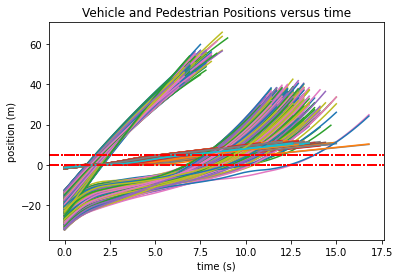

In [105]:

t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

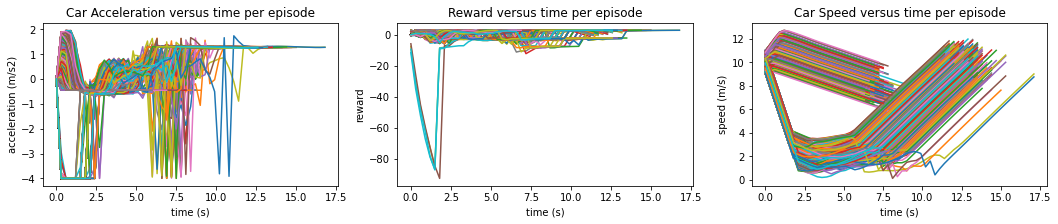

In [106]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


In [107]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=30

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+size_cross]))
        cross_acc.append(np.array(states[t_init:t_init+size_cross,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+size_wait]))
        wait_acc.append(np.array(states[t_init:t_init+size_wait,0]))
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

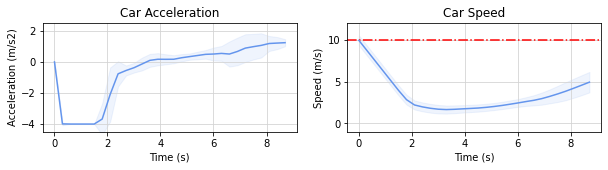

In [108]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
#fig.savefig("PDF_results/car_cross_ddpg.pdf")

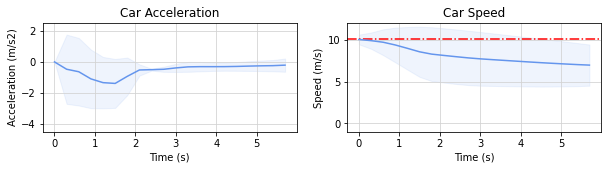

In [109]:
x2=[0.3*i for i in range(size_wait)]

mean_speed2=np.mean(wait_speed,axis=0)
std_speed2=np.std(wait_speed,axis=0)
mean_acc2=np.mean(wait_acc,axis=0)
std_acc2=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x2,mean_acc2,color='cornflowerblue')
ax1.fill_between(x2, (mean_acc2-std_acc2), (mean_acc2+std_acc2), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed2[0], color='r', linestyle='-.')
ax2.plot(x2,mean_speed2,color='cornflowerblue')
ax2.fill_between(x2, (mean_speed2-std_speed2), (mean_speed2+std_speed2), color='cornflowerblue', alpha=0.1)
ax2.grid(True,color='lightgrey')
#fig.savefig("PDF_results/car_wait_ddpg.pdf")

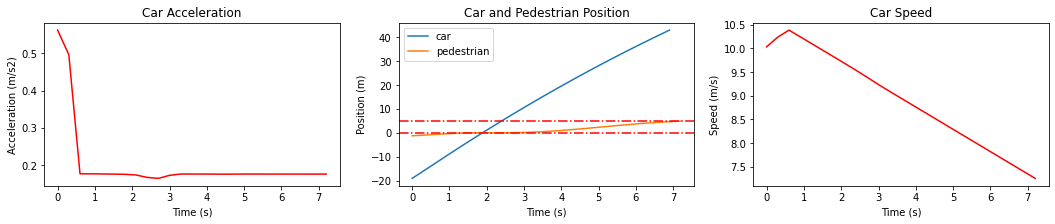

In [102]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

t+=1